In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import sys

RANDOM_SEED = 42
random.seed(RANDOM_SEED)

## GDrive setup
***- Only run if running on Google Colab***

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Set directory to location of OULAD dataset in google drive

In [3]:
cd 'drive/My Drive/Colab Notebooks/4th year project/OULAD dataset'

/content/drive/My Drive/Colab Notebooks/4th year project/OULAD dataset


In [4]:
ls

all_f1.pdf            learning_behaviour_f1.pdf
all_npv.pdf           learning_behaviour_npv.pdf
anonymisedOUDataSet/  pass_fail_rate_modules.pdf
Deadline/             performance_f1.pdf
demographic_f1.pdf    performance_npv.pdf
demographic_npv.pdf   StudentAssessmentDaysDeadline.csv


### Load dataset and split by module

In [5]:
if 'google.colab' in sys.modules:
  path = 'Deadline'
else:
  path = '../../dataset/Deadline'

# Module FFF

## Setup

### Load dataset and remove column features that are not used in module

In [6]:
deadline_list = [0, 50, 100, 150, 200, 250]
df = {}

for i in deadline_list:
  temp = pd.read_csv(f'{path}/{i}/oulad_FFF_{i}.csv')
  temp = temp.drop(['code_module'], axis = 1)
  temp = temp.loc[:, (temp != 0).any(axis=0)]
  # pass course = 0 | fail course = 1
  temp['final_result'] = temp['final_result'].replace({1:1, 2:0, 3:0})
  df[i] = temp

sns.set(rc={'figure.figsize':(11.7,8.27)})

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [7]:
df[0].head()

code_presentation  id_student gender                region  \
0             2013B       33915      F     South East Region   
1             2013B       35544      M                 Wales   
2             2013B       35860      M     South West Region   
3             2013B       42668      M         London Region   
4             2013B       43273      M  East Midlands Region   

       highest_education imd_band age_band  num_of_prev_attempts  \
0  A Level or Equivalent   30-40%     0-35                     0   
1  A Level or Equivalent   80-90%    35-55                     0   
2  A Level or Equivalent    10-20     0-35                     0   
3     Lower Than A Level    10-20    35-55                     1   
4       HE Qualification   60-70%    35-55                     0   

   studied_credits disability  ...  oucontent  ouelluminate  ouwiki  page  \
0               60          N  ...   3.416667           1.0     0.0   1.0   
1               60          N  ...   0.000000           0.0     0.0   0.0   
2               60          N  ...   3.500000           0.0     0.0   1.0   
3              120          N  ...   5.000000           0.0     0.0   1.0   
4               90          N  ...   0.000000           0.0     0.0   0.0   

   questionnaire  quiz  resource   subpage  url  mean_click  
0            0.0   1.0       1.0  1.857143  1.0    0.902172  
1            0.0   0.0       0.0  1.000000  0.0    0.425926  
2            0.0   0.0       1.0  1.545455  1.0    0.802525  
3            0.0   0.0       1.0  1.000000  0.0    0.724265  
4            0.0   0.0       0.0  0.000000  0.0    0.055556  

[5 rows x 27 columns]

In [8]:
df[0].final_result.value_counts()

0    3217
1    1353
Name: final_result, dtype: int64

In [9]:
df[0].code_presentation.value_counts()

2013J    1391
2014J    1318
2013B    1033
2014B     828
Name: code_presentation, dtype: int64

## Helper functions

In [10]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, recall_score, precision_score, roc_auc_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance

### Plotting

In [11]:
def plot_confusion_matrix(result):
  if len(result)==5:
    count = 1
  else:
    count= 0

  fig, axes = plt.subplots((len(result)+count)//2,2, figsize=(25, 28))


  for value, ax in zip(result, axes.flatten()):
      sns.heatmap(value[4], annot=True, ax=ax, cmap=plt.cm.Reds)

      ax.set_title(f'\nDay {count*50}: Confusion Matrix\n');
      ax.set_xlabel('Predicted Values')
      ax.set_ylabel('Actual Values ');

      ax.set_xticklabels(['Fail','Pass'])
      ax.set_yticklabels(['Fail','Pass'])

      count+=1

  plt.tight_layout()

In [12]:
def plot_days(deadline_list,result, title):
  result = np.array(result)
  plt_days = sns.lineplot(x=deadline_list,y=result[:,0],marker="o", label="Accuracy")
  plt_days = sns.lineplot(x=deadline_list,y=result[:,1],marker="o", label="F1 score")
  # plt_days = sns.lineplot(x=deadline_list,y=result[:,2],marker="o", label="Precision")
  # plt_days = sns.lineplot(x=deadline_list,y=result[:,3],marker="o", label="Recall")

  plt_days.set_xlabel("Days of course")
  plt_days.set_ylabel("Score")
  plt_days.set_title(title)

In [13]:
def plot_days_compare(deadline_list,result,labels,title):
  for i in range(len(result)):
    result[i] = np.array(result[i])
    #plt_days = sns.lineplot(x=deadline_list,y=result[:,0],marker="o", label="Accuracy")
    plt_days = sns.lineplot(x=deadline_list,y=result[i][:,1],marker="o", label=labels[i])
    # plt_days = sns.lineplot(x=deadline_list,y=result[:,2],marker="o", label="Precision")
    # plt_days = sns.lineplot(x=deadline_list,y=result[:,3],marker="o", label="Recall")

  plt_days.set_xlabel("Days of course")
  plt_days.set_ylabel("F1 Score")
  plt_days.set_title(title)

In [14]:
def plot_days_compare_npv(deadline_list,result,labels,title):
 
  for i in range(len(result)):   
    npv = []

    for j in result[i][:,4]:
      tn, fp, fn, tp = j.ravel()

      # Prevent zero division error
      if fn == 0:
        npv.append(0)
      else:
        npv.append(tn/(tn+fn))

    #plt_days = sns.lineplot(x=deadline_list,y=result[:,0],marker="o", label="Accuracy")
    plt_days = sns.lineplot(x=deadline_list,y=npv,marker="o", label=labels[i])
    # plt_days = sns.lineplot(x=deadline_list,y=result[:,2],marker="o", label="Precision")
    # plt_days = sns.lineplot(x=deadline_list,y=result[:,3],marker="o", label="Recall")
    
  plt_days.set_xlabel("Days of course")
  plt_days.set_ylabel("Negative Predictive Value")
  plt_days.set_title(title)

In [15]:
def plot_correlation_matrix(result, Y_test= None):
  fig, axes = plt.subplots(len(result)//2,2, figsize=(25, 28))

  temp = {}
  for i in result.keys():
    temp[i] = result[i].copy()
    if Y_test:
      temp[i]['final_result'] = Y_train[i] 

  count= 0
  for value, ax in zip(temp, axes.flatten()):

      corr = temp[value].corr()

      sns.heatmap(corr, annot=True, ax=ax, cmap=plt.cm.Reds)

      ax.set_title(f'\nDay {count*50}: Correlation Matrix\n');

      count+=1

  plt.tight_layout()

In [16]:
def plot_feature_importance(feature_results):

  if len(feature_results)==5:
    count = 1
  else:
    count= 0

  fig, axes = plt.subplots(len(feature_results)//2,2, figsize=(25, 33))

  for value, ax in zip(feature_results, axes.flatten()):
   
    importance = permutation_importance(value[0], value[1], value[2])

    feature_names = tuned_model.feature_names_in_

    ax.bar([x for x in range(len(importance['importances_mean']))], importance['importances_mean'], yerr=importance['importances_std'])
    ax.set_xticks(range(len(feature_names)))
    ax.set_xticklabels(feature_names, rotation='vertical')
    ax.set_title(f'\nDay {count*50}: Feature Importance\n');

    count+=1
  


### Split dataframe

In [17]:
def split_dataset(df_day, train_code_presentation, test_code_presentation):   
  test_df = df_day.loc[df_day['code_presentation']==test_code_presentation]
  test_df = test_df.drop(['code_presentation','id_student'], axis = 1)

  Y_test = test_df['final_result']
  X_test = test_df.drop('final_result', axis=1)

  train_df = df_day.loc[df_day['code_presentation'].isin(train_code_presentation)]
  train_df = train_df.drop(['code_presentation','id_student'], axis = 1)

  Y_train = train_df['final_result']
  X_train = train_df.drop('final_result', axis=1)

  
  return X_train, X_test, Y_train, Y_test


In [18]:

def split_dataset_single_presentation(df_day, code_presentation):

  df_cp = df_day.loc[df_day['code_presentation']==code_presentation]
  df_cp = df_cp.drop(['code_presentation','id_student'], axis = 1)
  
  Y = df_cp['final_result']
  X = df_cp.drop('final_result', axis=1)

  return train_test_split(X,Y, random_state=RANDOM_SEED)


### Evaluate models

In [19]:
def evaluation_summary(y_pred, y_test):
  acc = accuracy_score(y_test,y_pred)
  f1 = f1_score(y_test,y_pred)
  prec = precision_score(y_test, y_pred)
  recall = recall_score(y_test, y_pred)
  
  conf_matrix = confusion_matrix(y_test,y_pred)

  return acc, f1, prec, recall, conf_matrix   

In [20]:
def evaluate_search(model, test_features, test_labels):
    predictions = model.predict(test_features)
    
    acc, f1, prec, recall, conf = evaluation_summary(predictions, test_labels)
    print('Accuracy = {:0.2f}%, F1 Score = {:0.2f}%.'.format(acc, f1))
    
    return acc

### Split dataframe by demographic data | performance data | learning behaviour data

In [21]:
df[0].columns

Index(['code_presentation', 'id_student', 'gender', 'region',
       'highest_education', 'imd_band', 'age_band', 'num_of_prev_attempts',
       'studied_credits', 'disability', 'final_result', 'dualpane', 'forumng',
       'glossary', 'homepage', 'htmlactivity', 'oucollaborate', 'oucontent',
       'ouelluminate', 'ouwiki', 'page', 'questionnaire', 'quiz', 'resource',
       'subpage', 'url', 'mean_click'],
      dtype='object')

In [22]:
def split_dataframe_by_data_type(input_df, column_types, include_final_result=True):
  demographic_columns = ['gender', 'region', 'highest_education', 'imd_band','age_band', 'disability']
  prev_uni_experience_columns = ['num_of_prev_attempts','studied_credits']
  all_performance_columns = ['score','weighted_score']
  performance_columns = set(input_df.columns).intersection(set(all_performance_columns))
  all_learning_behaviour_columns = ['mean_click','resource','subpage','oucontent','url','forumng','quiz','page','oucollaborate','questionnaire','ouwiki','dataplus','externalquiz','homepage','ouelluminate','glossary','dualpane','repeatactivity','htmlactivity','sharedsubpage','folder']
  learning_behaviour_columns = set(input_df.columns).intersection(set(all_learning_behaviour_columns))

  final_result_column = ['final_result']

  type_dict = {"demographic":demographic_columns, "prev_uni_experience":prev_uni_experience_columns, "performance":performance_columns,"learning_behaviour":learning_behaviour_columns, "final_result":final_result_column}

  columns_used = ['code_presentation', 'id_student']
  for i in column_types:
    columns_used.extend(type_dict[i])
  
  if include_final_result:
    columns_used.extend(final_result_column)

  output_df = input_df[columns_used]

  return output_df

In [23]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline

### Encode data

In [24]:
def encode_data(df, train, test=None):
  X_train, X_test, Y_train, Y_test = {},{},{},{}

  for i in df.keys():
    if test != None:
      X_train[i], X_test[i], Y_train[i], Y_test[i] = split_dataset(df[i], train, test)
    else:
      X_train[i], X_test[i], Y_train[i], Y_test[i] = split_dataset_single_presentation(df[i], train)
    
    
    cols_to_drop = X_train[i].nunique()
    cols_to_drop = list(cols_to_drop.loc[cols_to_drop.values==1].index)


    X_train[i] = X_train[i].drop(cols_to_drop, axis=1)
    X_test[i] = X_test[i].drop(cols_to_drop, axis=1)

  for i in df.keys():
    categorical_features = X_train[i].select_dtypes(include="object").columns
    numerical_features = X_train[i].select_dtypes(exclude="object").columns
    print(categorical_features, numerical_features)
    preprocessing_transformer = make_column_transformer(
      (OneHotEncoder(), categorical_features),
      (MinMaxScaler(), numerical_features))  

    try:
      X_train[i] = pd.DataFrame(preprocessing_transformer.fit_transform(X_train[i]).toarray(),
                columns=list(map(lambda x: x.split("__")[1],preprocessing_transformer.get_feature_names_out().tolist())),
                index=X_train[i].index)

      X_test[i] = pd.DataFrame(preprocessing_transformer.transform(X_test[i]).toarray(),
                columns=list(map(lambda x: x.split("__")[1],preprocessing_transformer.get_feature_names_out().tolist())),
                index=X_test[i].index)
    except:
      X_train[i] = pd.DataFrame(preprocessing_transformer.fit_transform(X_train[i]),
          columns=list(map(lambda x: x.split("__")[1],preprocessing_transformer.get_feature_names_out().tolist())),
          index=X_train[i].index)

      X_test[i] = pd.DataFrame(preprocessing_transformer.transform(X_test[i]),
                columns=list(map(lambda x: x.split("__")[1],preprocessing_transformer.get_feature_names_out().tolist())),
                index=X_test[i].index)

  return X_train, X_test, Y_train, Y_test

## Feature correlation
 

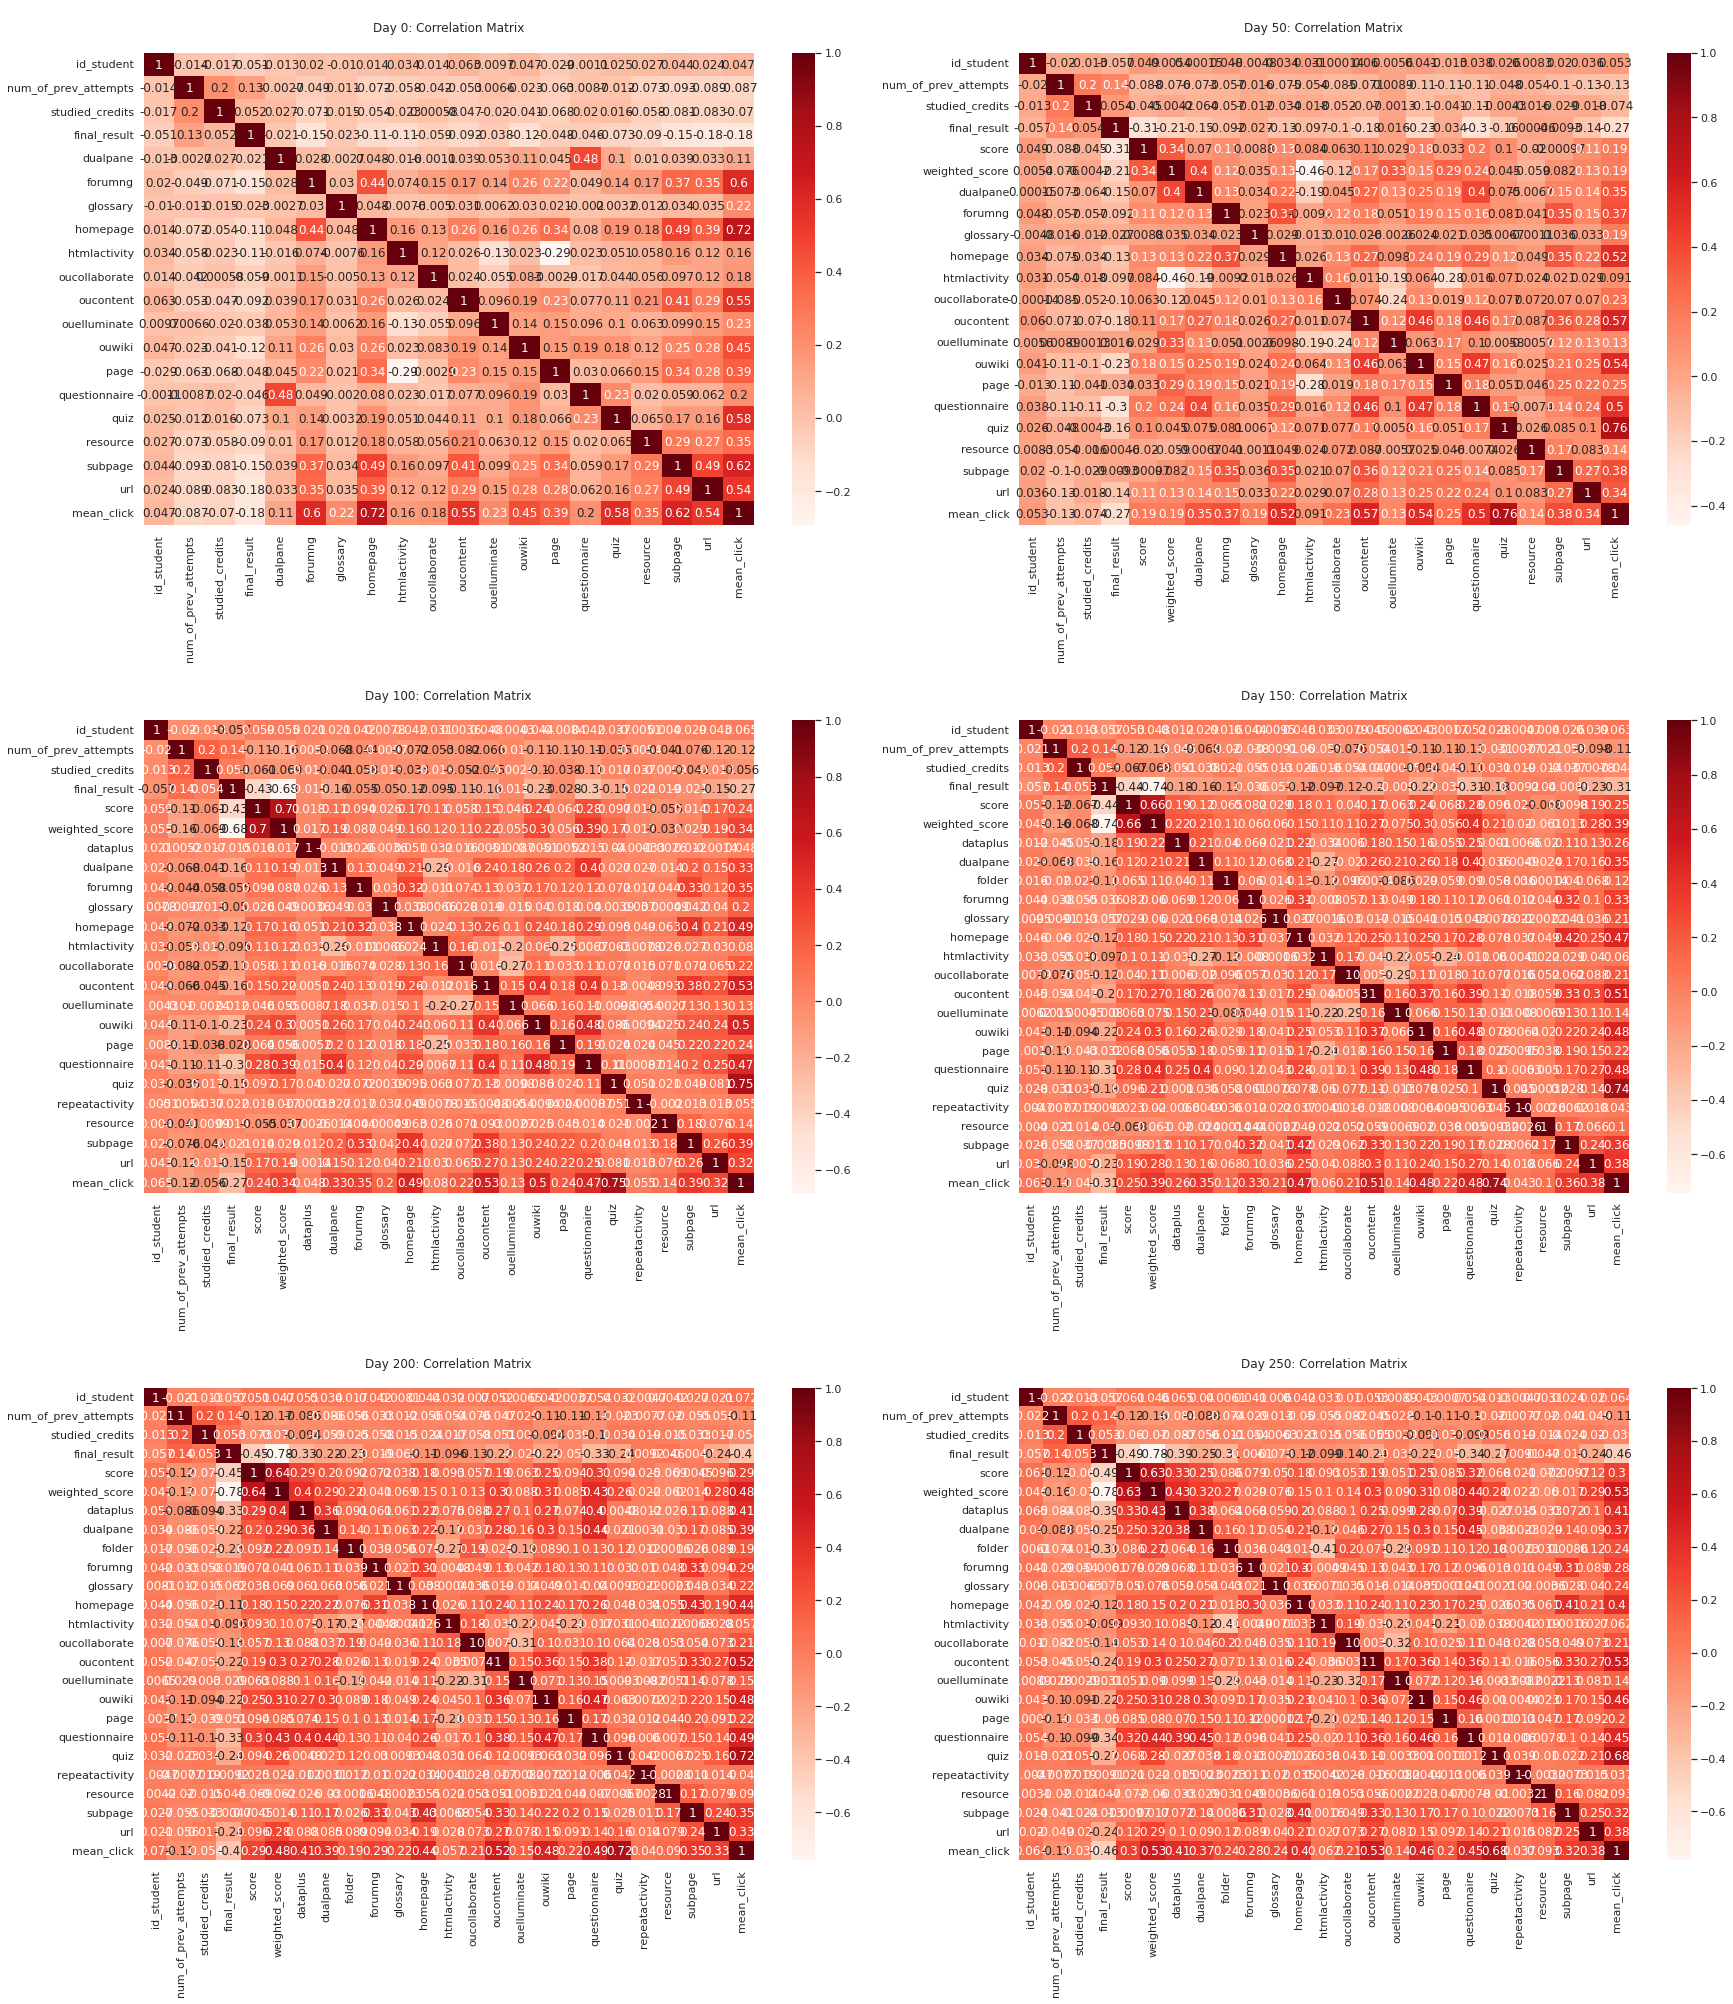

In [25]:
plot_correlation_matrix(df)

## Make predictions

In [26]:
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest, chi2, f_classif, SelectFdr, SelectFpr
from sklearn.decomposition import PCA

### 2013J | 2014J predictions

#### Demographic data

##### Prepare data for prediction

In [27]:
demographic_df = {}
for i in df.keys():
  demographic_df[i] = split_dataframe_by_data_type(df[i], ['demographic'], include_final_result=True)

###### Encode data

In [28]:
X_train, X_test, Y_train, Y_test = encode_data(demographic_df, ["2013J"], "2014J")

Index(['gender', 'region', 'highest_education', 'imd_band', 'age_band',
       'disability'],
      dtype='object') Index([], dtype='object')
Index(['gender', 'region', 'highest_education', 'imd_band', 'age_band',
       'disability'],
      dtype='object') Index([], dtype='object')
Index(['gender', 'region', 'highest_education', 'imd_band', 'age_band',
       'disability'],
      dtype='object') Index([], dtype='object')
Index(['gender', 'region', 'highest_education', 'imd_band', 'age_band',
       'disability'],
      dtype='object') Index([], dtype='object')
Index(['gender', 'region', 'highest_education', 'imd_band', 'age_band',
       'disability'],
      dtype='object') Index([], dtype='object')
Index(['gender', 'region', 'highest_education', 'imd_band', 'age_band',
       'disability'],
      dtype='object') Index([], dtype='object')


In [29]:
X_train[0].shape

(1391, 35)

###### Undersampling

In [30]:
Y_train[0].value_counts()

0    984
1    407
Name: final_result, dtype: int64

In [31]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks

from collections import Counter

X_train_sample, Y_train_sample = {},{}

for i in df.keys():

  sampler = RandomUnderSampler() # fit predictor and target variable
  X_train_sample[i], Y_train_sample[i] = sampler.fit_resample(X_train[i], Y_train[i])

  print(f"Sampling for day {i}")
  print('Original dataset shape:', Counter(Y_train[i]))
  print('Resample dataset shape', Counter(Y_train_sample[i]))

Sampling for day 0
Original dataset shape: Counter({0: 984, 1: 407})
Resample dataset shape Counter({0: 407, 1: 407})
Sampling for day 50
Original dataset shape: Counter({0: 1028, 1: 418})
Resample dataset shape Counter({0: 418, 1: 418})
Sampling for day 100
Original dataset shape: Counter({0: 1028, 1: 418})
Resample dataset shape Counter({0: 418, 1: 418})
Sampling for day 150
Original dataset shape: Counter({0: 1028, 1: 419})
Resample dataset shape Counter({0: 419, 1: 419})
Sampling for day 200
Original dataset shape: Counter({0: 1028, 1: 419})
Resample dataset shape Counter({0: 419, 1: 419})
Sampling for day 250
Original dataset shape: Counter({0: 1028, 1: 425})
Resample dataset shape Counter({0: 425, 1: 425})


###### Feature selection

In [32]:
for i in df.keys():
  feature_selection_transformer = SelectKBest(score_func=chi2, k=20)

  X_train[i] = pd.DataFrame(feature_selection_transformer.fit_transform(X_train[i], Y_train[i]))
  
  X_test[i] = pd.DataFrame(feature_selection_transformer.transform(X_test[i]))

In [33]:
X_train[250]

0    1    2    3    4    5    6    7    8    9    10   11   12   13  \
0     0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0   
1     0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  1.0   
2     0.0  1.0  0.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  1.0   
3     0.0  1.0  0.0  0.0  1.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0   
4     1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0   
...   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
1448  0.0  1.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0   
1449  0.0  1.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0  0.0  0.0  0.0   
1450  0.0  1.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0   
1451  0.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0   
1452  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0   

       14   15   16   17   18   19  
0     0.0  1.0  0.0  0.0  1.0  0.0  
1     0.0  0.0  0.0  1.0  0.0  0.0  
2     0.0  0.0  0.0  1.0  0.0  0.0  
3     1.0  0.0  0.0  1.0  0.0  0.0  
4     0.0  1.0  0.0  0.0  1.0  0.0  
...   ...  ...  ...  ...  ...  ...  
1448  0.0  0.0  0.0  1.0  0.0  1.0  
1449  0.0  0.0  0.0  1.0  0.0  0.0  
1450  0.0  1.0  0.0  1.0  0.0  0.0  
1451  0.0  1.0  0.0  1.0  0.0  0.0  
1452  0.0  0.0  0.0  1.0  0.0  0.0  

[1453 rows x 20 columns]

##### DummyClassifier

In [34]:
from sklearn.dummy import DummyClassifier

demographic_results_du = []

pipeline = Pipeline([
    ('clf', DummyClassifier(strategy="uniform",random_state=RANDOM_SEED)),
])

params = {
}

for i in df.keys():
  print(f"Day {i}")
  grid_search = GridSearchCV(pipeline , param_grid=params , n_jobs=-1, verbose=1, scoring='f1_macro', cv=3,)
  print("Performing grid search...")
  print("pipeline:", [name for name, _ in pipeline.steps])
  print("parameters:")
  print(params)
  tuned_model = grid_search.fit(X_train[i], Y_train[i])

  print("Best score: %0.3f" % grid_search.best_score_)
  print("Best parameters set:")
  best_parameters = grid_search.best_estimator_.get_params()
  for param_name in sorted(params.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

  predictions = tuned_model.predict(X_test[i])


  acc, f1, prec, recall, conf = evaluation_summary(predictions, Y_test[i])
  print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
  demographic_results_du.append([acc, f1, prec, recall, conf])
  print("\n")

Day 0
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.470
Best parameters set:
Accuracy: 0.4939301972685888, F1 Score: 0.3214649033570702, Precision: 0.2404870624048706, Recall: 0.48466257668711654


Day 50
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.433
Best parameters set:
Accuracy: 0.5097897026831038, F1 Score: 0.33984375, Precision: 0.2525399129172714, Recall: 0.5194029850746269


Day 100
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.433
Best parameters set:
Accuracy: 0.4841040462427746, F1 Score: 0.3081395348837209, Precision: 0.22943722943722944, Recall: 0.4690265486725664


Day 150
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.433
Best param

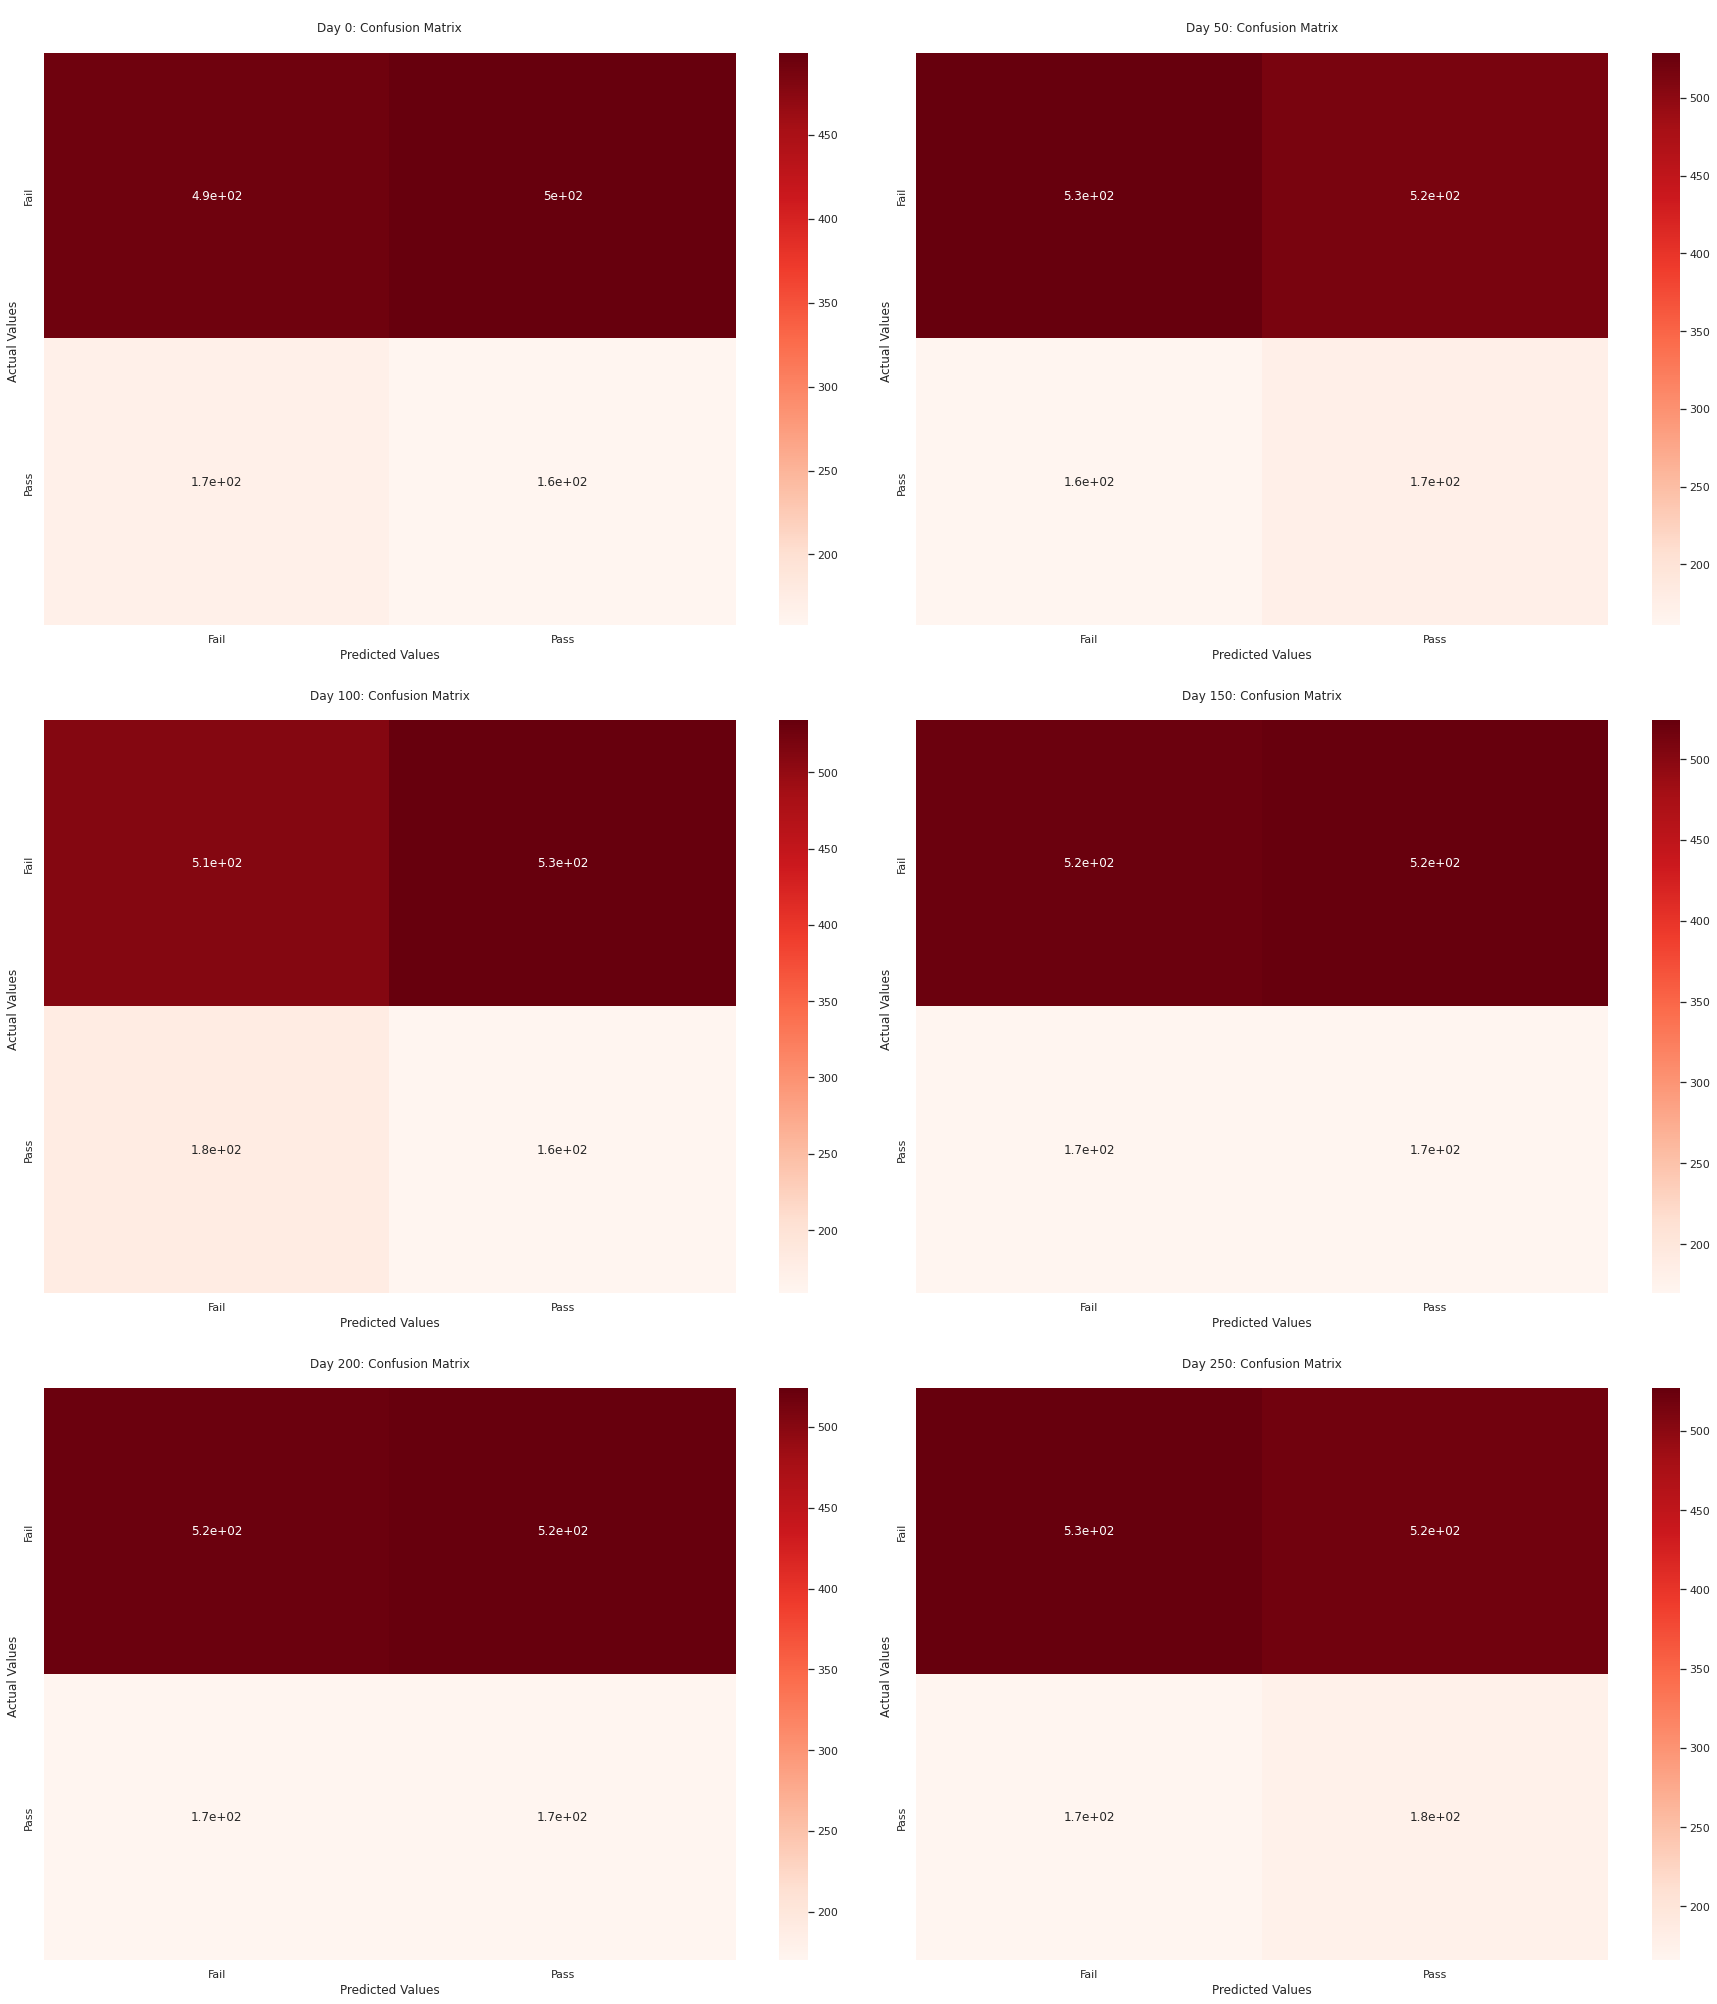

In [35]:
plot_confusion_matrix(demographic_results_du)

##### NaiveBayes

BernoulliNB is used as it is specfically designed for binary/boolean features.

In [36]:
from sklearn.naive_bayes import GaussianNB,ComplementNB,BernoulliNB

demographic_results_nb = []

pipeline = Pipeline([
    ('clf', BernoulliNB(binarize=None)),
])

params = {
  #'clf__class_weight':({0:2,1:1},{0:3,1:1},{0:1.5,1:1})
}

for i in df.keys():
  print(f"Day {i}")
  grid_search = GridSearchCV(pipeline , param_grid=params , n_jobs=-1, verbose=1, scoring='f1_macro', cv=3,)
  print("Performing grid search...")
  print("pipeline:", [name for name, _ in pipeline.steps])
  print("parameters:")
  print(params)
  tuned_model = grid_search.fit(X_train[i], Y_train[i])

  print("Best score: %0.3f" % grid_search.best_score_)
  print("Best parameters set:")
  best_parameters = grid_search.best_estimator_.get_params()
  for param_name in sorted(params.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

  predictions = tuned_model.predict(X_test[i])


  acc, f1, prec, recall, conf = evaluation_summary(predictions, Y_test[i])
  print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
  demographic_results_nb.append([acc, f1, prec, recall, conf])
  print("\n")

Day 0
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.562
Best parameters set:
Accuracy: 0.7071320182094082, F1 Score: 0.339041095890411, Precision: 0.38372093023255816, Recall: 0.30368098159509205


Day 50
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.557
Best parameters set:
Accuracy: 0.7150108774474256, F1 Score: 0.31173380035026266, Precision: 0.3771186440677966, Recall: 0.2656716417910448


Day 100
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.557
Best parameters set:
Accuracy: 0.713150289017341, F1 Score: 0.3095652173913044, Precision: 0.3771186440677966, Recall: 0.26253687315634217


Day 150
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.558
Be

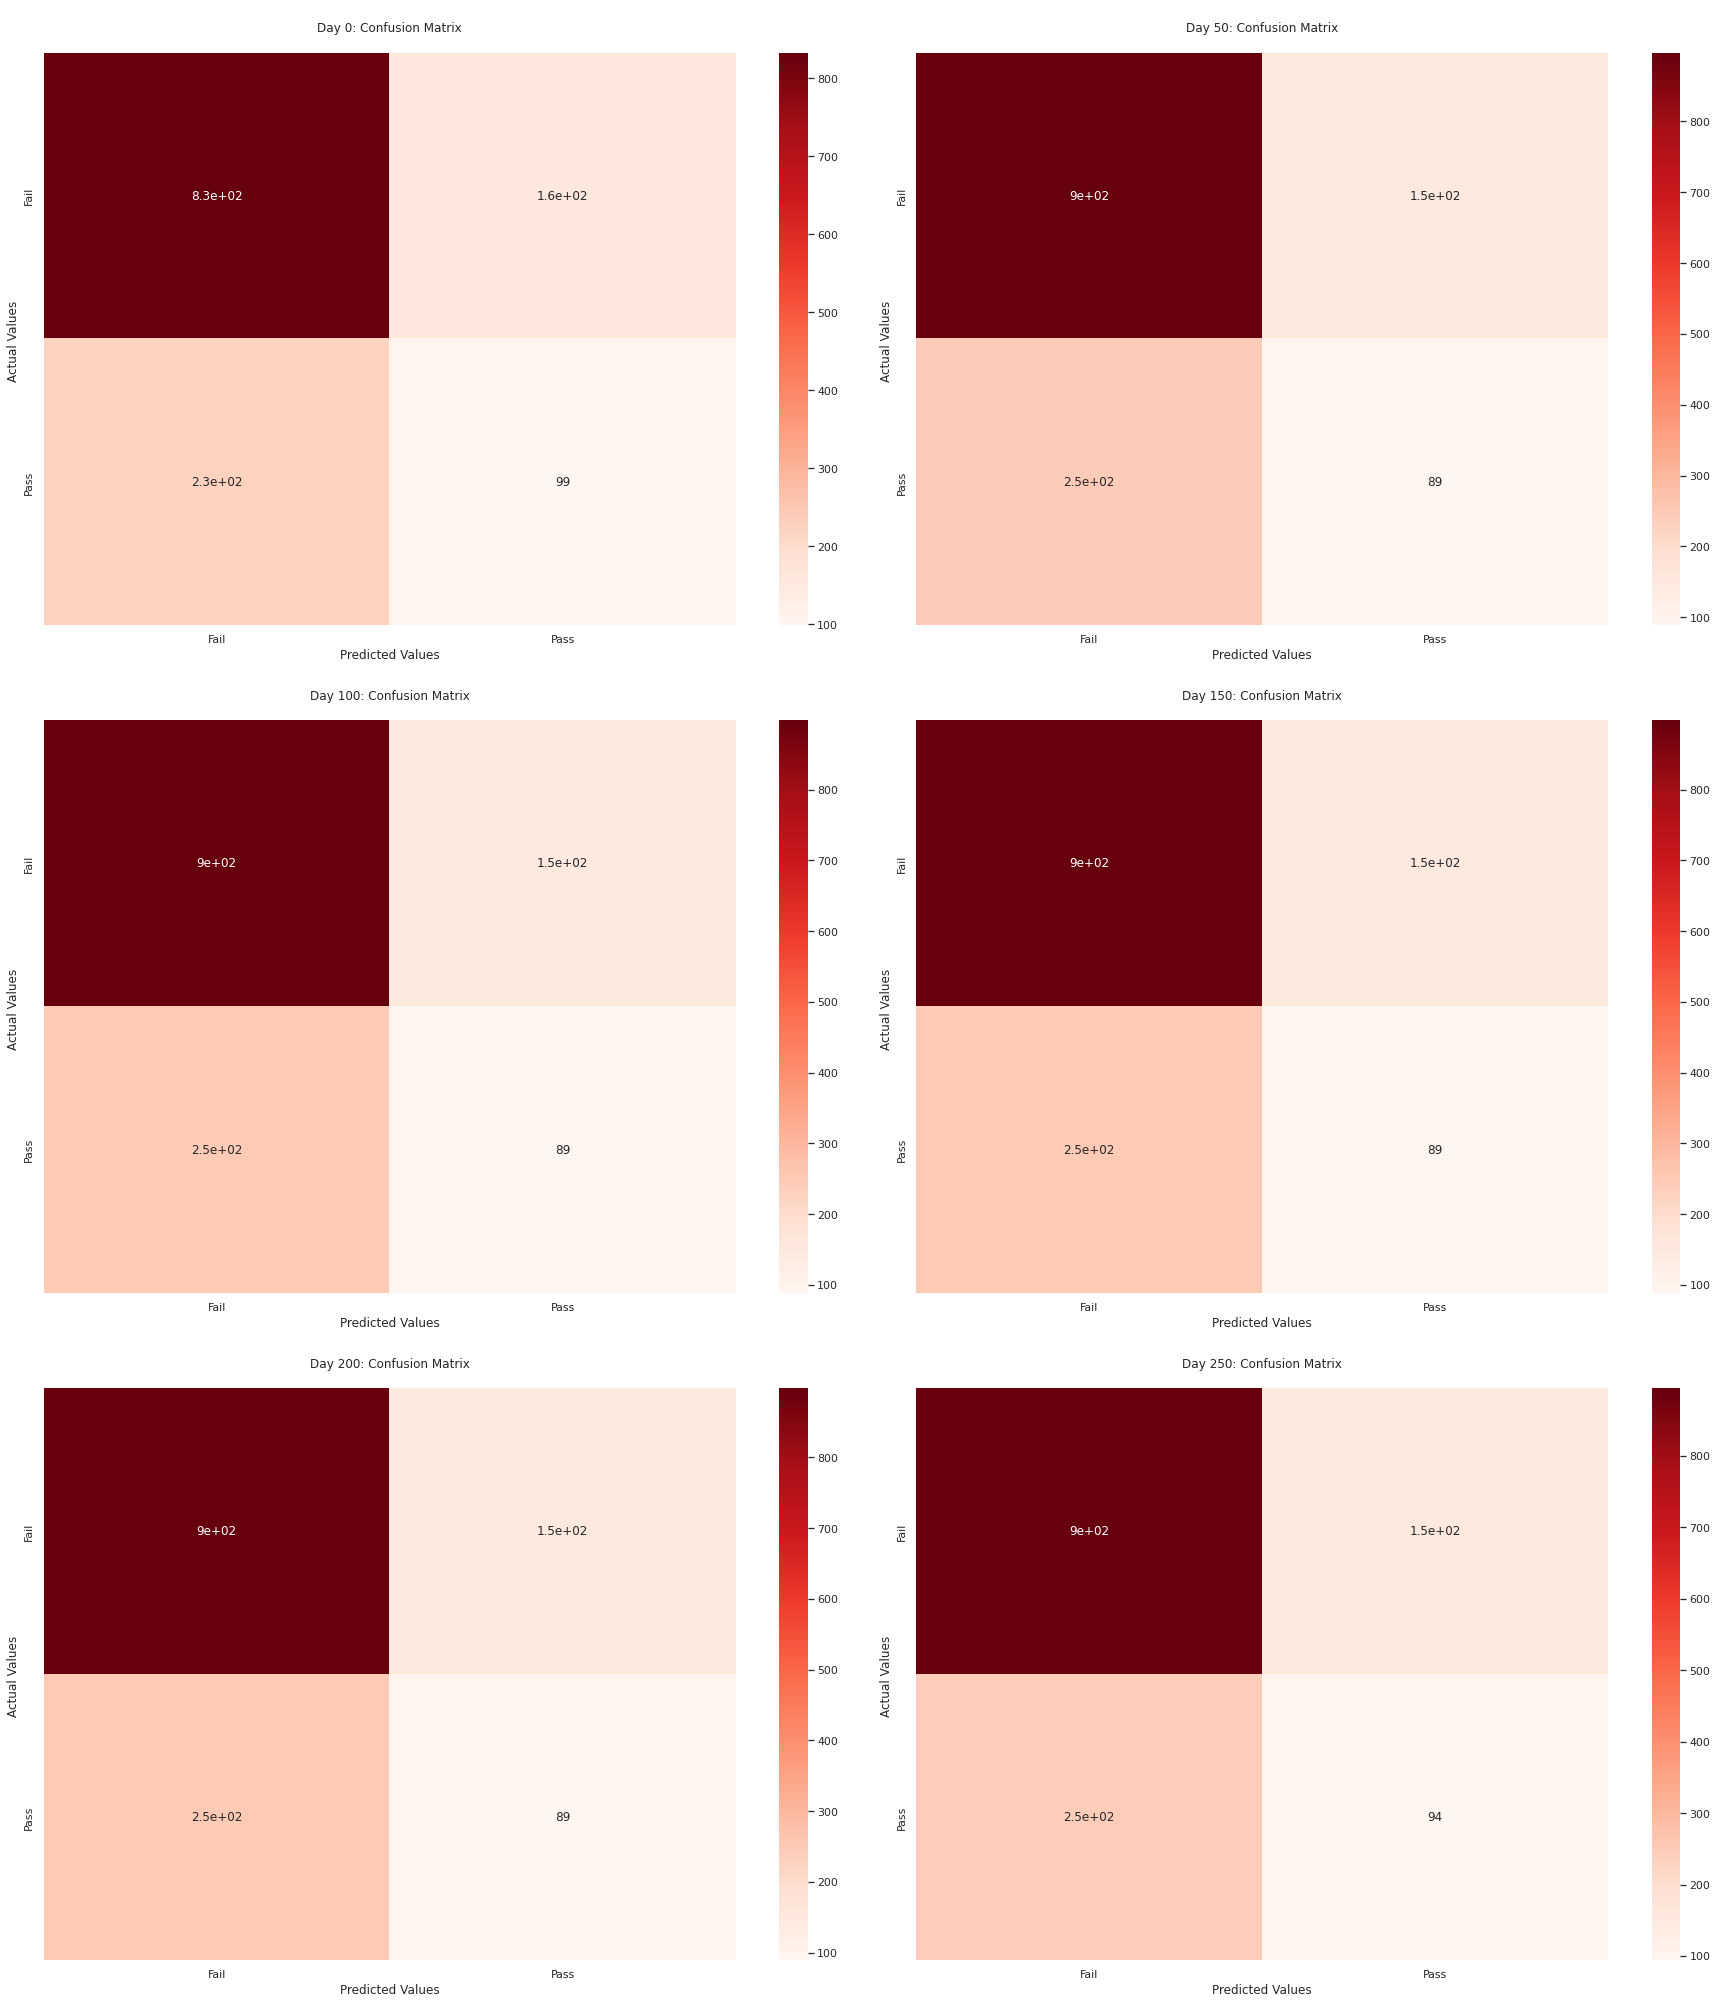

In [37]:
plot_confusion_matrix(demographic_results_nb)

##### LogisticRegression

ovr is used for binary problems

In [38]:
from sklearn.linear_model import LogisticRegression

demographic_results_lr = []

pipeline = Pipeline([
    ('clf', LogisticRegression(multi_class='ovr')),
])

params = {
  'clf__penalty': ['l2', 'none']
}

for i in df.keys():
  print(f"Day {i}")
  grid_search = GridSearchCV(pipeline , param_grid=params , n_jobs=-1, verbose=1, scoring='f1_macro', cv=3,)
  print("Performing grid search...")
  print("pipeline:", [name for name, _ in pipeline.steps])
  print("parameters:")
  print(params)
  tuned_model = grid_search.fit(X_train[i], Y_train[i])

  print("Best score: %0.3f" % grid_search.best_score_)
  print("Best parameters set:")
  best_parameters = grid_search.best_estimator_.get_params()
  for param_name in sorted(params.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

  predictions = tuned_model.predict(X_test[i])


  acc, f1, prec, recall, conf = evaluation_summary(predictions, Y_test[i])
  print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
  demographic_results_lr.append([acc, f1, prec, recall, conf])
  print("\n")

Day 0
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__penalty': ['l2', 'none']}
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Best score: 0.516
Best parameters set:
	clf__penalty: 'none'
Accuracy: 0.7503793626707133, F1 Score: 0.19164619164619162, Precision: 0.48148148148148145, Recall: 0.1196319018404908


Day 50
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__penalty': ['l2', 'none']}
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Best score: 0.488
Best parameters set:
	clf__penalty: 'none'
Accuracy: 0.7469180565627266, F1 Score: 0.1749408983451537, Precision: 0.42045454545454547, Recall: 0.11044776119402985


Day 100
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__penalty': ['l2', 'none']}
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Best score: 0.488
Best parameters set:
	clf__penalty: 'none'
Accuracy: 0.744942196531792, F1 Score: 0.17330210772833723, Precision: 0.42045454545454547, Recall: 0.109144

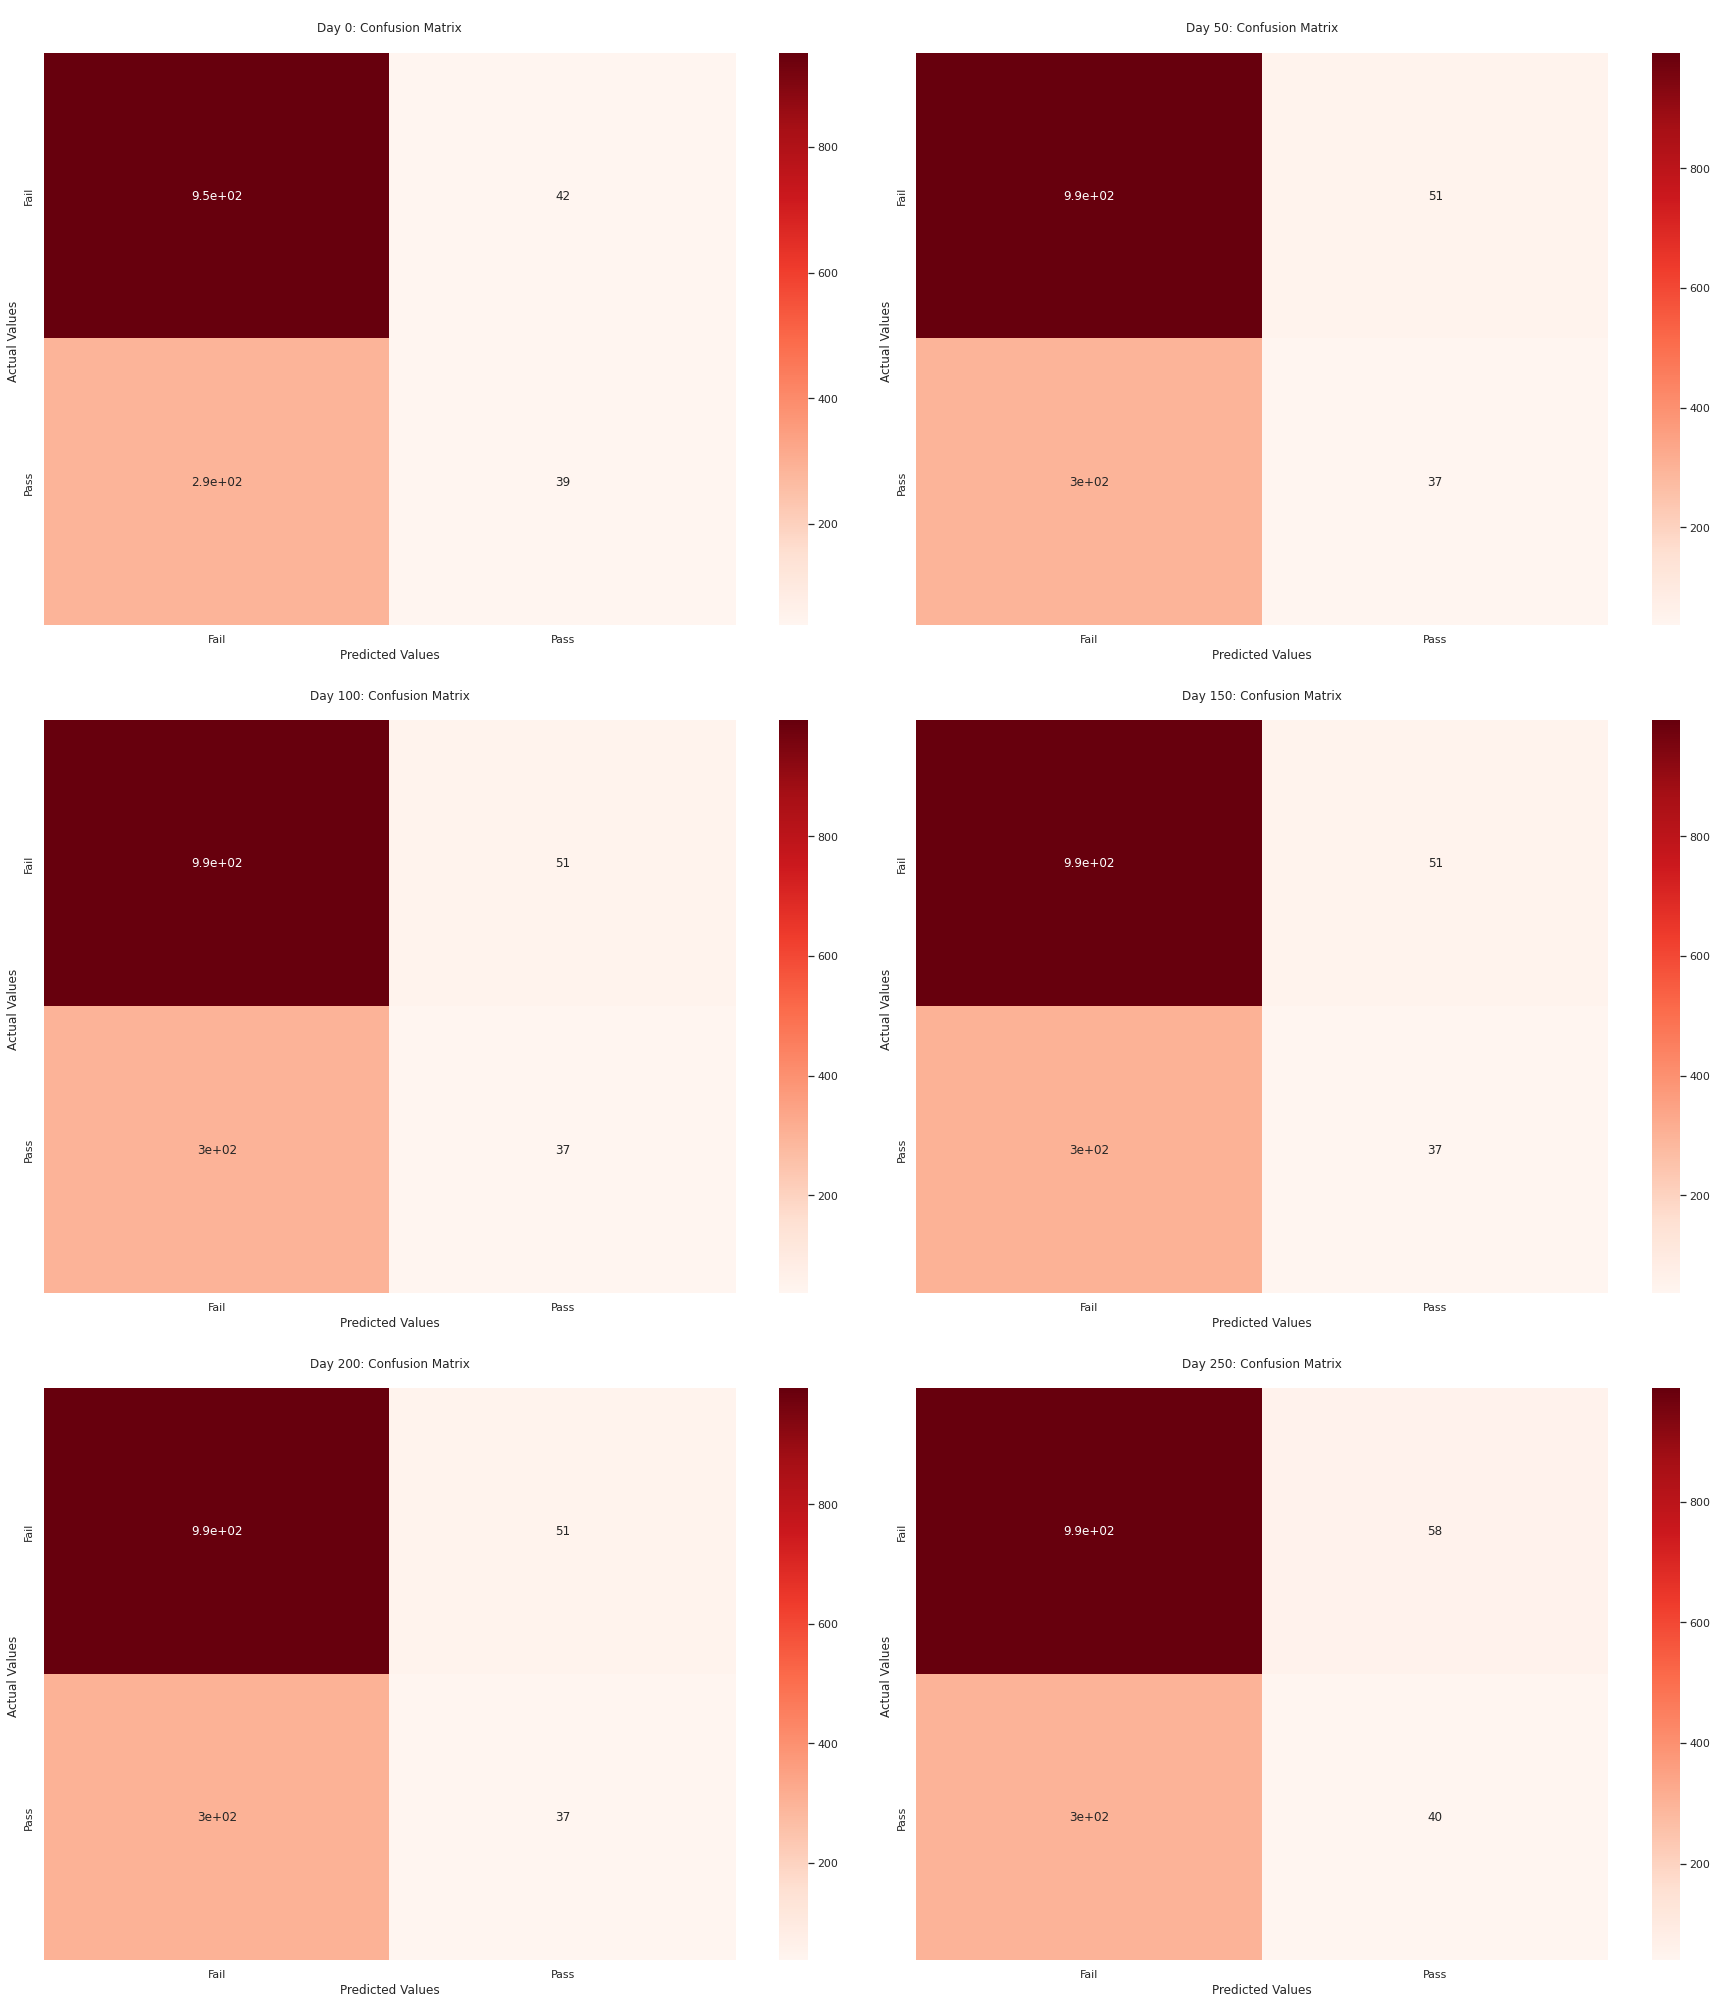

In [39]:
plot_confusion_matrix(demographic_results_lr)

##### WeightedLogisticRegression

In [40]:
demographic_results_lrw = []

pipeline = Pipeline([
    ('clf', LogisticRegression(multi_class='ovr', class_weight = 'balanced')),
])

params = {
}

for i in df.keys():
  print(f"Day {i}")
  grid_search = GridSearchCV(pipeline , param_grid=params , n_jobs=-1, verbose=1, scoring='f1_macro', cv=3,)
  print("Performing grid search...")
  print("pipeline:", [name for name, _ in pipeline.steps])
  print("parameters:")
  print(params)
  tuned_model = grid_search.fit(X_train[i], Y_train[i])

  print("Best score: %0.3f" % grid_search.best_score_)
  print("Best parameters set:")
  best_parameters = grid_search.best_estimator_.get_params()
  for param_name in sorted(params.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

  predictions = tuned_model.predict(X_test[i])


  acc, f1, prec, recall, conf = evaluation_summary(predictions, Y_test[i])
  print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
  demographic_results_lrw.append([acc, f1, prec, recall, conf])
  print("\n")

Day 0
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.569
Best parameters set:
Accuracy: 0.5842185128983308, F1 Score: 0.38565022421524664, Precision: 0.303886925795053, Recall: 0.5276073619631901


Day 50
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.568
Best parameters set:
Accuracy: 0.5808556925308195, F1 Score: 0.39791666666666664, Precision: 0.3056, Recall: 0.5701492537313433


Day 100
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.568
Best parameters set:
Accuracy: 0.5802023121387283, F1 Score: 0.39792746113989635, Precision: 0.30670926517571884, Recall: 0.5663716814159292


Day 150
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.566
Best paramete

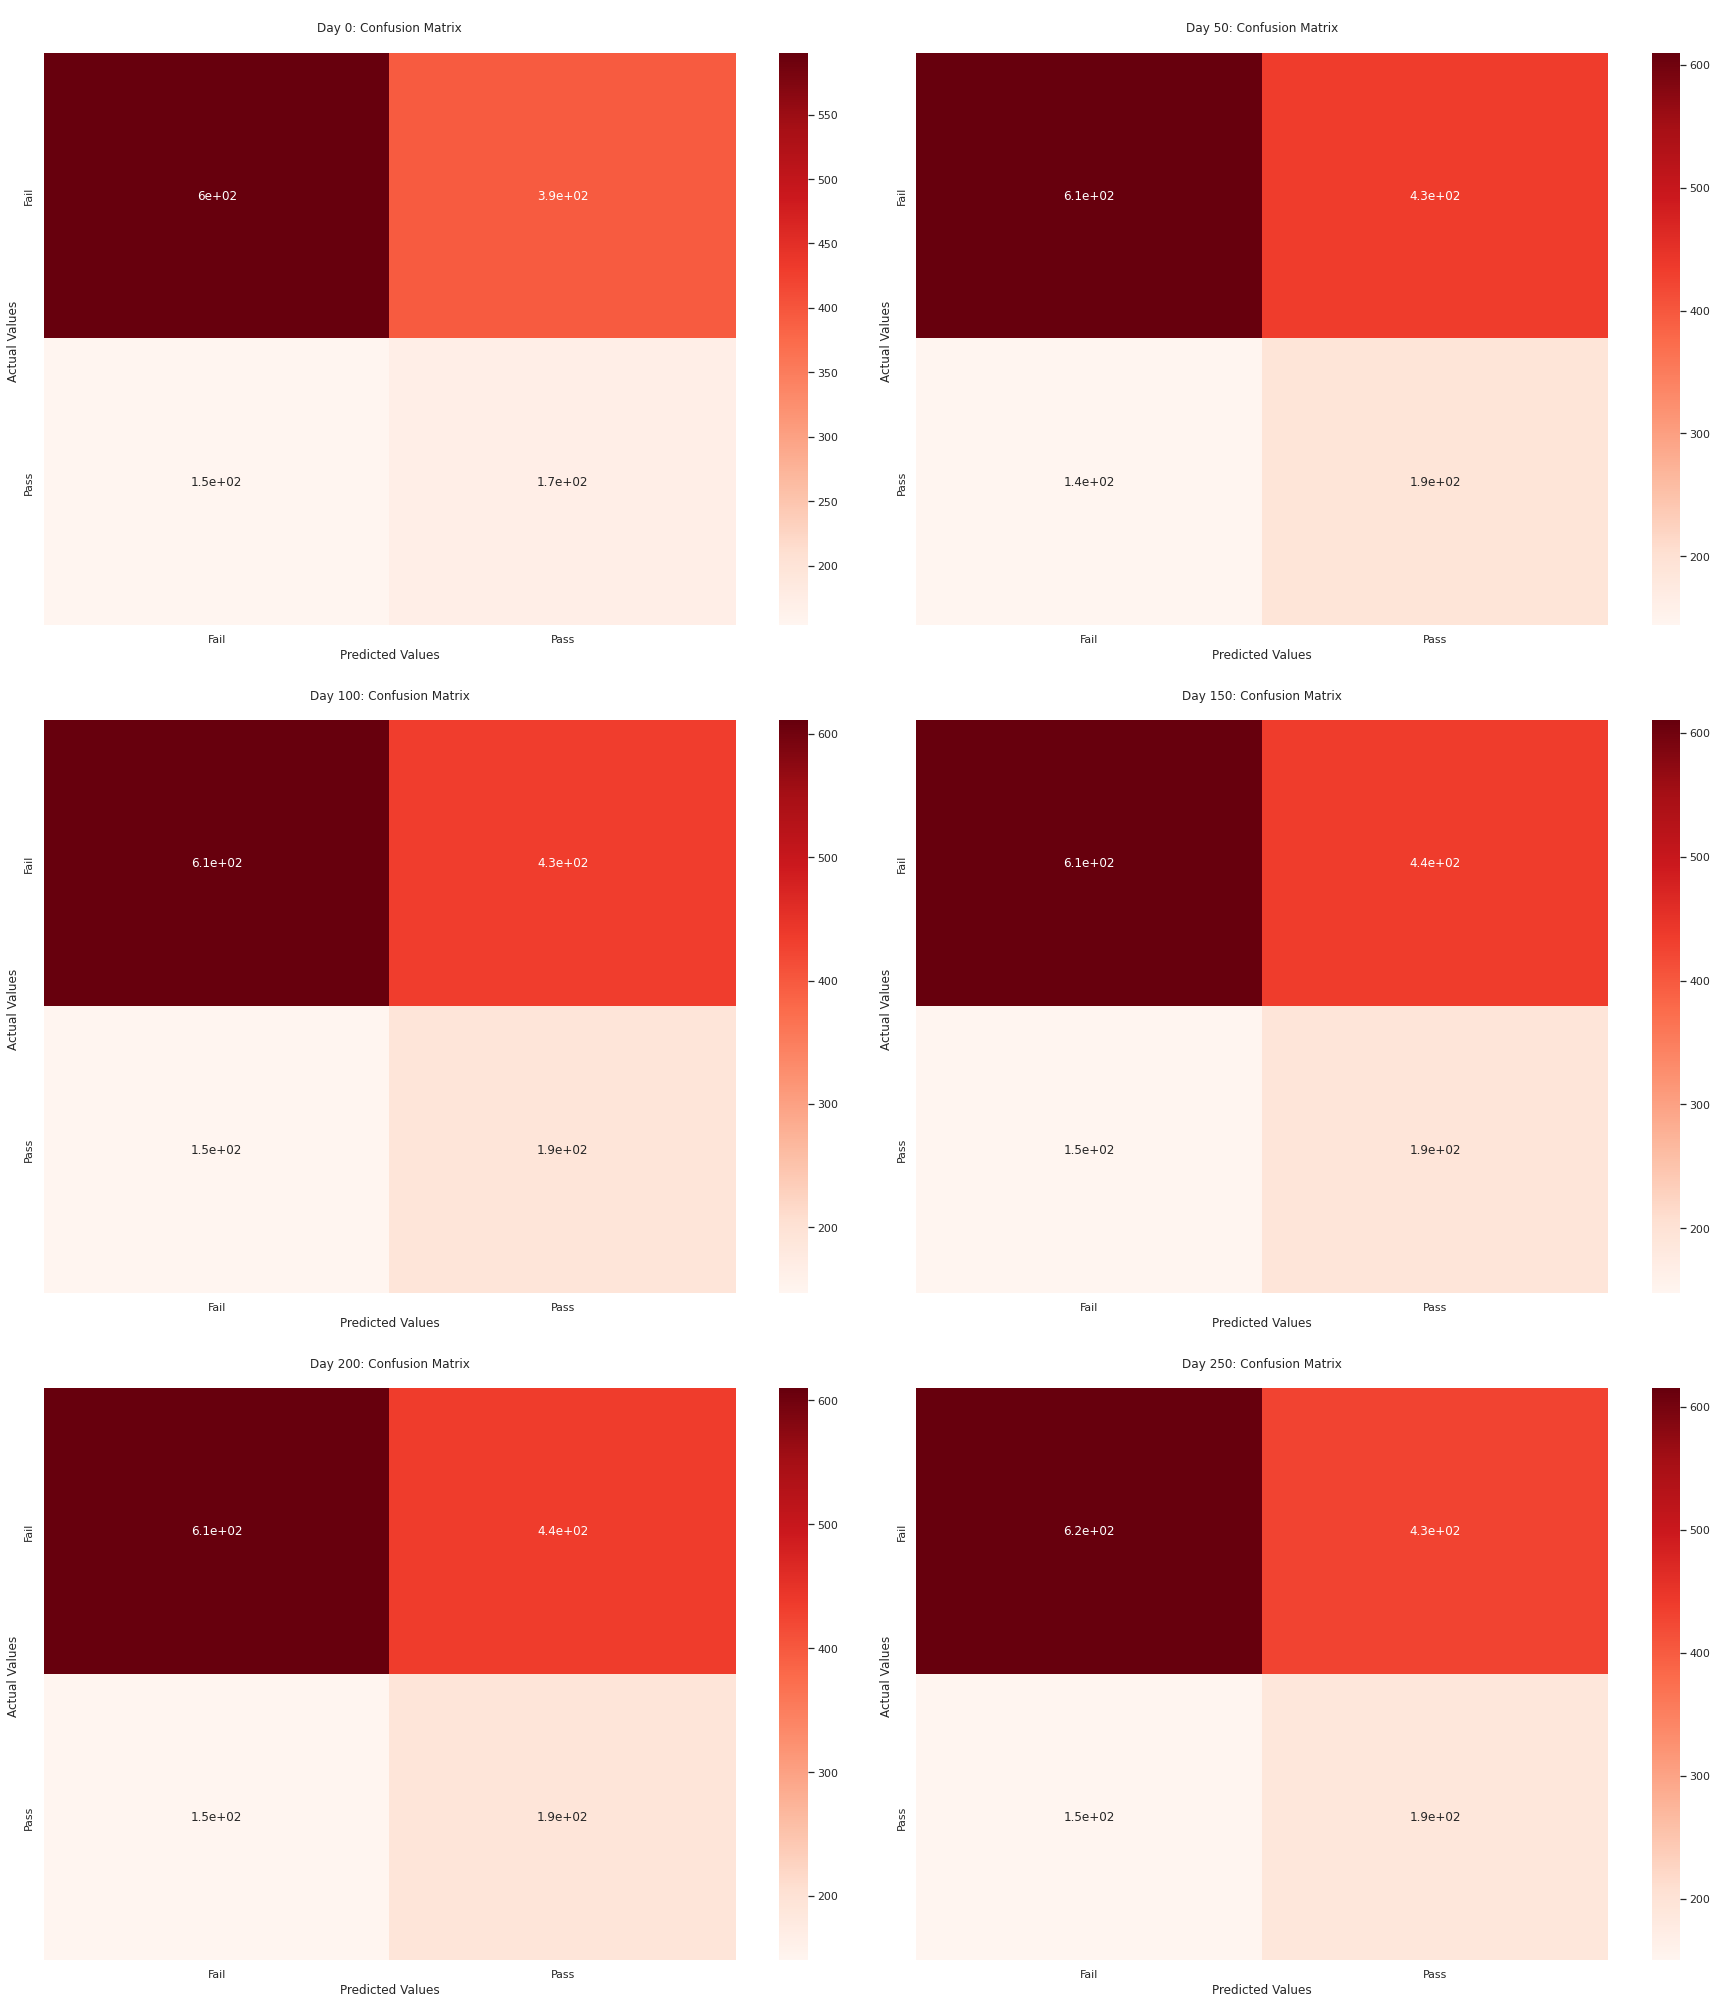

In [41]:
plot_confusion_matrix(demographic_results_lrw)

##### RandomForest

In [42]:
from sklearn.ensemble import RandomForestClassifier

demographic_results_rf = []

pipeline = Pipeline([
    ('clf', RandomForestClassifier(random_state=RANDOM_SEED, class_weight = 'balanced')),
])

params = {
  'clf__n_estimators': [x for x in range(50,150,10)]
}

for i in df.keys():
  print(f"Day {i}")
  grid_search = GridSearchCV(pipeline , param_grid=params , n_jobs=-1, verbose=1, scoring='f1_macro', cv=3,)
  print("Performing grid search...")
  print("pipeline:", [name for name, _ in pipeline.steps])
  print("parameters:")
  print(params)
  tuned_model = grid_search.fit(X_train[i], Y_train[i])

  print("Best score: %0.3f" % grid_search.best_score_)
  print("Best parameters set:")
  best_parameters = grid_search.best_estimator_.get_params()
  for param_name in sorted(params.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

  predictions = tuned_model.predict(X_test[i])


  acc, f1, prec, recall, conf = evaluation_summary(predictions, Y_test[i])
  print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
  demographic_results_rf.append([acc, f1, prec, recall, conf])
  print("\n")

Day 0
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__n_estimators': [50, 60, 70, 80, 90, 100, 110, 120, 130, 140]}
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best score: 0.557
Best parameters set:
	clf__n_estimators: 110
Accuracy: 0.6092564491654021, F1 Score: 0.3302990897269181, Precision: 0.2866817155756208, Recall: 0.3895705521472393


Day 50
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__n_estimators': [50, 60, 70, 80, 90, 100, 110, 120, 130, 140]}
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best score: 0.549
Best parameters set:
	clf__n_estimators: 130
Accuracy: 0.5902828136330674, F1 Score: 0.31013431013431014, Precision: 0.26239669421487605, Recall: 0.37910447761194027


Day 100
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__n_estimators': [50, 60, 70, 80, 90, 100, 110, 120, 130, 140]}
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best score: 0.549
Best parameters set:
	clf__n_estim

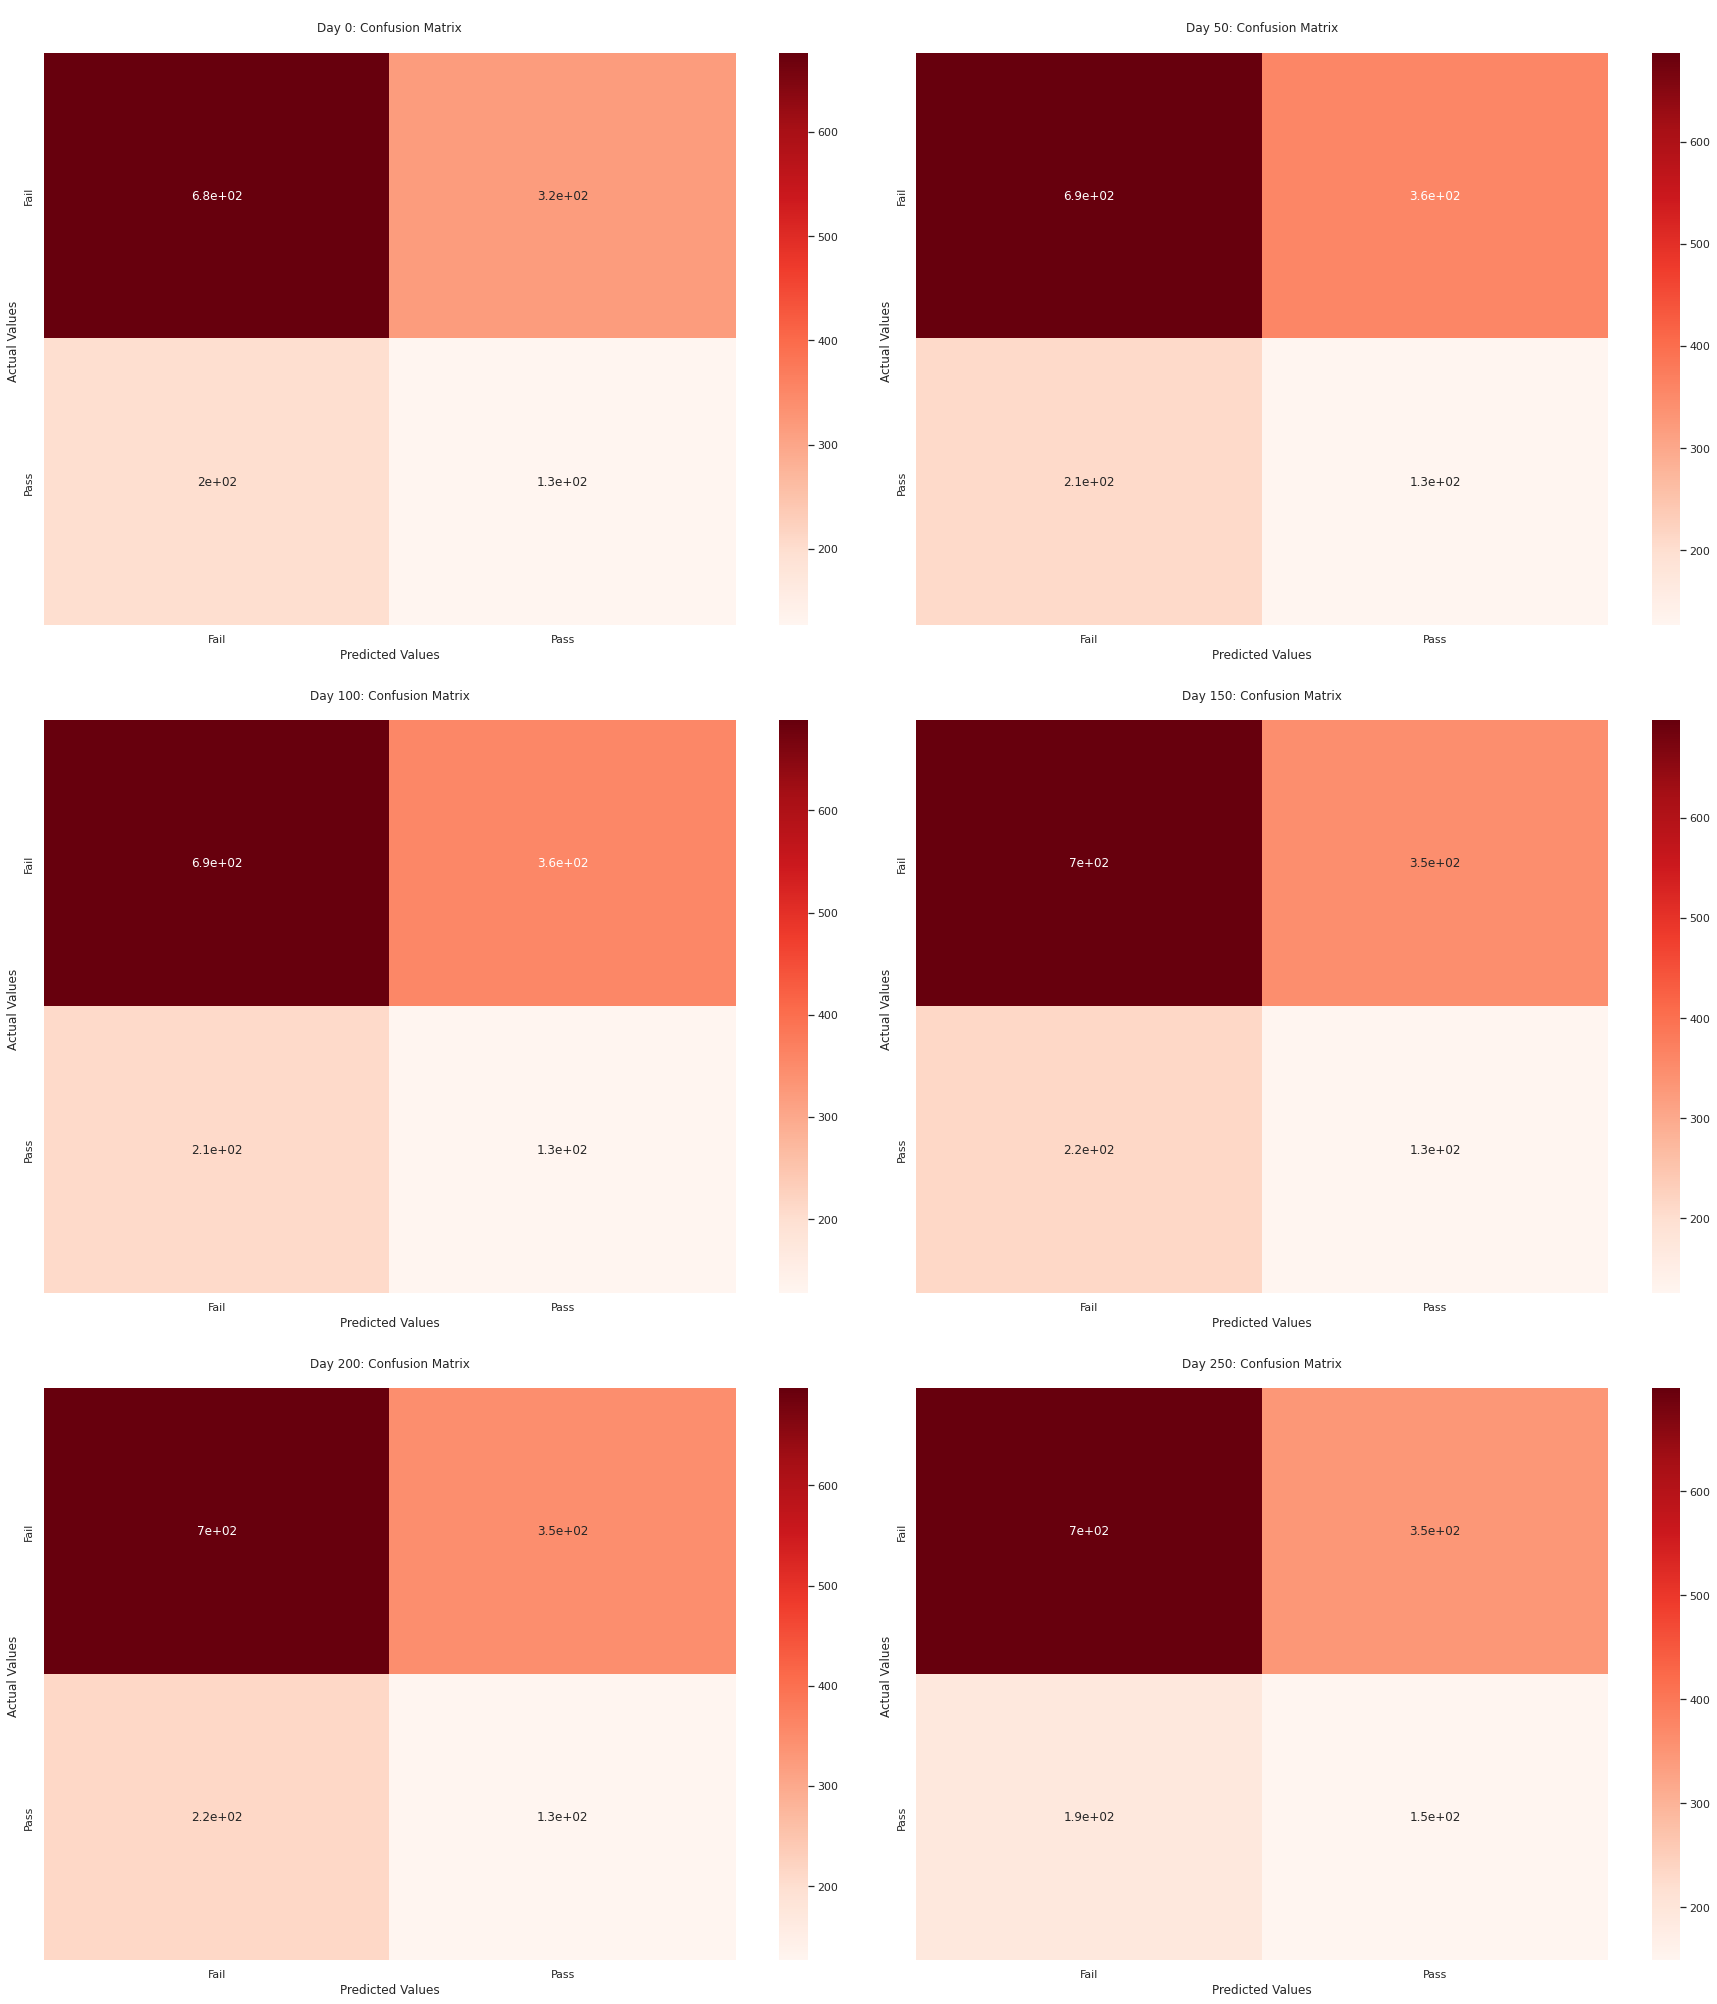

In [43]:
plot_confusion_matrix(demographic_results_rf)

##### AdaBoost

In [44]:
from sklearn.ensemble import AdaBoostClassifier

demographic_results_ab = []

pipeline = Pipeline([
    ('clf', AdaBoostClassifier(random_state=RANDOM_SEED)),
])

params = {
  'clf__learning_rate':(0.5,0.85,1,1.25,1.5,1.75)
}

for i in df.keys():
  print(f"Day {i}")
  grid_search = GridSearchCV(pipeline , param_grid=params , n_jobs=-1, verbose=1, scoring='f1_macro', cv=3,)
  print("Performing grid search...")
  print("pipeline:", [name for name, _ in pipeline.steps])
  print("parameters:")
  print(params)
  tuned_model = grid_search.fit(X_train[i], Y_train[i])

  print("Best score: %0.3f" % grid_search.best_score_)
  print("Best parameters set:")
  best_parameters = grid_search.best_estimator_.get_params()
  for param_name in sorted(params.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

  predictions = tuned_model.predict(X_test[i])


  acc, f1, prec, recall, conf = evaluation_summary(predictions, Y_test[i])
  print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
  demographic_results_ab.append([acc, f1, prec, recall, conf])
  print("\n")

Day 0
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__learning_rate': (0.5, 0.85, 1, 1.25, 1.5, 1.75)}
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best score: 0.526
Best parameters set:
	clf__learning_rate: 1.75
Accuracy: 0.7382397572078907, F1 Score: 0.23841059602649, Precision: 0.4251968503937008, Recall: 0.1656441717791411


Day 50
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__learning_rate': (0.5, 0.85, 1, 1.25, 1.5, 1.75)}
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best score: 0.491
Best parameters set:
	clf__learning_rate: 1
Accuracy: 0.7469180565627266, F1 Score: 0.1749408983451537, Precision: 0.42045454545454547, Recall: 0.11044776119402985


Day 100
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__learning_rate': (0.5, 0.85, 1, 1.25, 1.5, 1.75)}
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best score: 0.491
Best parameters set:
	clf__learning_rate: 1
Accuracy: 0.744942196531792, F1 Sc

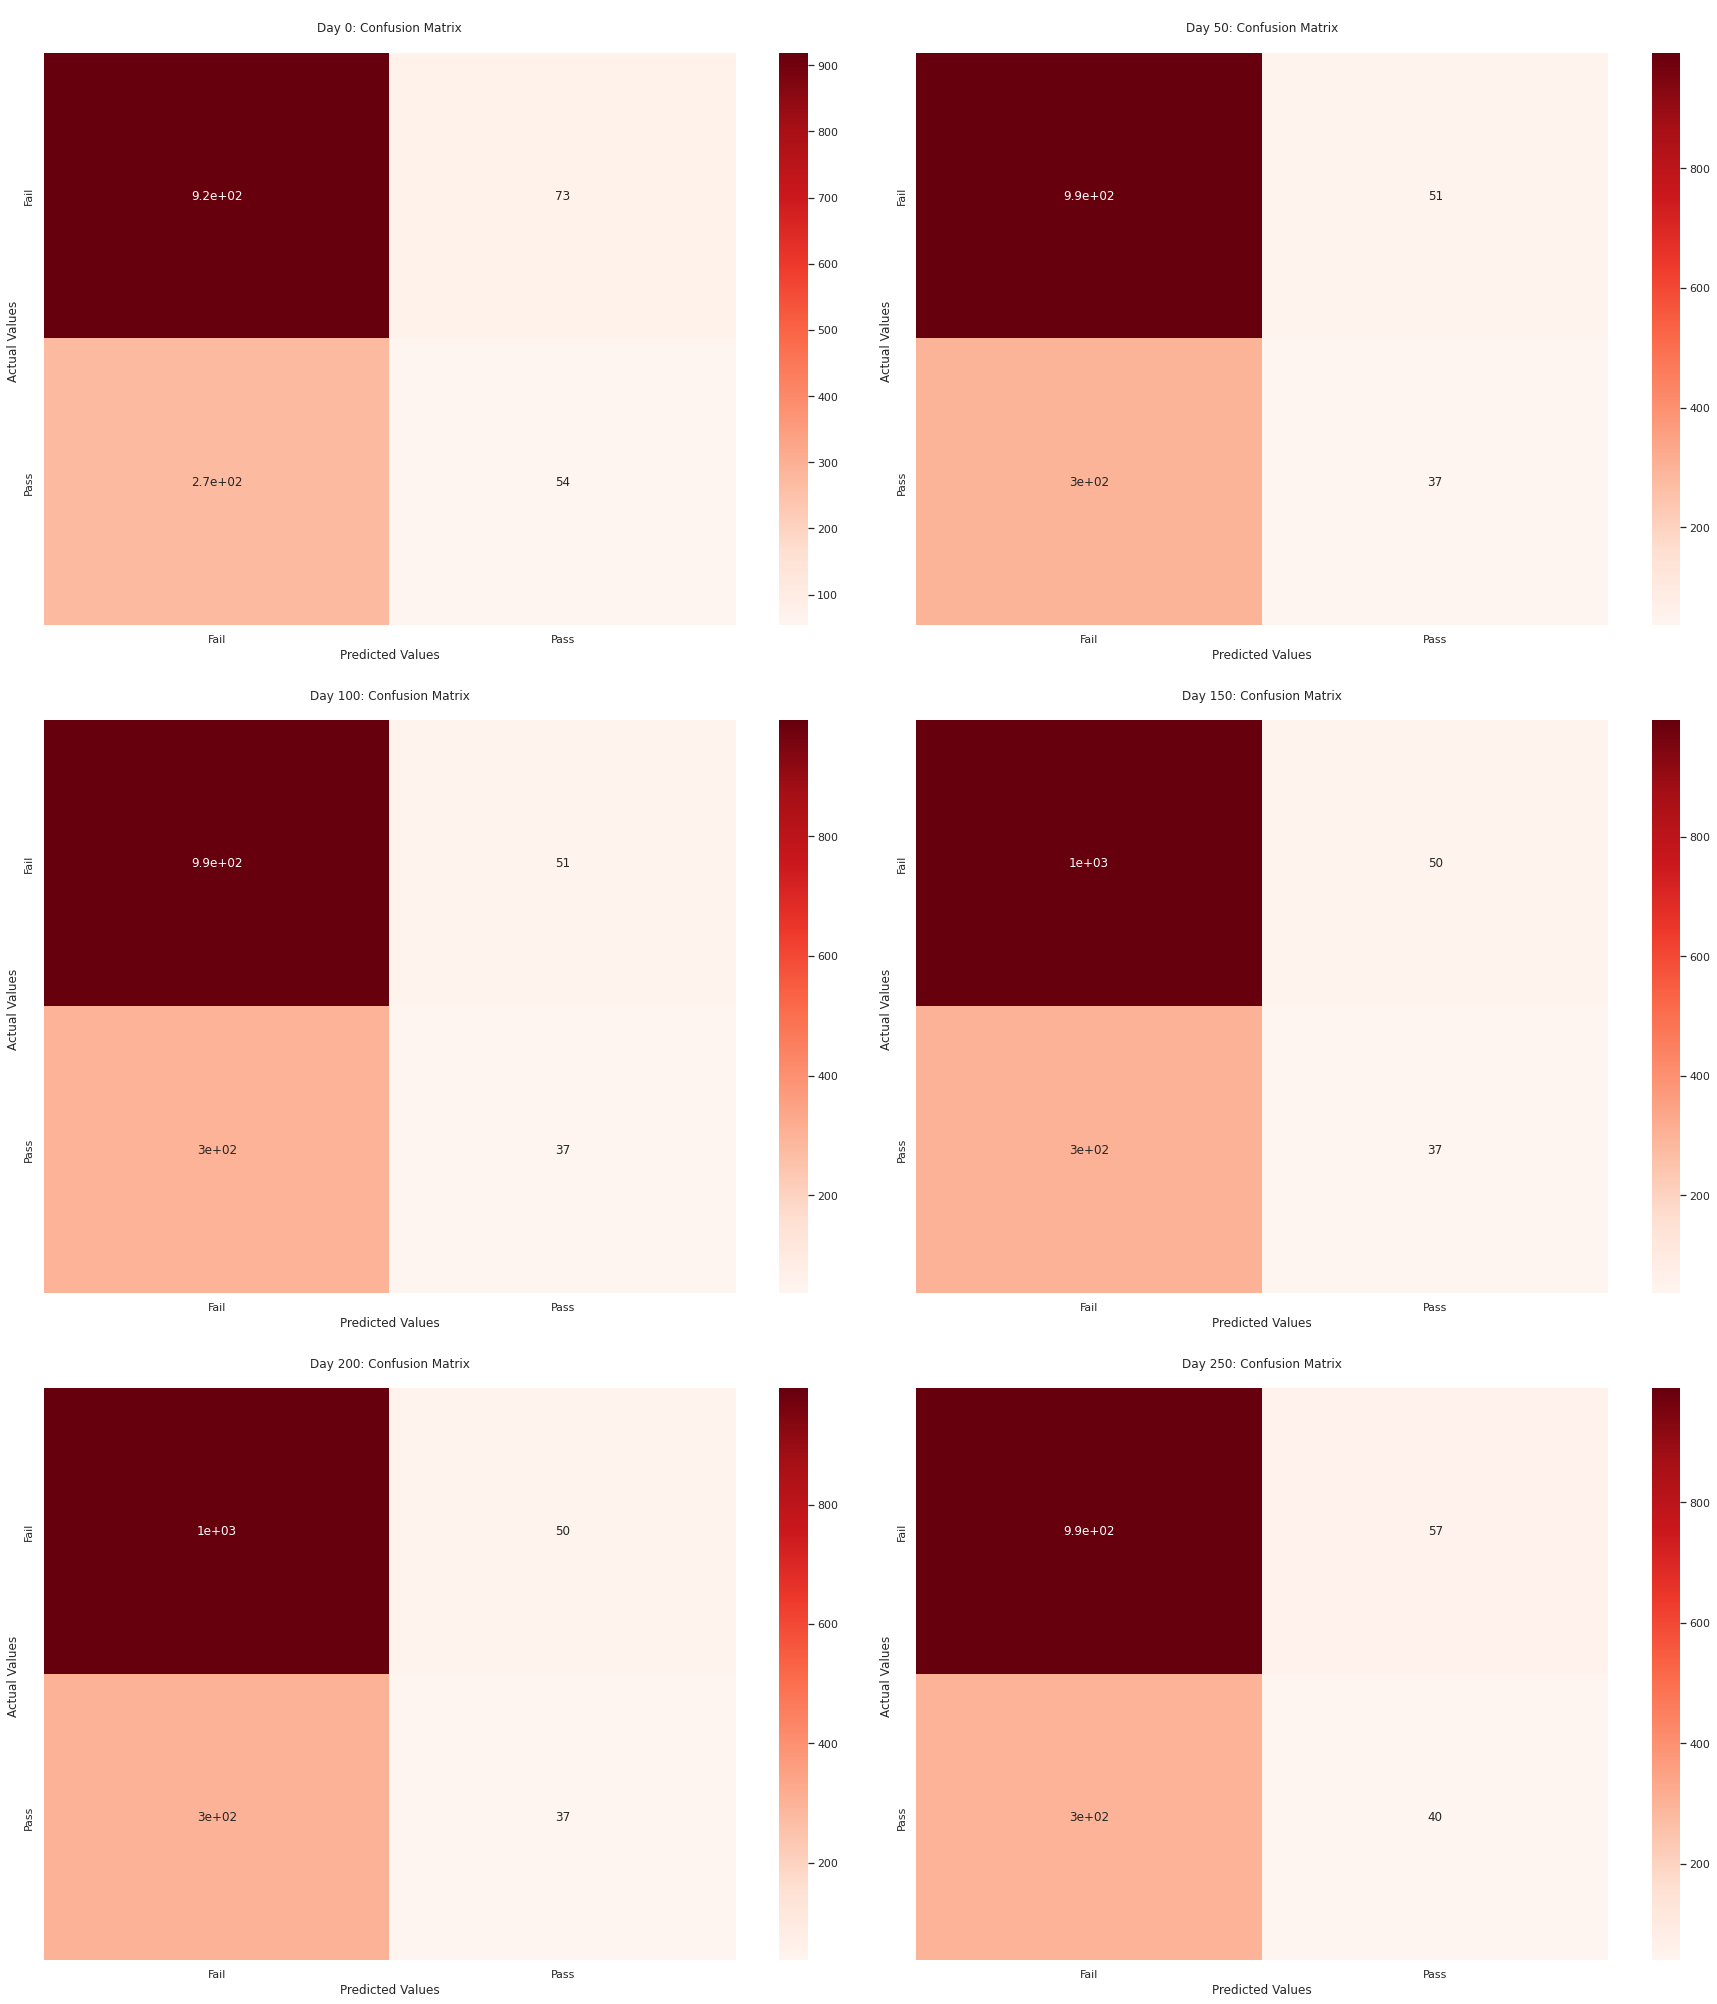

In [45]:
plot_confusion_matrix(demographic_results_ab)

##### Plot results overview

In [46]:
demographic_classifier_results = [demographic_results_du, demographic_results_nb, demographic_results_lr, demographic_results_lrw, demographic_results_rf, demographic_results_ab]
demographic_classifier_labels = ["Dummy Classifier","Naive Bayes", "Logistic Regression", "Logistic Regression Weighted", "Random Forest", "AdaBoost"]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-o

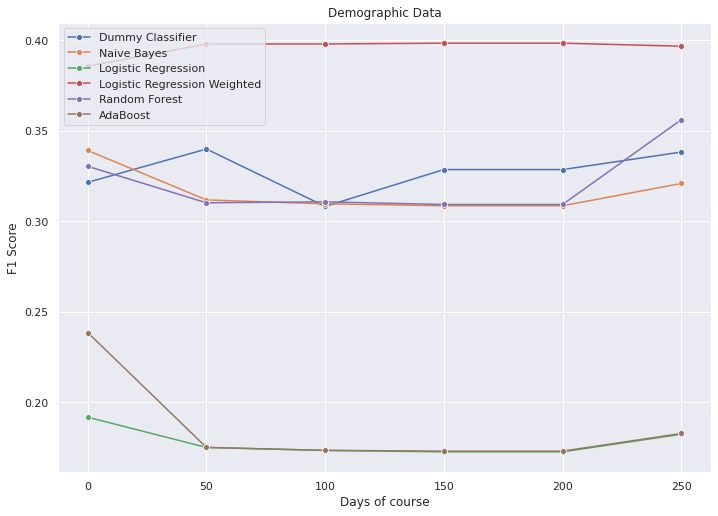

In [47]:
plot_days_compare(deadline_list,demographic_classifier_results,demographic_classifier_labels, "Demographic Data")

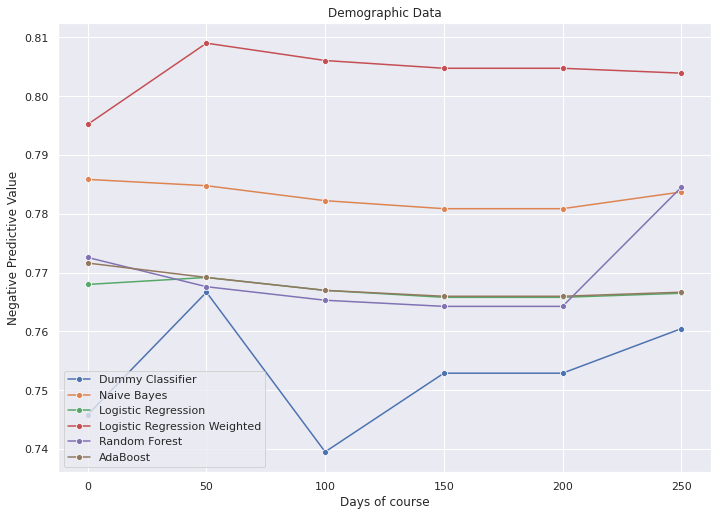

In [48]:
plot_days_compare_npv(deadline_list,demographic_classifier_results,demographic_classifier_labels, "Demographic Data")

#### Learning behaviour data

##### Prepare data for prediction

In [49]:
learning_behaviour_df = {}
for i in df.keys():
  learning_behaviour_df[i] = split_dataframe_by_data_type(df[i], ['learning_behaviour'], include_final_result=True)

In [50]:
learning_behaviour_df[0]

code_presentation  id_student   subpage   forumng  quiz  questionnaire  \
0                2013B       33915  1.857143  2.187500   1.0            0.0   
1                2013B       35544  1.000000  3.666667   0.0            0.0   
2                2013B       35860  1.545455  2.200000   0.0            0.0   
3                2013B       42668  1.000000  2.411765   0.0            0.0   
4                2013B       43273  0.000000  0.000000   0.0            0.0   
...                ...         ...       ...       ...   ...            ...   
4565             2014J     2681198  2.173913  2.775000  13.5            0.0   
4566             2014J     2682682  2.533333  6.666667   0.0            0.0   
4567             2014J     2683857  1.952381  1.333333   0.0            0.0   
4568             2014J     2693932  1.600000  1.666667   0.0            0.0   
4569             2014J     2697921  1.666667  0.000000   0.0            0.0   

      oucollaborate  homepage  resource  ouelluminate  htmlactivity  \
0               0.0  3.777778  1.000000           1.0           0.0   
1               0.0  3.000000  0.000000           0.0           0.0   
2               0.0  4.200000  1.000000           0.0           0.0   
3               0.0  2.625000  1.000000           0.0           0.0   
4               0.0  1.000000  0.000000           0.0           0.0   
...             ...       ...       ...           ...           ...   
4565            0.0  6.642857  1.142857           0.0           3.0   
4566            1.0  4.400000  1.000000           0.0           1.0   
4567            0.0  7.000000  1.250000           0.0           2.0   
4568            0.0  4.750000  1.000000           0.0           1.0   
4569            0.0  7.000000  1.000000           0.0           1.0   

      oucontent  ouwiki  glossary  mean_click  dualpane    url  page  \
0      3.416667     0.0       0.0    0.902172       0.0  1.000   1.0   
1      0.000000     0.0       0.0    0.425926       0.0  0.000   0.0   
2      3.500000     0.0       0.0    0.802525       0.0  1.000   1.0   
3      5.000000     0.0       0.0    0.724265       0.0  0.000   1.0   
4      0.000000     0.0       0.0    0.055556       0.0  0.000   0.0   
...         ...     ...       ...         ...       ...    ...   ...   
4565   3.666667     4.0       1.0    2.237572       0.0  1.375   1.0   
4566   4.222222     0.0       0.0    1.267901       0.0  1.000   1.0   
4567   4.700000     0.0       0.0    1.124206       0.0  1.000   1.0   
4568   9.600000     0.0       0.0    1.173148       0.0  1.500   0.0   
4569   4.250000     0.0       0.0    0.828704       0.0  0.000   0.0   

      final_result  
0                0  
1                0  
2                0  
3                0  
4                0  
...            ...  
4565             0  
4566             0  
4567             0  
4568             0  
4569             0  

[4570 rows x 19 columns]

###### Encode data

In [51]:
X_train, X_test, Y_train, Y_test = encode_data(learning_behaviour_df, ["2013J"], "2014J")

Index([], dtype='object') Index(['subpage', 'forumng', 'quiz', 'questionnaire', 'oucollaborate',
       'homepage', 'resource', 'oucontent', 'ouwiki', 'glossary', 'mean_click',
       'dualpane', 'url', 'page'],
      dtype='object')
Index([], dtype='object') Index(['subpage', 'forumng', 'quiz', 'questionnaire', 'oucollaborate',
       'homepage', 'resource', 'oucontent', 'ouwiki', 'glossary', 'mean_click',
       'dualpane', 'url', 'page'],
      dtype='object')
Index([], dtype='object') Index(['subpage', 'forumng', 'repeatactivity', 'quiz', 'questionnaire',
       'oucollaborate', 'homepage', 'resource', 'oucontent', 'ouwiki',
       'glossary', 'mean_click', 'dualpane', 'url', 'page'],
      dtype='object')
Index([], dtype='object') Index(['quiz', 'questionnaire', 'dataplus', 'mean_click', 'repeatactivity',
       'ouwiki', 'subpage', 'oucollaborate', 'homepage', 'resource', 'folder',
       'glossary', 'dualpane', 'forumng', 'oucontent', 'url', 'page'],
      dtype='object')
Index(

###### Undersampling

In [52]:
Y_train[0].value_counts()

0    984
1    407
Name: final_result, dtype: int64

In [53]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks

from collections import Counter

X_train_sample, Y_train_sample = {},{}

for i in df.keys():

  sampler = RandomUnderSampler() # fit predictor and target variable
  X_train_sample[i], Y_train_sample[i] = sampler.fit_resample(X_train[i], Y_train[i])

  print(f"Sampling for day {i}")
  print('Original dataset shape:', Counter(Y_train[i]))
  print('Resample dataset shape', Counter(Y_train_sample[i]))

Sampling for day 0
Original dataset shape: Counter({0: 984, 1: 407})
Resample dataset shape Counter({0: 407, 1: 407})
Sampling for day 50
Original dataset shape: Counter({0: 1028, 1: 418})
Resample dataset shape Counter({0: 418, 1: 418})
Sampling for day 100
Original dataset shape: Counter({0: 1028, 1: 418})
Resample dataset shape Counter({0: 418, 1: 418})
Sampling for day 150
Original dataset shape: Counter({0: 1028, 1: 419})
Resample dataset shape Counter({0: 419, 1: 419})
Sampling for day 200
Original dataset shape: Counter({0: 1028, 1: 419})
Resample dataset shape Counter({0: 419, 1: 419})
Sampling for day 250
Original dataset shape: Counter({0: 1028, 1: 425})
Resample dataset shape Counter({0: 425, 1: 425})


###### Feature selection

In [54]:
for i in df.keys():
  feature_selection_transformer = SelectKBest(score_func=f_classif, k=5)

  X_train[i] = pd.DataFrame(feature_selection_transformer.fit_transform(X_train[i], Y_train[i]),
          columns=list(feature_selection_transformer.get_feature_names_out().tolist()),
          index=X_train[i].index)
  
  X_test[i] = pd.DataFrame(feature_selection_transformer.transform(X_test[i]),
          columns=list(feature_selection_transformer.get_feature_names_out().tolist()),
          index=X_test[i].index)

In [55]:
X_train[250]

quiz  questionnaire  dataplus  mean_click    folder
1074  0.212644       0.000000  0.000000    0.290539  0.000000
1075  0.205107       0.403846  0.228571    0.408801  0.333333
1076  0.289655       0.416667  0.000000    0.314375  0.000000
1077  0.167488       0.375000  0.000000    0.302567  0.000000
1078  0.215654       0.390625  0.155556    0.334175  0.333333
...        ...            ...       ...         ...       ...
2522  0.375642       0.000000  0.000000    0.372705  0.541667
2523  0.022989       0.375000  0.000000    0.303721  0.000000
2524  0.000000       0.000000  0.000000    0.048945  0.000000
2525  0.422153       0.000000  0.000000    0.383681  0.333333
2526  0.261303       0.000000  0.000000    0.303726  0.500000

[1453 rows x 5 columns]

##### DummyClassifier

In [56]:
from sklearn.dummy import DummyClassifier

learning_behaviour_results_du = []
learning_behaviour_features_du = []

pipeline = Pipeline([
    ('clf', DummyClassifier(strategy="uniform",random_state=RANDOM_SEED)),
])

params = {
}

for i in df.keys():
  print(f"Day {i}")
  grid_search = GridSearchCV(pipeline , param_grid=params , n_jobs=-1, verbose=1, scoring='f1_macro', cv=3,)
  print("Performing grid search...")
  print("pipeline:", [name for name, _ in pipeline.steps])
  print("parameters:")
  print(params)
  tuned_model = grid_search.fit(X_train[i], Y_train[i])

  print("Best score: %0.3f" % grid_search.best_score_)
  print("Best parameters set:")
  best_parameters = grid_search.best_estimator_.get_params()
  for param_name in sorted(params.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

  predictions = tuned_model.predict(X_test[i])


  acc, f1, prec, recall, conf = evaluation_summary(predictions, Y_test[i])
  print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
  learning_behaviour_results_du.append([acc, f1, prec, recall, conf])
  learning_behaviour_features_du.append([tuned_model, X_test[i], Y_test[i]])
  print("\n")

Day 0
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.470
Best parameters set:
Accuracy: 0.4939301972685888, F1 Score: 0.3214649033570702, Precision: 0.2404870624048706, Recall: 0.48466257668711654


Day 50
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.433
Best parameters set:
Accuracy: 0.5097897026831038, F1 Score: 0.33984375, Precision: 0.2525399129172714, Recall: 0.5194029850746269


Day 100
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.433
Best parameters set:
Accuracy: 0.4841040462427746, F1 Score: 0.3081395348837209, Precision: 0.22943722943722944, Recall: 0.4690265486725664


Day 150
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.433
Best param

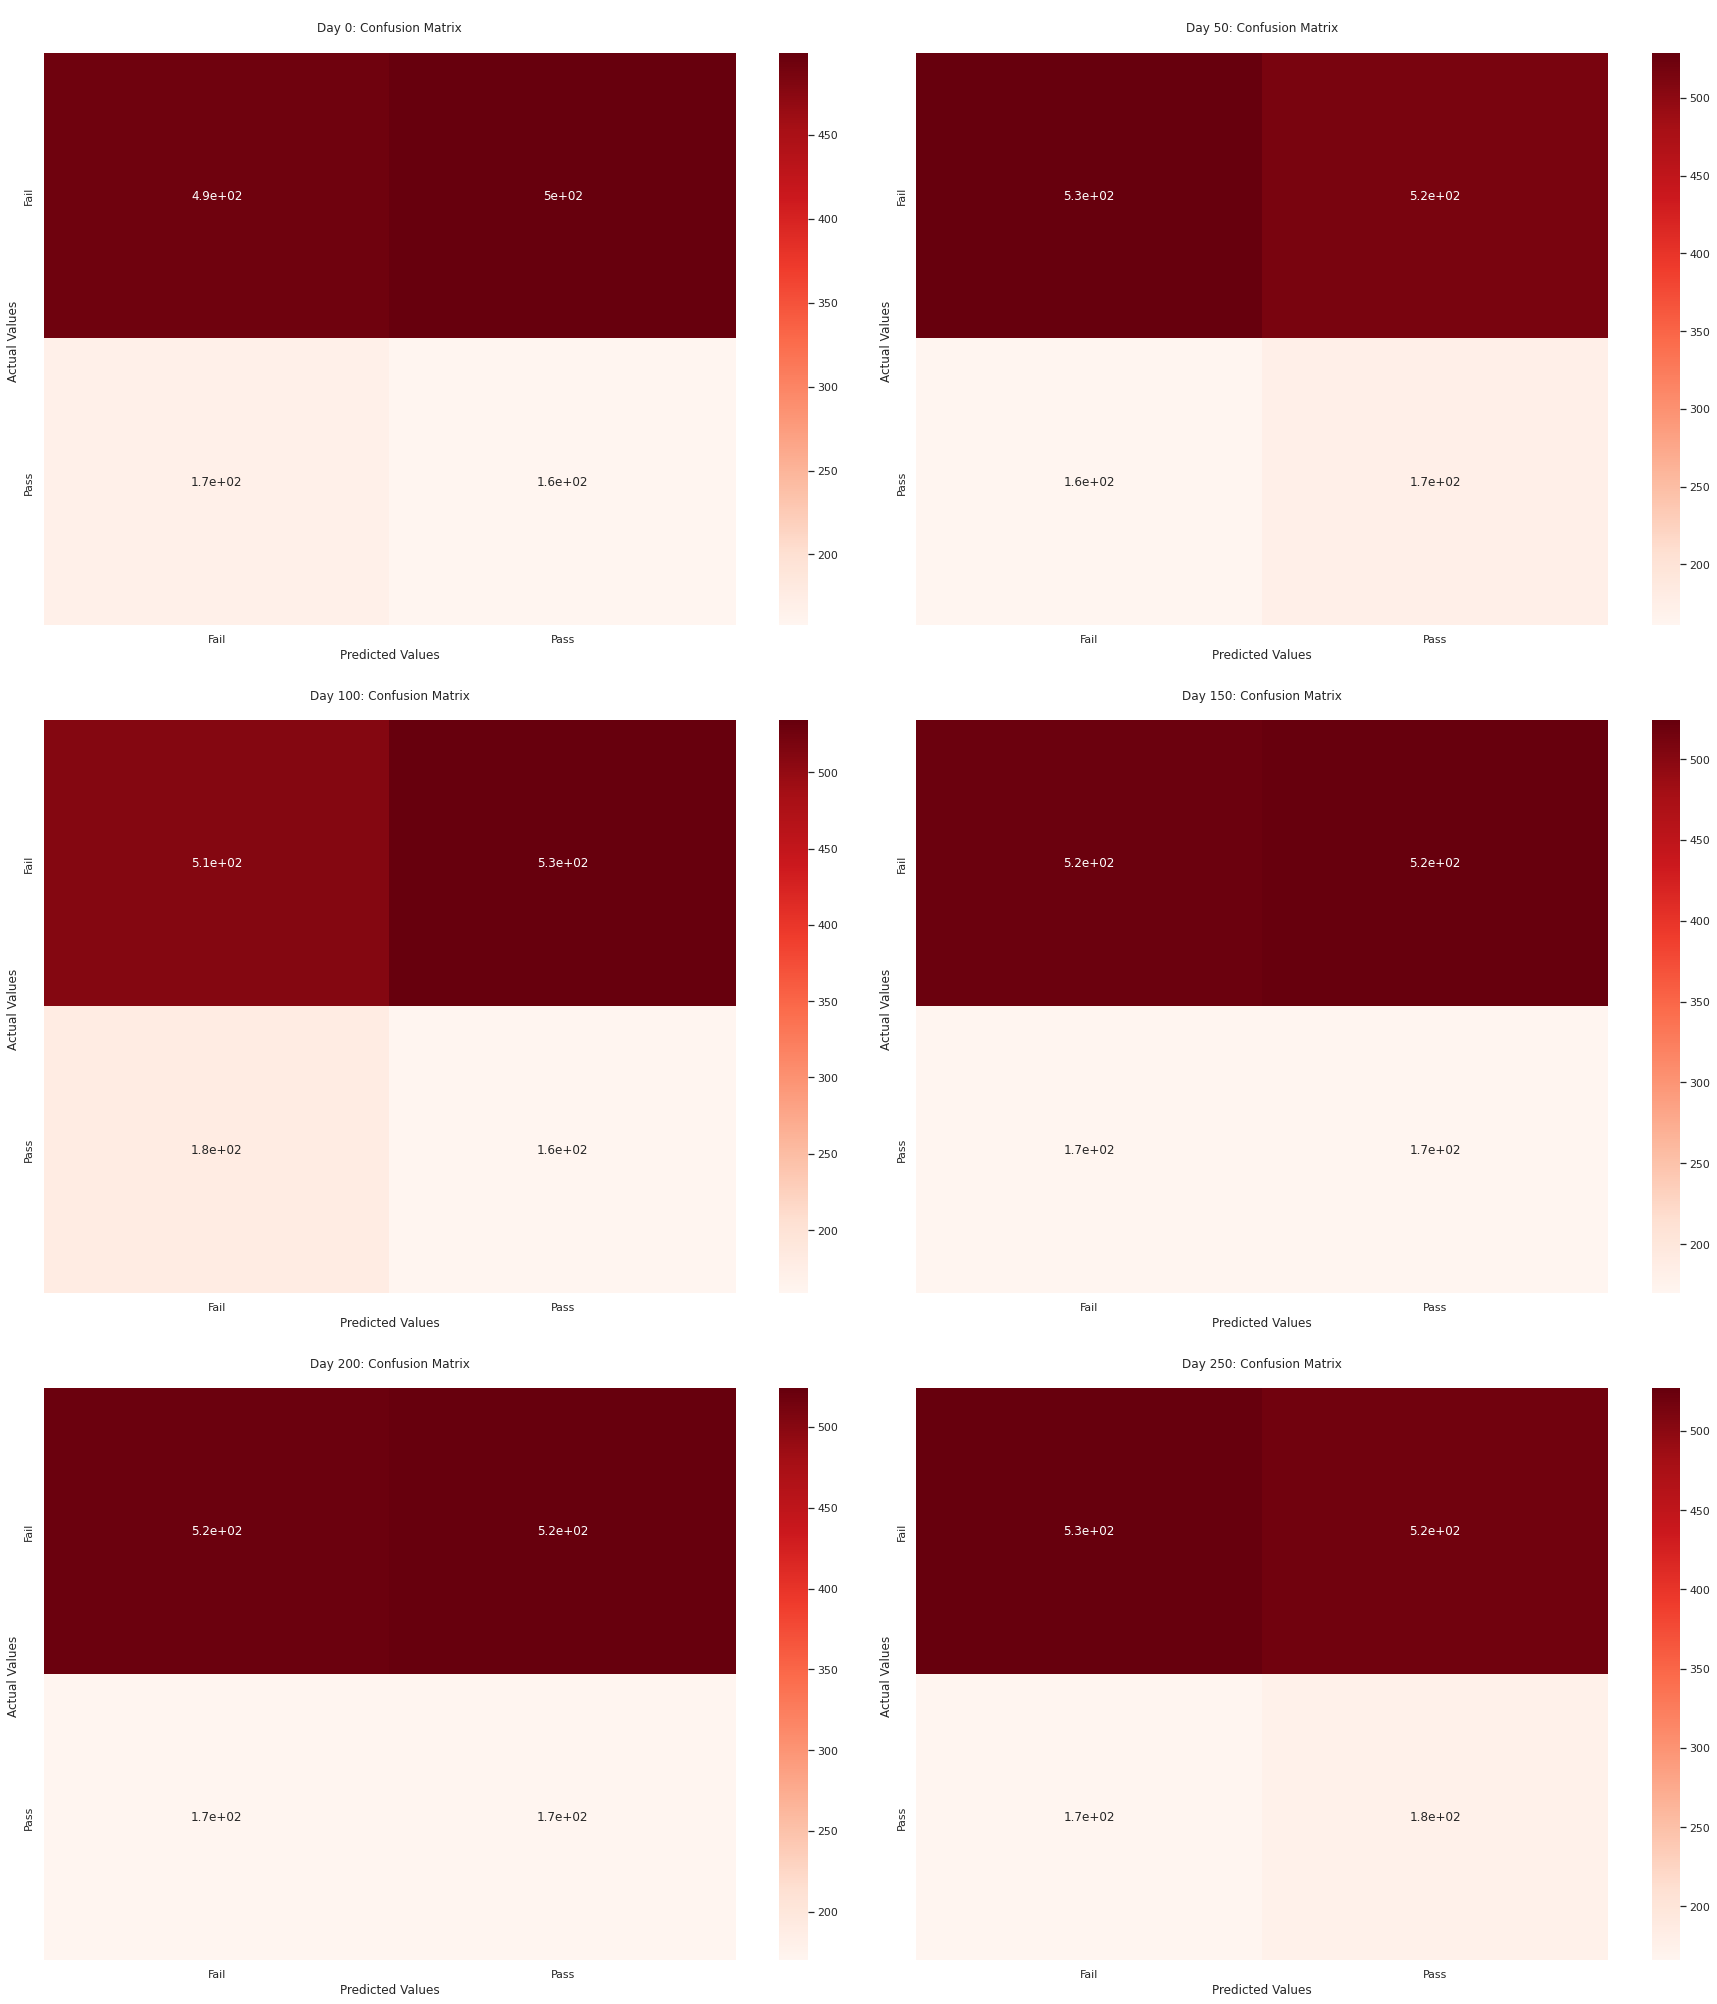

In [57]:
plot_confusion_matrix(learning_behaviour_results_du)

##### NaiveBayes

In [58]:
from sklearn.naive_bayes import GaussianNB,ComplementNB,BernoulliNB,MultinomialNB

learning_behaviour_results_nb = []
learning_behaviour_features_nb = []

pipeline = Pipeline([
    ('clf', ComplementNB()),
])

params = {
  #'clf__class_weight':({0:2,1:1},{0:3,1:1},{0:1.5,1:1})
}

for i in df.keys():
  print(f"Day {i}")
  grid_search = GridSearchCV(pipeline , param_grid=params , n_jobs=-1, verbose=1, scoring='f1_macro', cv=3,)
  print("Performing grid search...")
  print("pipeline:", [name for name, _ in pipeline.steps])
  print("parameters:")
  print(params)
  tuned_model = grid_search.fit(X_train[i], Y_train[i])

  print("Best score: %0.3f" % grid_search.best_score_)
  print("Best parameters set:")
  best_parameters = grid_search.best_estimator_.get_params()
  for param_name in sorted(params.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

  predictions = tuned_model.predict(X_test[i])


  acc, f1, prec, recall, conf = evaluation_summary(predictions, Y_test[i])
  print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
  learning_behaviour_results_nb.append([acc, f1, prec, recall, conf])
  learning_behaviour_features_nb.append([tuned_model, X_test[i], Y_test[i]])
  print("\n")


Day 0
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.495
Best parameters set:
Accuracy: 0.4317147192716237, F1 Score: 0.39056143205858423, Precision: 0.26578073089701, Recall: 0.7361963190184049


Day 50
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.635
Best parameters set:
Accuracy: 0.5373459028281363, F1 Score: 0.4480968858131488, Precision: 0.315468940316687, Recall: 0.7731343283582089


Day 100
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.657
Best parameters set:
Accuracy: 0.5252890173410405, F1 Score: 0.4446322907861369, Precision: 0.31161137440758296, Recall: 0.775811209439528


Day 150
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.663
Best p

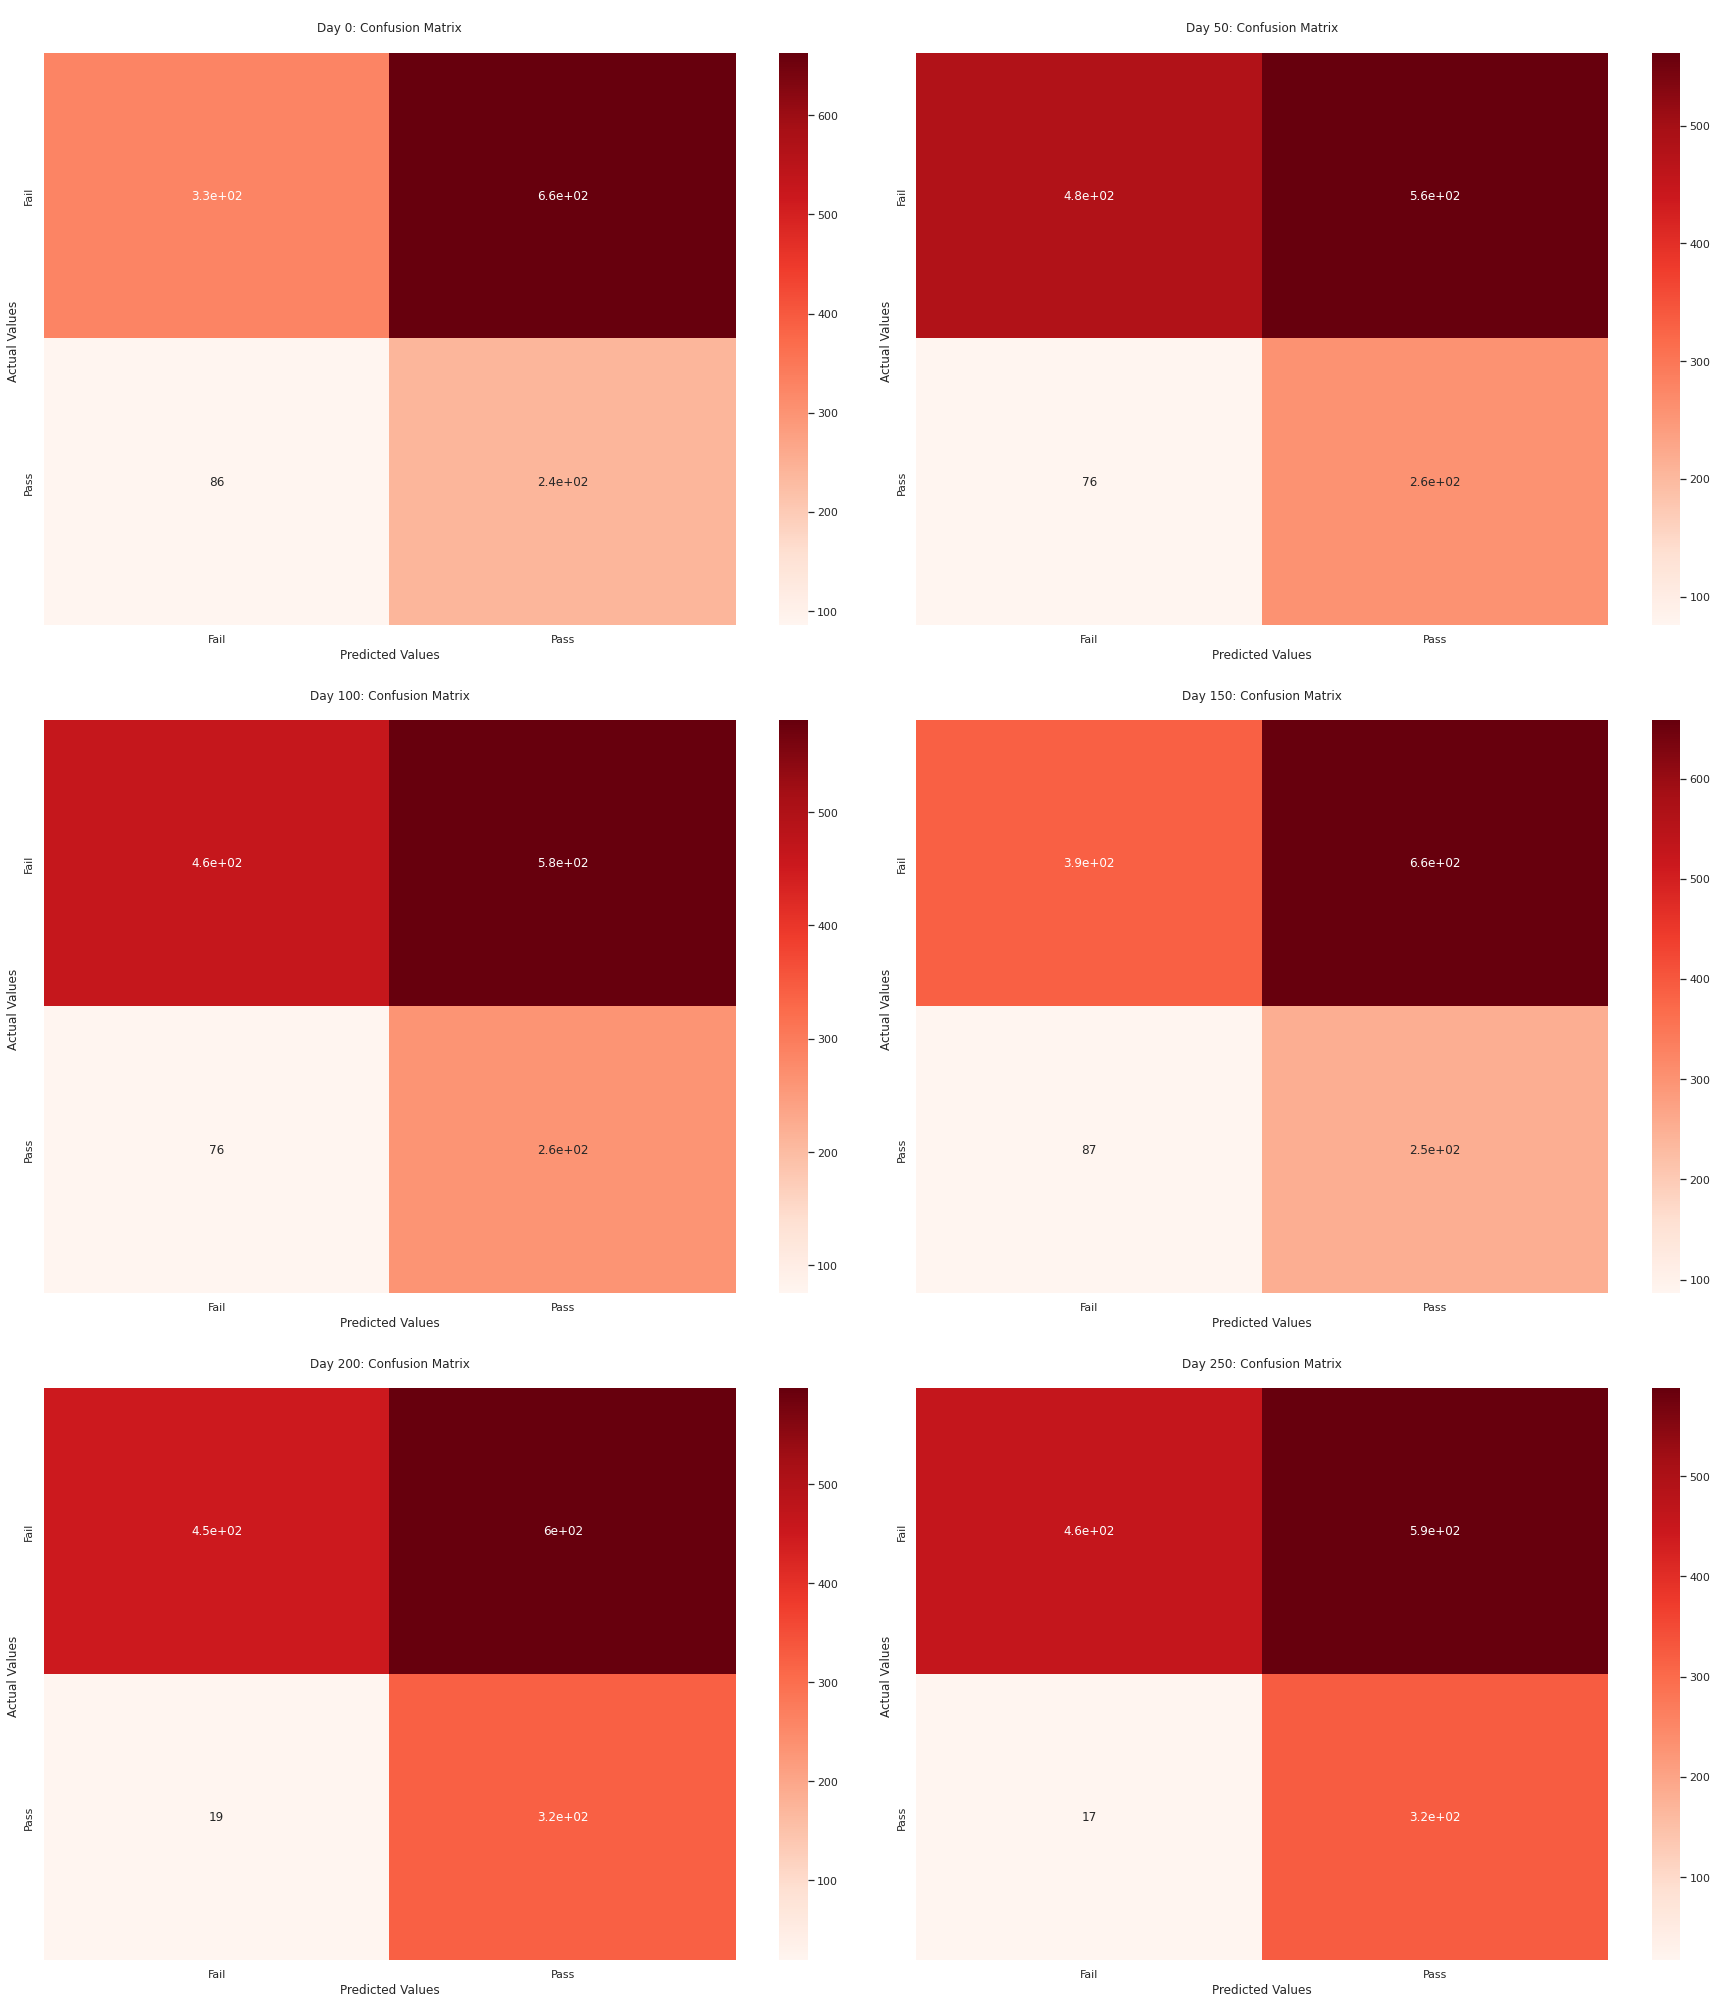

In [59]:
plot_confusion_matrix(learning_behaviour_results_nb)

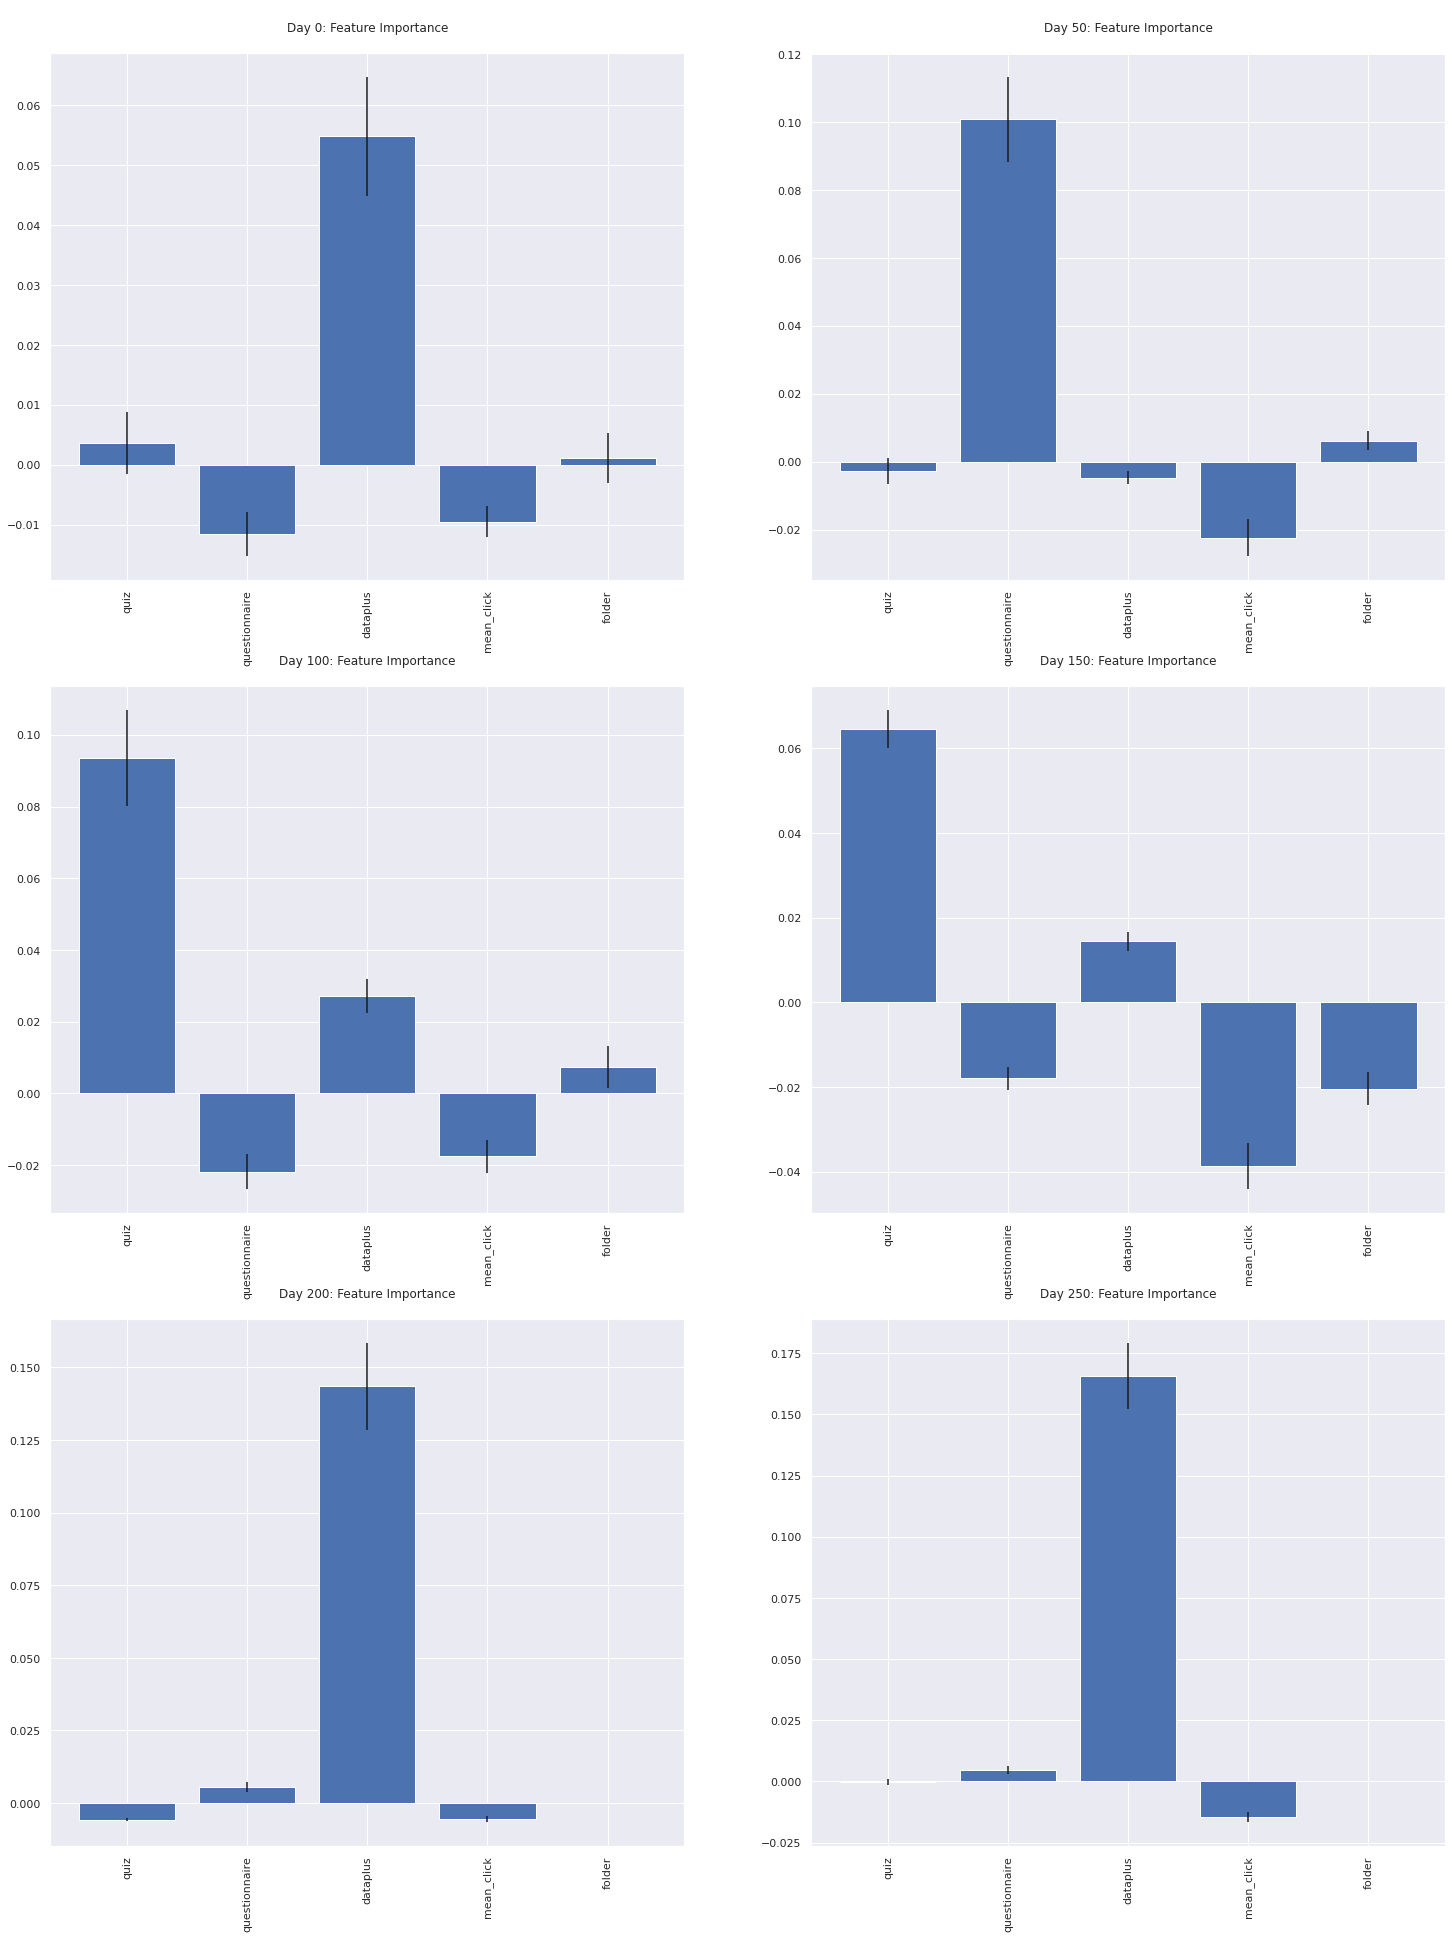

In [60]:
plot_feature_importance(learning_behaviour_features_nb)

##### LogisticRegression

In [61]:
from sklearn.linear_model import LogisticRegression

learning_behaviour_results_lr = []
learning_behiviour_features_lr = []

pipeline = Pipeline([
    ('clf', LogisticRegression()),
])

params = {
  'clf__penalty': ['l2', 'none']
}

for i in df.keys():
  print(f"Day {i}")
  grid_search = GridSearchCV(pipeline , param_grid=params , n_jobs=-1, verbose=1, scoring='f1_macro', cv=3,)
  print("Performing grid search...")
  print("pipeline:", [name for name, _ in pipeline.steps])
  print("parameters:")
  print(params)
  tuned_model = grid_search.fit(X_train[i], Y_train[i])

  print("Best score: %0.3f" % grid_search.best_score_)
  print("Best parameters set:")
  best_parameters = grid_search.best_estimator_.get_params()
  for param_name in sorted(params.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

  predictions = tuned_model.predict(X_test[i])


  acc, f1, prec, recall, conf = evaluation_summary(predictions, Y_test[i])
  print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
  learning_behaviour_results_lr.append([acc, f1, prec, recall, conf])
  learning_behiviour_features_lr.append([tuned_model, X_test[i], Y_test[i]])
  print("\n")


Day 0
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__penalty': ['l2', 'none']}
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Best score: 0.414
Best parameters set:
	clf__penalty: 'l2'
Accuracy: 0.7526555386949925, F1 Score: 0.0, Precision: 0.0, Recall: 0.0


Day 50
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__penalty': ['l2', 'none']}
Fitting 3 folds for each of 2 candidates, totalling 6 fits


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Best score: 0.634
Best parameters set:
	clf__penalty: 'none'
Accuracy: 0.7737490935460478, F1 Score: 0.4507042253521127, Precision: 0.5493562231759657, Recall: 0.382089552238806


Day 100
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__penalty': ['l2', 'none']}
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Best score: 0.655
Best parameters set:
	clf__penalty: 'none'
Accuracy: 0.7644508670520231, F1 Score: 0.4436860068259386, Precision: 0.5263157894736842, Recall: 0.3834808259587021


Day 150
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__penalty': ['l2', 'none']}
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Best score: 0.669
Best parameters set:
	clf__penalty: 'none'
Accuracy: 0.7792207792207793, F1 Score: 0.4631578947368421, Precision: 0.5764192139737991, Recall: 0.3870967741935484


Day 200
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__penalty': ['l2', 'none']}
Fitting 3 folds for each of 2 candidates, totalli

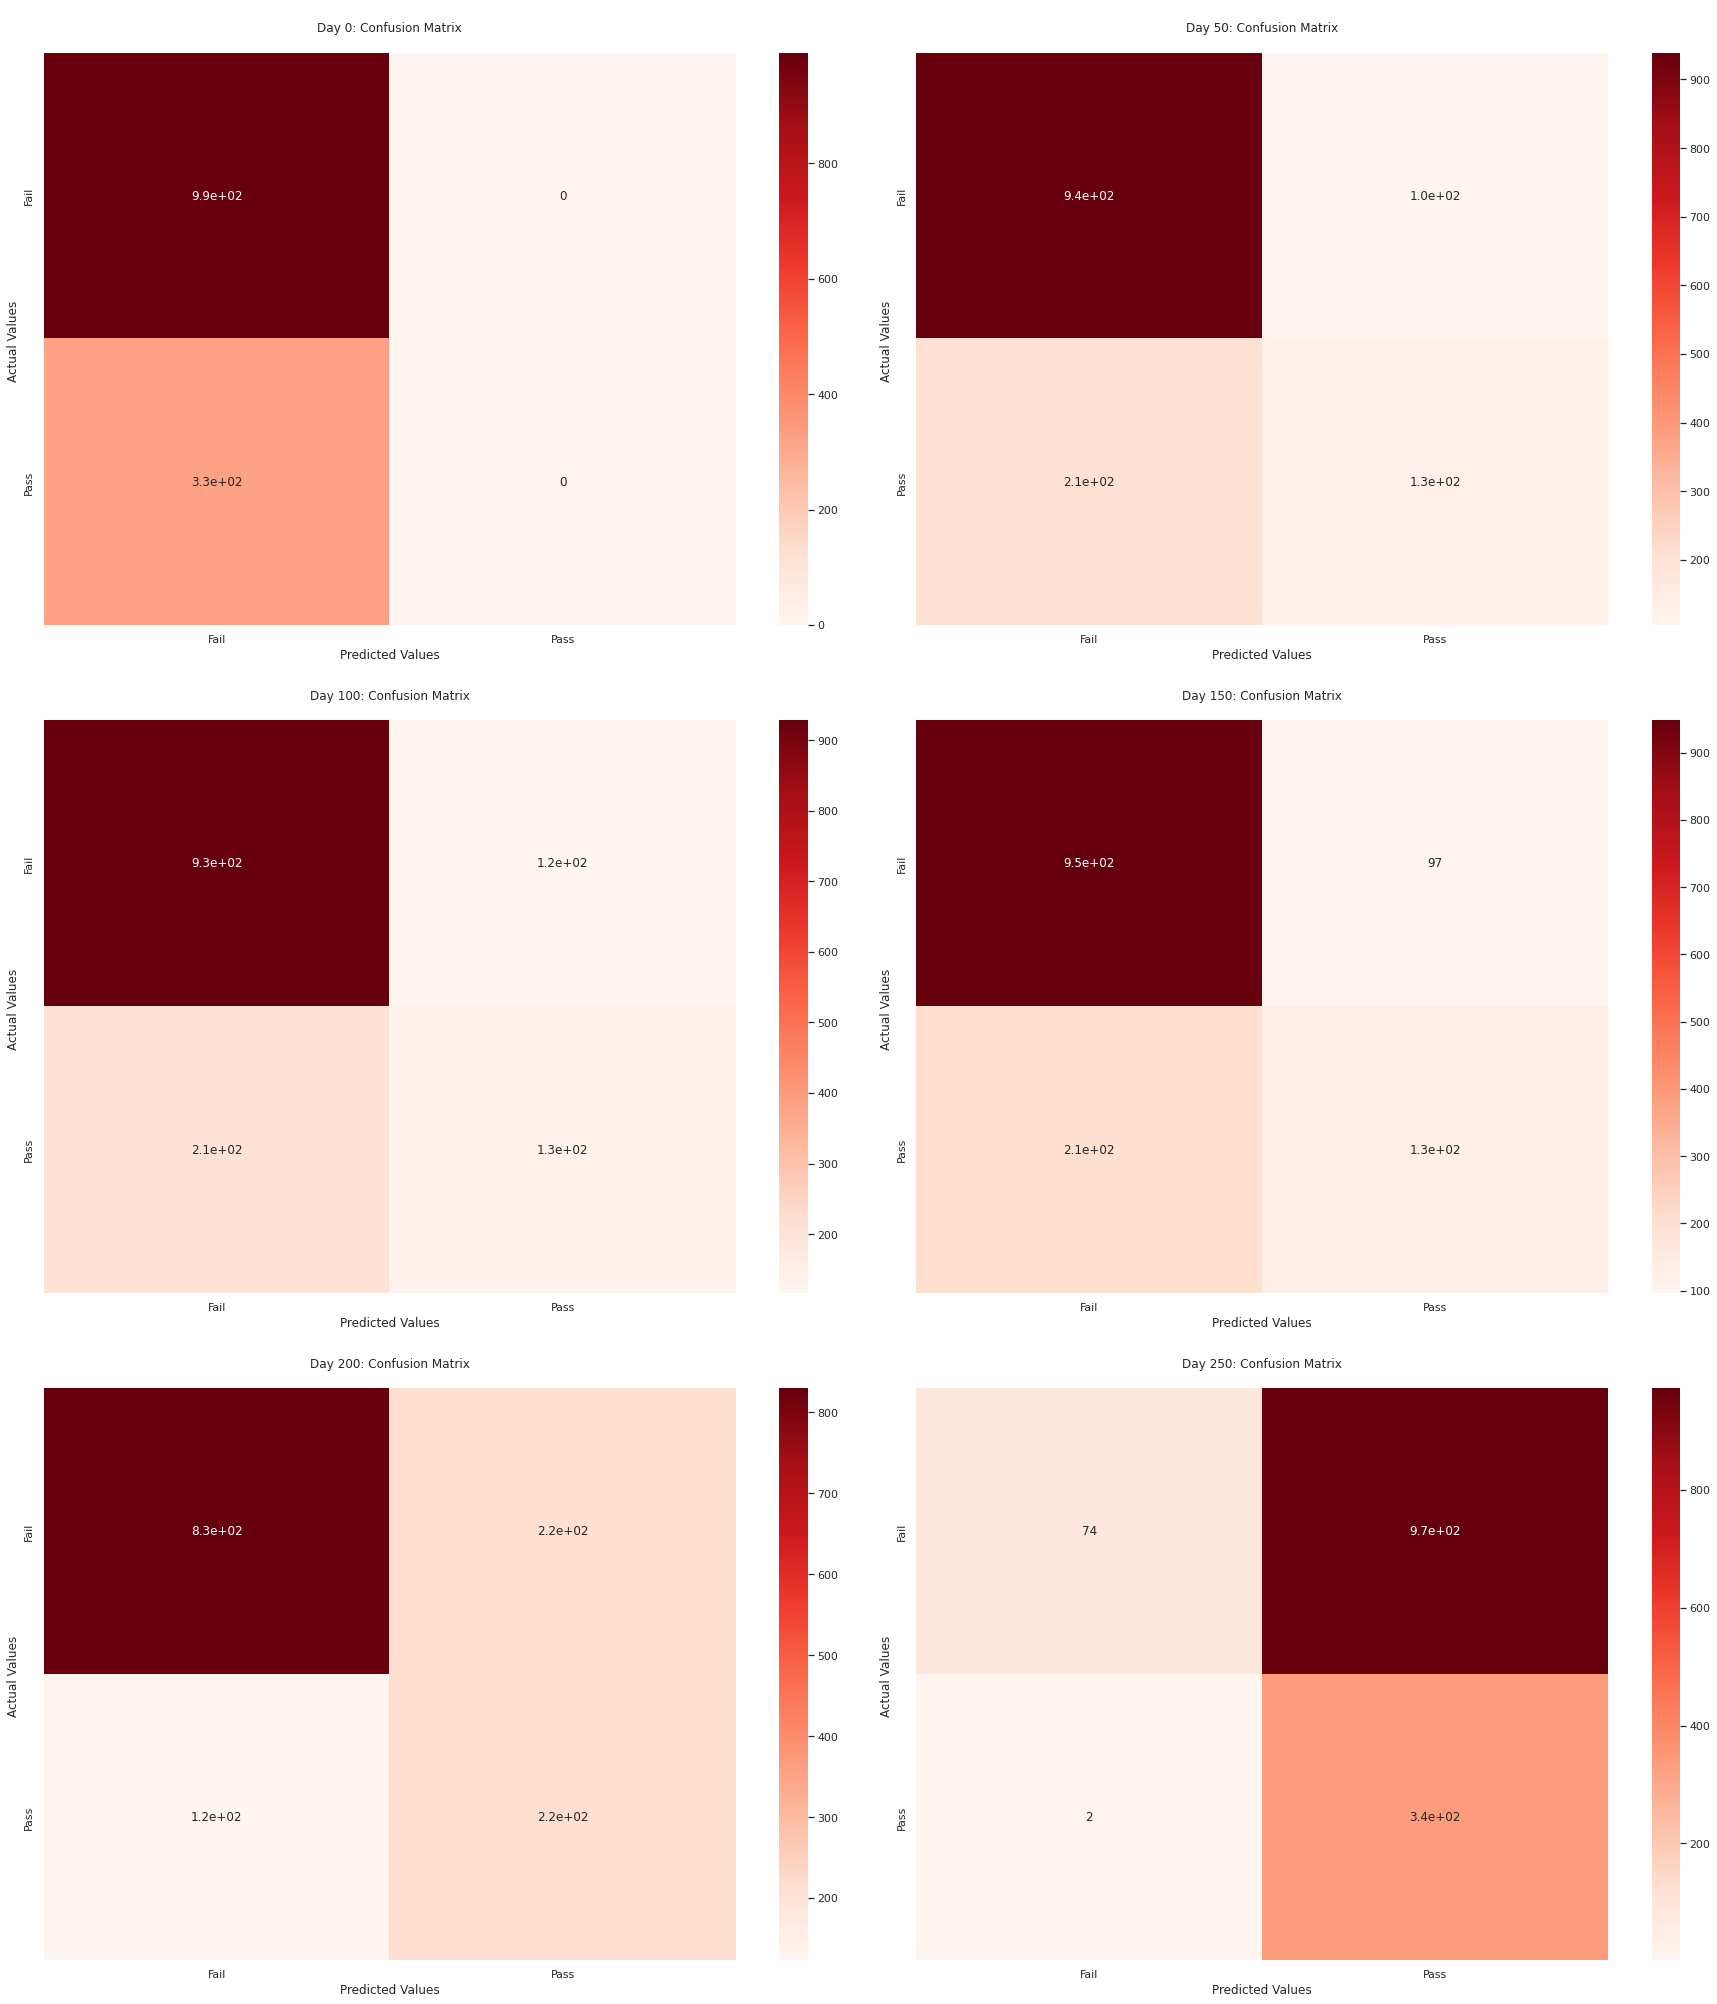

In [62]:
plot_confusion_matrix(learning_behaviour_results_lr)

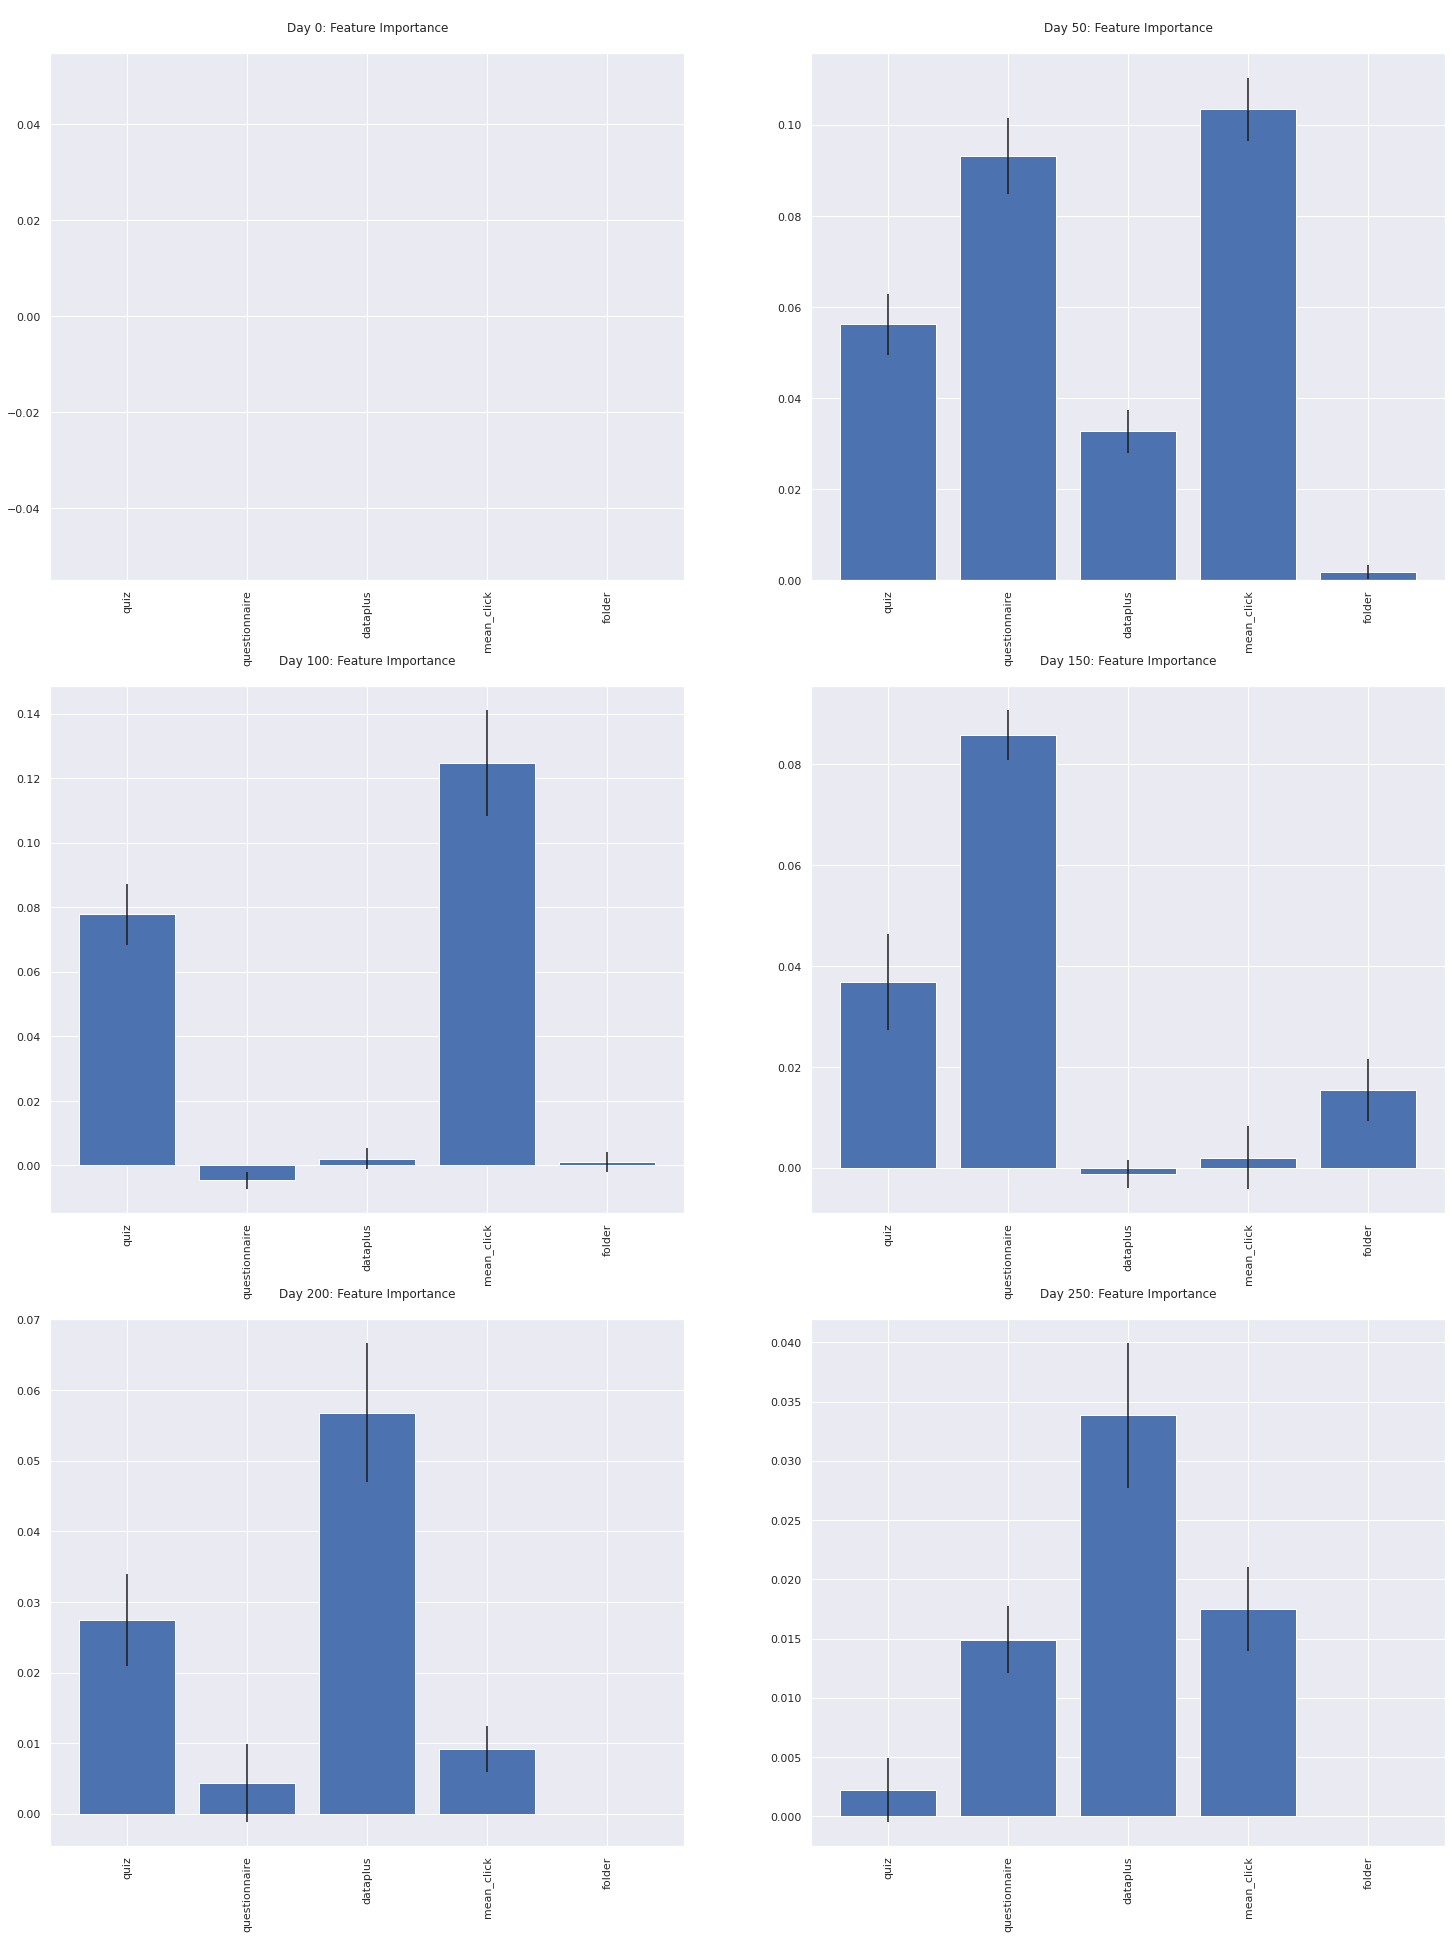

In [63]:
plot_feature_importance(learning_behiviour_features_lr)

##### WeightedLogisticRegression

In [64]:
learning_behaviour_results_lrw = []
learning_behaviour_features_lrw = []

pipeline = Pipeline([
    ('clf', LogisticRegression(class_weight = 'balanced')),
])

params = {
}

for i in df.keys():
  print(f"Day {i}")
  grid_search = GridSearchCV(pipeline , param_grid=params , n_jobs=-1, verbose=1, scoring='f1_macro', cv=3,)
  print("Performing grid search...")
  print("pipeline:", [name for name, _ in pipeline.steps])
  print("parameters:")
  print(params)
  tuned_model = grid_search.fit(X_train[i], Y_train[i])

  print("Best score: %0.3f" % grid_search.best_score_)
  print("Best parameters set:")
  best_parameters = grid_search.best_estimator_.get_params()
  for param_name in sorted(params.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

  predictions = tuned_model.predict(X_test[i])


  acc, f1, prec, recall, conf = evaluation_summary(predictions, Y_test[i])
  print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
  learning_behaviour_results_lrw.append([acc, f1, prec, recall, conf])
  learning_behaviour_features_lrw.append([tuned_model, X_test[i], Y_test[i]])

  print("\n")

Day 0
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.589
Best parameters set:
Accuracy: 0.5887708649468892, F1 Score: 0.45799999999999996, Precision: 0.3397626112759644, Recall: 0.7024539877300614


Day 50
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.667
Best parameters set:
Accuracy: 0.6446700507614214, F1 Score: 0.48202959830866815, Precision: 0.37315875613747956, Recall: 0.6805970149253732


Day 100
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.677
Best parameters set:
Accuracy: 0.6459537572254336, F1 Score: 0.4969199178644764, Precision: 0.38110236220472443, Recall: 0.7138643067846607


Day 150
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.693


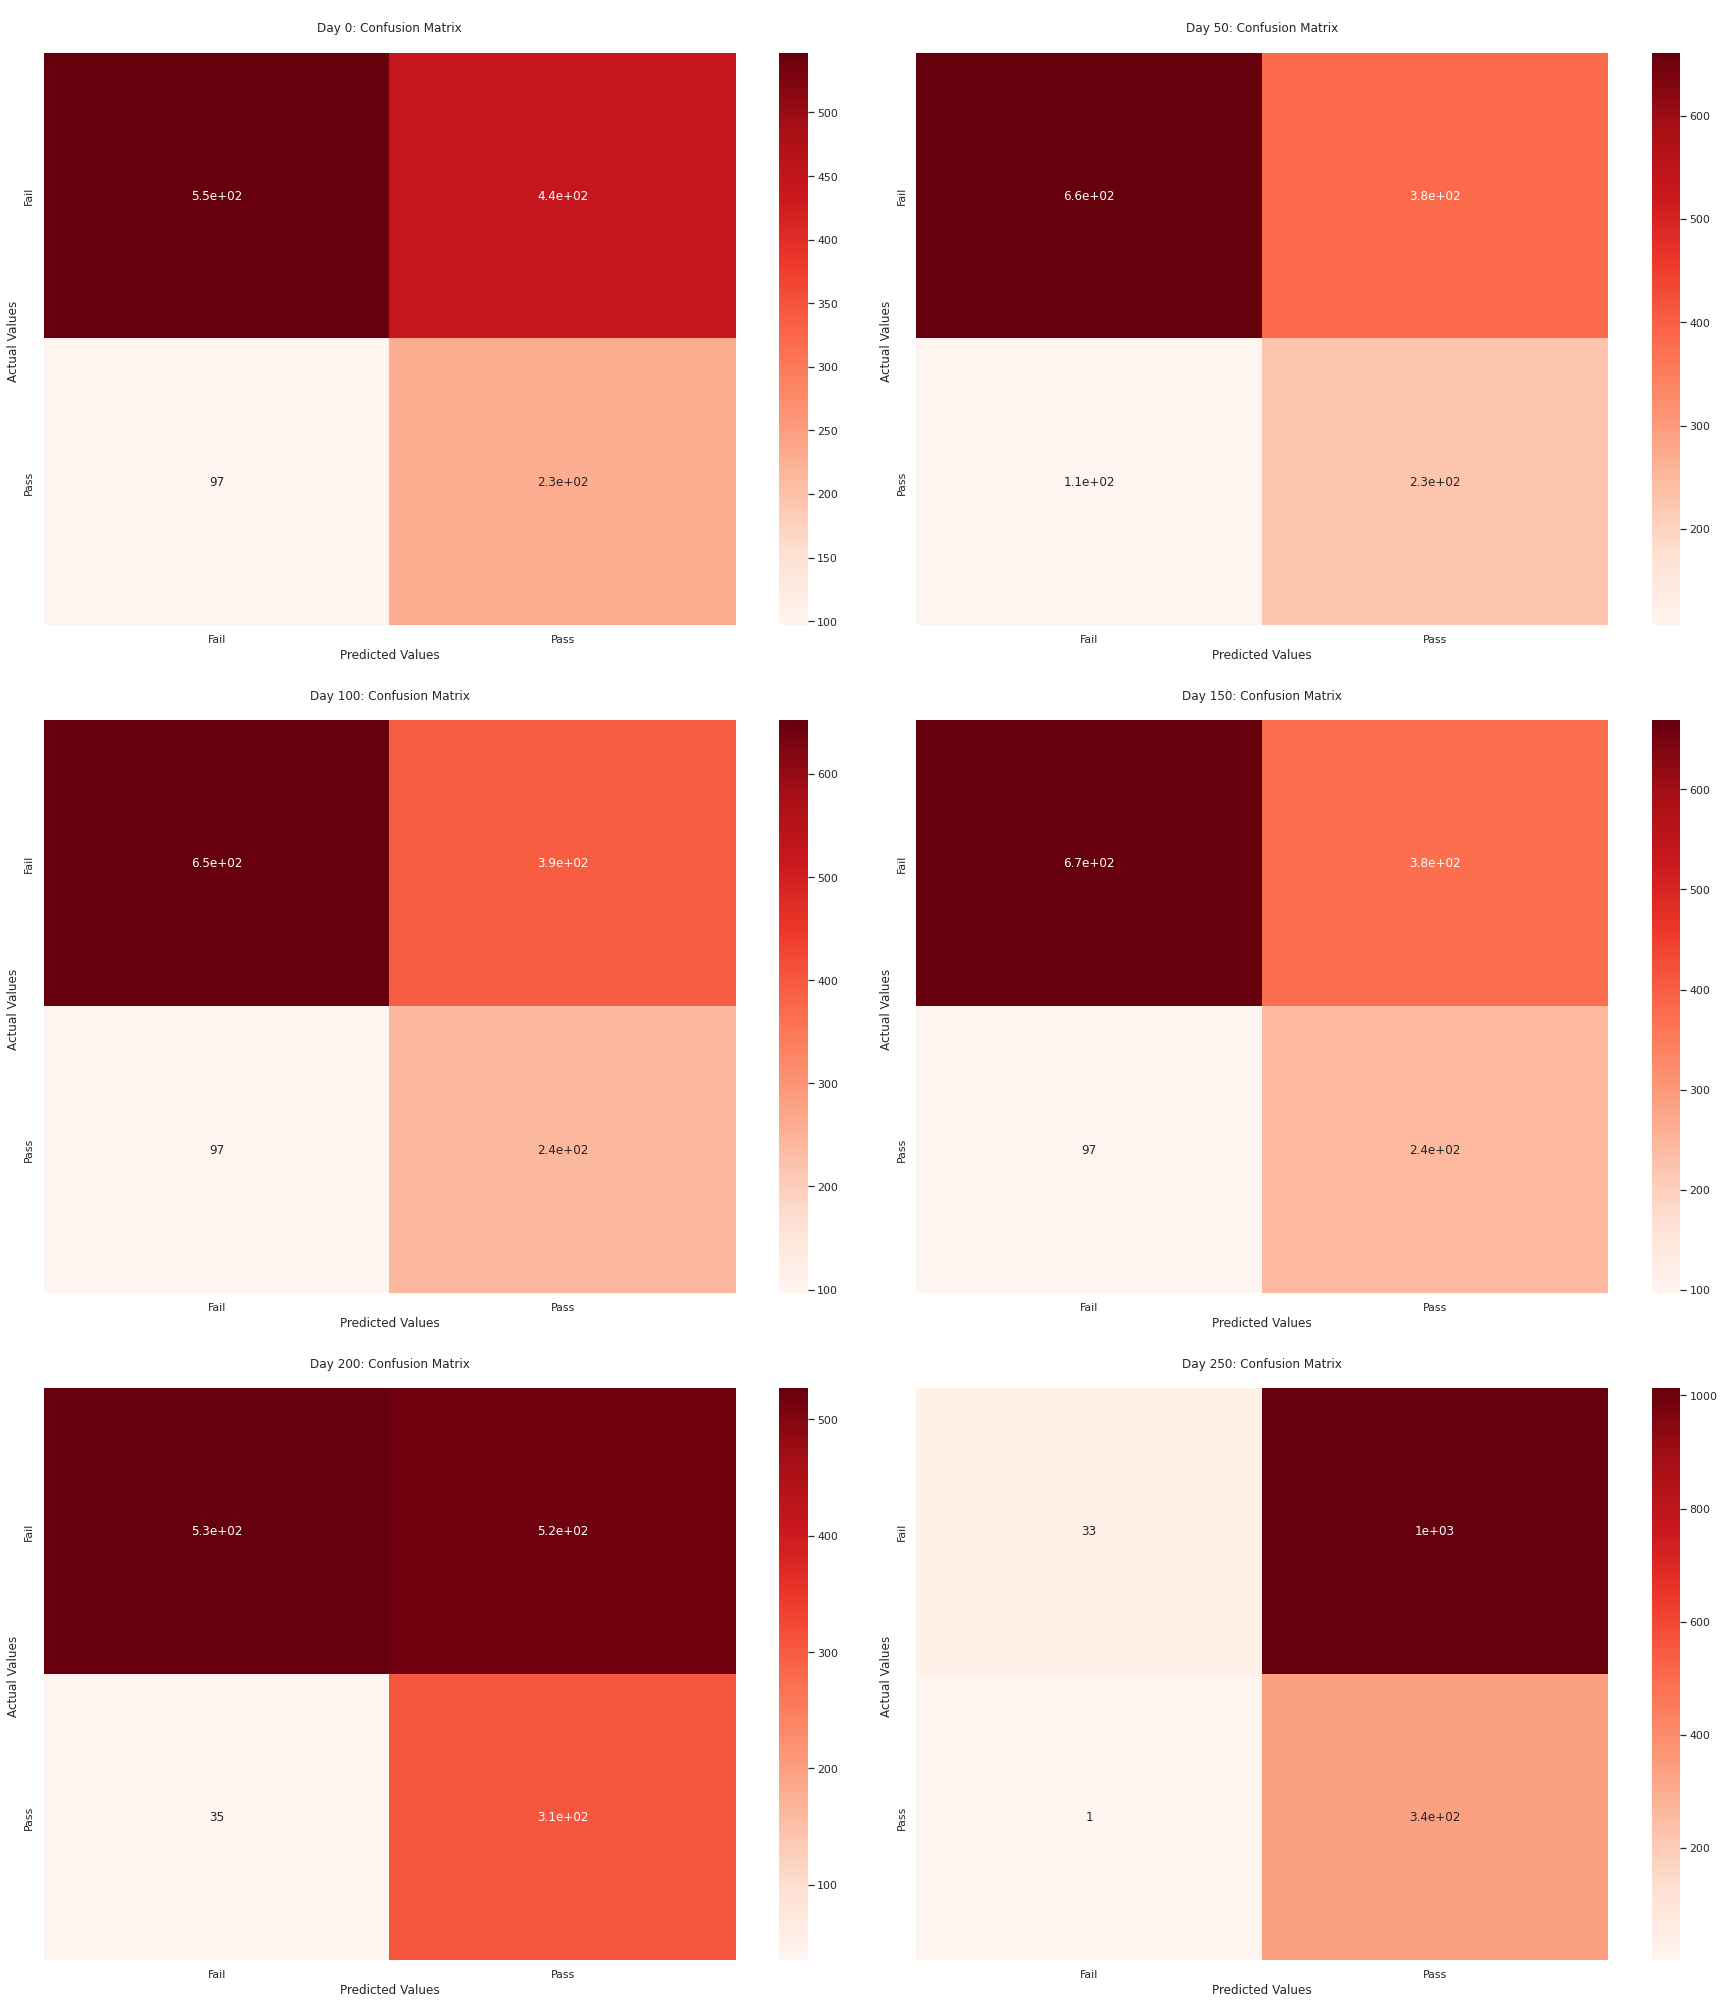

In [65]:
plot_confusion_matrix(learning_behaviour_results_lrw)

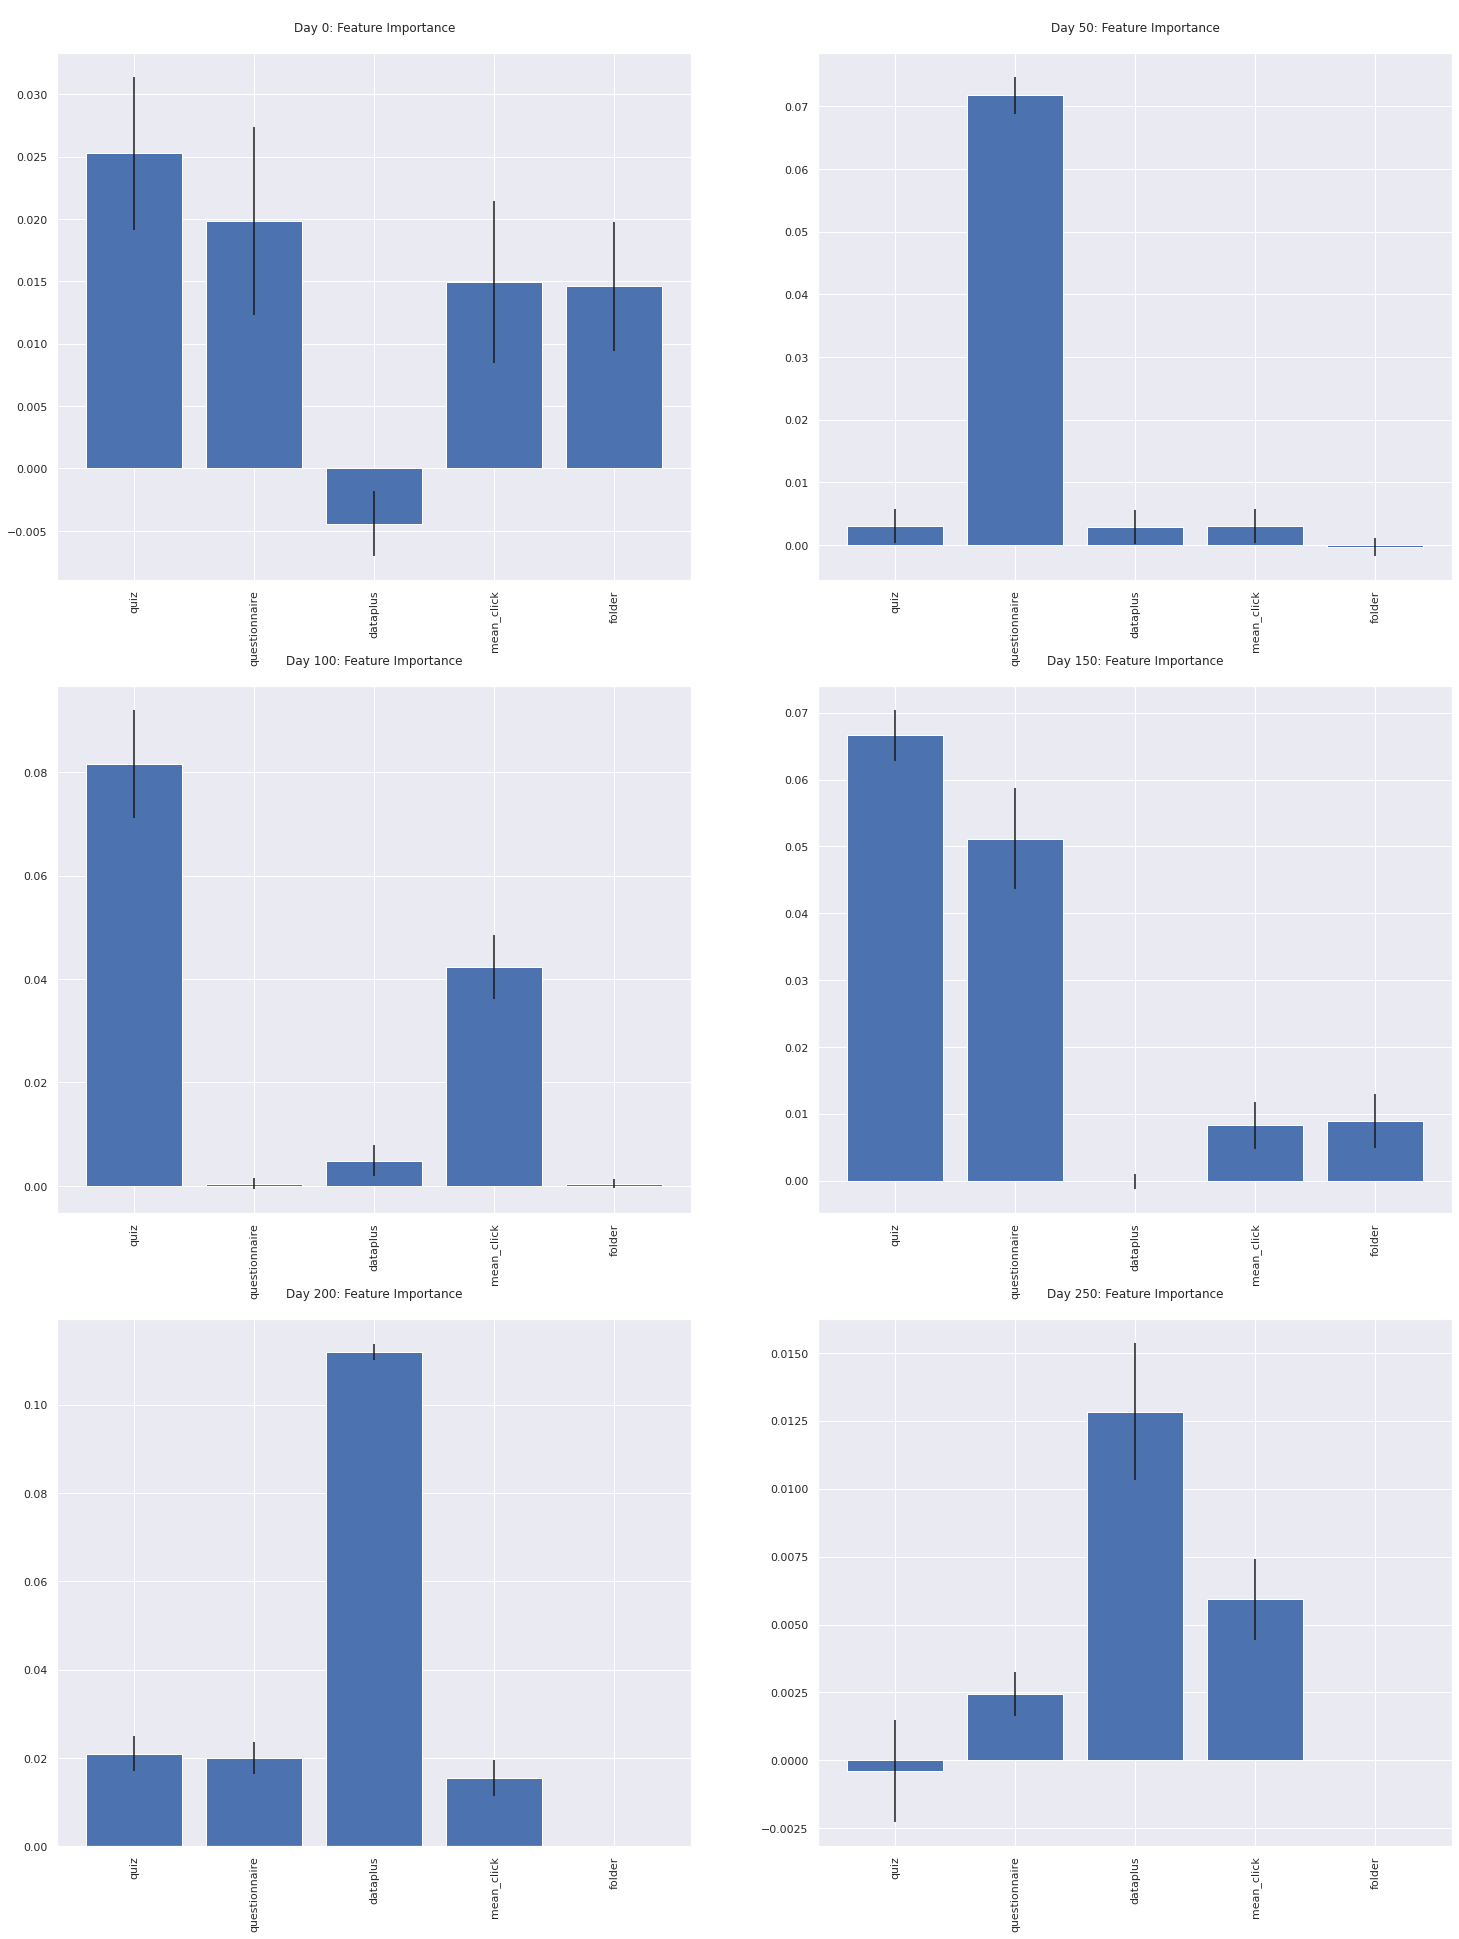

In [66]:
plot_feature_importance(learning_behaviour_features_lrw)

##### RandomForest

In [67]:
from sklearn.ensemble import RandomForestClassifier

learning_behaviour_results_rf = []
learning_behaviour_features_rf = []

pipeline = Pipeline([
    ('clf', RandomForestClassifier(random_state=RANDOM_SEED, class_weight = 'balanced')),
])

params = {
  'clf__n_estimators': [x for x in range(50,150,10)]
}

for i in df.keys():
  print(f"Day {i}")
  grid_search = GridSearchCV(pipeline , param_grid=params , n_jobs=-1, verbose=1, scoring='f1_macro', cv=3,)
  print("Performing grid search...")
  print("pipeline:", [name for name, _ in pipeline.steps])
  print("parameters:")
  print(params)
  tuned_model = grid_search.fit(X_train[i], Y_train[i])

  print("Best score: %0.3f" % grid_search.best_score_)
  print("Best parameters set:")
  best_parameters = grid_search.best_estimator_.get_params()
  for param_name in sorted(params.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

  predictions = tuned_model.predict(X_test[i])


  acc, f1, prec, recall, conf = evaluation_summary(predictions, Y_test[i])
  print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
  learning_behaviour_results_rf.append([acc, f1, prec, recall, conf])
  learning_behaviour_features_rf.append([tuned_model, X_test[i], Y_test[i]])
  print("\n")

Day 0
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__n_estimators': [50, 60, 70, 80, 90, 100, 110, 120, 130, 140]}
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best score: 0.566
Best parameters set:
	clf__n_estimators: 130
Accuracy: 0.6836115326251897, F1 Score: 0.31074380165289256, Precision: 0.33691756272401435, Recall: 0.2883435582822086


Day 50
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__n_estimators': [50, 60, 70, 80, 90, 100, 110, 120, 130, 140]}
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best score: 0.606
Best parameters set:
	clf__n_estimators: 130
Accuracy: 0.7302393038433648, F1 Score: 0.3881578947368421, Precision: 0.43223443223443225, Recall: 0.3522388059701492


Day 100
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__n_estimators': [50, 60, 70, 80, 90, 100, 110, 120, 130, 140]}
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best score: 0.613
Best parameters set:
	clf__n_estim

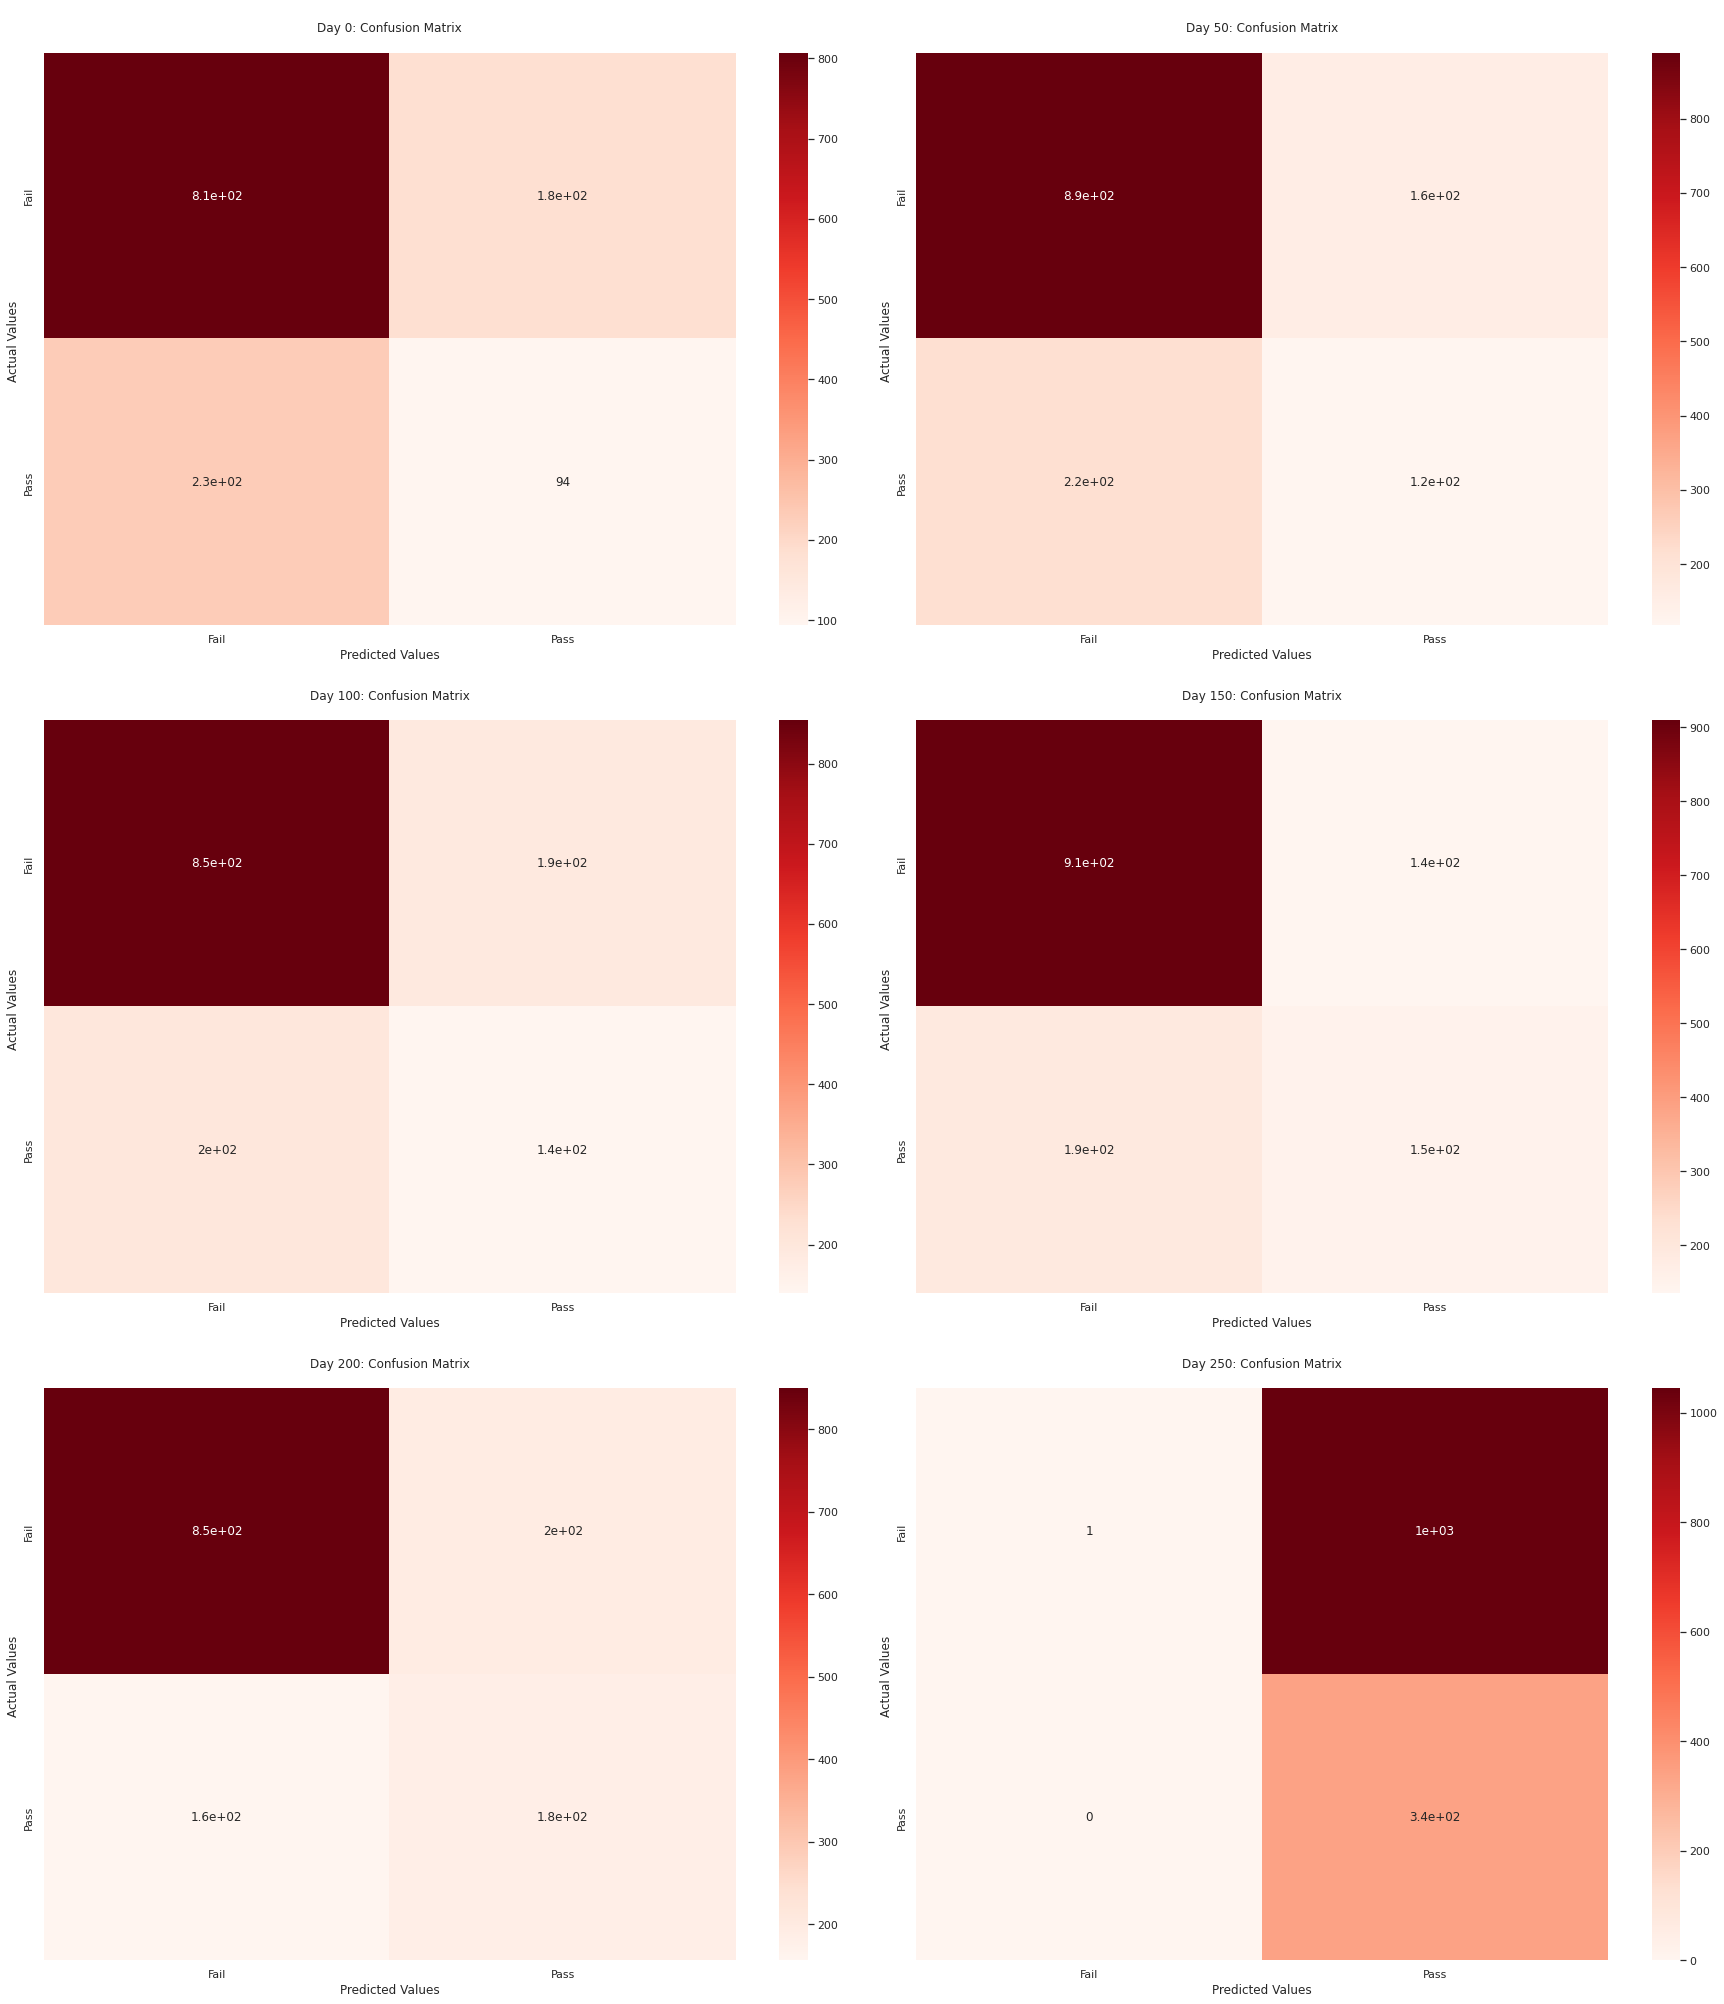

In [68]:
plot_confusion_matrix(learning_behaviour_results_rf)

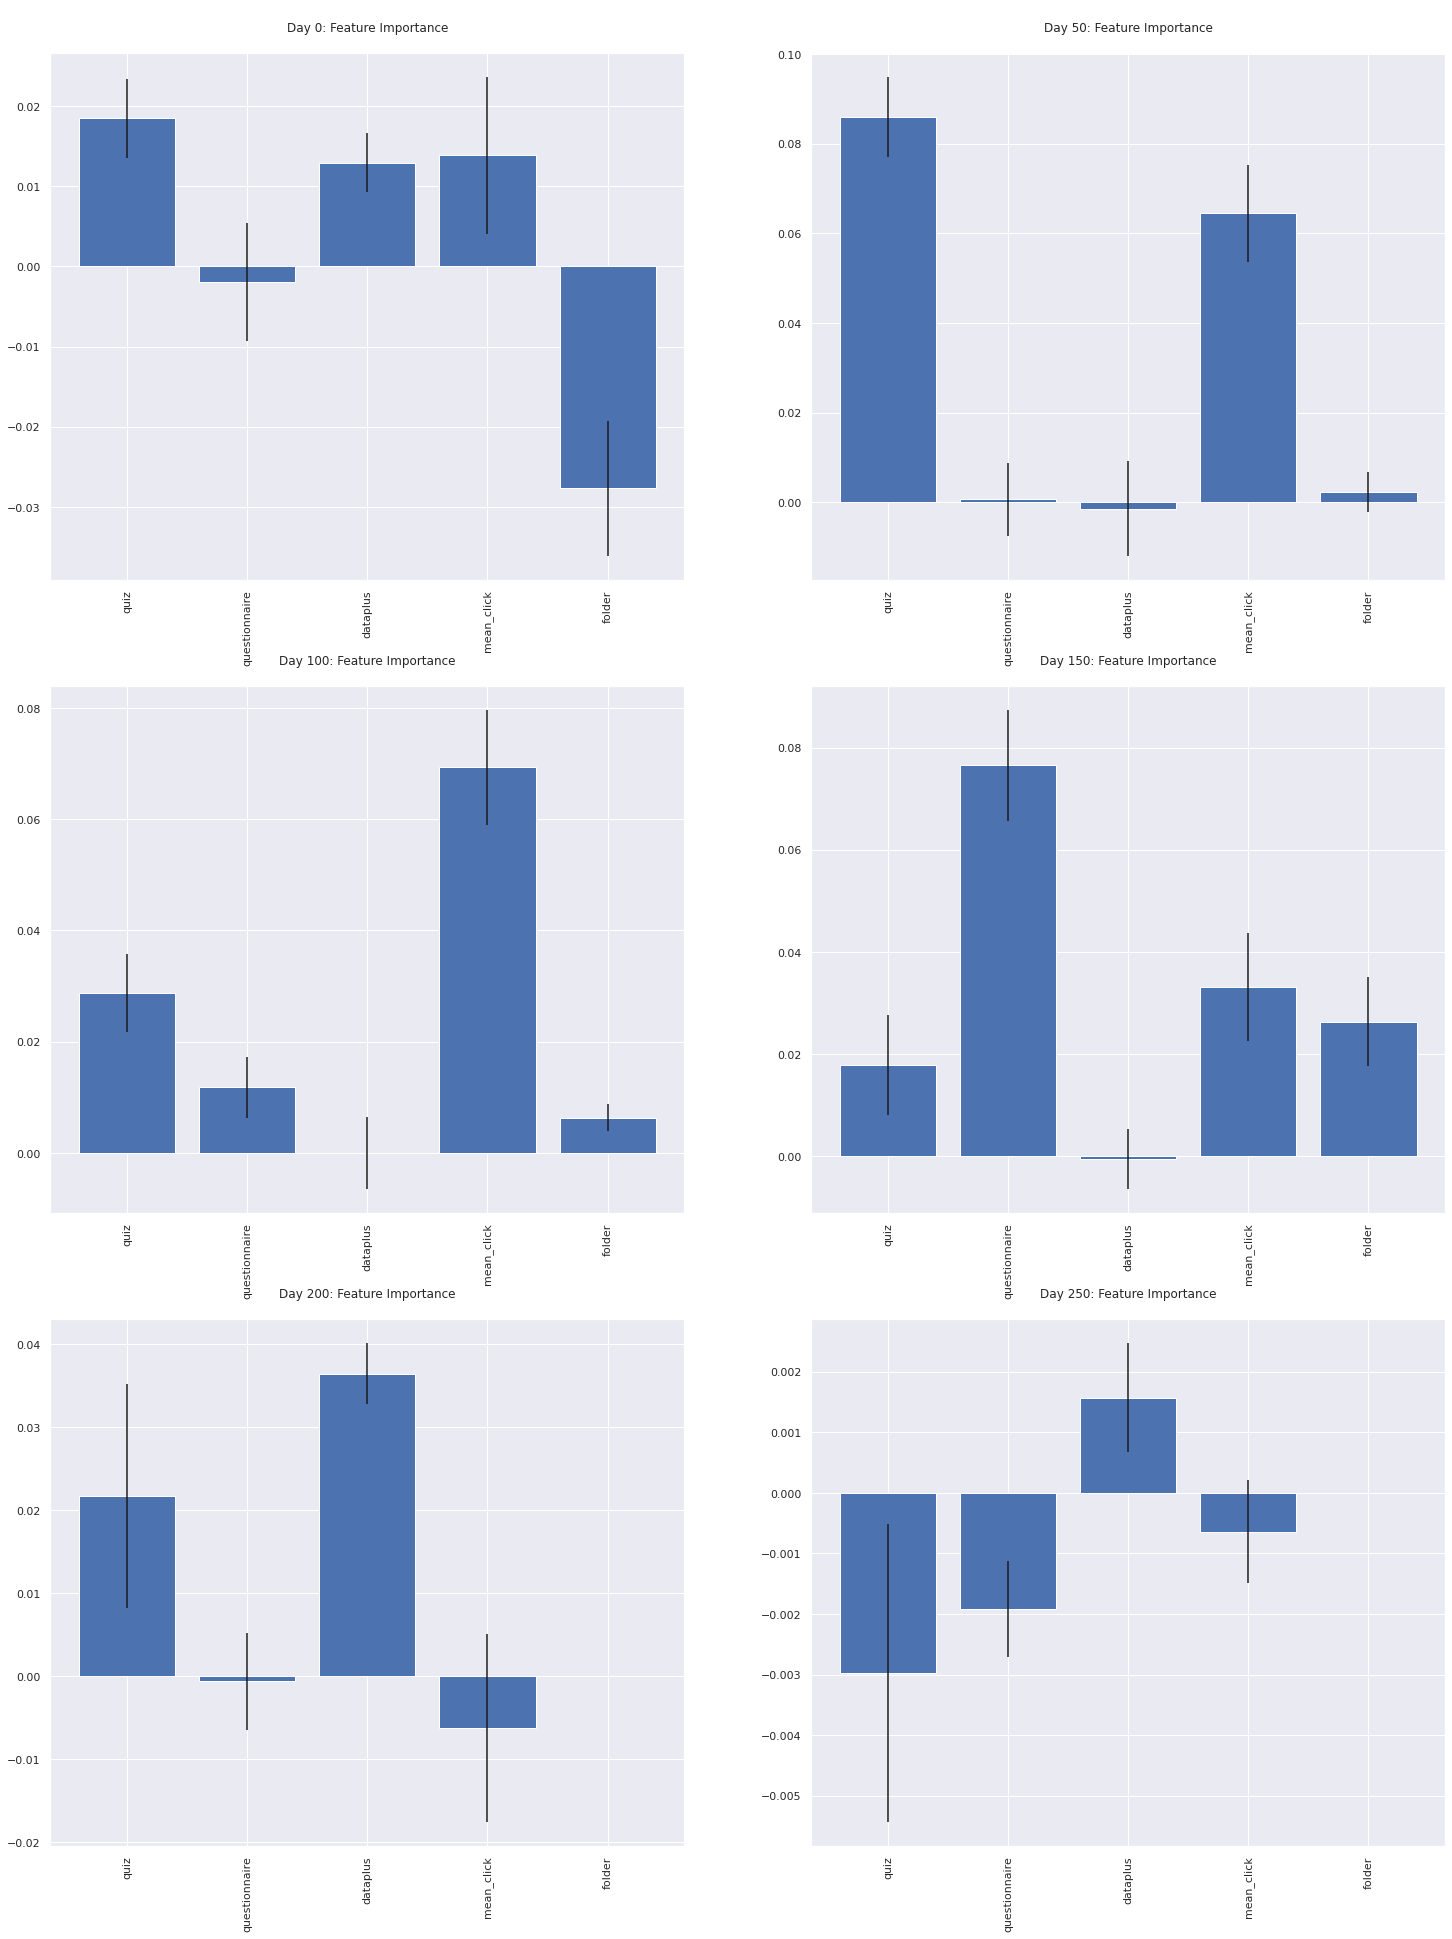

In [69]:
plot_feature_importance(learning_behaviour_features_rf)

##### AdaBoost

In [70]:
from sklearn.ensemble import AdaBoostClassifier

learning_behaviour_results_ab = []
learning_behiviour_features_ab = []

pipeline = Pipeline([
    ('clf', AdaBoostClassifier(random_state=RANDOM_SEED)),
])

params = {
  'clf__learning_rate':(0.5,0.85,1,1.25,1.5,1.75)
}

for i in df.keys():
  print(f"Day {i}")
  grid_search = GridSearchCV(pipeline , param_grid=params , n_jobs=-1, verbose=1, scoring='f1_macro', cv=3,)
  print("Performing grid search...")
  print("pipeline:", [name for name, _ in pipeline.steps])
  print("parameters:")
  print(params)
  tuned_model = grid_search.fit(X_train[i], Y_train[i])

  print("Best score: %0.3f" % grid_search.best_score_)
  print("Best parameters set:")
  best_parameters = grid_search.best_estimator_.get_params()
  for param_name in sorted(params.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

  predictions = tuned_model.predict(X_test[i])


  acc, f1, prec, recall, conf = evaluation_summary(predictions, Y_test[i])
  print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
  learning_behaviour_results_ab.append([acc, f1, prec, recall, conf])
  learning_behiviour_features_ab.append([tuned_model, X_test[i], Y_test[i]])

  print("\n")

Day 0
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__learning_rate': (0.5, 0.85, 1, 1.25, 1.5, 1.75)}
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best score: 0.520
Best parameters set:
	clf__learning_rate: 1.25
Accuracy: 0.7207890743550834, F1 Score: 0.34050179211469533, Precision: 0.40948275862068967, Recall: 0.29141104294478526


Day 50
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__learning_rate': (0.5, 0.85, 1, 1.25, 1.5, 1.75)}
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best score: 0.655
Best parameters set:
	clf__learning_rate: 0.85
Accuracy: 0.7541696881798404, F1 Score: 0.45410628019323673, Precision: 0.493006993006993, Recall: 0.4208955223880597


Day 100
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__learning_rate': (0.5, 0.85, 1, 1.25, 1.5, 1.75)}
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best score: 0.665
Best parameters set:
	clf__learning_rate: 0.5
Accuracy: 0.73843930635838

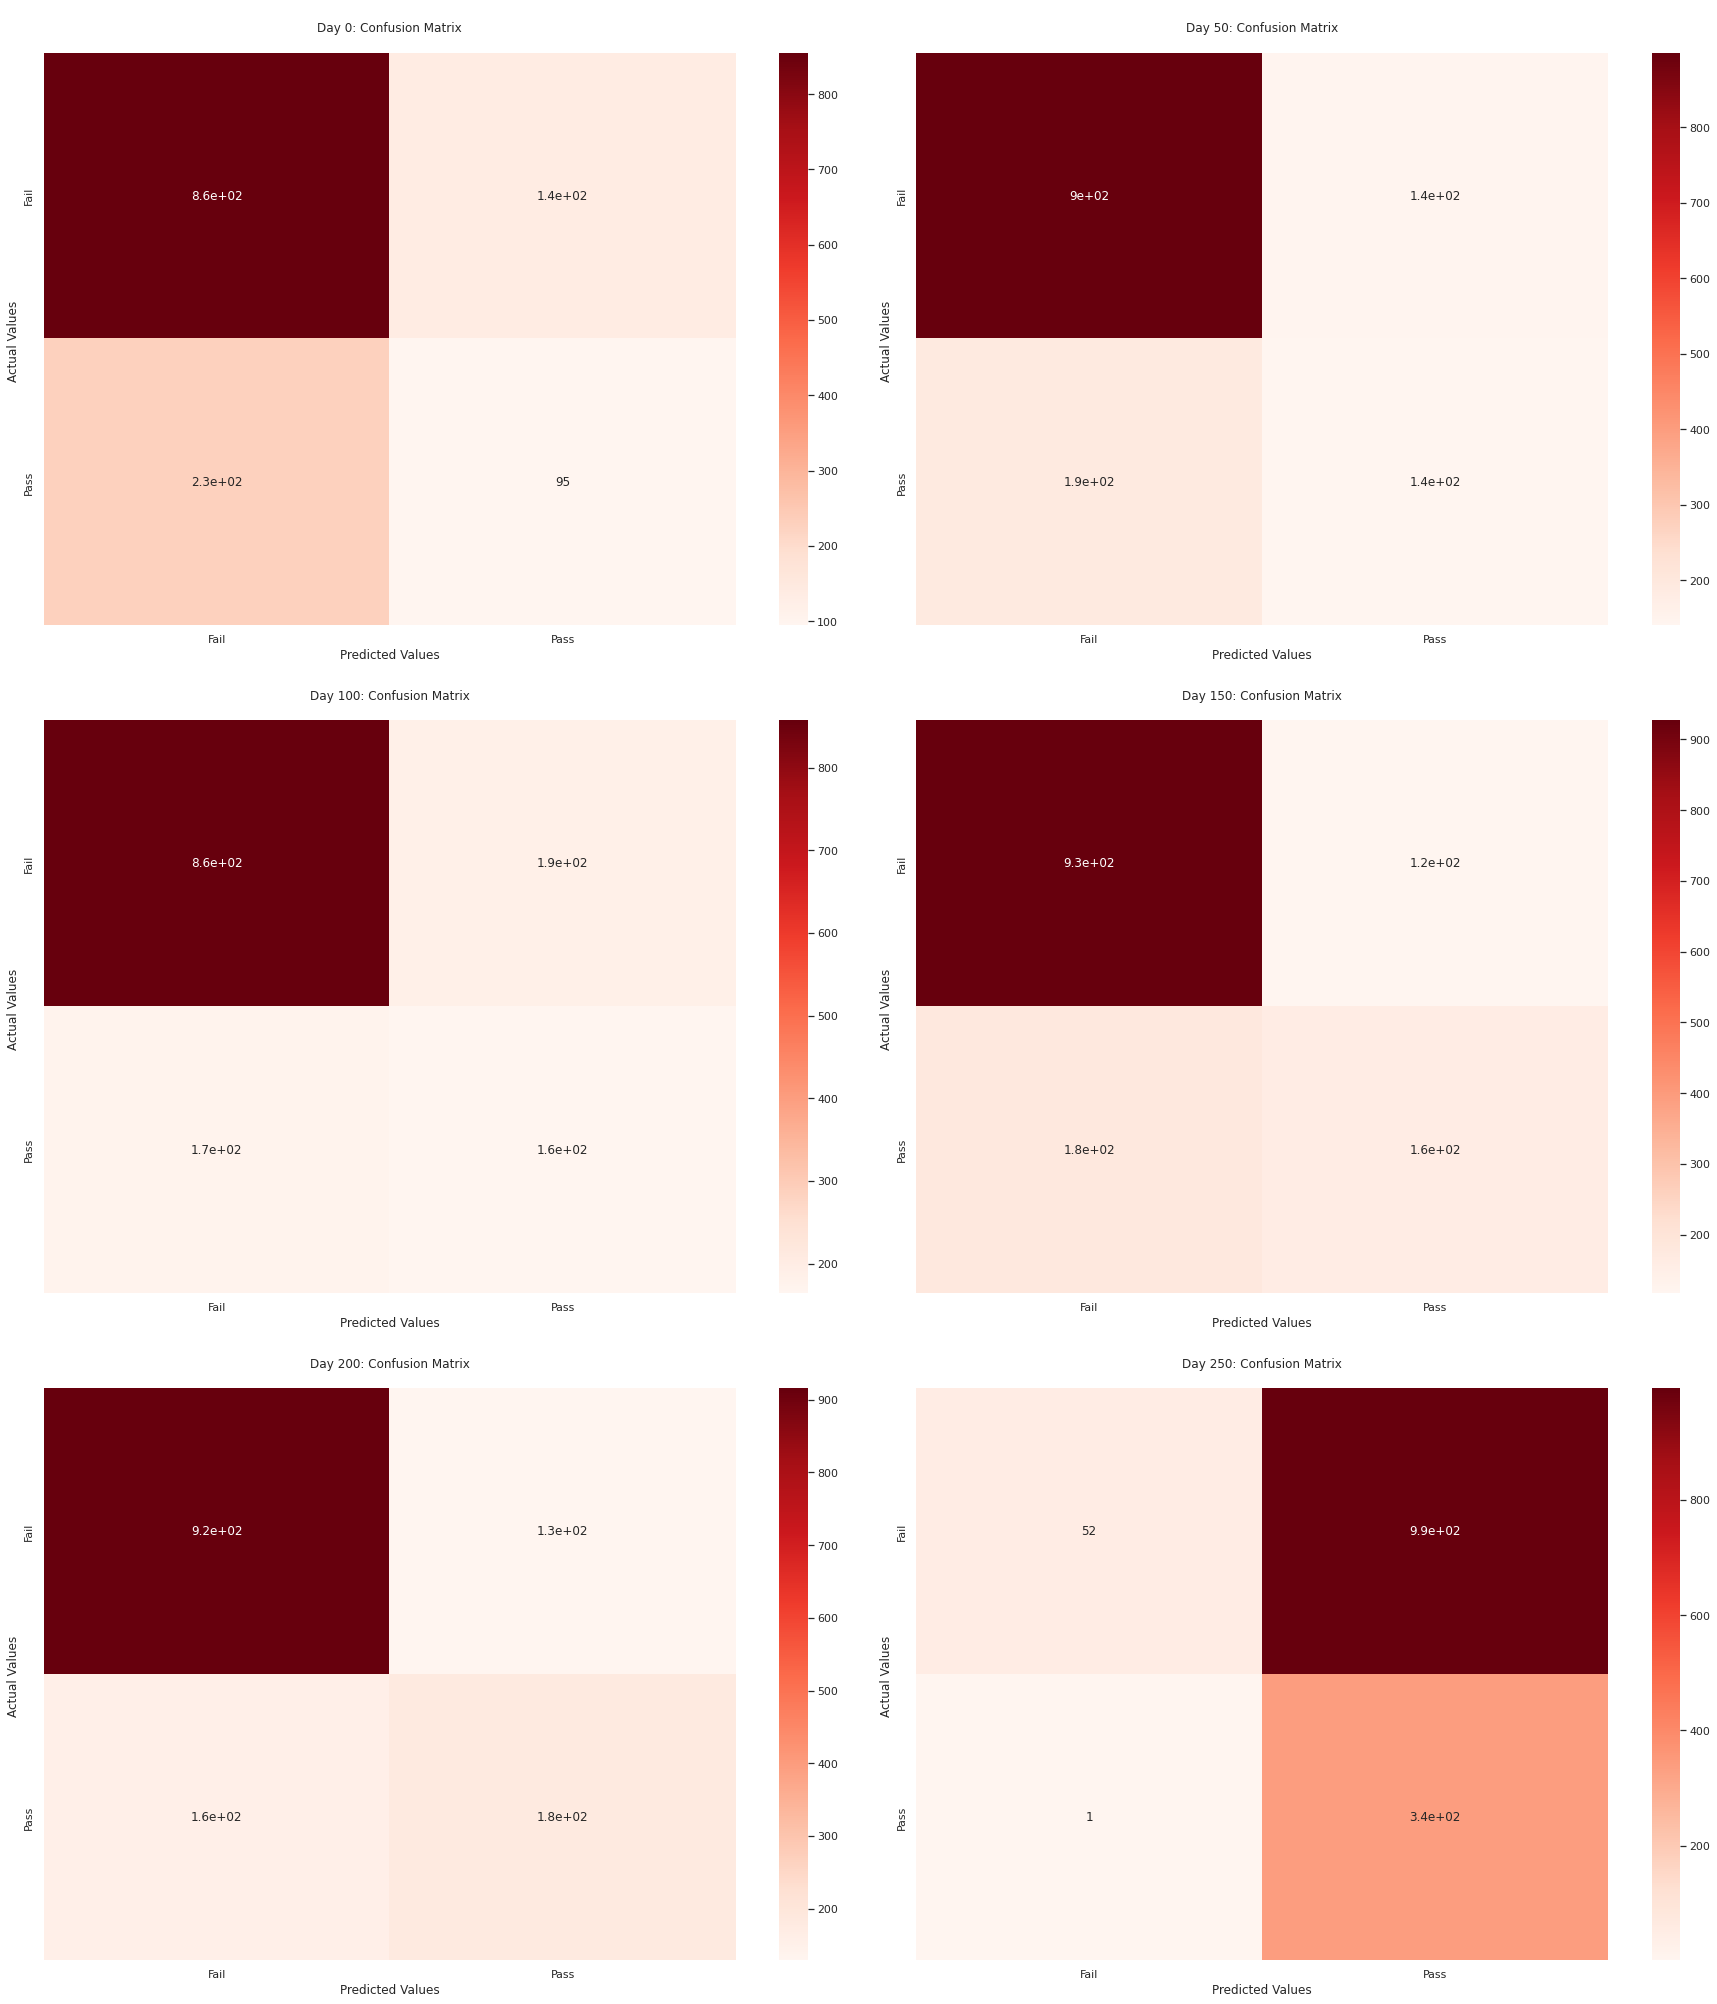

In [71]:
plot_confusion_matrix(learning_behaviour_results_ab)

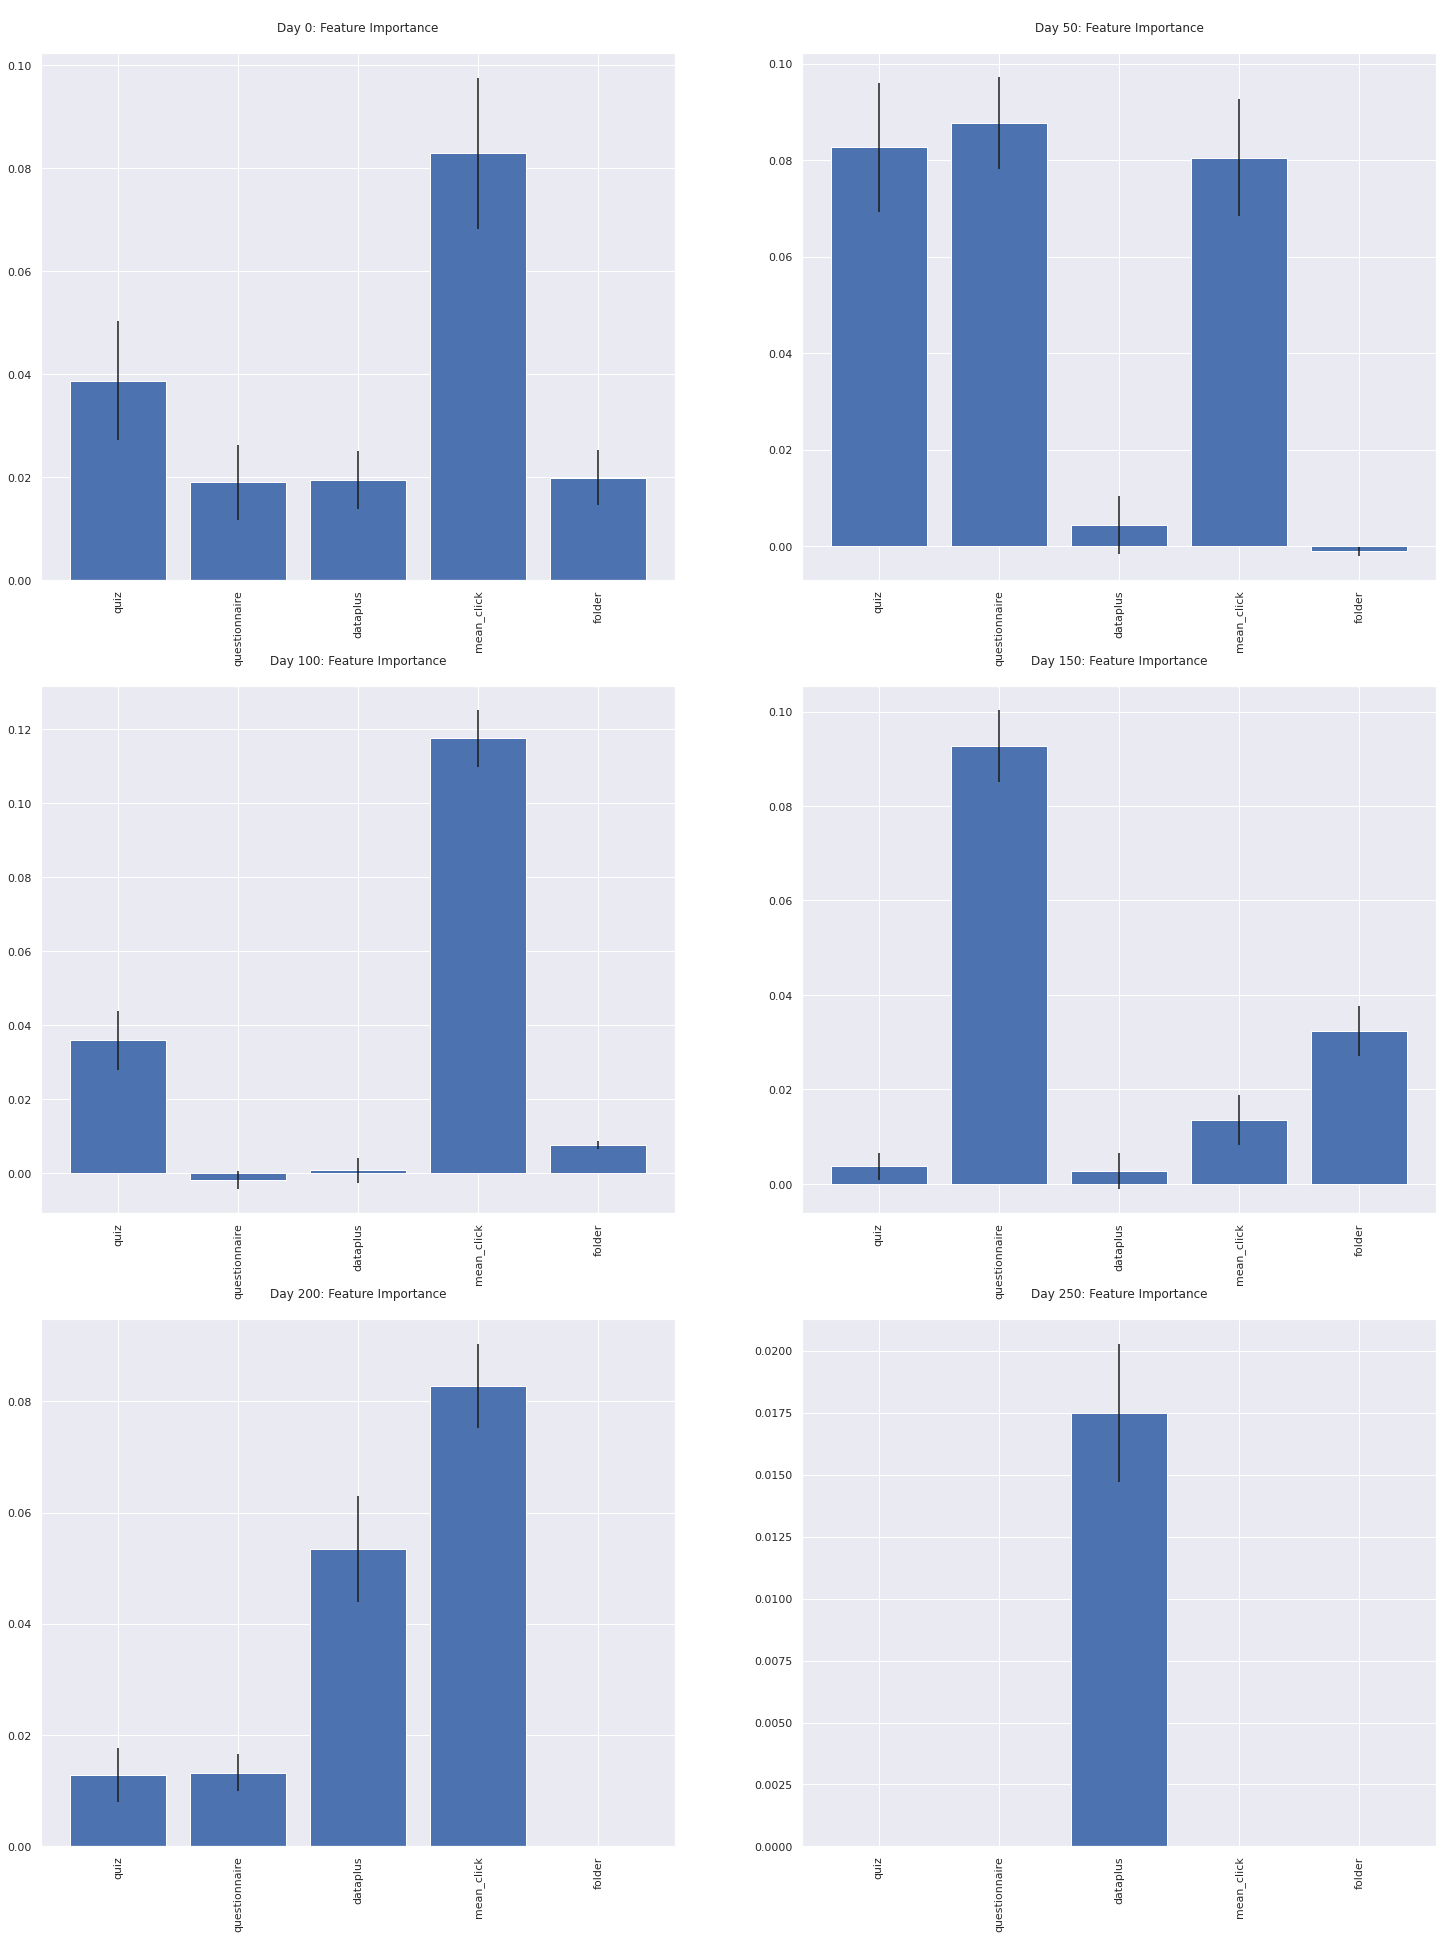

In [72]:
plot_feature_importance(learning_behiviour_features_ab)

##### Plot results overview

In [73]:
learning_behaviour_classifier_results = [learning_behaviour_results_du, learning_behaviour_results_nb, learning_behaviour_results_lr, learning_behaviour_results_lrw, learning_behaviour_results_rf, learning_behaviour_results_ab]
learning_behaviour_classifier_labels = ["Dummy Classifier", "Naive Bayes", "Logistic Regression", "Logistic Regression Weighted", "Random Forest", "AdaBoost"]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-o

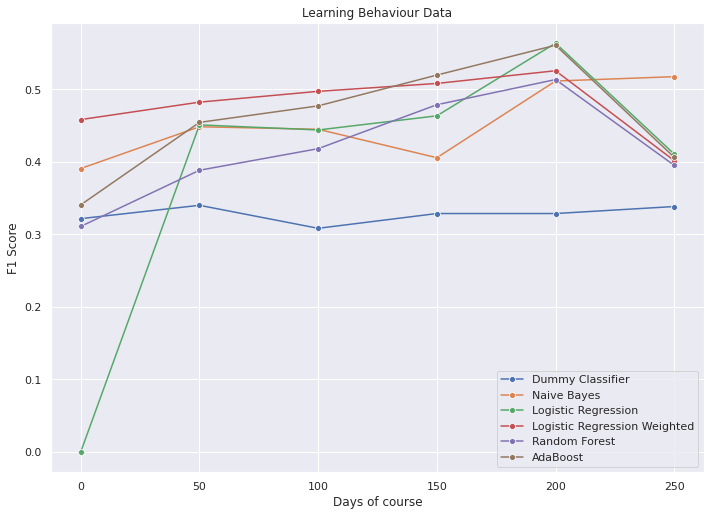

In [74]:
plot_days_compare(deadline_list,learning_behaviour_classifier_results,learning_behaviour_classifier_labels, "Learning Behaviour Data")

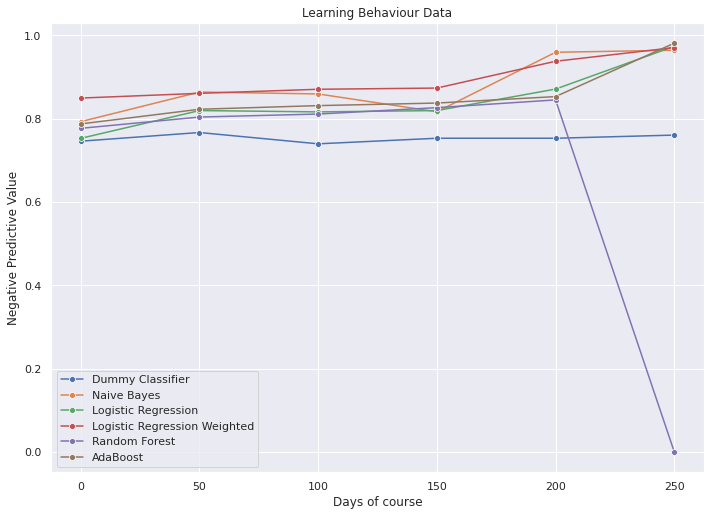

In [75]:
plot_days_compare_npv(deadline_list,learning_behaviour_classifier_results,learning_behaviour_classifier_labels, "Learning Behaviour Data")

#### Performance data

##### Prepare data for prediction

In [76]:
performance_df = {}
for i in list(df.keys())[1:]:
  performance_df[i] = split_dataframe_by_data_type(df[i], ['performance'], include_final_result=True)

In [77]:
performance_df[50]

code_presentation  id_student  score  weighted_score  final_result
0                2013B       33915   90.0          22.680             0
1                2013B       35544   86.0          21.672             0
2                2013B       35860   84.0          21.168             0
3                2013B       42668   74.0          18.648             0
4                2013B       43273   81.0          20.412             0
...                ...         ...    ...             ...           ...
4797             2014J     2681198   66.0           8.316             0
4798             2014J     2682682   96.0          12.096             0
4799             2014J     2683857   72.0           9.072             0
4800             2014J     2693932   90.0          11.340             0
4801             2014J     2697921   94.0          11.844             0

[4802 rows x 5 columns]

###### Encode data

In [78]:
X_train, X_test, Y_train, Y_test = encode_data(performance_df, ["2013J"], "2014J")

Index([], dtype='object') Index(['score', 'weighted_score'], dtype='object')
Index([], dtype='object') Index(['score', 'weighted_score'], dtype='object')
Index([], dtype='object') Index(['score', 'weighted_score'], dtype='object')
Index([], dtype='object') Index(['score', 'weighted_score'], dtype='object')
Index([], dtype='object') Index(['score', 'weighted_score'], dtype='object')


In [79]:
X_train[50]

score  weighted_score
1072  0.897959        0.448980
1073  0.948980        0.948980
1074  0.775510        0.775510
1075  0.938776        0.938776
1076  0.765306        0.765306
...        ...             ...
2513  0.744898        0.744898
2514  0.673469        0.673469
2515  0.948980        0.948980
2516  0.632653        0.632653
2517  0.806122        0.806122

[1446 rows x 2 columns]

###### Undersampling

In [80]:
Y_train[50].value_counts()

0    1028
1     418
Name: final_result, dtype: int64

In [81]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks

from collections import Counter

X_train_sample, Y_train_sample = {},{}

for i in list(df.keys())[1:]:

  sampler = RandomUnderSampler() # fit predictor and target variable
  X_train_sample[i], Y_train_sample[i] = sampler.fit_resample(X_train[i], Y_train[i])

  print(f"Sampling for day {i}")
  print('Original dataset shape:', Counter(Y_train[i]))
  print('Resample dataset shape', Counter(Y_train_sample[i]))

Sampling for day 50
Original dataset shape: Counter({0: 1028, 1: 418})
Resample dataset shape Counter({0: 418, 1: 418})
Sampling for day 100
Original dataset shape: Counter({0: 1028, 1: 418})
Resample dataset shape Counter({0: 418, 1: 418})
Sampling for day 150
Original dataset shape: Counter({0: 1028, 1: 419})
Resample dataset shape Counter({0: 419, 1: 419})
Sampling for day 200
Original dataset shape: Counter({0: 1028, 1: 419})
Resample dataset shape Counter({0: 419, 1: 419})
Sampling for day 250
Original dataset shape: Counter({0: 1028, 1: 425})
Resample dataset shape Counter({0: 425, 1: 425})


##### DummyClassifier

In [82]:
from sklearn.dummy import DummyClassifier

performance_results_du = []
performance_features_du = []

pipeline = Pipeline([
    ('clf', DummyClassifier(strategy="uniform",random_state=RANDOM_SEED)),
])

params = {
}

for i in list(df.keys())[1:]:
  print(f"Day {i}")
  grid_search = GridSearchCV(pipeline , param_grid=params , n_jobs=-1, verbose=1, scoring='f1_macro', cv=3,)
  print("Performing grid search...")
  print("pipeline:", [name for name, _ in pipeline.steps])
  print("parameters:")
  print(params)
  tuned_model = grid_search.fit(X_train[i], Y_train[i])

  print("Best score: %0.3f" % grid_search.best_score_)
  print("Best parameters set:")
  best_parameters = grid_search.best_estimator_.get_params()
  for param_name in sorted(params.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

  predictions = tuned_model.predict(X_test[i])


  acc, f1, prec, recall, conf = evaluation_summary(predictions, Y_test[i])
  print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
  performance_results_du.append([acc, f1, prec, recall, conf])
  performance_features_du.append([tuned_model, X_test[i], Y_test[i]])
  print("\n")

Day 50
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.433
Best parameters set:
Accuracy: 0.5097897026831038, F1 Score: 0.33984375, Precision: 0.2525399129172714, Recall: 0.5194029850746269


Day 100
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.433
Best parameters set:
Accuracy: 0.4841040462427746, F1 Score: 0.3081395348837209, Precision: 0.22943722943722944, Recall: 0.4690265486725664


Day 150
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.433
Best parameters set:
Accuracy: 0.49855699855699853, F1 Score: 0.3285024154589372, Precision: 0.24495677233429394, Recall: 0.49853372434017595


Day 200
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.433
Best p

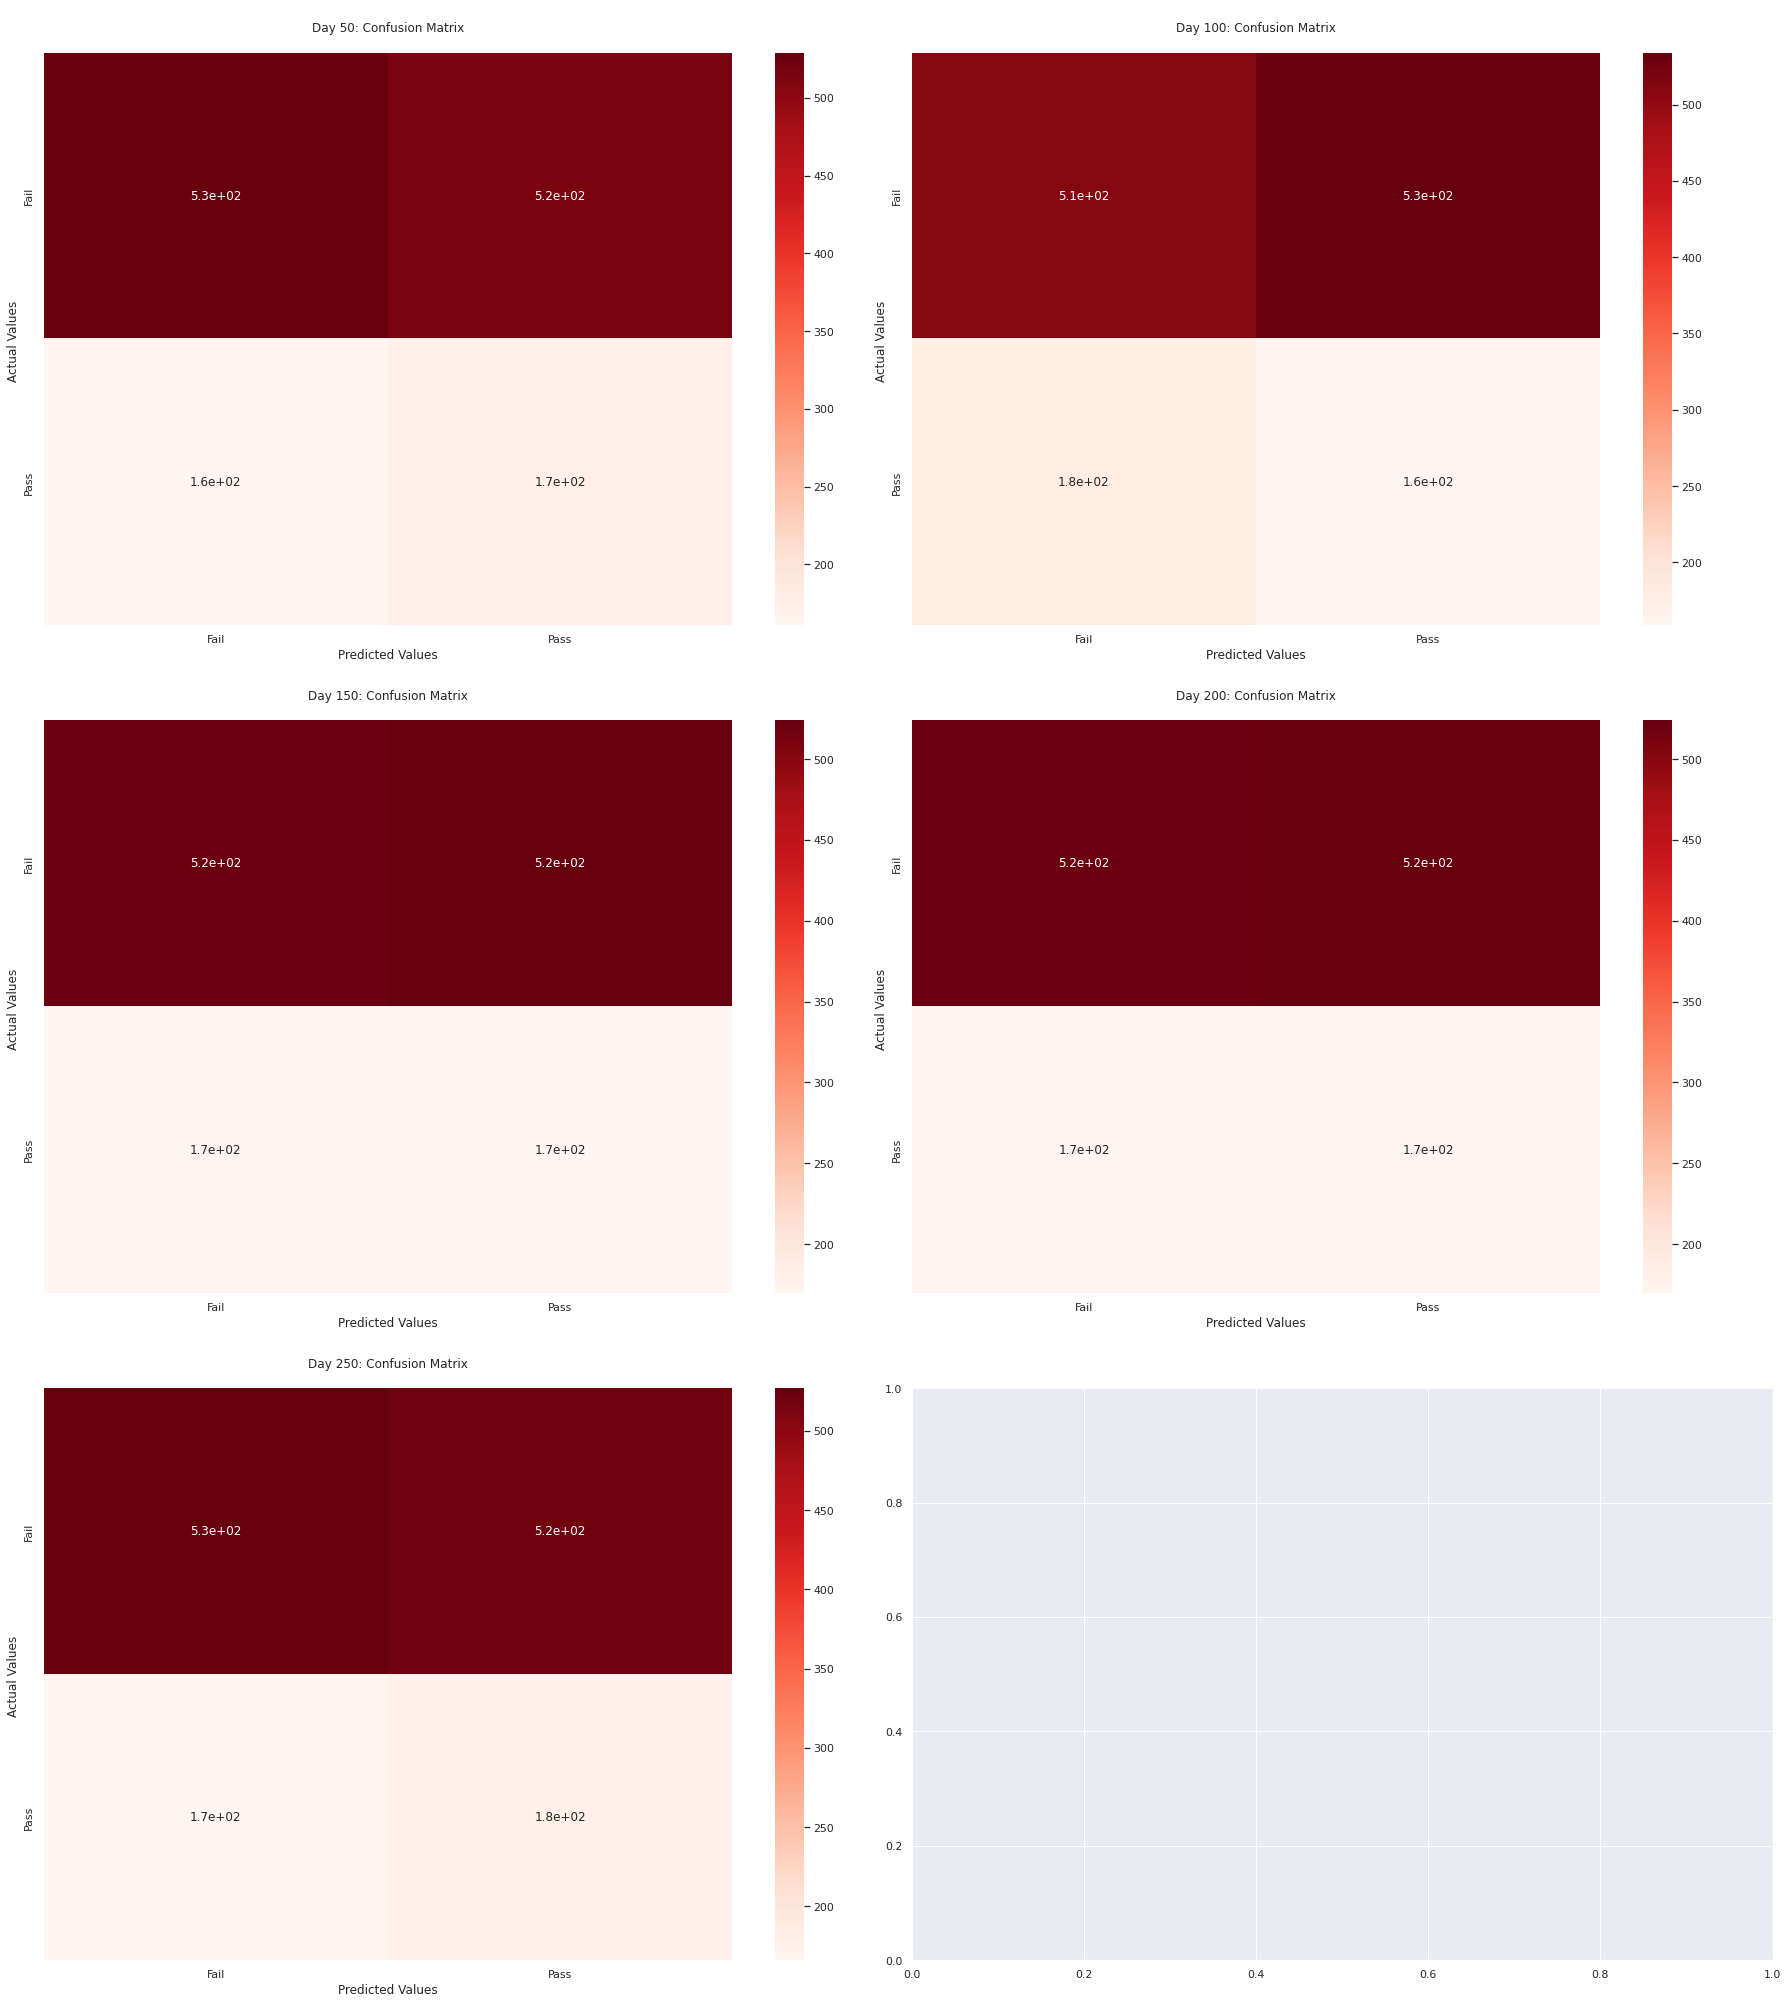

In [83]:
plot_confusion_matrix(performance_results_du)

##### NaiveBayes

In [84]:
from sklearn.naive_bayes import GaussianNB,ComplementNB,BernoulliNB,MultinomialNB

performance_results_nb = []
performance_features_nb = []

performance_predict_proba_nb = []

pipeline = Pipeline([
    ('clf', ComplementNB()),
])

params = {
}

for i in list(df.keys())[1:]:
  print(f"Day {i}")
  grid_search = GridSearchCV(pipeline , param_grid=params , n_jobs=-1, verbose=1, scoring='f1_macro', cv=3,)
  print("Performing grid search...")
  print("pipeline:", [name for name, _ in pipeline.steps])
  print("parameters:")
  print(params)
  tuned_model = grid_search.fit(X_train[i], Y_train[i])

  print("Best score: %0.3f" % grid_search.best_score_)
  print("Best parameters set:")
  best_parameters = grid_search.best_estimator_.get_params()
  for param_name in sorted(params.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

  predictions = tuned_model.predict(X_test[i])
  predictions_proba = tuned_model.predict_proba(X_test[i])

  acc, f1, prec, recall, conf = evaluation_summary(predictions, Y_test[i])
  print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
  performance_results_nb.append([acc, f1, prec, recall, conf])
  performance_features_nb.append([tuned_model, X_test[i], Y_test[i]])

  performance_predict_proba_nb.append(predictions_proba)

  print("\n")

Day 50
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.628
Best parameters set:
Accuracy: 0.242929659173314, F1 Score: 0.39089848308051345, Precision: 0.242929659173314, Recall: 1.0


Day 100
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.804
Best parameters set:
Accuracy: 0.8569364161849711, F1 Score: 0.5991902834008097, Precision: 0.9548387096774194, Recall: 0.4365781710914454


Day 150
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.842
Best parameters set:
Accuracy: 0.886002886002886, F1 Score: 0.7168458781362008, Precision: 0.9216589861751152, Recall: 0.5865102639296188


Day 200
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.851
Best parameters set

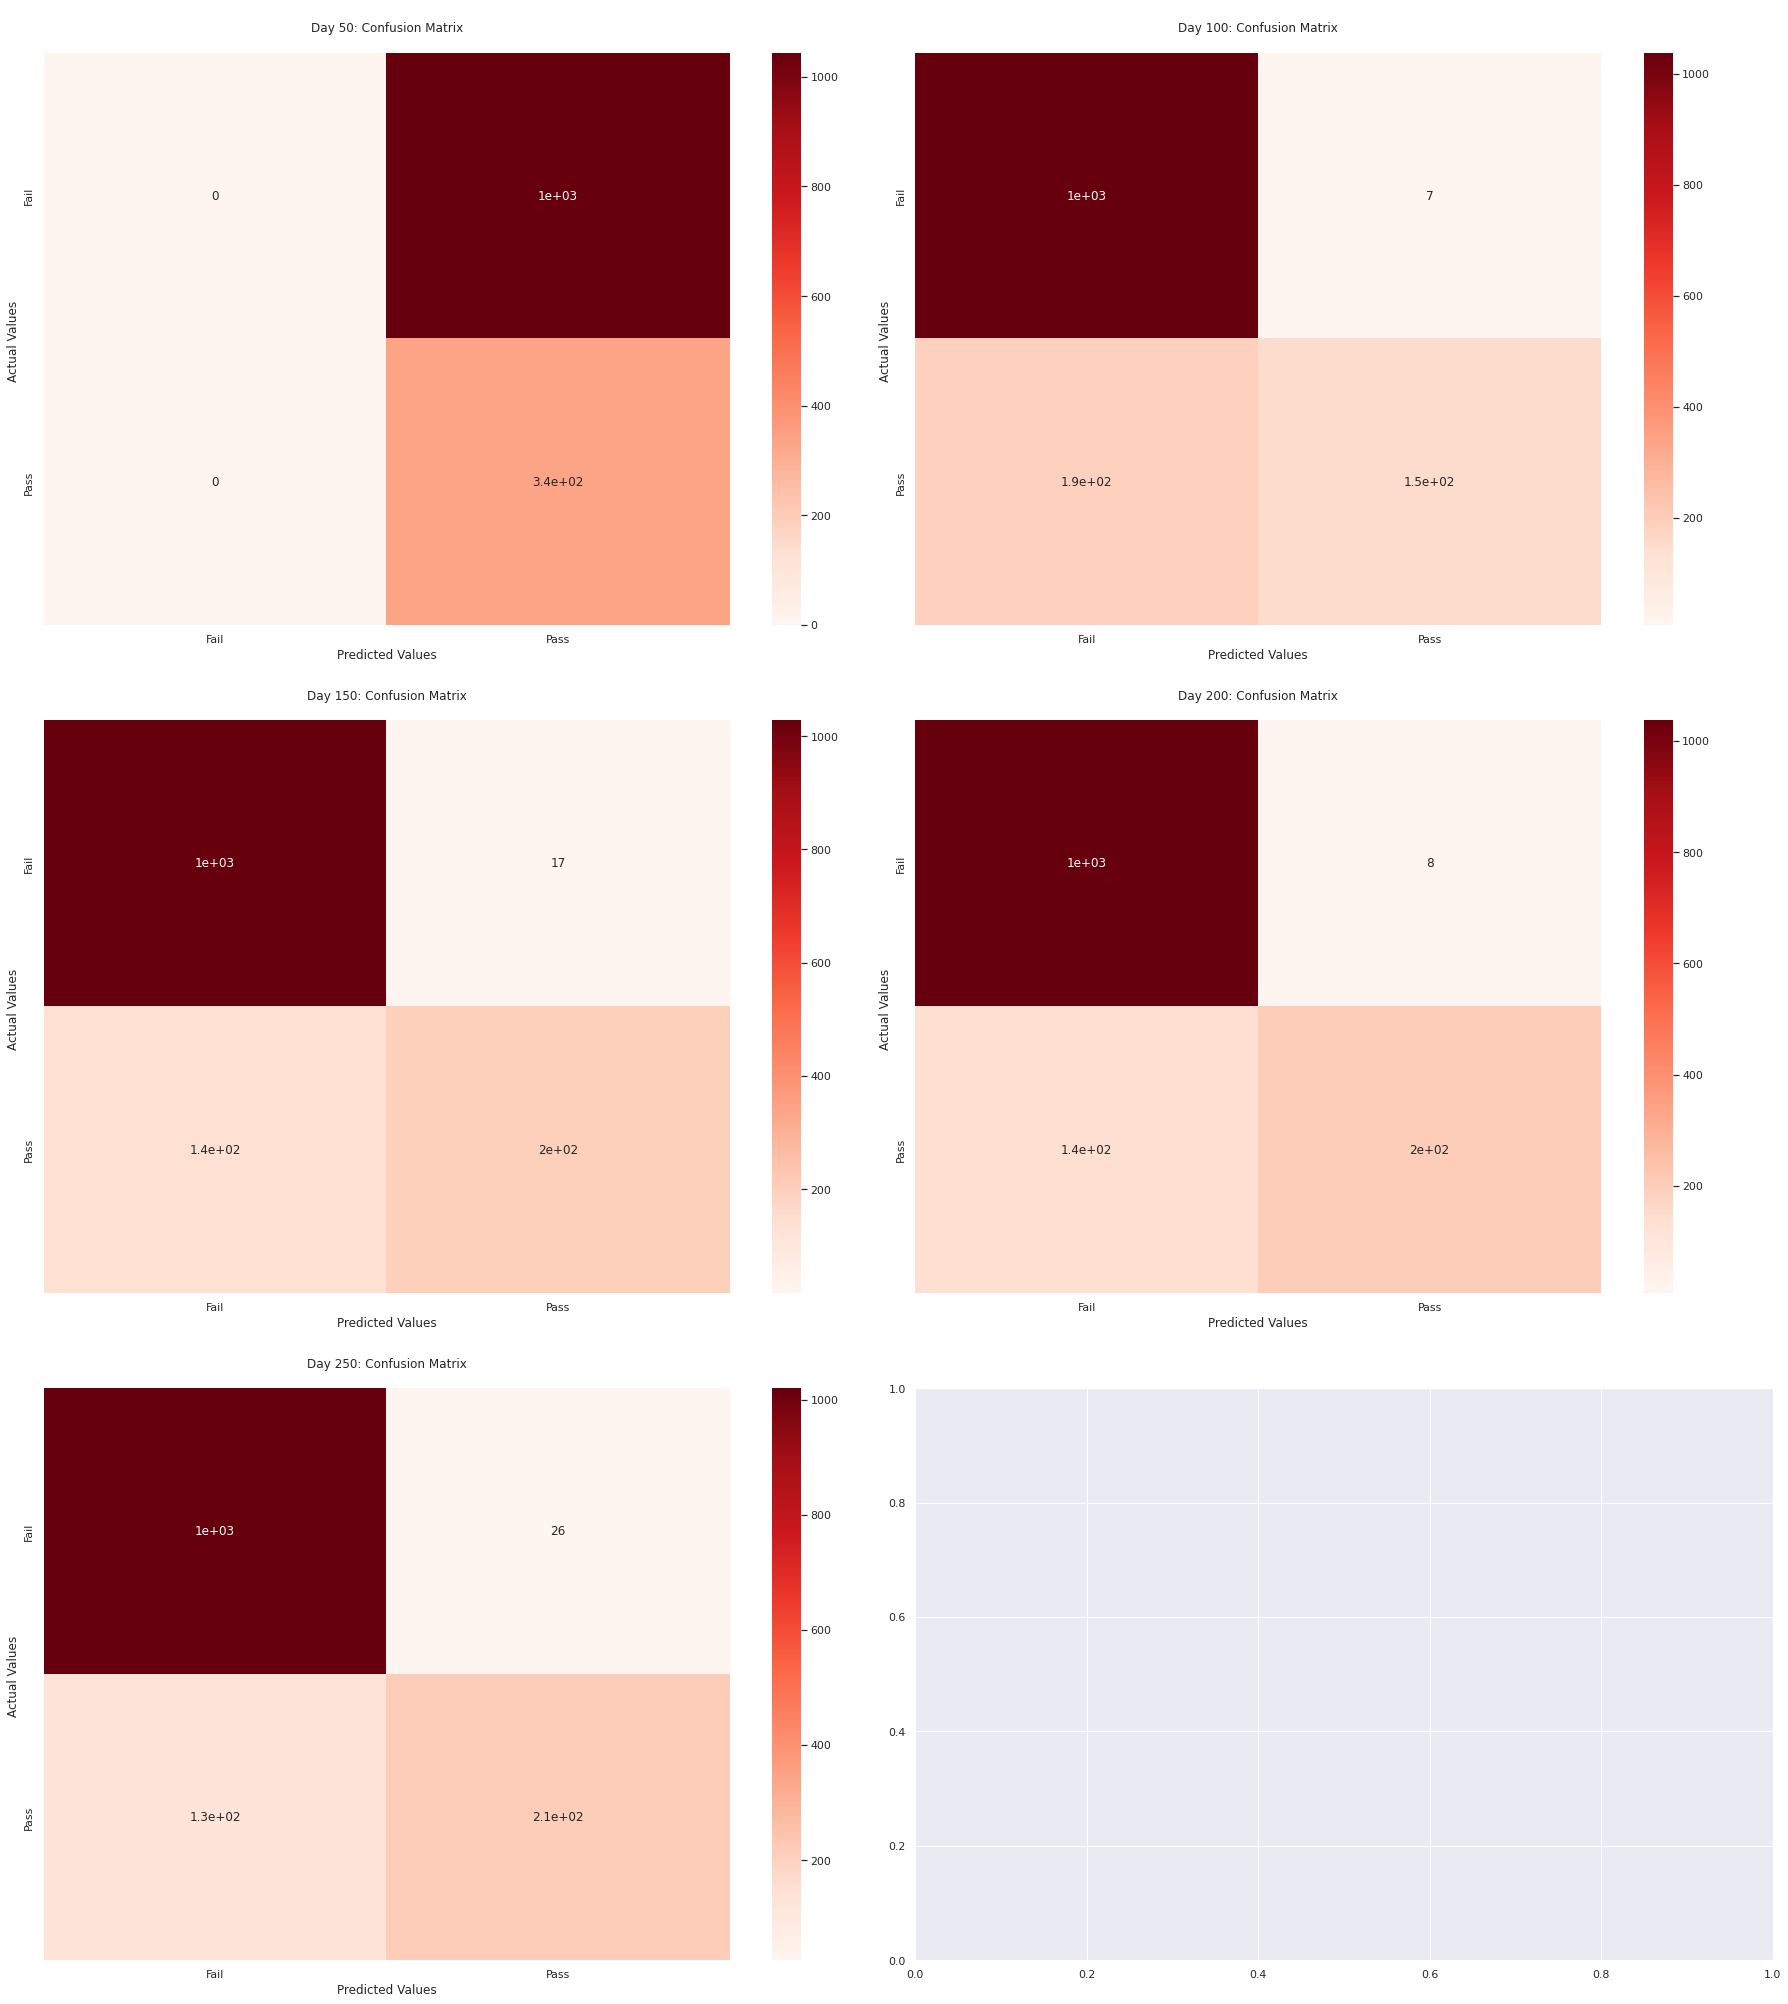

In [85]:
plot_confusion_matrix(performance_results_nb)

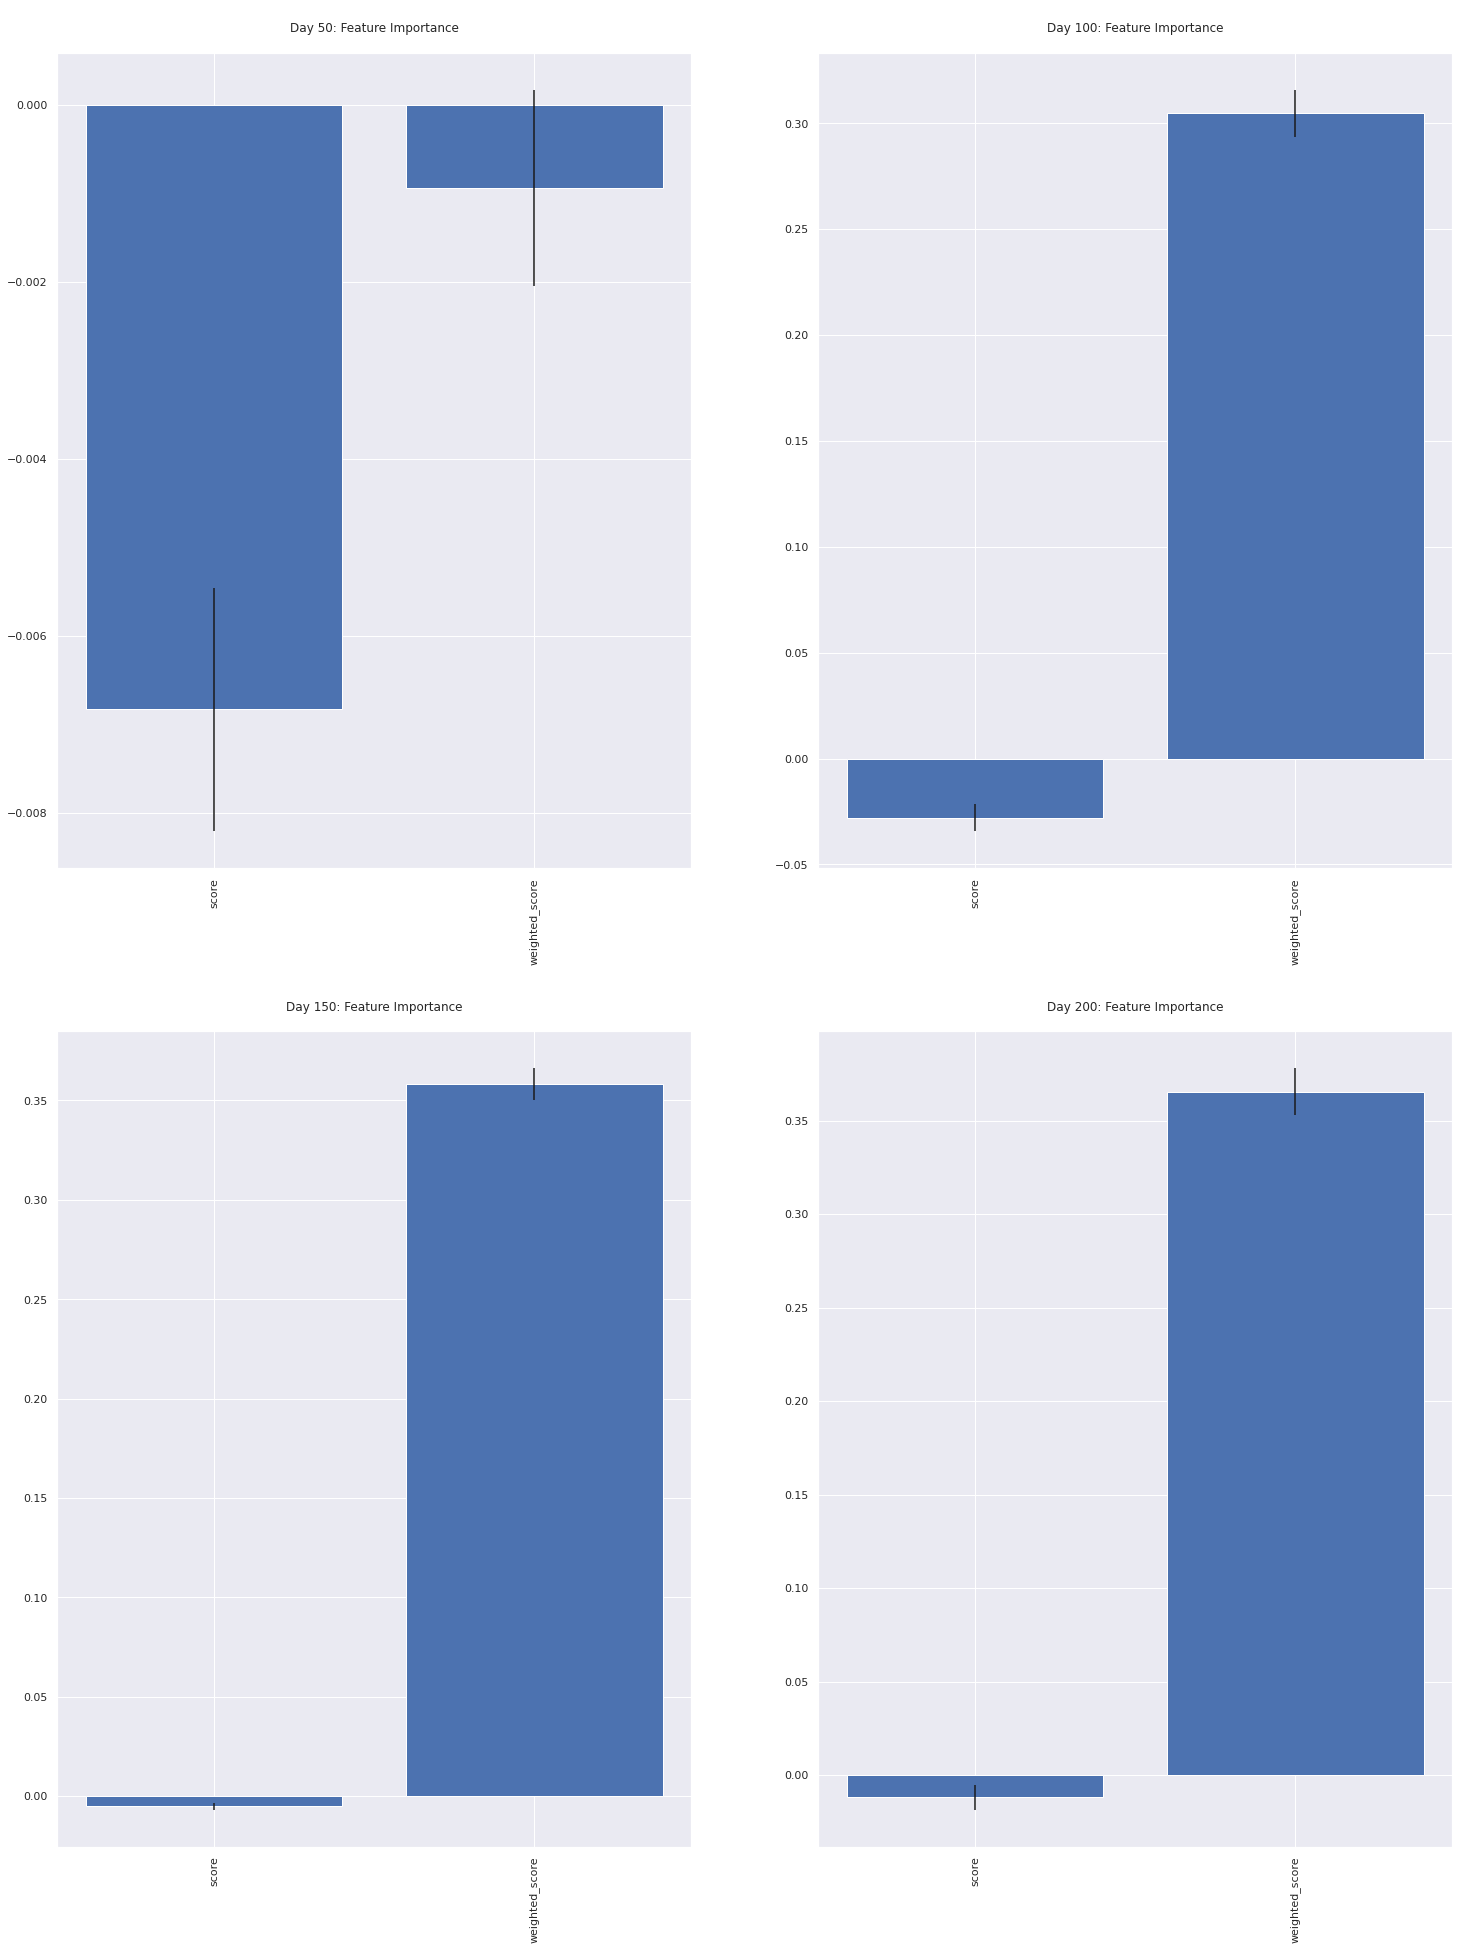

In [86]:
plot_feature_importance(performance_features_nb)

##### LogisticRegression

In [87]:
from sklearn.linear_model import LogisticRegression

performance_results_lr = []
performance_features_lr = []

pipeline = Pipeline([
    ('clf', LogisticRegression()),
])

params = {
  'clf__penalty': ['l2', 'none']
}

for i in list(df.keys())[1:]:
  print(f"Day {i}")
  grid_search = GridSearchCV(pipeline , param_grid=params , n_jobs=-1, verbose=1, scoring='f1_macro', cv=3,)
  print("Performing grid search...")
  print("pipeline:", [name for name, _ in pipeline.steps])
  print("parameters:")
  print(params)
  tuned_model = grid_search.fit(X_train[i], Y_train[i])

  print("Best score: %0.3f" % grid_search.best_score_)
  print("Best parameters set:")
  best_parameters = grid_search.best_estimator_.get_params()
  for param_name in sorted(params.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

  predictions = tuned_model.predict(X_test[i])


  acc, f1, prec, recall, conf = evaluation_summary(predictions, Y_test[i])
  print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
  performance_results_lr.append([acc, f1, prec, recall, conf])
  performance_features_lr.append([tuned_model, X_test[i], Y_test[i]])
  print("\n")


Day 50
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__penalty': ['l2', 'none']}
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Best score: 0.709
Best parameters set:
	clf__penalty: 'l2'
Accuracy: 0.242929659173314, F1 Score: 0.39089848308051345, Precision: 0.242929659173314, Recall: 1.0


Day 100
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__penalty': ['l2', 'none']}
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Best score: 0.853
Best parameters set:
	clf__penalty: 'none'
Accuracy: 0.8663294797687862, F1 Score: 0.669051878354204, Precision: 0.85, Recall: 0.551622418879056


Day 150
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__penalty': ['l2', 'none']}
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Best score: 0.878
Best parameters set:
	clf__penalty: 'l2'
Accuracy: 0.8845598845598845, F1 Score: 0.7250859106529209, Precision: 0.8755186721991701, Recall: 0.6187683284457478


Day 200
Performing grid se

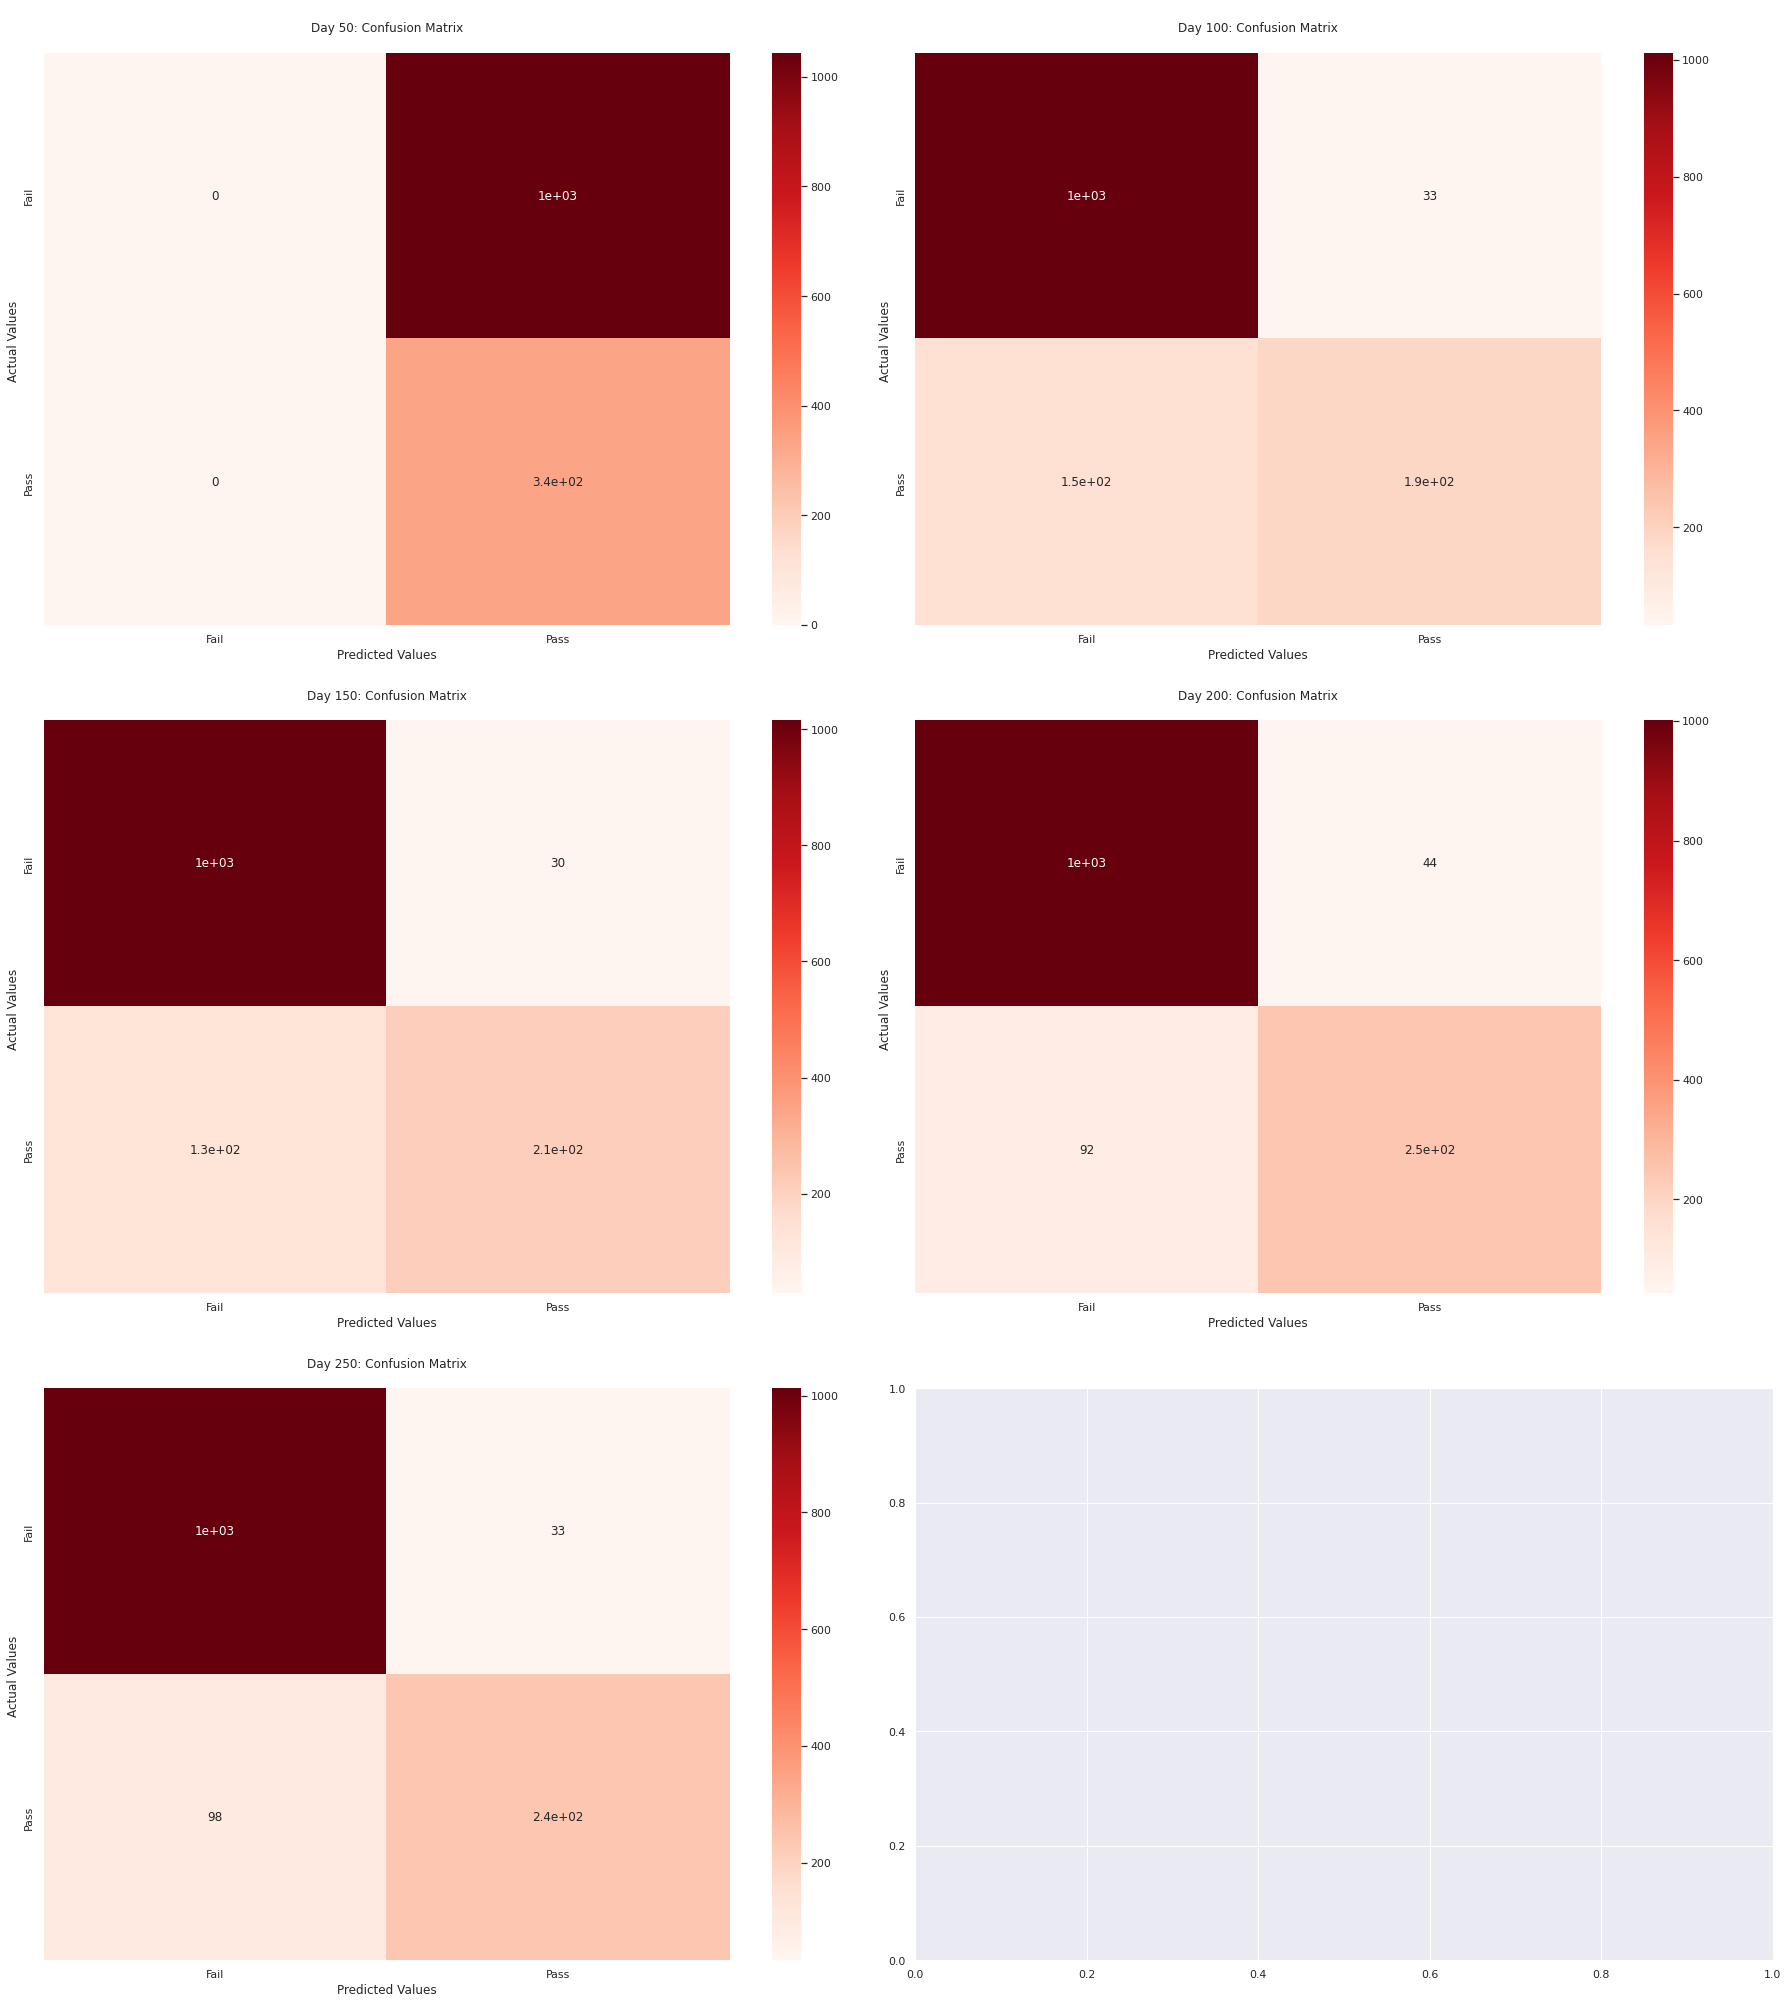

In [88]:
plot_confusion_matrix(performance_results_lr)

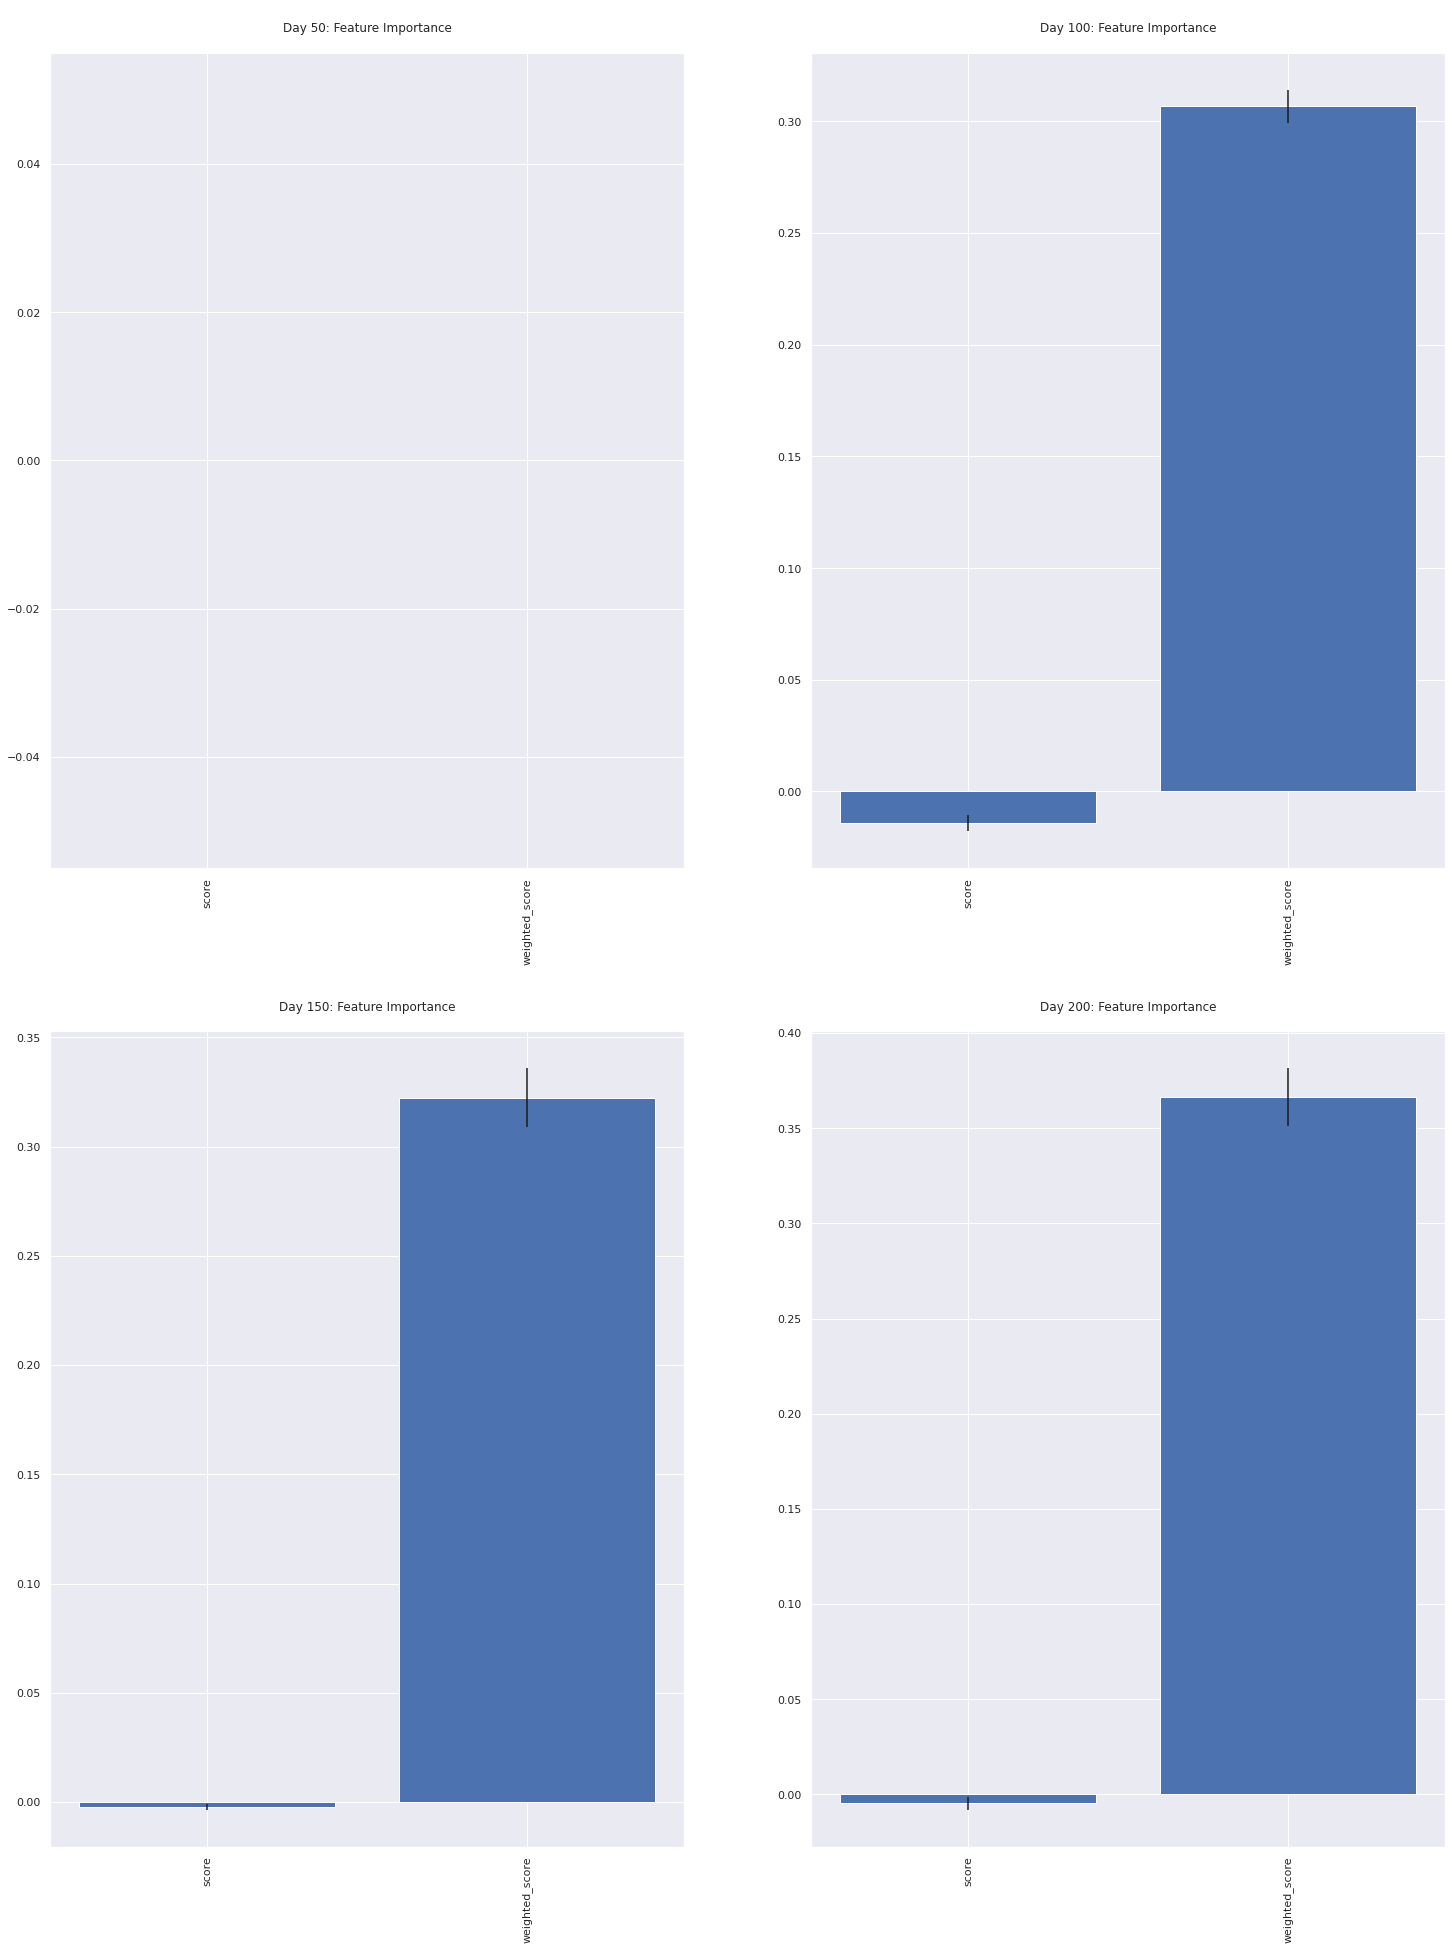

In [89]:
plot_feature_importance(performance_features_lr)

##### WeightedLogisticRegression

In [90]:
performance_results_lrw = []
performance_features_lrw = []

pipeline = Pipeline([
    ('clf', LogisticRegression(class_weight = 'balanced')),
])

params = {
  
}

for i in list(df.keys())[1:]:
  print(f"Day {i}")
  grid_search = GridSearchCV(pipeline , param_grid=params , n_jobs=-1, verbose=1, scoring='f1_macro', cv=3,)
  print("Performing grid search...")
  print("pipeline:", [name for name, _ in pipeline.steps])
  print("parameters:")
  print(params)
  tuned_model = grid_search.fit(X_train[i], Y_train[i])

  print("Best score: %0.3f" % grid_search.best_score_)
  print("Best parameters set:")
  best_parameters = grid_search.best_estimator_.get_params()
  for param_name in sorted(params.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

  predictions = tuned_model.predict(X_test[i])


  acc, f1, prec, recall, conf = evaluation_summary(predictions, Y_test[i])
  print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
  performance_results_lrw.append([acc, f1, prec, recall, conf])
  performance_features_lrw.append([tuned_model, X_test[i], Y_test[i]])
  print("\n")

Day 50
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.732
Best parameters set:
Accuracy: 0.242929659173314, F1 Score: 0.39089848308051345, Precision: 0.242929659173314, Recall: 1.0


Day 100
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.835
Best parameters set:
Accuracy: 0.8677745664739884, F1 Score: 0.7109004739336493, Precision: 0.7653061224489796, Recall: 0.6637168141592921


Day 150
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.870
Best parameters set:
Accuracy: 0.8852813852813853, F1 Score: 0.7609022556390977, Precision: 0.7808641975308642, Recall: 0.7419354838709677


Day 200
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.868
Best parameters se

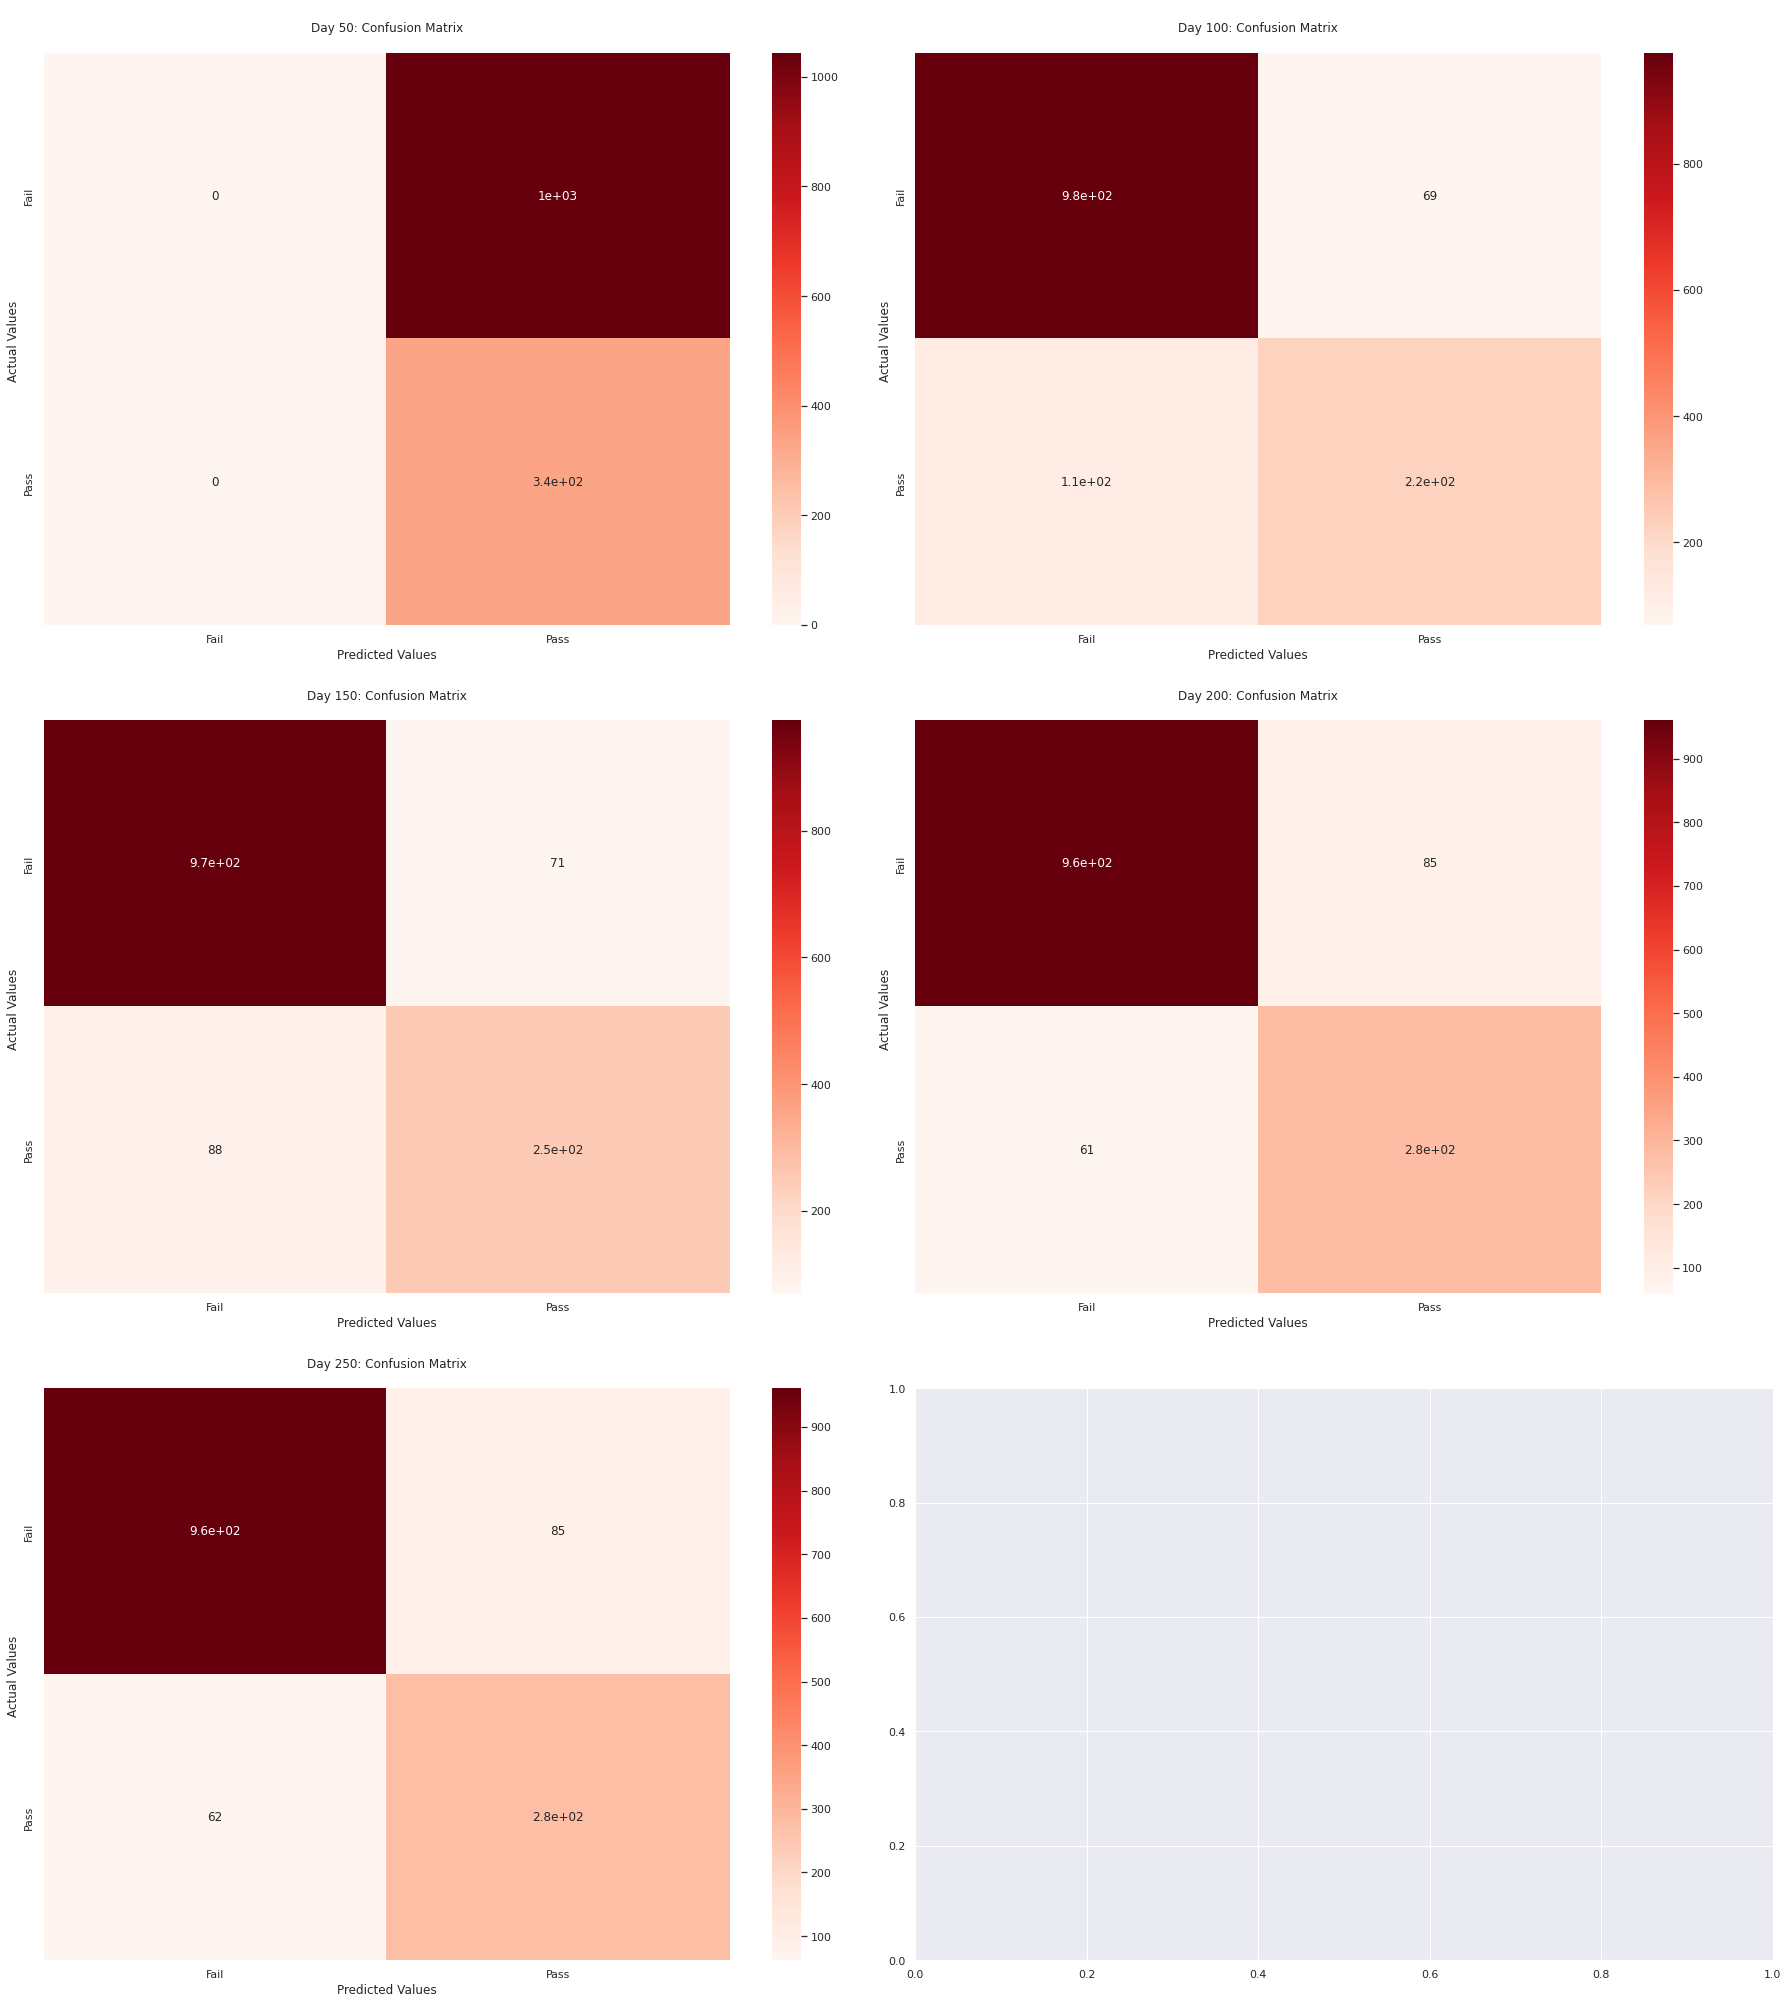

In [91]:
plot_confusion_matrix(performance_results_lrw)

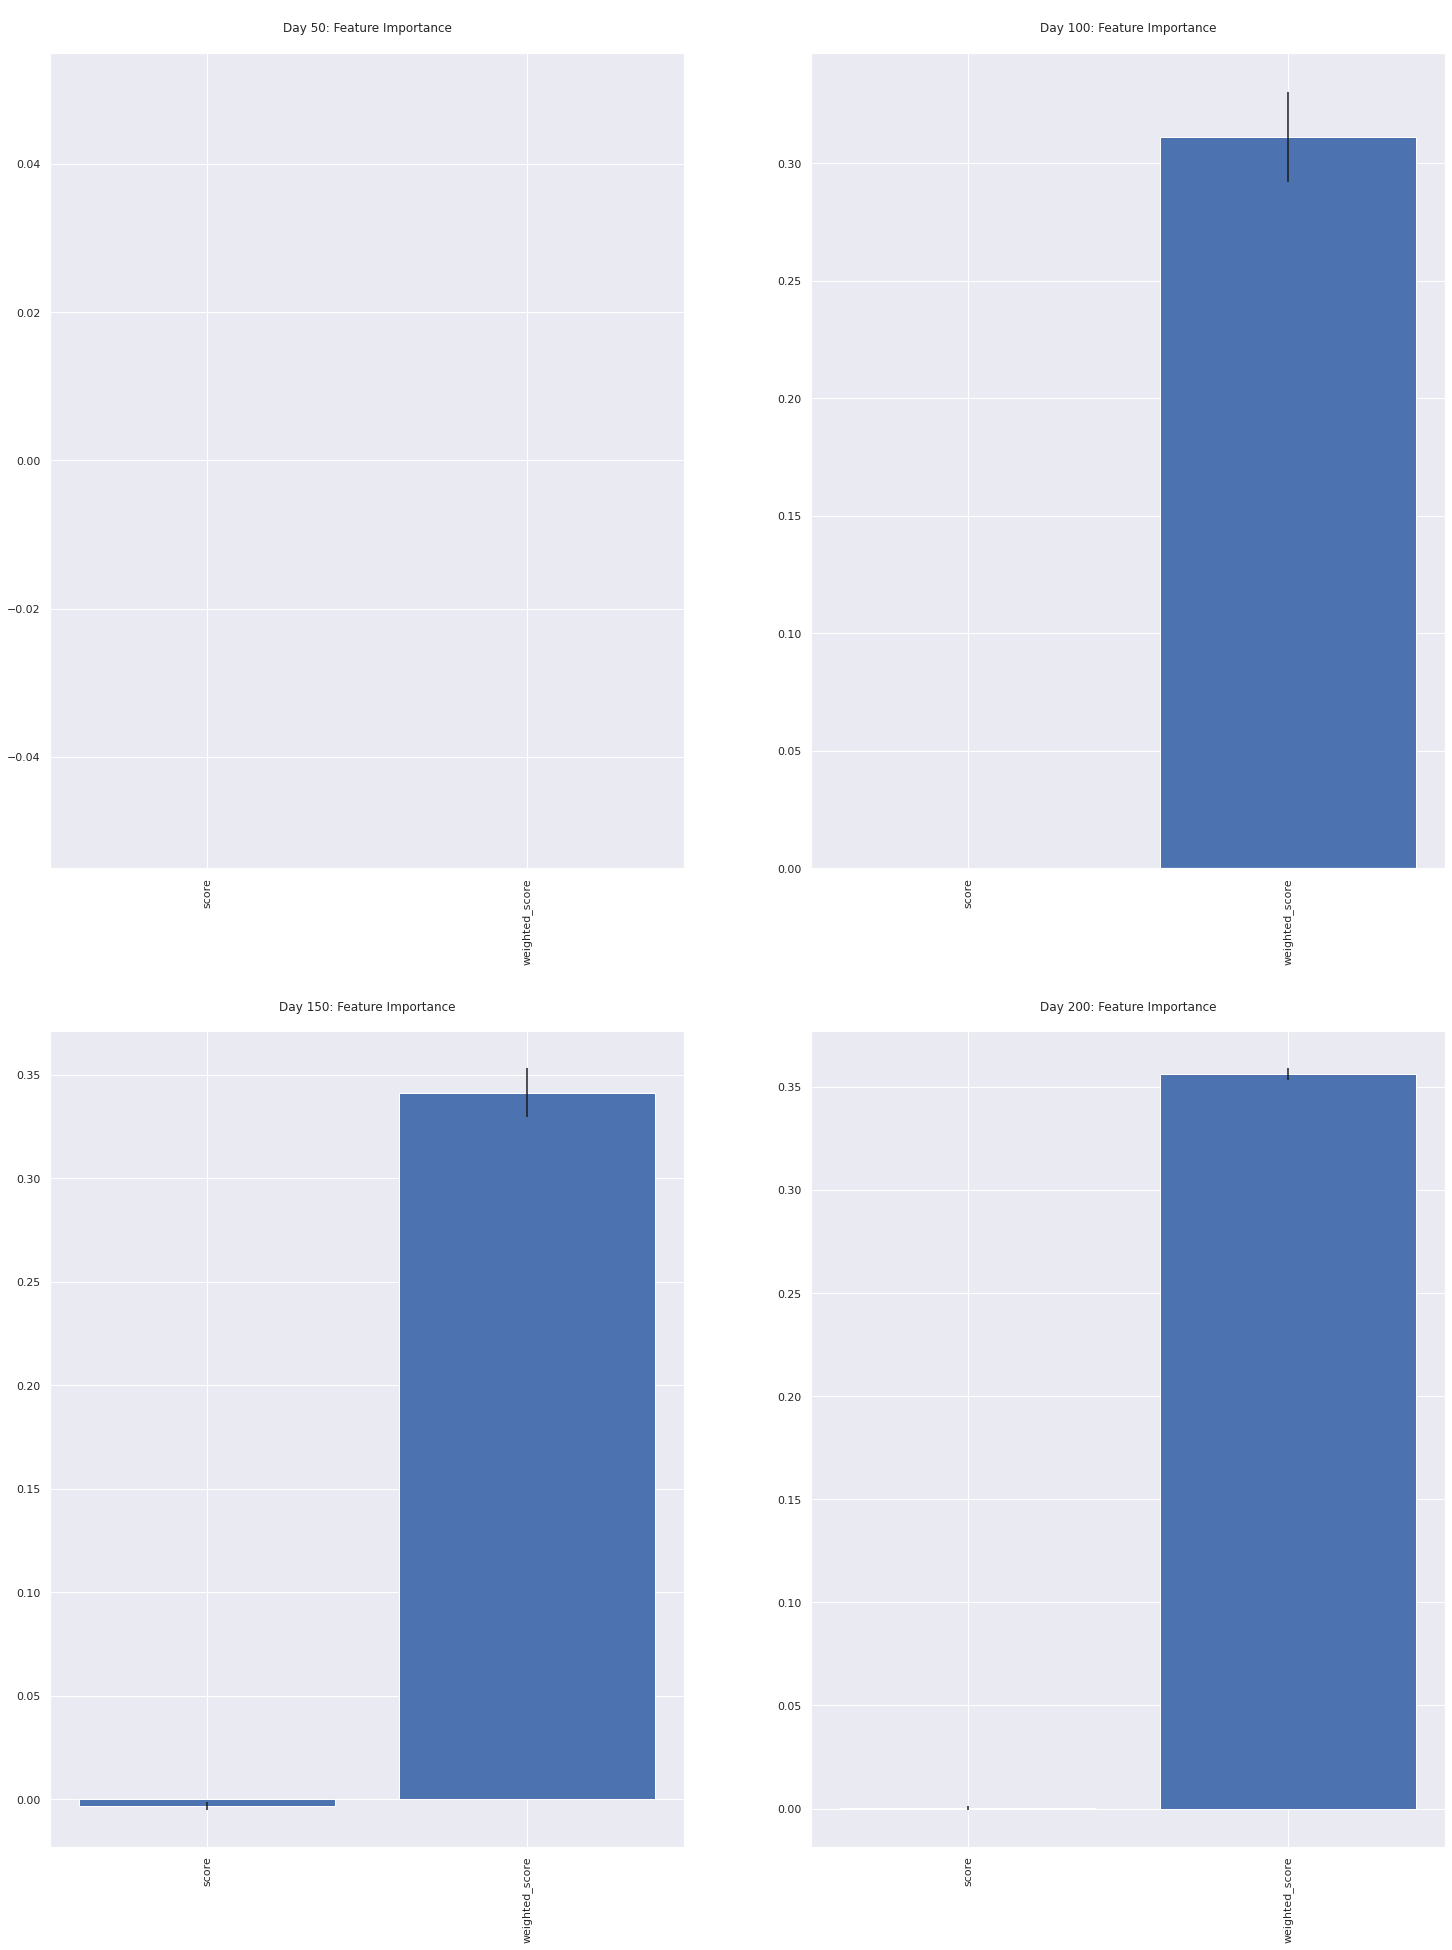

In [92]:
plot_feature_importance(performance_features_lrw)

##### RandomForest

In [93]:
from sklearn.ensemble import RandomForestClassifier

performance_results_rf = []
performance_features_rf = []

pipeline = Pipeline([
    ('clf', RandomForestClassifier(random_state=RANDOM_SEED, class_weight = 'balanced')),
])

params = {
  'clf__n_estimators': [x for x in range(50,150,10)]
}

for i in list(df.keys())[1:]:
  print(f"Day {i}")
  grid_search = GridSearchCV(pipeline , param_grid=params , n_jobs=-1, verbose=1, scoring='f1_macro', cv=3,)
  print("Performing grid search...")
  print("pipeline:", [name for name, _ in pipeline.steps])
  print("parameters:")
  print(params)
  tuned_model = grid_search.fit(X_train[i], Y_train[i])

  print("Best score: %0.3f" % grid_search.best_score_)
  print("Best parameters set:")
  best_parameters = grid_search.best_estimator_.get_params()
  for param_name in sorted(params.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

  predictions = tuned_model.predict(X_test[i])


  acc, f1, prec, recall, conf = evaluation_summary(predictions, Y_test[i])
  print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
  performance_results_rf.append([acc, f1, prec, recall, conf])
  performance_features_rf.append([tuned_model, X_test[i], Y_test[i]])
  print("\n")

Day 50
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__n_estimators': [50, 60, 70, 80, 90, 100, 110, 120, 130, 140]}
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best score: 0.729
Best parameters set:
	clf__n_estimators: 60
Accuracy: 0.242929659173314, F1 Score: 0.39089848308051345, Precision: 0.242929659173314, Recall: 1.0


Day 100
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__n_estimators': [50, 60, 70, 80, 90, 100, 110, 120, 130, 140]}
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best score: 0.811
Best parameters set:
	clf__n_estimators: 90
Accuracy: 0.8302023121387283, F1 Score: 0.6322378716744914, Precision: 0.6733333333333333, Recall: 0.5958702064896755


Day 150
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__n_estimators': [50, 60, 70, 80, 90, 100, 110, 120, 130, 140]}
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best score: 0.856
Best parameters set:
	clf__n_estimators: 70
Accuracy:

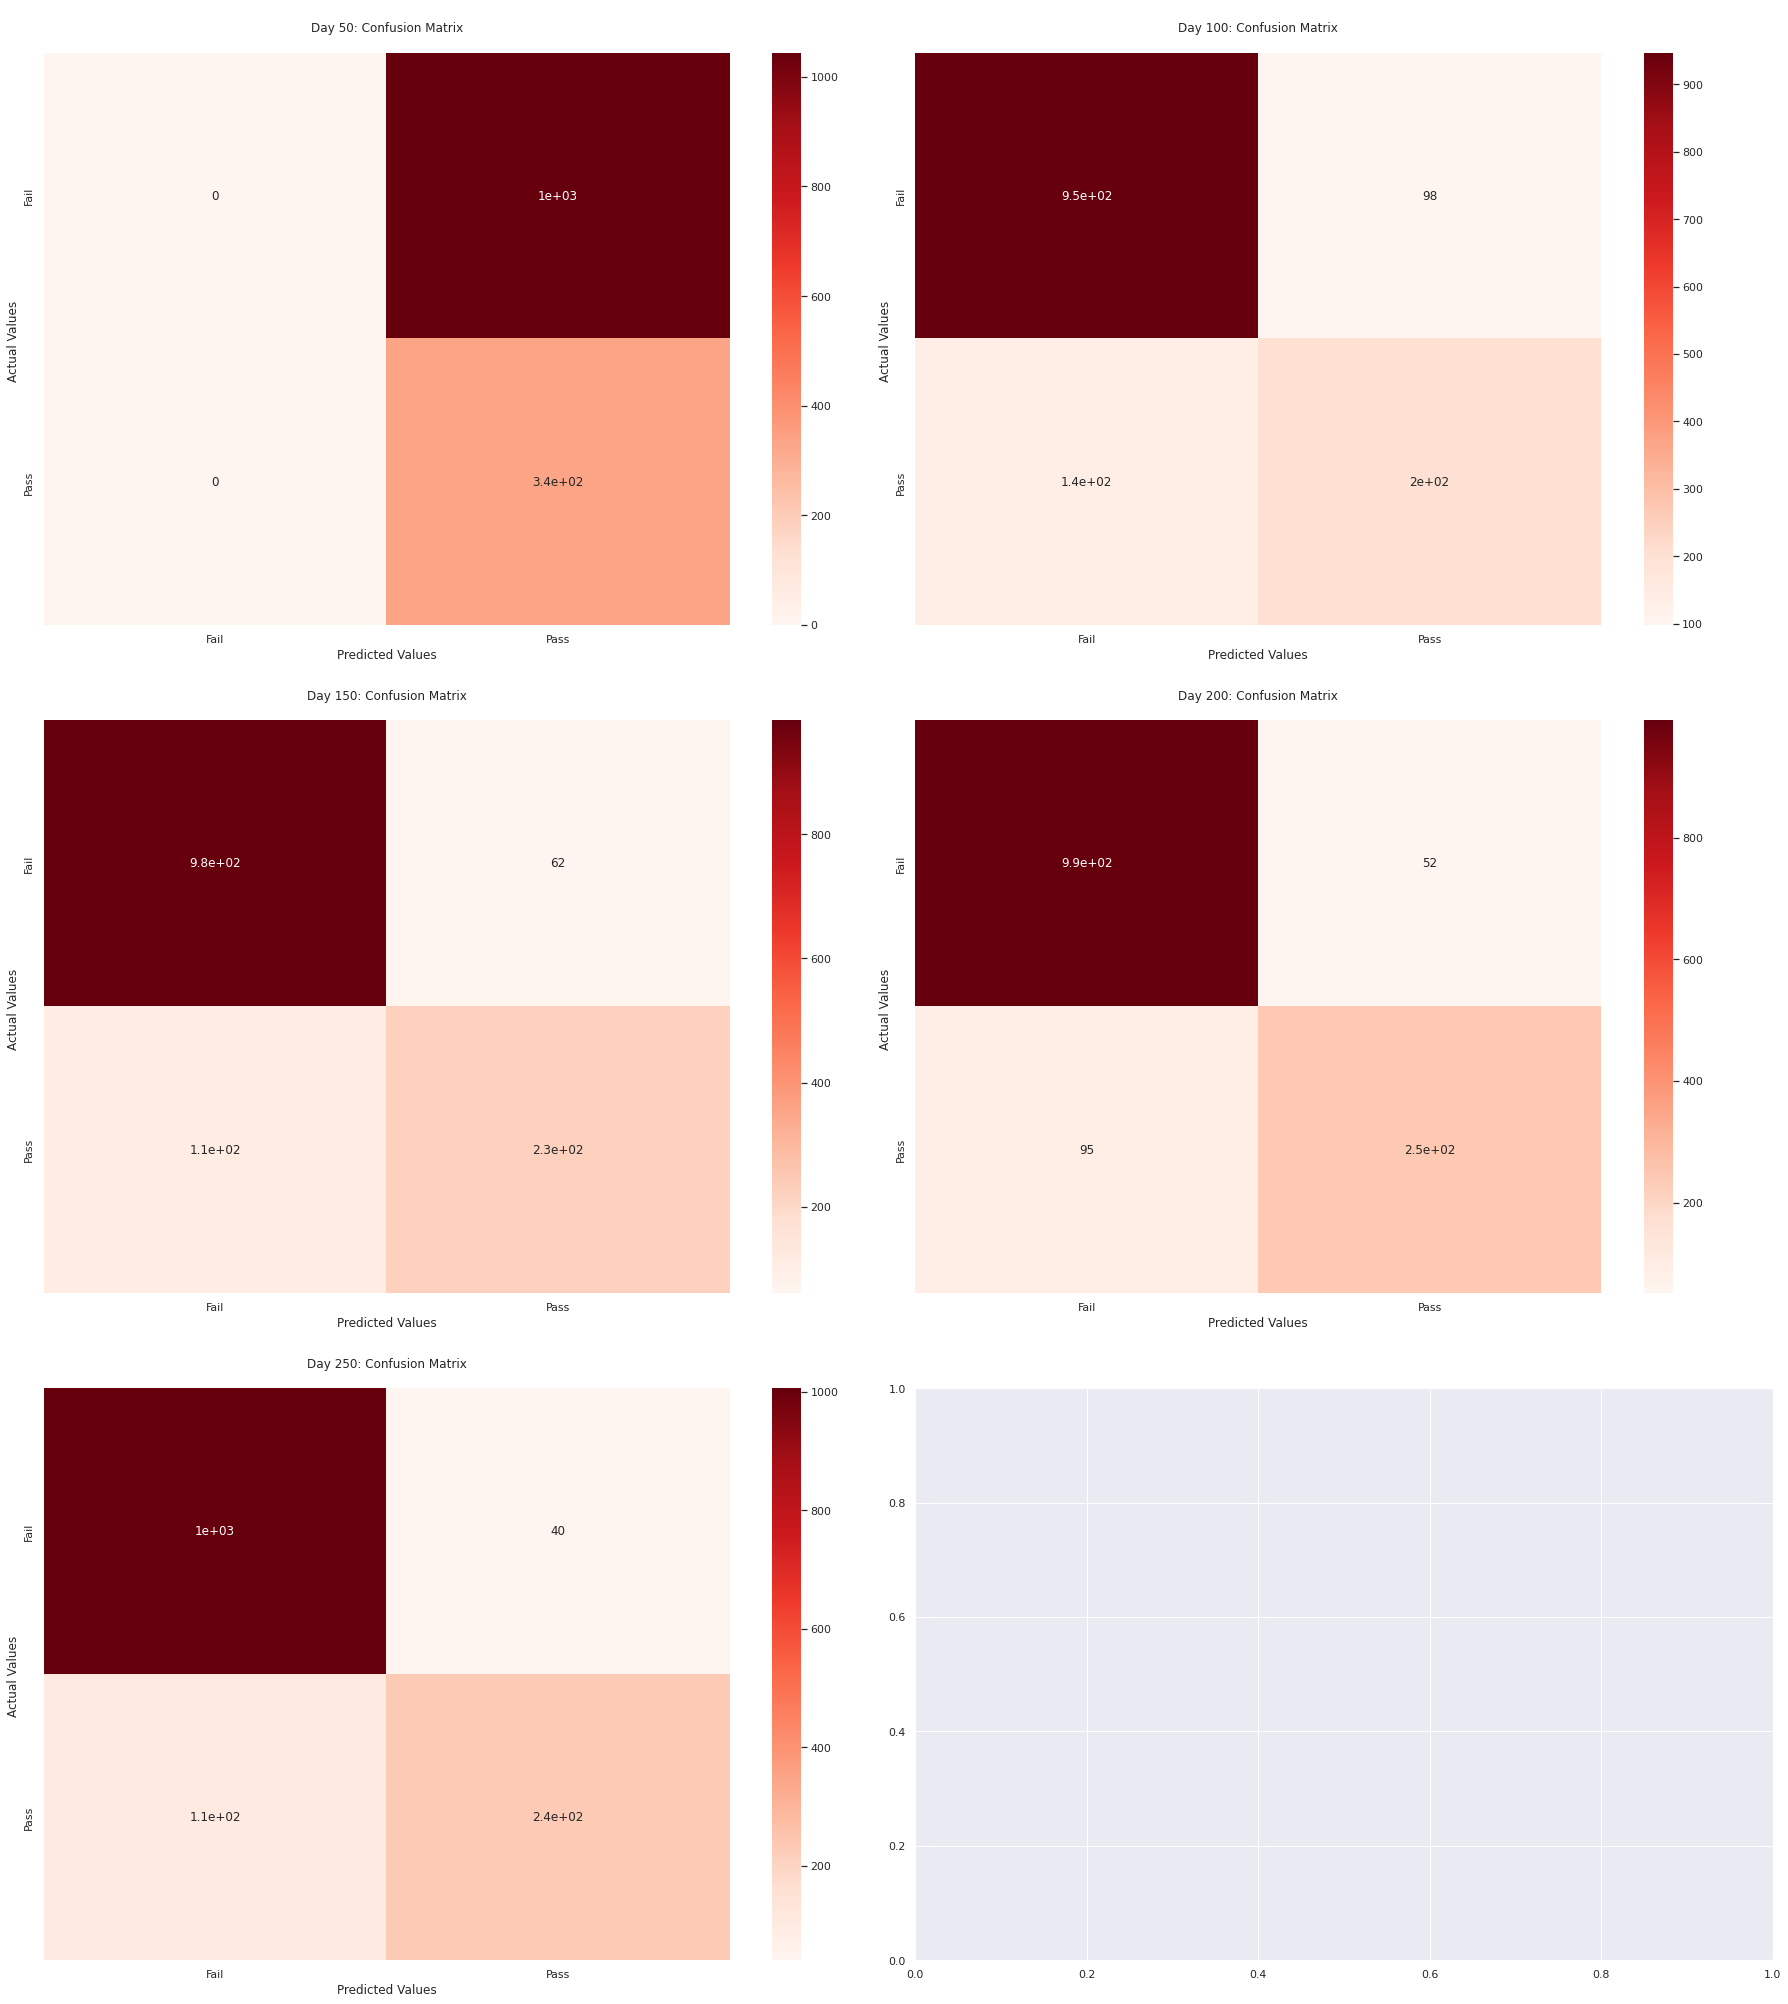

In [94]:
plot_confusion_matrix(performance_results_rf)

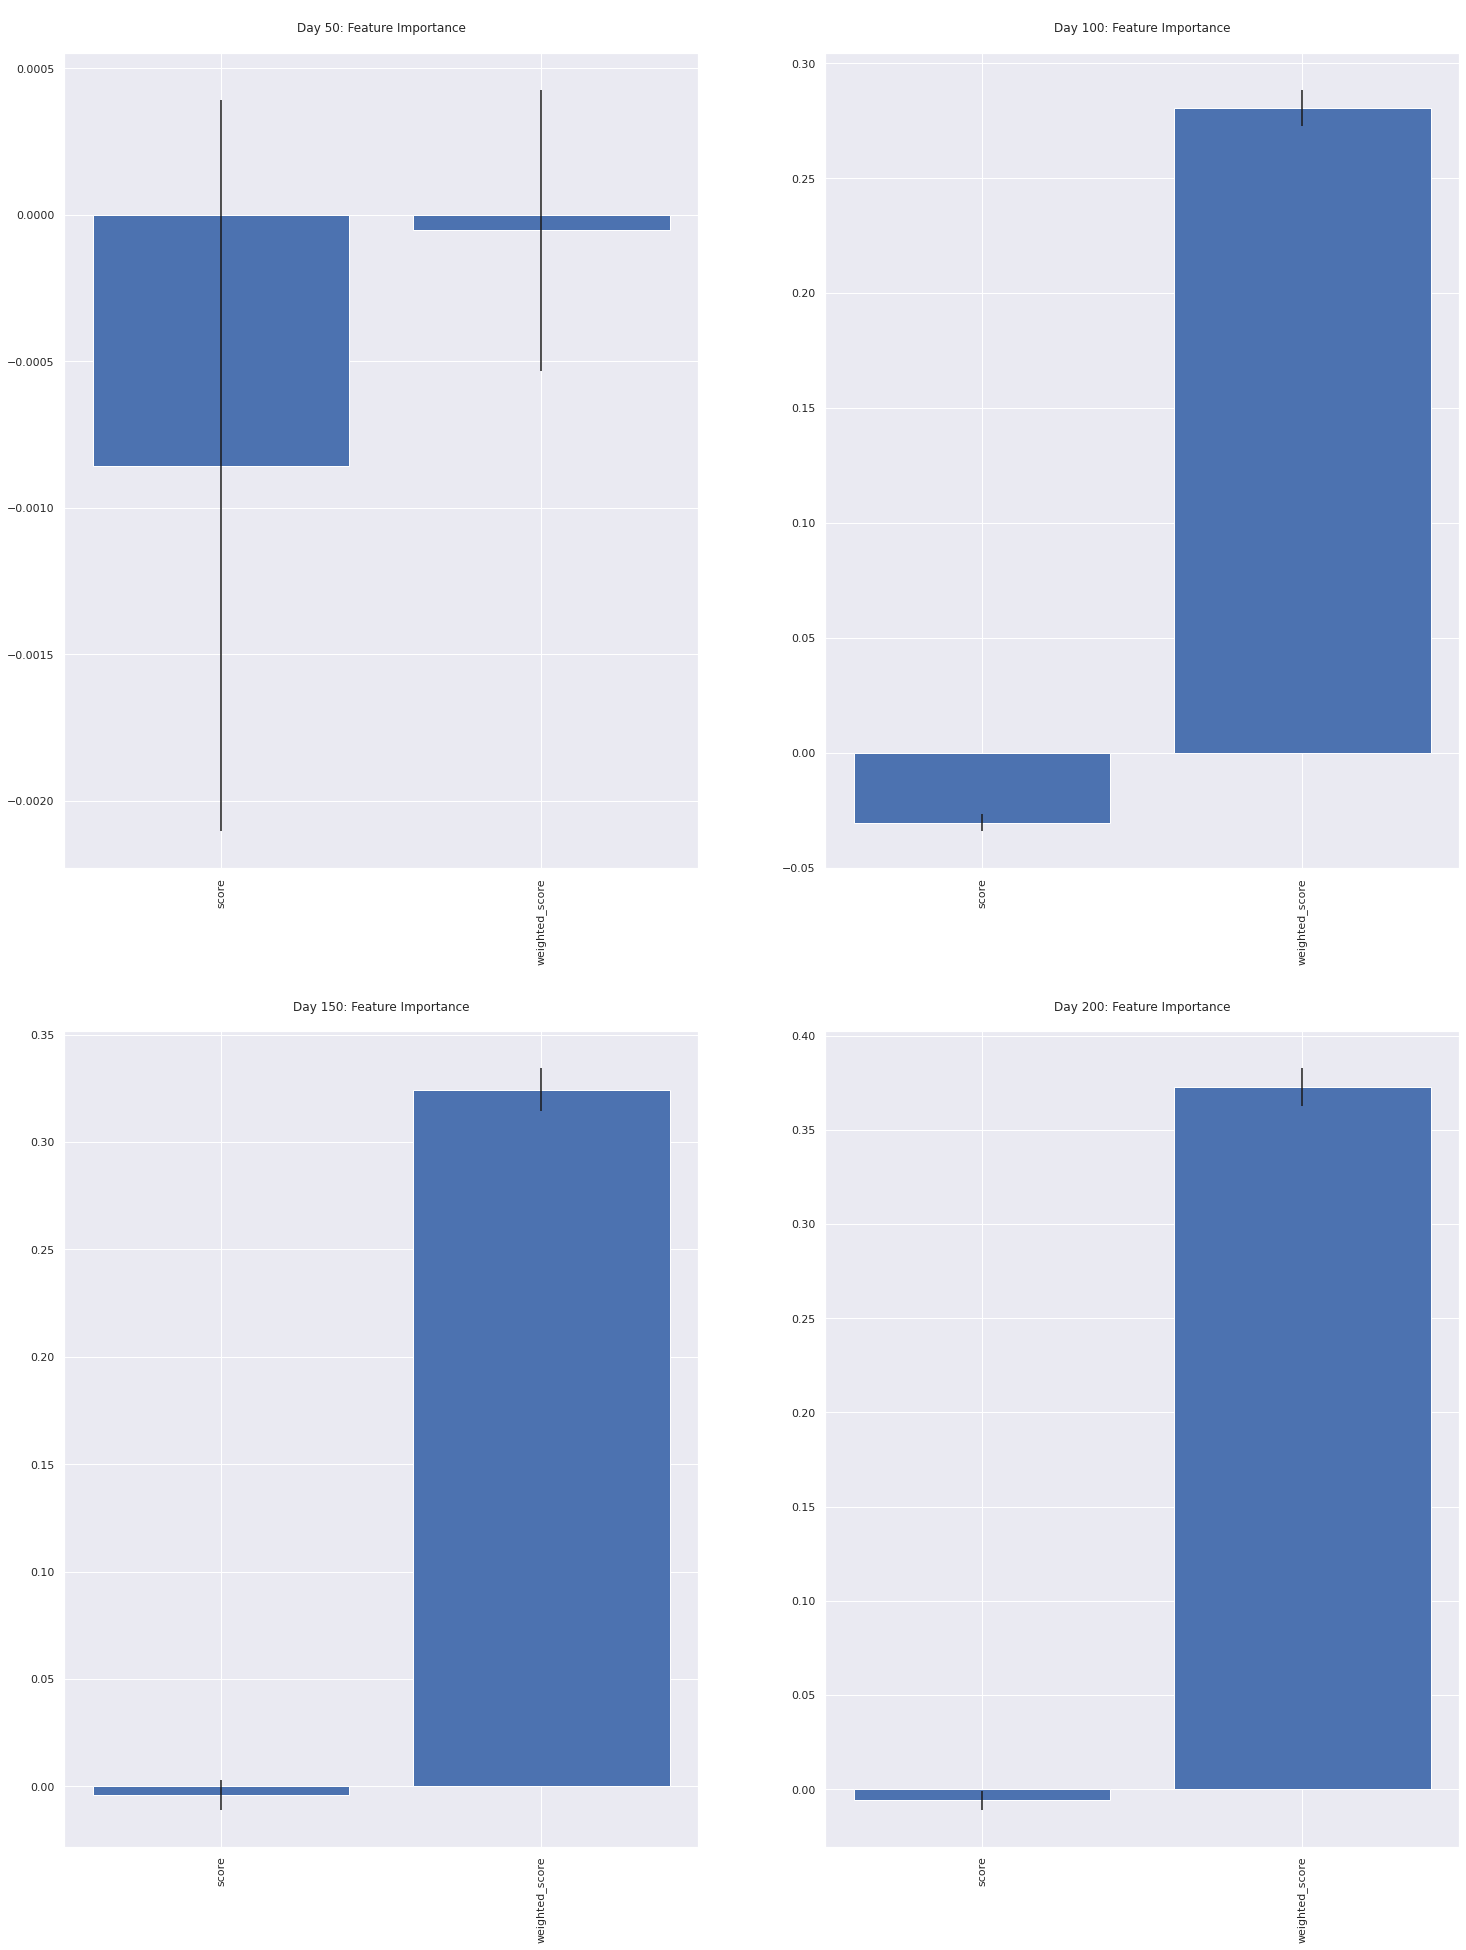

In [95]:
plot_feature_importance(performance_features_rf)

##### AdaBoost

In [96]:
from sklearn.ensemble import AdaBoostClassifier

performance_results_ab = []
performance_features_ab = []

pipeline = Pipeline([
    ('clf', AdaBoostClassifier(random_state=RANDOM_SEED)),
])

params = {
  'clf__learning_rate':(0.5,0.85,1,1.25,1.5,1.75)
}

for i in list(df.keys())[1:]:
  print(f"Day {i}")
  grid_search = GridSearchCV(pipeline , param_grid=params , n_jobs=-1, verbose=1, scoring='f1_macro', cv=3,)
  print("Performing grid search...")
  print("pipeline:", [name for name, _ in pipeline.steps])
  print("parameters:")
  print(params)
  tuned_model = grid_search.fit(X_train[i], Y_train[i])

  print("Best score: %0.3f" % grid_search.best_score_)
  print("Best parameters set:")
  best_parameters = grid_search.best_estimator_.get_params()
  for param_name in sorted(params.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

  predictions = tuned_model.predict(X_test[i])


  acc, f1, prec, recall, conf = evaluation_summary(predictions, Y_test[i])
  print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
  performance_results_ab.append([acc, f1, prec, recall, conf])
  performance_features_ab.append([tuned_model, X_test[i], Y_test[i]])
  print("\n")

Day 50
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__learning_rate': (0.5, 0.85, 1, 1.25, 1.5, 1.75)}
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best score: 0.704
Best parameters set:
	clf__learning_rate: 1.75
Accuracy: 0.30021754894851344, F1 Score: 0.40173589584624925, Precision: 0.2535211267605634, Recall: 0.9671641791044776


Day 100
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__learning_rate': (0.5, 0.85, 1, 1.25, 1.5, 1.75)}
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best score: 0.845
Best parameters set:
	clf__learning_rate: 0.5
Accuracy: 0.865606936416185, F1 Score: 0.6381322957198444, Precision: 0.9371428571428572, Recall: 0.4837758112094395


Day 150
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__learning_rate': (0.5, 0.85, 1, 1.25, 1.5, 1.75)}
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best score: 0.870
Best parameters set:
	clf__learning_rate: 1.75
Accuracy: 0.87734487734487

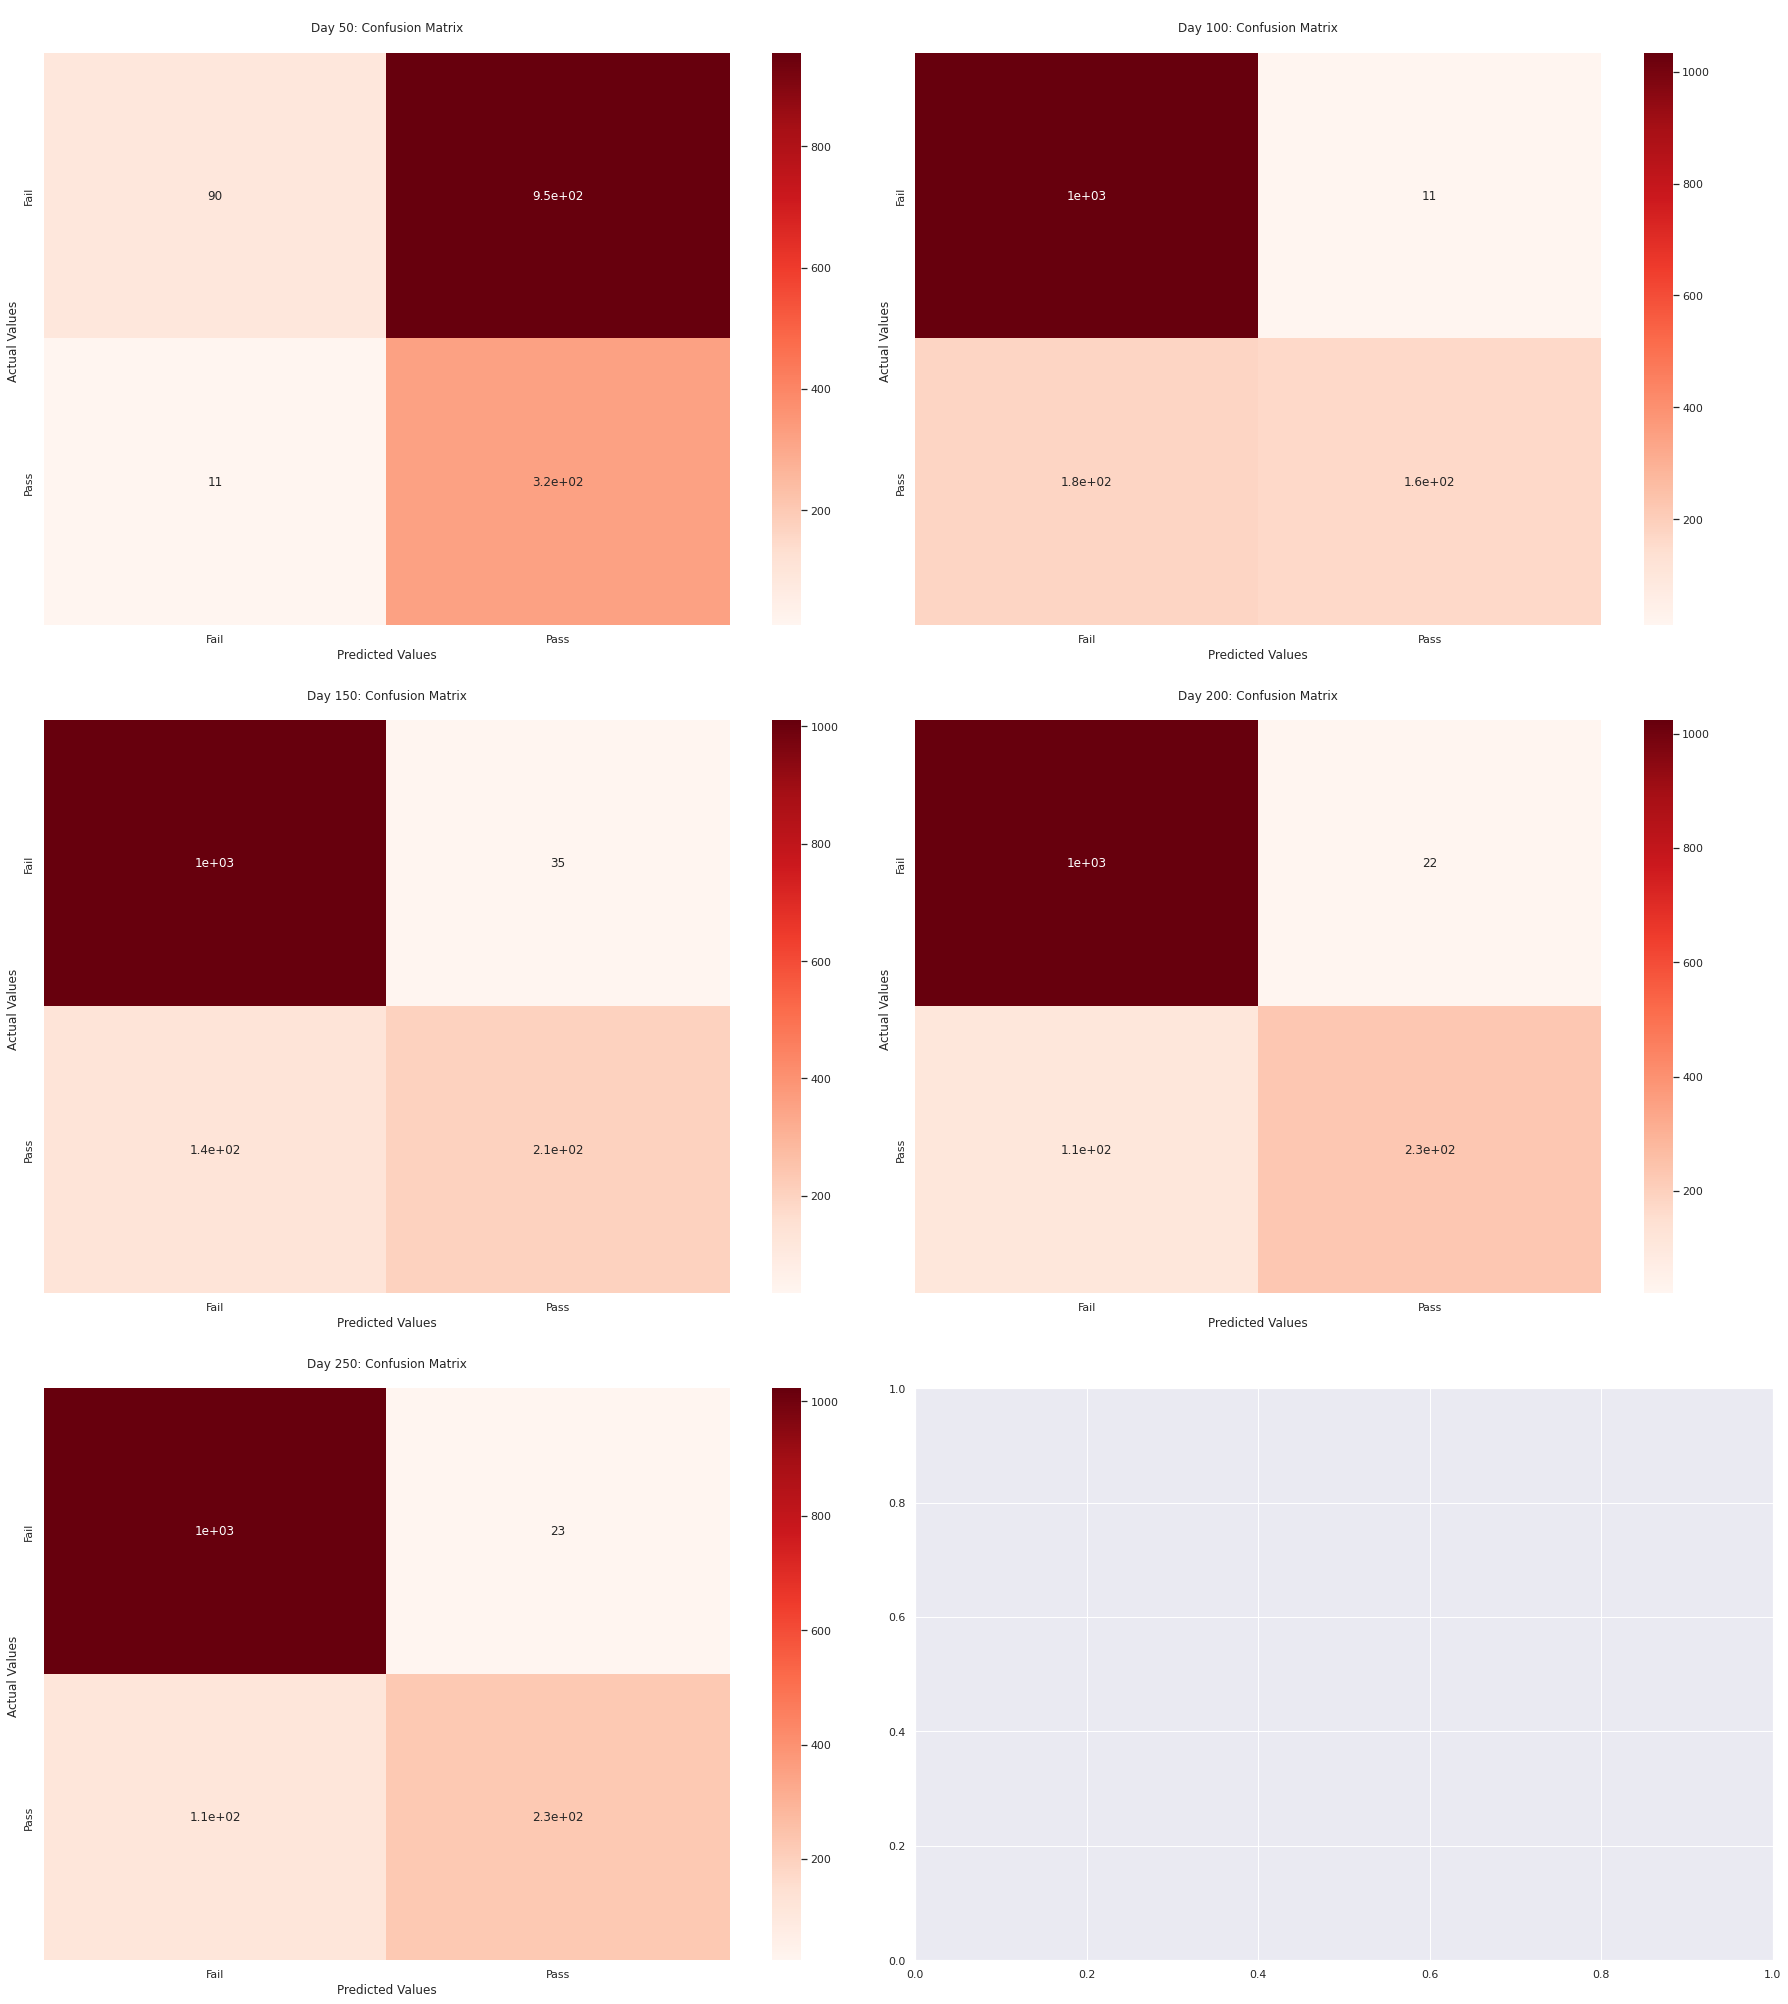

In [97]:
plot_confusion_matrix(performance_results_ab)

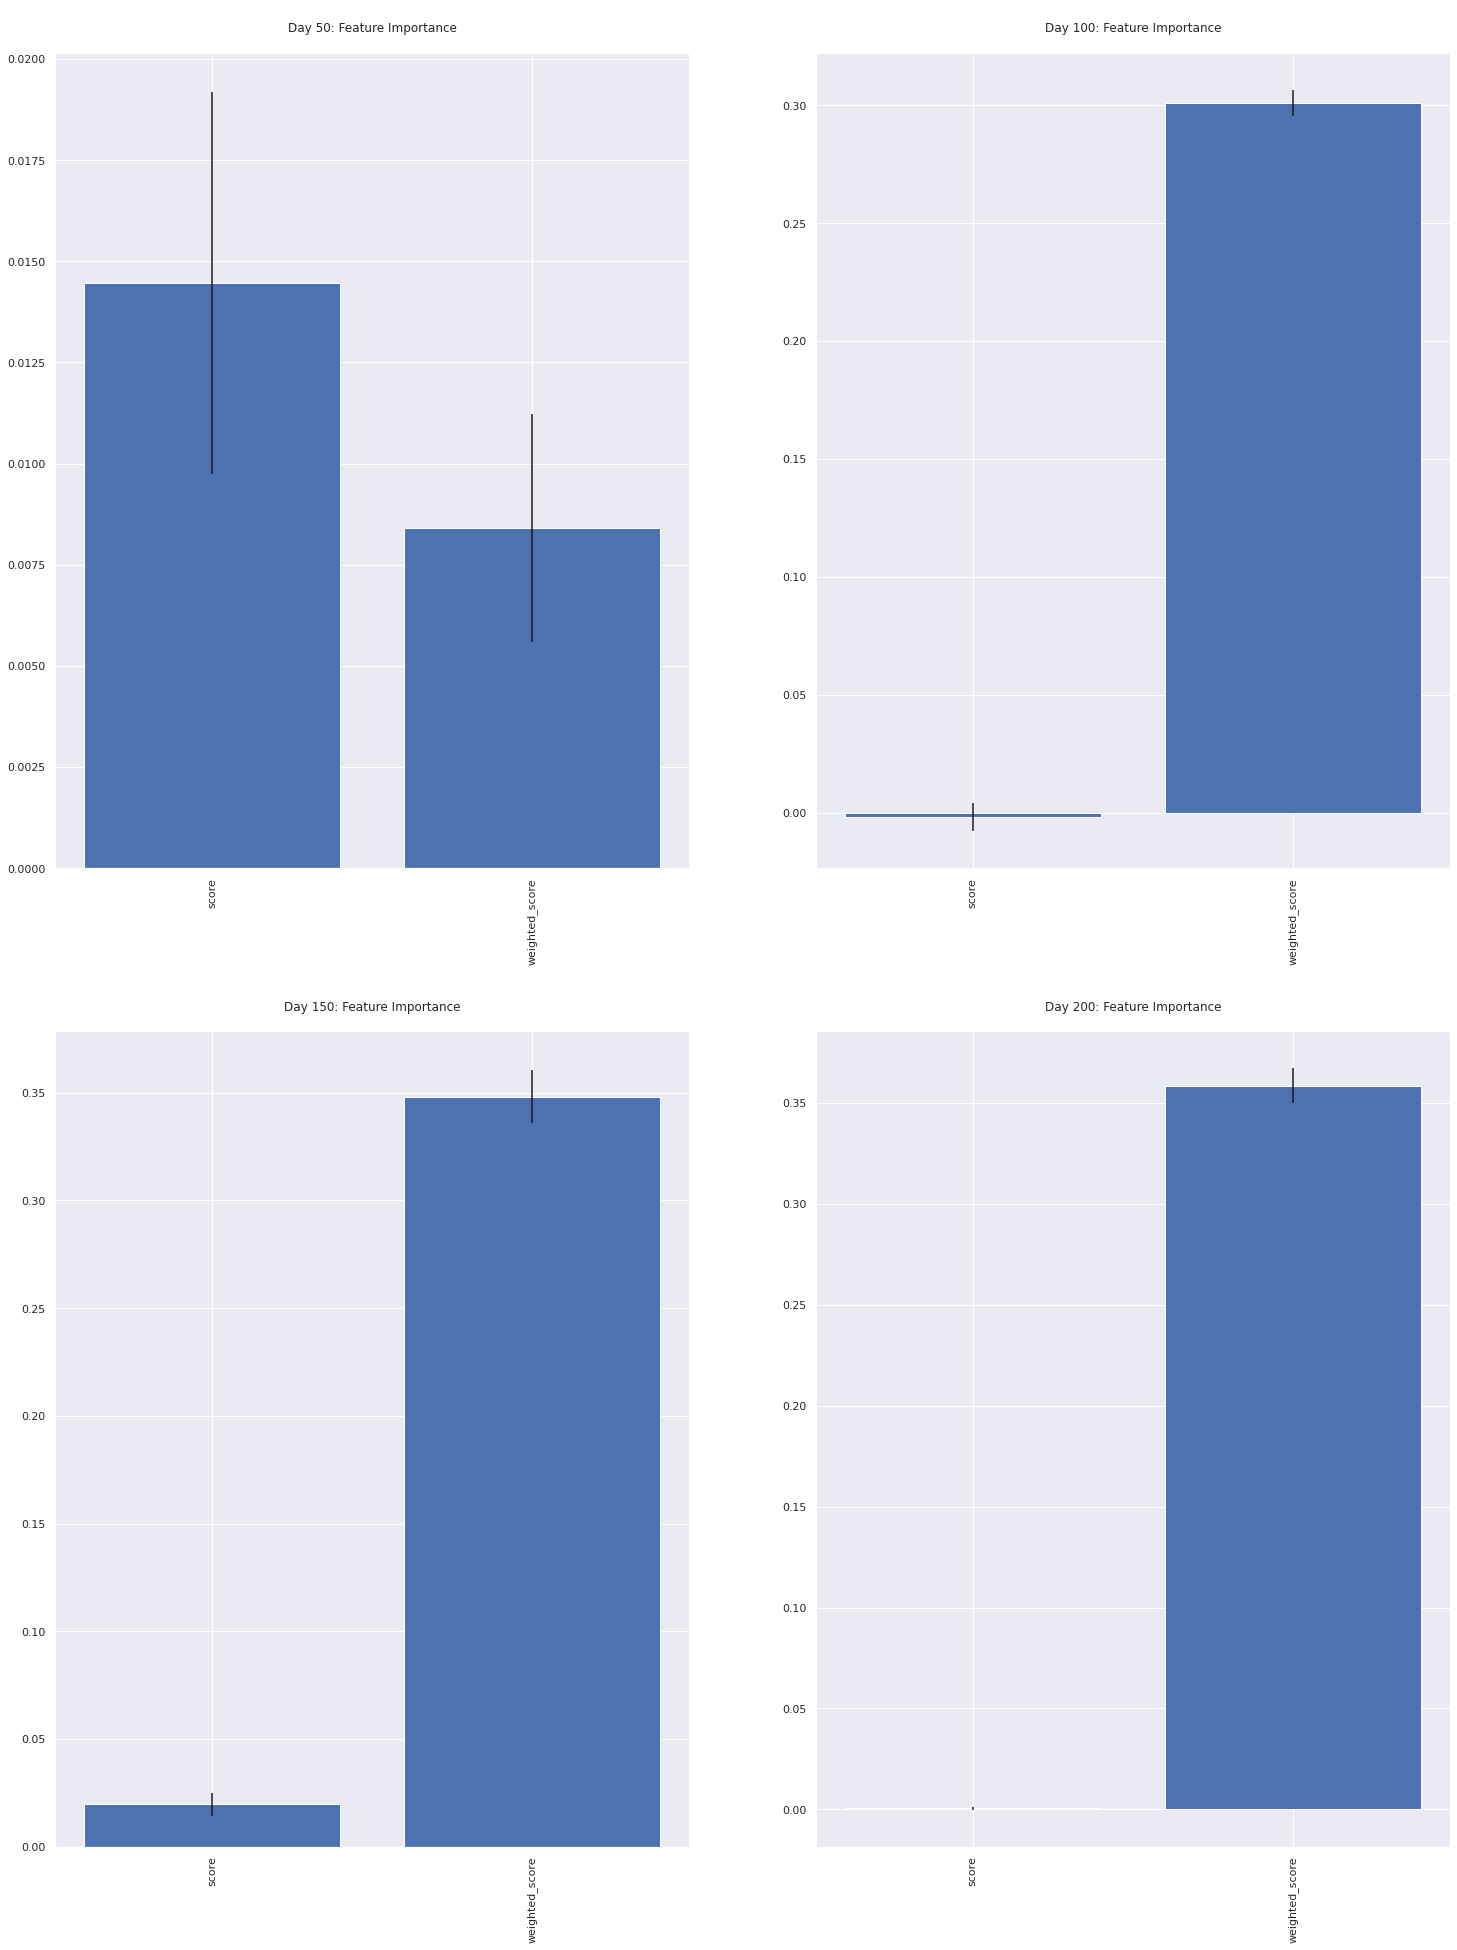

In [98]:
plot_feature_importance(performance_features_ab)

##### Plot results overview

In [99]:
performance_classifier_results = [performance_results_du, performance_results_nb, performance_results_lr, performance_results_lrw, performance_results_rf, performance_results_ab]
performance_classifier_labels = ["Dummy Classifier", "Naive Bayes", "Logistic Regression", "Logistic Regression Weighted", "Random Forest", "AdaBoost"]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-o

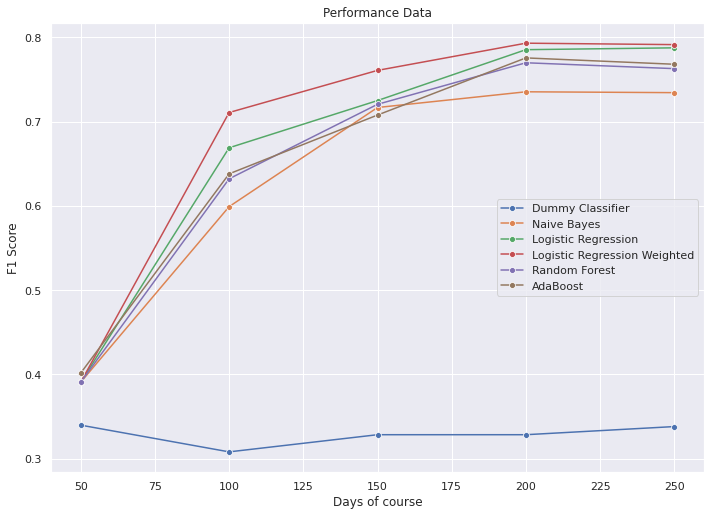

In [100]:
plot_days_compare(deadline_list[1:],performance_classifier_results,performance_classifier_labels, "Performance Data")

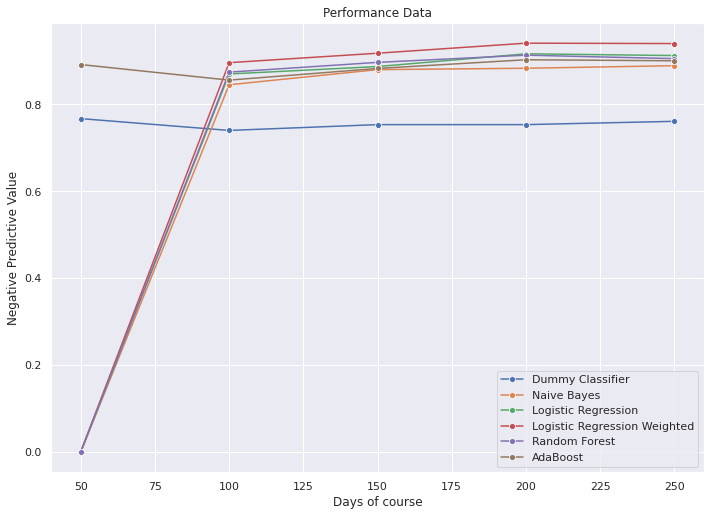

In [101]:
plot_days_compare_npv(deadline_list[1:],performance_classifier_results,performance_classifier_labels, "Performance Data")

#### All data (Demographic, Learning Behaviour, Performance)

- Demographic and learning behaviour used throughout classifier
- Performance added for the last two predictions (200, 250) days

##### Prepare data for prediction

In [102]:
all_df = {}
for i in df.keys():
  all_df[i] = split_dataframe_by_data_type(df[i], ['demographic','learning_behaviour', 'performance'], include_final_result=True)

In [103]:
all_df[50]

code_presentation  id_student gender                region  \
0                2013B       33915      F     South East Region   
1                2013B       35544      M                 Wales   
2                2013B       35860      M     South West Region   
3                2013B       42668      M         London Region   
4                2013B       43273      M  East Midlands Region   
...                ...         ...    ...                   ...   
4797             2014J     2681198      M   East Anglian Region   
4798             2014J     2682682      F  East Midlands Region   
4799             2014J     2683857      M     South West Region   
4800             2014J     2693932      M  West Midlands Region   
4801             2014J     2697921      M   East Anglian Region   

          highest_education imd_band age_band disability   subpage   forumng  \
0     A Level or Equivalent   30-40%     0-35          N  1.951613  3.160714   
1     A Level or Equivalent   80-90%    35-55          N  1.511111  3.368421   
2     A Level or Equivalent    10-20     0-35          N  1.522727  2.555556   
3        Lower Than A Level    10-20    35-55          N  1.764706  2.816327   
4          HE Qualification   60-70%    35-55          N  2.115385  1.875000   
...                     ...      ...      ...        ...       ...       ...   
4797     Lower Than A Level   70-80%    35-55          N  1.604396  2.400000   
4798  A Level or Equivalent   60-70%     0-35          Y  1.983607  3.237288   
4799     Lower Than A Level   70-80%    35-55          N  1.923077  3.166667   
4800  A Level or Equivalent  90-100%     0-35          N  1.826923  2.375000   
4801     Lower Than A Level   80-90%     0-35          N  1.375000  3.857143   

      ...  oucontent    ouwiki  glossary  mean_click  dualpane       url  \
0     ...   5.735849  3.600000       0.0    2.035698       1.0  1.285714   
1     ...   5.482759  3.500000       0.0    2.031767       0.0  1.600000   
2     ...   5.666667  3.000000       0.0    2.398983       3.0  1.153846   
3     ...   4.458333  3.000000       0.0    1.953818       0.0  1.285714   
4     ...   5.916667  0.000000       0.0    0.980550       0.0  1.200000   
...   ...        ...       ...       ...         ...       ...       ...   
4797  ...   4.561644  3.500000       1.0    2.205943       1.0  1.157895   
4798  ...   6.890909  2.727273       0.0    2.536430       0.0  1.000000   
4799  ...  17.108696  6.400000       0.0    3.368696       0.0  1.000000   
4800  ...   8.528302  1.333333       0.0    2.116638       0.0  1.333333   
4801  ...   5.888889  0.000000       0.0    2.207650       0.0  0.000000   

      page  score  weighted_score  final_result  
0      1.0   90.0          22.680             0  
1      1.5   86.0          21.672             0  
2      1.0   84.0          21.168             0  
3      1.5   74.0          18.648             0  
4      1.0   81.0          20.412             0  
...    ...    ...             ...           ...  
4797   1.0   66.0           8.316             0  
4798   1.0   96.0          12.096             0  
4799   1.0   72.0           9.072             0  
4800   1.0   90.0          11.340             0  
4801   0.0   94.0          11.844             0  

[4802 rows x 27 columns]

In [104]:
for i in list(df)[1:2]:
  all_df[i] = all_df[i].drop(columns=["score","weighted_score"])

for i in list(df)[2:]:
  all_df[i] = all_df[i].drop(columns=["score"])

In [105]:
all_df[50]

code_presentation  id_student gender                region  \
0                2013B       33915      F     South East Region   
1                2013B       35544      M                 Wales   
2                2013B       35860      M     South West Region   
3                2013B       42668      M         London Region   
4                2013B       43273      M  East Midlands Region   
...                ...         ...    ...                   ...   
4797             2014J     2681198      M   East Anglian Region   
4798             2014J     2682682      F  East Midlands Region   
4799             2014J     2683857      M     South West Region   
4800             2014J     2693932      M  West Midlands Region   
4801             2014J     2697921      M   East Anglian Region   

          highest_education imd_band age_band disability   subpage   forumng  \
0     A Level or Equivalent   30-40%     0-35          N  1.951613  3.160714   
1     A Level or Equivalent   80-90%    35-55          N  1.511111  3.368421   
2     A Level or Equivalent    10-20     0-35          N  1.522727  2.555556   
3        Lower Than A Level    10-20    35-55          N  1.764706  2.816327   
4          HE Qualification   60-70%    35-55          N  2.115385  1.875000   
...                     ...      ...      ...        ...       ...       ...   
4797     Lower Than A Level   70-80%    35-55          N  1.604396  2.400000   
4798  A Level or Equivalent   60-70%     0-35          Y  1.983607  3.237288   
4799     Lower Than A Level   70-80%    35-55          N  1.923077  3.166667   
4800  A Level or Equivalent  90-100%     0-35          N  1.826923  2.375000   
4801     Lower Than A Level   80-90%     0-35          N  1.375000  3.857143   

      ...  ouelluminate  htmlactivity  oucontent    ouwiki  glossary  \
0     ...      1.454545           0.0   5.735849  3.600000       0.0   
1     ...      0.000000           0.0   5.482759  3.500000       0.0   
2     ...      0.000000           0.0   5.666667  3.000000       0.0   
3     ...      0.000000           0.0   4.458333  3.000000       0.0   
4     ...      0.000000           0.0   5.916667  0.000000       0.0   
...   ...           ...           ...        ...       ...       ...   
4797  ...      0.000000           3.0   4.561644  3.500000       1.0   
4798  ...      0.000000           1.0   6.890909  2.727273       0.0   
4799  ...      0.000000           2.0  17.108696  6.400000       0.0   
4800  ...      0.000000           1.0   8.528302  1.333333       0.0   
4801  ...      0.000000           1.0   5.888889  0.000000       0.0   

      mean_click  dualpane       url  page  final_result  
0       2.035698       1.0  1.285714   1.0             0  
1       2.031767       0.0  1.600000   1.5             0  
2       2.398983       3.0  1.153846   1.0             0  
3       1.953818       0.0  1.285714   1.5             0  
4       0.980550       0.0  1.200000   1.0             0  
...          ...       ...       ...   ...           ...  
4797    2.205943       1.0  1.157895   1.0             0  
4798    2.536430       0.0  1.000000   1.0             0  
4799    3.368696       0.0  1.000000   1.0             0  
4800    2.116638       0.0  1.333333   1.0             0  
4801    2.207650       0.0  0.000000   0.0             0  

[4802 rows x 25 columns]

###### Encode data

In [106]:
X_train, X_test, Y_train, Y_test = encode_data(all_df, ["2013J"], "2014J")

Index(['gender', 'region', 'highest_education', 'imd_band', 'age_band',
       'disability'],
      dtype='object') Index(['subpage', 'forumng', 'quiz', 'questionnaire', 'oucollaborate',
       'homepage', 'resource', 'oucontent', 'ouwiki', 'glossary', 'mean_click',
       'dualpane', 'url', 'page'],
      dtype='object')
Index(['gender', 'region', 'highest_education', 'imd_band', 'age_band',
       'disability'],
      dtype='object') Index(['subpage', 'forumng', 'quiz', 'questionnaire', 'oucollaborate',
       'homepage', 'resource', 'oucontent', 'ouwiki', 'glossary', 'mean_click',
       'dualpane', 'url', 'page'],
      dtype='object')
Index(['gender', 'region', 'highest_education', 'imd_band', 'age_band',
       'disability'],
      dtype='object') Index(['subpage', 'forumng', 'repeatactivity', 'quiz', 'questionnaire',
       'oucollaborate', 'homepage', 'resource', 'oucontent', 'ouwiki',
       'glossary', 'mean_click', 'dualpane', 'url', 'page', 'weighted_score'],
      dtype='o

In [107]:
X_train[50]

gender_F  gender_M  region_East Anglian Region  \
1072       0.0       1.0                         0.0   
1073       0.0       1.0                         0.0   
1074       0.0       1.0                         0.0   
1075       0.0       1.0                         0.0   
1076       1.0       0.0                         0.0   
...        ...       ...                         ...   
2513       0.0       1.0                         0.0   
2514       0.0       1.0                         0.0   
2515       0.0       1.0                         0.0   
2516       0.0       1.0                         1.0   
2517       0.0       1.0                         0.0   

      region_East Midlands Region  region_Ireland  region_London Region  \
1072                          0.0             0.0                   0.0   
1073                          0.0             0.0                   0.0   
1074                          1.0             0.0                   0.0   
1075                          0.0             0.0                   0.0   
1076                          0.0             0.0                   0.0   
...                           ...             ...                   ...   
2513                          0.0             0.0                   0.0   
2514                          0.0             0.0                   0.0   
2515                          1.0             0.0                   0.0   
2516                          0.0             0.0                   0.0   
2517                          0.0             0.0                   0.0   

      region_North Region  region_North Western Region  region_Scotland  \
1072                  0.0                          0.0              0.0   
1073                  0.0                          0.0              0.0   
1074                  0.0                          0.0              0.0   
1075                  0.0                          0.0              0.0   
1076                  0.0                          0.0              1.0   
...                   ...                          ...              ...   
2513                  0.0                          0.0              0.0   
2514                  0.0                          0.0              0.0   
2515                  0.0                          0.0              0.0   
2516                  0.0                          0.0              0.0   
2517                  1.0                          0.0              0.0   

      region_South East Region  ...  oucollaborate  homepage  resource  \
1072                       1.0  ...       0.000000  0.086810  0.144643   
1073                       0.0  ...       0.066667  0.232355  0.178022   
1074                       0.0  ...       0.000000  0.070837  0.151948   
1075                       0.0  ...       0.000000  0.102662  0.154286   
1076                       0.0  ...       0.000000  0.167500  0.150000   
...                        ...  ...            ...       ...       ...   
2513                       0.0  ...       0.193333  0.208344  0.300000   
2514                       0.0  ...       0.066667  0.063950  0.141872   
2515                       0.0  ...       0.000000  0.069764  0.128571   
2516                       0.0  ...       0.066667  0.110978  0.128571   
2517                       0.0  ...       0.000000  0.041322  0.128571   

      oucontent    ouwiki  glossary  mean_click  dualpane       url      page  
1072   0.297030  0.274566       0.0    0.304388  0.000000  0.185185  0.178571  
1073   0.425482  0.263584       0.0    0.416959  0.148148  0.166667  0.142857  
1074   0.315017  0.109827       0.0    0.293075  0.000000  0.194444  0.452381  
1075   0.418608  0.256262       0.0    0.359969  0.074074  0.166667  0.500000  
1076   0.270056  0.159748       0.0    0.355078  0.185185  0.196970  0.142857  
...         ...       ...       ...         ...       ...       ...       ...  
2513   0.339260  0.074882       0.0    0.393749  0.000000  0.166667  0.190476  
25

###### Undersampling

In [108]:
Y_train[50].value_counts()

0    1028
1     418
Name: final_result, dtype: int64

In [109]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks

from collections import Counter

X_train_sample, Y_train_sample = {},{}

for i in df.keys():

  sampler = TomekLinks() # fit predictor and target variable
  X_train_sample[i], Y_train_sample[i] = sampler.fit_resample(X_train[i], Y_train[i])

  print(f"Sampling for day {i}")
  print('Original dataset shape:', Counter(Y_train[i]))
  print('Resample dataset shape', Counter(Y_train_sample[i]))

Sampling for day 0
Original dataset shape: Counter({0: 984, 1: 407})
Resample dataset shape Counter({0: 844, 1: 407})
Sampling for day 50
Original dataset shape: Counter({0: 1028, 1: 418})
Resample dataset shape Counter({0: 882, 1: 418})
Sampling for day 100
Original dataset shape: Counter({0: 1028, 1: 418})
Resample dataset shape Counter({0: 909, 1: 418})
Sampling for day 150
Original dataset shape: Counter({0: 1028, 1: 419})
Resample dataset shape Counter({0: 917, 1: 419})
Sampling for day 200
Original dataset shape: Counter({0: 1028, 1: 419})
Resample dataset shape Counter({0: 925, 1: 419})
Sampling for day 250
Original dataset shape: Counter({0: 1028, 1: 425})
Resample dataset shape Counter({0: 940, 1: 425})


###### Reduce dimensions

In [110]:
for i in df.keys():
  pca = PCA(n_components='mle')

  X_train[i] = pca.fit_transform(X_train[i], Y_train[i])                             
  
  X_test[i] = pca.transform(X_test[i])

In [111]:
X_train[250].shape

(1453, 46)

###### Feature selection

In [112]:
for i in df.keys():
  feature_selection_transformer = SelectKBest(score_func=f_classif, k=20)

  X_train[i] = pd.DataFrame(feature_selection_transformer.fit_transform(X_train[i], Y_train[i]))
  
  X_test[i] = pd.DataFrame(feature_selection_transformer.transform(X_test[i]))

In [113]:
X_train[250]

0         1         2         3         4         5         6   \
0     0.622762  1.109845 -0.470504  0.219535  0.147788 -0.438592 -0.263861   
1     0.551880 -0.580229 -0.096281 -0.333289 -0.272929  0.224236  0.120910   
2    -0.693986 -0.213145 -0.268482  0.085938 -0.140758 -0.177993 -0.102013   
3    -0.743738 -0.065762 -0.306660 -0.286394 -0.242151 -0.154037 -0.115030   
4     1.094906  0.916048  1.065543 -0.032496 -0.092277 -0.421218 -0.043797   
...        ...       ...       ...       ...       ...       ...       ...   
1448 -0.717920 -0.242196 -0.182929 -0.158943  1.515329  0.313347  0.439396   
1449 -0.670698 -0.192673 -0.236074  0.384269  0.050135 -0.343177 -0.006255   
1450  0.608375 -0.748491 -0.279832  0.099880 -0.131963 -0.532860 -0.221534   
1451  0.555144 -0.608178 -0.165453 -0.487876 -0.143662 -0.289018  0.021210   
1452  0.500545 -0.625872 -0.126948 -0.106493 -0.117892 -0.236118 -0.053343   

            7         8         9         10        11        12        13  \
0    -0.090497 -0.338522  0.064489 -0.301148 -0.449817  0.061471 -0.233481   
1     0.542669  0.302519 -0.099010 -0.026969  0.006896  0.039323  0.184654   
2     0.318108  0.233910 -0.002839 -0.279997  0.752224  0.084397  0.009793   
3    -0.065585 -0.125422  0.377514 -0.298002  0.264210 -0.030661 -0.131066   
4     0.247274  0.030868 -0.507632  0.168573 -0.151817  0.153726  0.011864   
...        ...       ...       ...       ...       ...       ...       ...   
1448 -0.212349  0.015138  0.087528  0.095368 -0.185550  0.540767 -0.123682   
1449  0.387380  0.186485  0.274063  0.322496 -0.021709  0.229938 -0.181560   
1450  0.069872 -0.362094 -0.213409  0.043515  0.554663  0.362489  0.043920   
1451 -0.035051 -0.620358 -0.674652 -0.280648 -0.008862  0.122896 -0.016464   
1452  0.112188 -0.135358 -0.108653  0.612076 -0.077089 -0.166377 -0.113565   

            14        15        16        17        18        19  
0    -0.054353 -0.051223 -0.051490  0.200804 -0.087413  0.006897  
1     0.021088 -0.195607  0.017602 -0.137190  0.006164 -0.005729  
2     0.054387 -0.362739  0.065423  0.070682 -0.277501  0.004403  
3     0.123441 -0.352209  0.090498 -0.066450 -0.153306 -0.005222  
4     0.037984  0.104134  0.002873 -0.147268 -0.127174  0.001928  
...        ...       ...       ...       ...       ...       ...  
1448 -0.138463  0.182125 -0.053399  0.069319  0.288893 -0.011533  
1449  0.107138 -0.590488  0.100606  0.130403 -0.065697  0.009566  
1450  0.048895 -0.049551 -0.010617 -0.445152 -0.069341 -0.002513  
1451 -0.143631  0.241003 -0.091706  0.048541  0.128576 -0.002735  
1452  0.749745  0.555411 -0.414861 -0.122173  0.068033  0.005267  

[1453 rows x 20 columns]

##### DummyClassifier

In [114]:
from sklearn.dummy import DummyClassifier

all_results_du = []
all_features_du = []

pipeline = Pipeline([
    ('clf', DummyClassifier(strategy="uniform",random_state=RANDOM_SEED)),
])

params = {
}

for i in df.keys():
  print(f"Day {i}")
  grid_search = GridSearchCV(pipeline , param_grid=params , n_jobs=-1, verbose=1, scoring='f1_macro', cv=3,)
  print("Performing grid search...")
  print("pipeline:", [name for name, _ in pipeline.steps])
  print("parameters:")
  print(params)
  tuned_model = grid_search.fit(X_train[i], Y_train[i])

  print("Best score: %0.3f" % grid_search.best_score_)
  print("Best parameters set:")
  best_parameters = grid_search.best_estimator_.get_params()
  for param_name in sorted(params.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

  predictions = tuned_model.predict(X_test[i])


  acc, f1, prec, recall, conf = evaluation_summary(predictions, Y_test[i])
  print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
  all_results_du.append([acc, f1, prec, recall, conf])
  all_features_du.append([tuned_model, X_test[i], Y_test[i]])
  print("\n")

Day 0
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.470
Best parameters set:
Accuracy: 0.4939301972685888, F1 Score: 0.3214649033570702, Precision: 0.2404870624048706, Recall: 0.48466257668711654


Day 50
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.433
Best parameters set:
Accuracy: 0.5097897026831038, F1 Score: 0.33984375, Precision: 0.2525399129172714, Recall: 0.5194029850746269


Day 100
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.433
Best parameters set:
Accuracy: 0.4841040462427746, F1 Score: 0.3081395348837209, Precision: 0.22943722943722944, Recall: 0.4690265486725664


Day 150
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.433
Best param

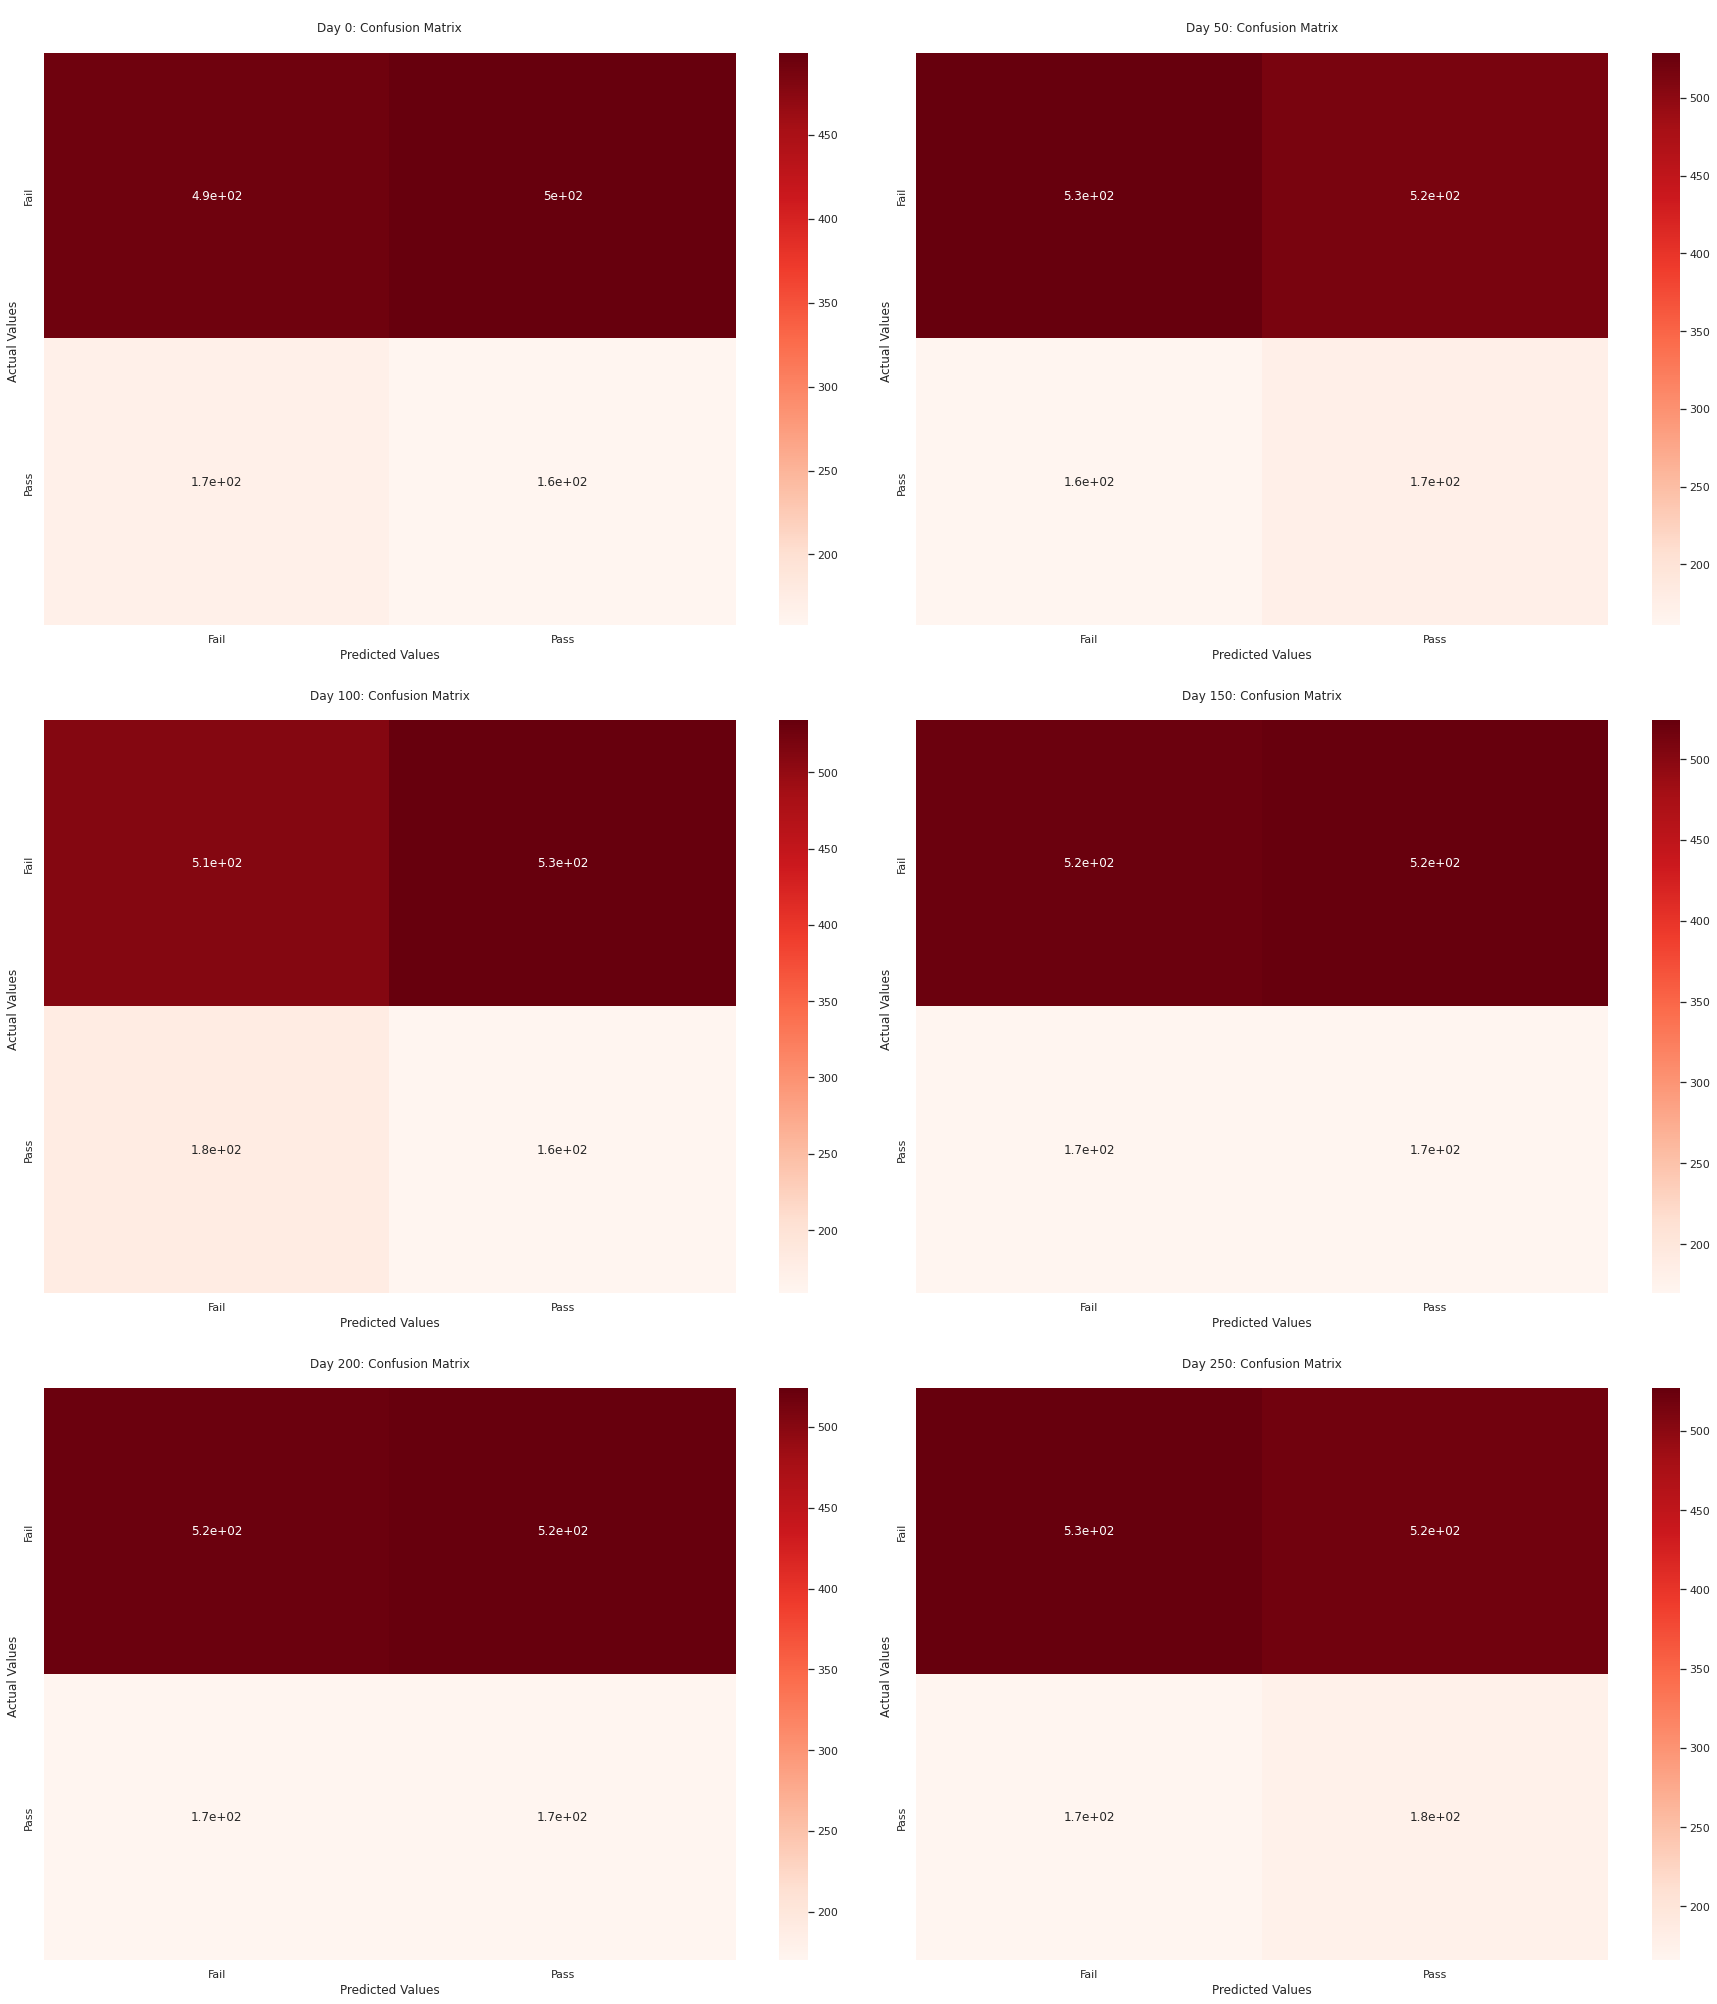

In [115]:
plot_confusion_matrix(all_results_du)

##### NaiveBayes

In [116]:
from sklearn.naive_bayes import GaussianNB,ComplementNB,BernoulliNB,MultinomialNB

all_results_nb = []

pipeline = Pipeline([
    ('clf', GaussianNB()),
])

params = {
}

for i in df.keys():
  print(f"Day {i}")
  grid_search = GridSearchCV(pipeline , param_grid=params , n_jobs=-1, verbose=1, scoring='f1_macro', cv=3,)
  print("Performing grid search...")
  print("pipeline:", [name for name, _ in pipeline.steps])
  print("parameters:")
  print(params)
  tuned_model = grid_search.fit(X_train[i], Y_train[i])

  print("Best score: %0.3f" % grid_search.best_score_)
  print("Best parameters set:")
  best_parameters = grid_search.best_estimator_.get_params()
  for param_name in sorted(params.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

  predictions = tuned_model.predict(X_test[i])


  acc, f1, prec, recall, conf = evaluation_summary(predictions, Y_test[i])
  print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
  all_results_nb.append([acc, f1, prec, recall, conf])

  print("\n")

Day 0
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.609
Best parameters set:
Accuracy: 0.6949924127465857, F1 Score: 0.39457831325301207, Precision: 0.3875739644970414, Recall: 0.401840490797546


Day 50
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.654
Best parameters set:
Accuracy: 0.728788977519942, F1 Score: 0.47471910112359555, Precision: 0.4482758620689655, Recall: 0.5044776119402985


Day 100
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.712
Best parameters set:
Accuracy: 0.8208092485549133, F1 Score: 0.4767932489451477, Precision: 0.837037037037037, Recall: 0.3333333333333333


Day 150
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.701
Best 

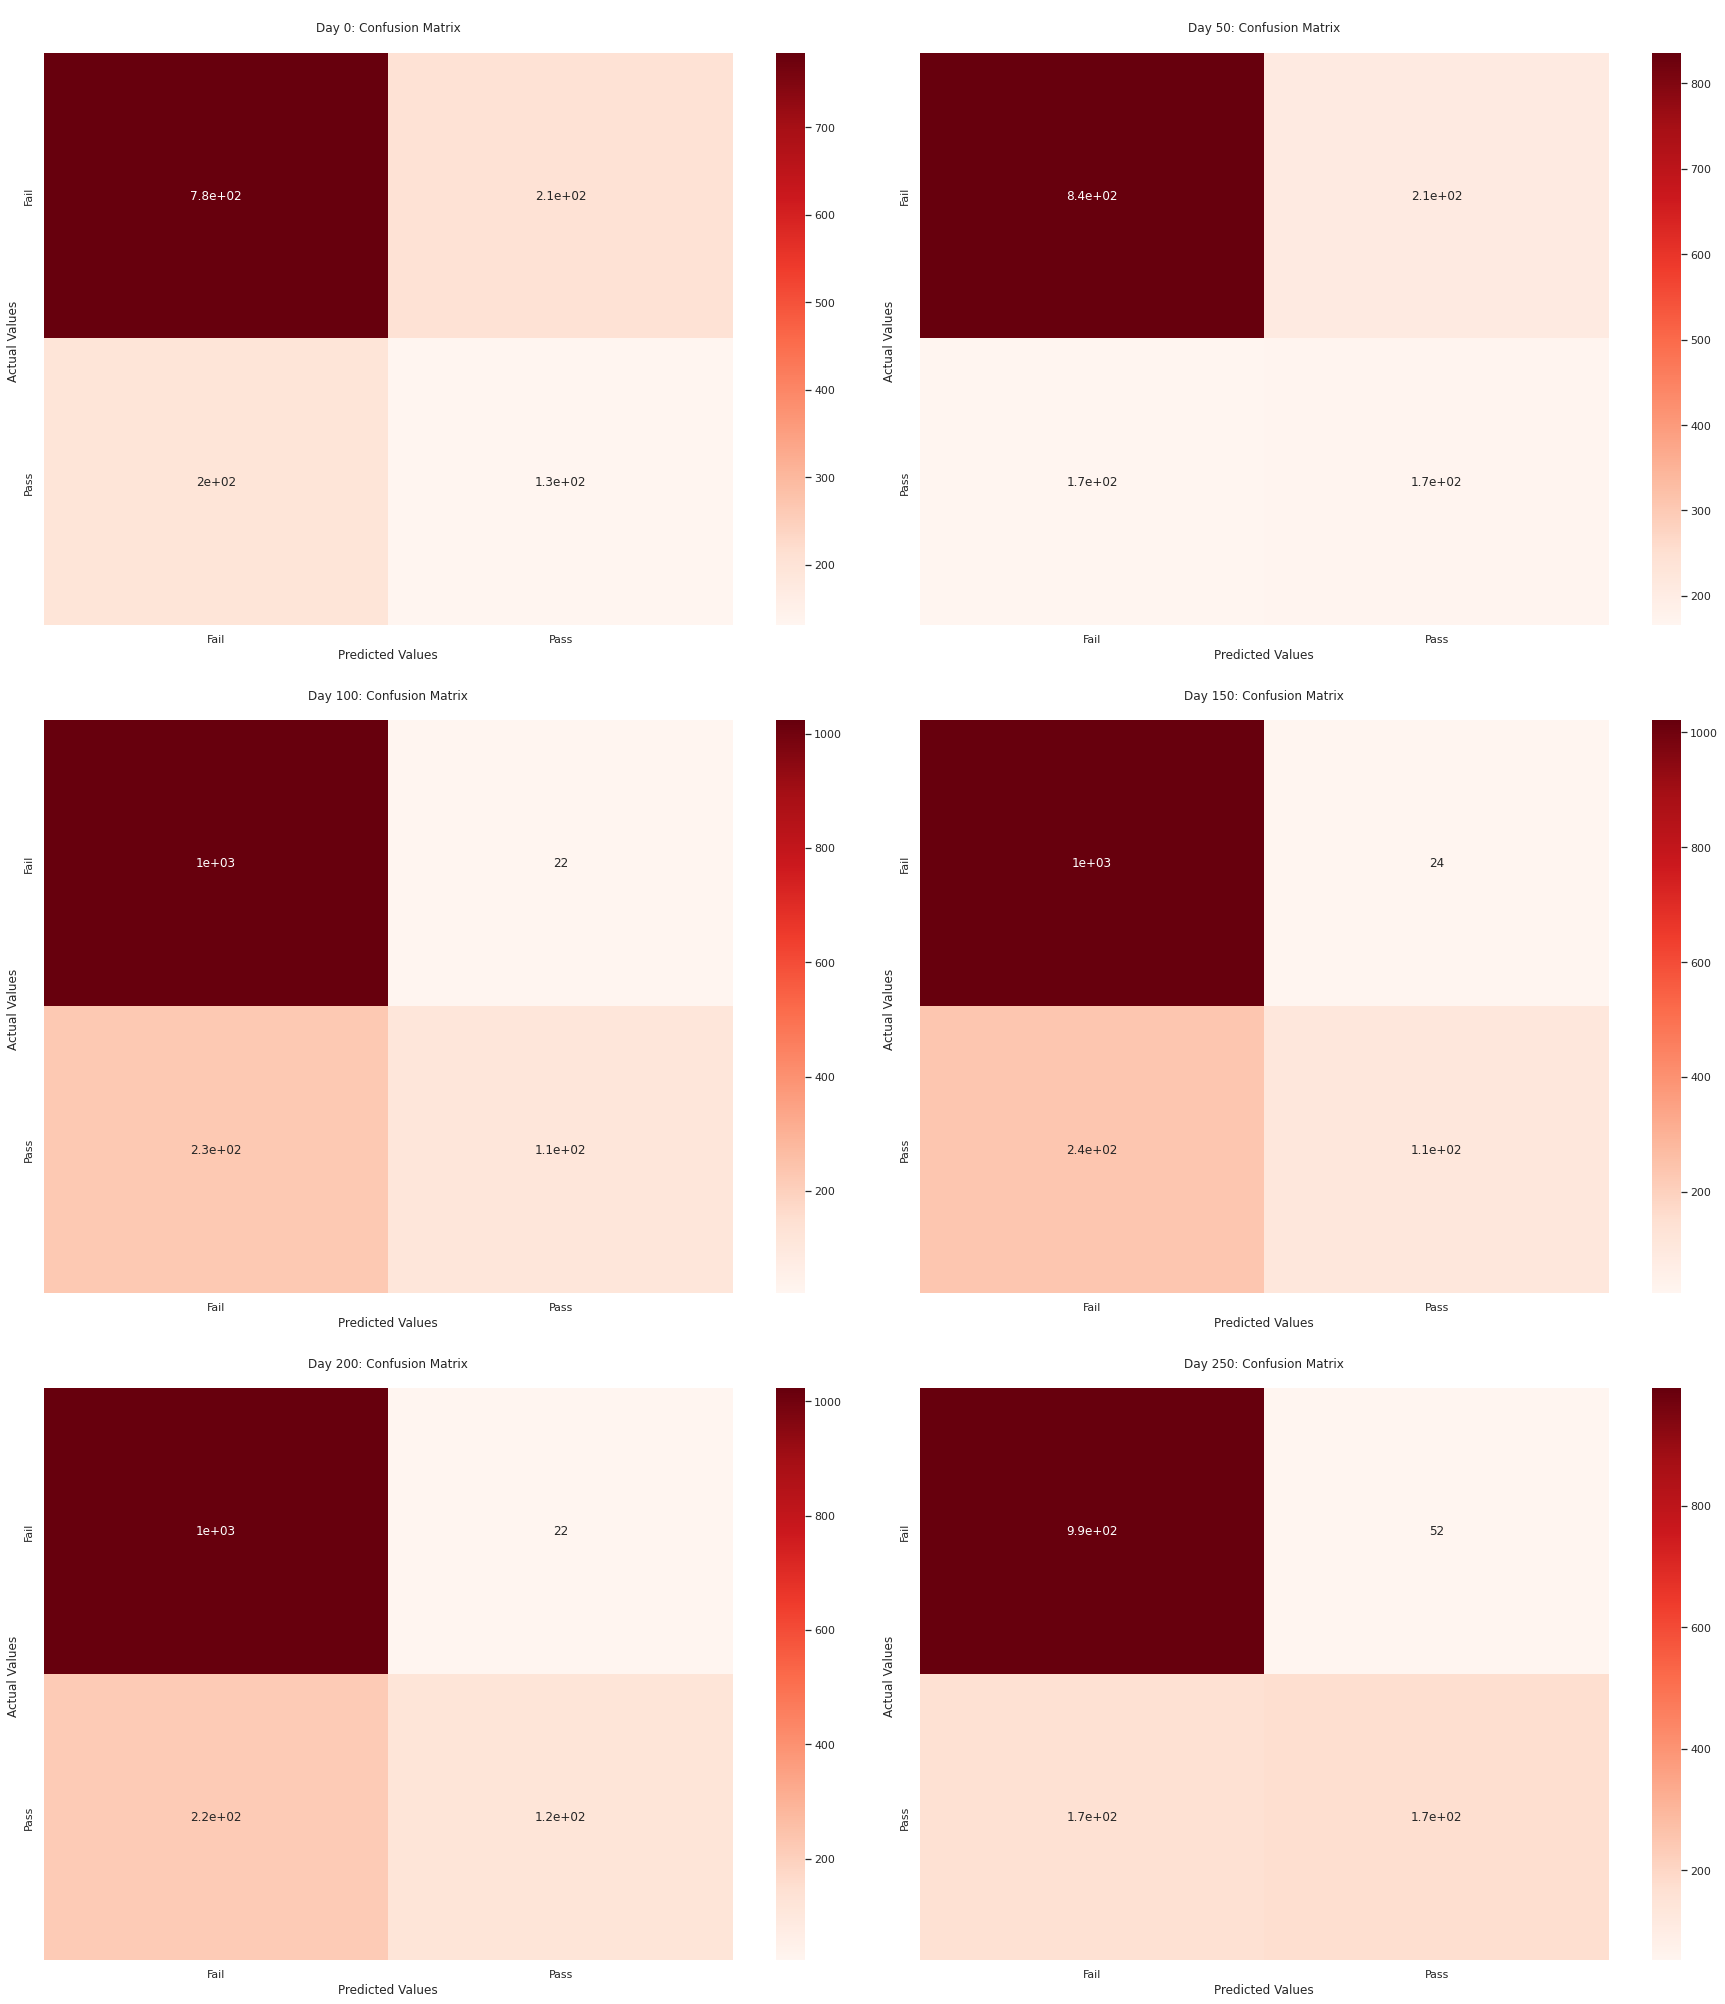

In [117]:
plot_confusion_matrix(all_results_nb)

##### LogisticRegression

In [118]:
from sklearn.linear_model import LogisticRegression

all_results_predict_proba_lr = []
all_results_predict_lr = []

all_results_lr = []

pipeline = Pipeline([
    ('clf', LogisticRegression(max_iter=1000)),
])

params = {
  'clf__penalty': ['l2', 'none']
}

for i in df.keys():
  print(f"Day {i}")
  grid_search = GridSearchCV(pipeline , param_grid=params , n_jobs=-1, verbose=1, scoring='f1_macro', cv=3,)
  print("Performing grid search...")
  print("pipeline:", [name for name, _ in pipeline.steps])
  print("parameters:")
  print(params)
  tuned_model = grid_search.fit(X_train[i], Y_train[i])

  print("Best score: %0.3f" % grid_search.best_score_)
  print("Best parameters set:")
  best_parameters = grid_search.best_estimator_.get_params()
  for param_name in sorted(params.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

  predictions = tuned_model.predict(X_test[i])
  predictions_proba = tuned_model.predict_proba(X_test[i])


  acc, f1, prec, recall, conf = evaluation_summary(predictions, Y_test[i])
  print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
  all_results_lr.append([acc, f1, prec, recall, conf])
  all_results_predict_proba_lr.append(predictions_proba)
  all_results_predict_lr.append(predictions)

  print("\n")

Day 0
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__penalty': ['l2', 'none']}
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Best score: 0.595
Best parameters set:
	clf__penalty: 'none'
Accuracy: 0.7314112291350531, F1 Score: 0.358695652173913, Precision: 0.43805309734513276, Recall: 0.30368098159509205


Day 50
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__penalty': ['l2', 'none']}
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Best score: 0.657
Best parameters set:
	clf__penalty: 'none'
Accuracy: 0.7556200145032632, F1 Score: 0.44844517184942717, Precision: 0.4963768115942029, Recall: 0.408955223880597


Day 100
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__penalty': ['l2', 'none']}
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Best score: 0.840
Best parameters set:
	clf__penalty: 'none'
Accuracy: 0.865606936416185, F1 Score: 0.6815068493150684, Precision: 0.8122448979591836, Recall: 0.58702064896

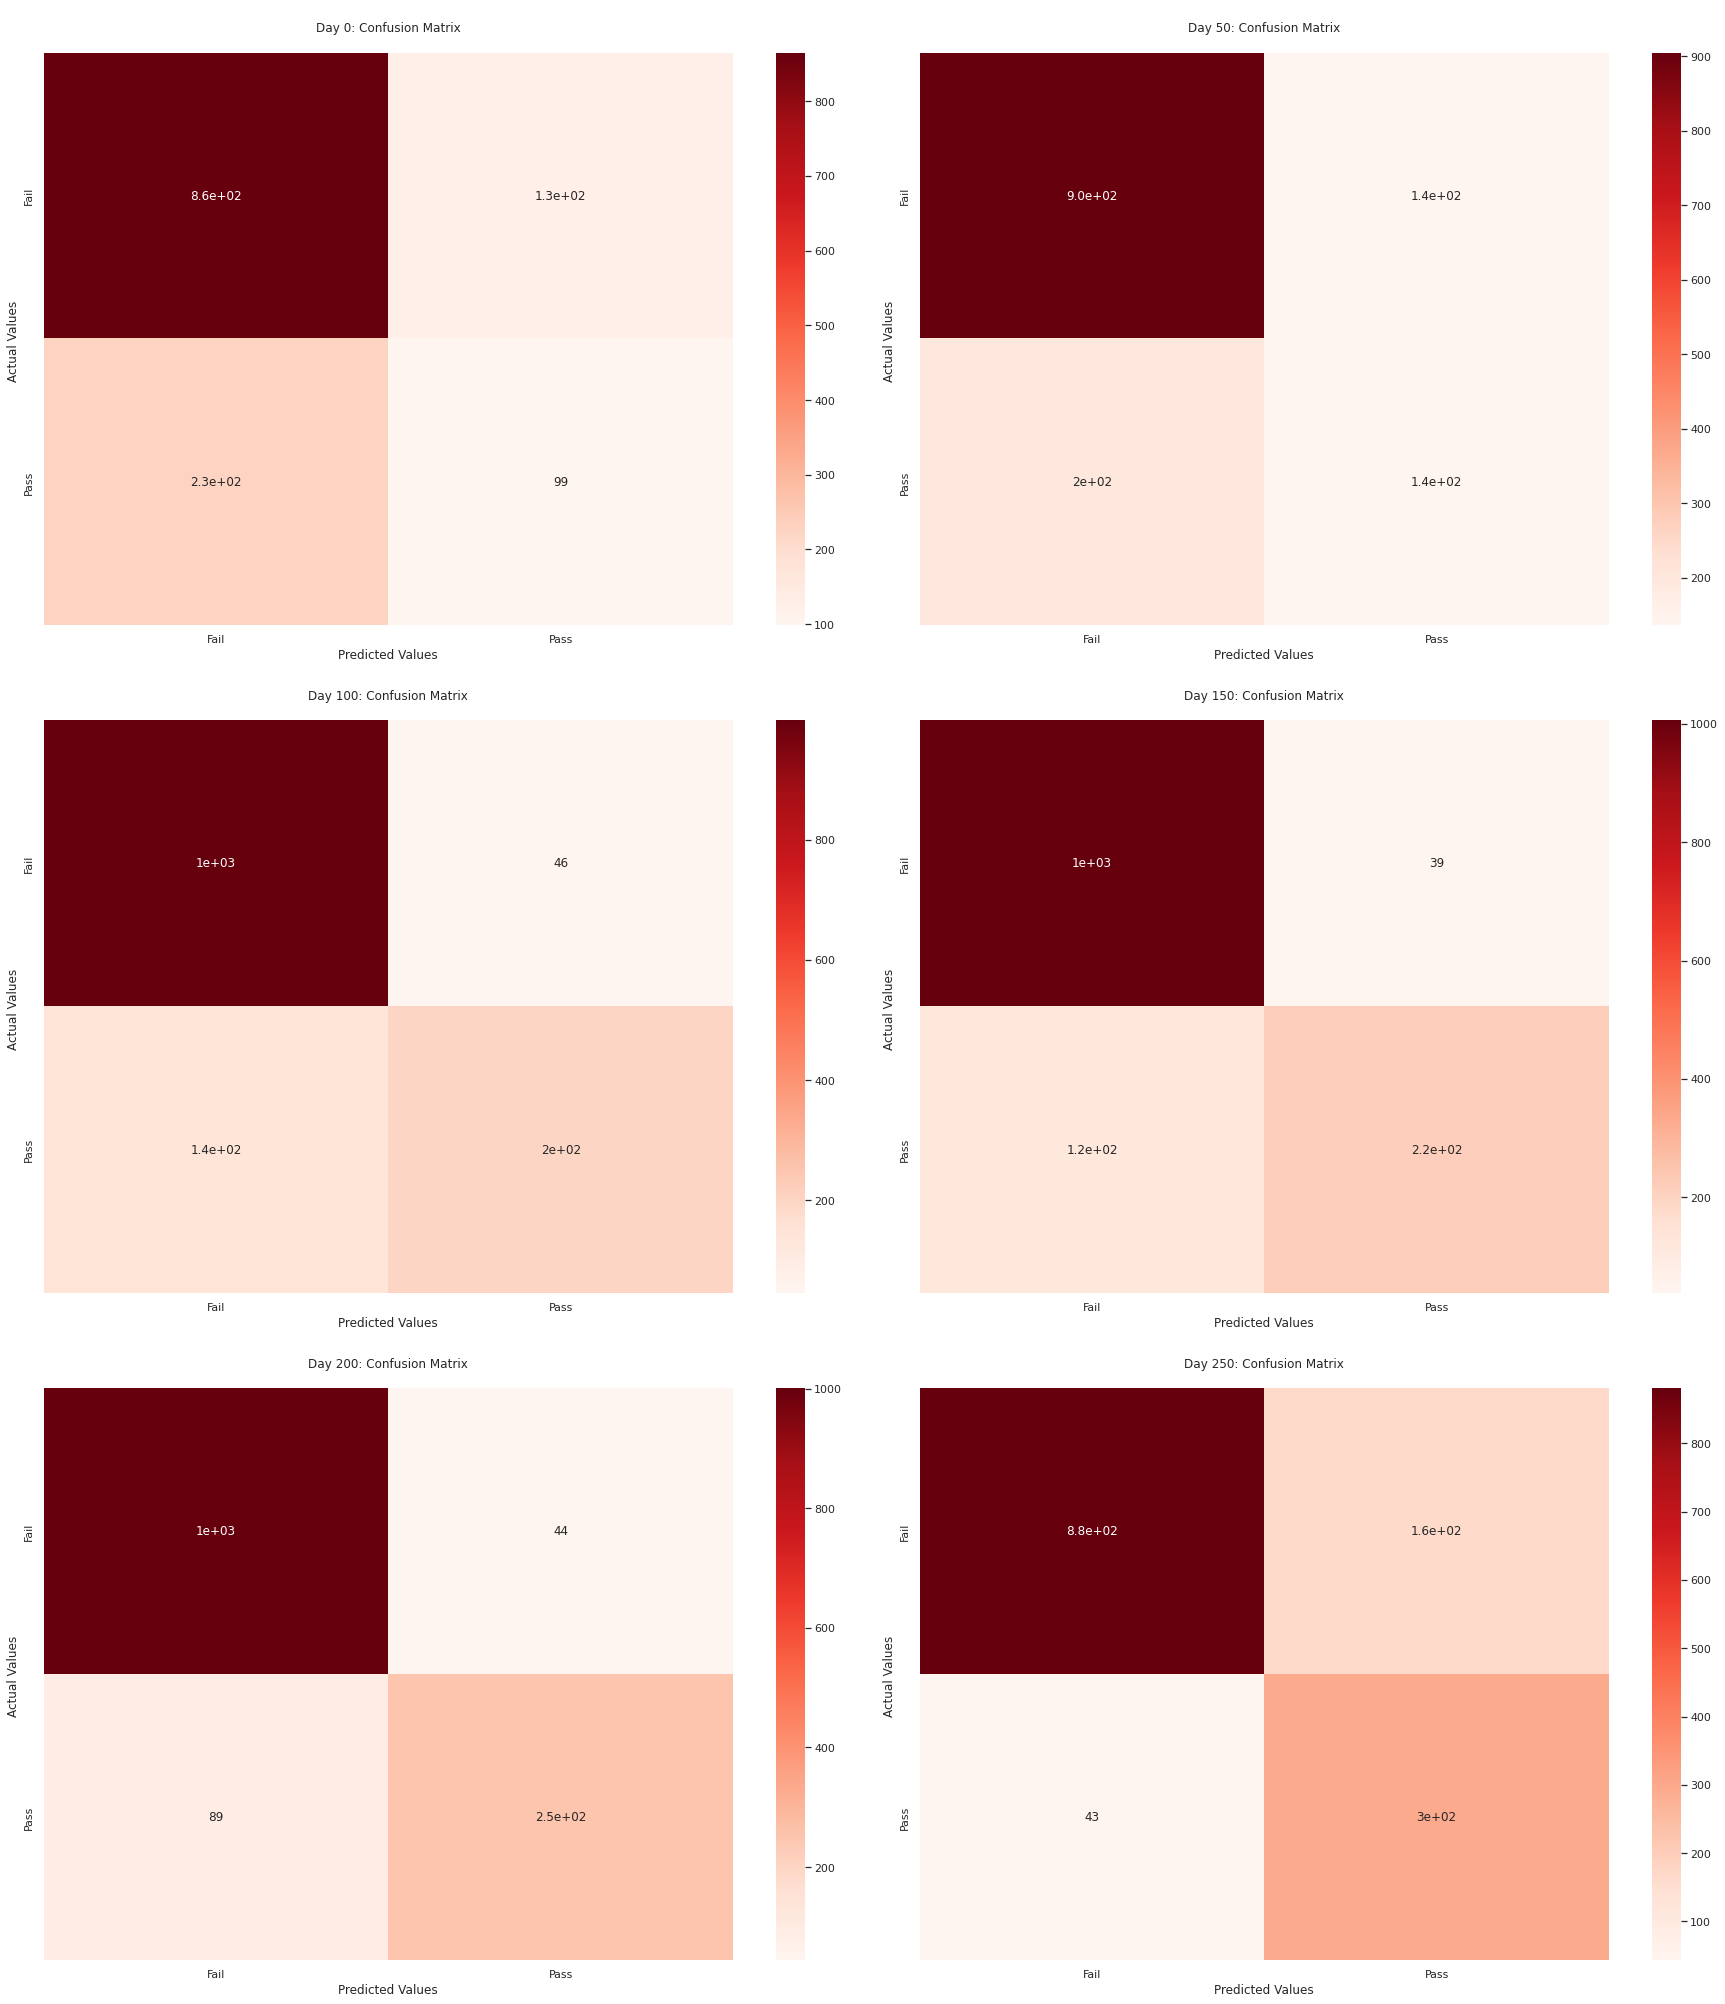

In [119]:
plot_confusion_matrix(all_results_lr)

##### WeightedLogisticRegression

In [120]:
all_results_lrw = []

pipeline = Pipeline([
    ('clf', LogisticRegression(max_iter=1000,class_weight = 'balanced')),
])

params = {
}

for i in df.keys():
  print(f"Day {i}")
  grid_search = GridSearchCV(pipeline , param_grid=params , n_jobs=-1, verbose=1, scoring='f1_macro', cv=3,)
  print("Performing grid search...")
  print("pipeline:", [name for name, _ in pipeline.steps])
  print("parameters:")
  print(params)
  tuned_model = grid_search.fit(X_train[i], Y_train[i])

  print("Best score: %0.3f" % grid_search.best_score_)
  print("Best parameters set:")
  best_parameters = grid_search.best_estimator_.get_params()
  for param_name in sorted(params.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

  predictions = tuned_model.predict(X_test[i])


  acc, f1, prec, recall, conf = evaluation_summary(predictions, Y_test[i])
  print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
  all_results_lrw.append([acc, f1, prec, recall, conf])
  print("\n")

Day 0
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.623
Best parameters set:
Accuracy: 0.6145675265553869, F1 Score: 0.45493562231759654, Precision: 0.34983498349834985, Recall: 0.6503067484662577


Day 50
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.673
Best parameters set:
Accuracy: 0.6439448875997099, F1 Score: 0.484784889821616, Precision: 0.3737864077669903, Recall: 0.6895522388059702


Day 100
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.819
Best parameters set:
Accuracy: 0.8497109826589595, F1 Score: 0.6976744186046511, Precision: 0.6876790830945558, Recall: 0.7079646017699115


Day 150
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.858
Bes

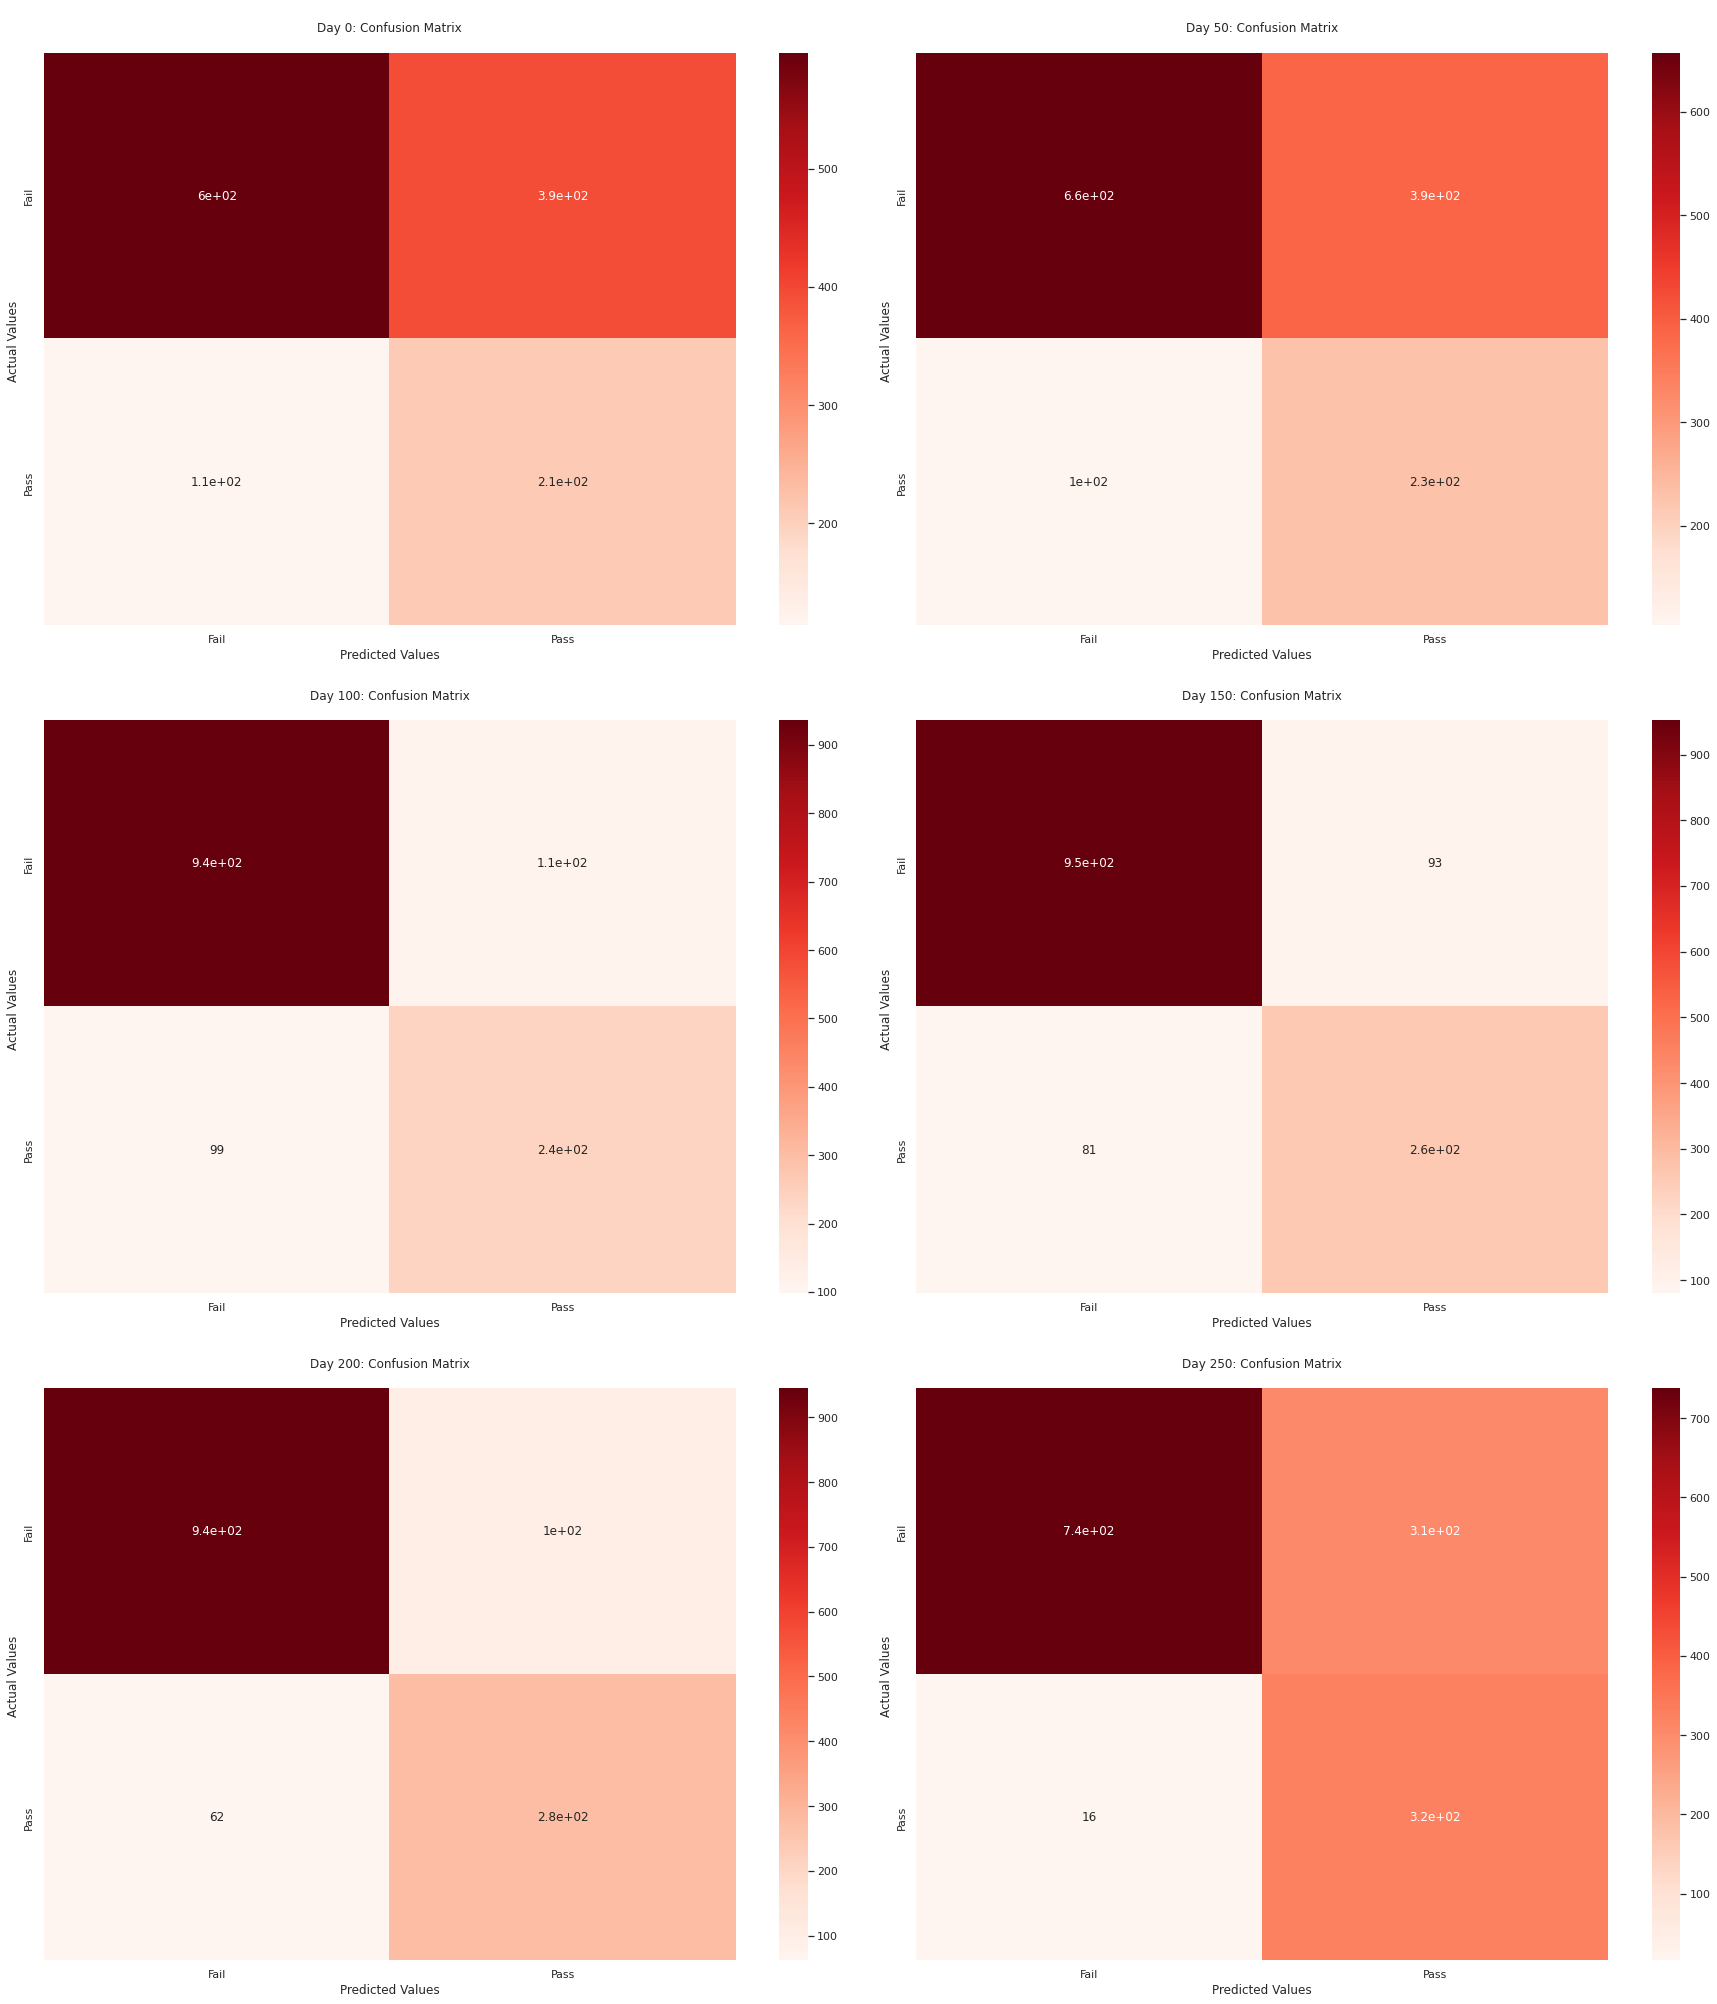

In [121]:
plot_confusion_matrix(all_results_lrw)

##### RandomForest

In [122]:
from sklearn.ensemble import RandomForestClassifier

all_results_rf = []
all_results_predict_rf = []

pipeline = Pipeline([
    ('clf', RandomForestClassifier(random_state=RANDOM_SEED, class_weight = 'balanced')),
])

params = {
  'clf__n_estimators': [x for x in range(50,150,10)]
}

for i in df.keys():
  print(f"Day {i}")
  grid_search = GridSearchCV(pipeline , param_grid=params , n_jobs=-1, verbose=1, scoring='f1_macro', cv=3,)
  print("Performing grid search...")
  print("pipeline:", [name for name, _ in pipeline.steps])
  print("parameters:")
  print(params)
  tuned_model = grid_search.fit(X_train[i], Y_train[i])

  print("Best score: %0.3f" % grid_search.best_score_)
  print("Best parameters set:")
  best_parameters = grid_search.best_estimator_.get_params()
  for param_name in sorted(params.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

  predictions = tuned_model.predict(X_test[i])


  acc, f1, prec, recall, conf = evaluation_summary(predictions, Y_test[i])
  print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
  all_results_rf.append([acc, f1, prec, recall, conf])
  all_results_predict_rf.append(predictions)

  print("\n")

Day 0
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__n_estimators': [50, 60, 70, 80, 90, 100, 110, 120, 130, 140]}
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best score: 0.580
Best parameters set:
	clf__n_estimators: 90
Accuracy: 0.7367223065250379, F1 Score: 0.29327902240325865, Precision: 0.43636363636363634, Recall: 0.22085889570552147


Day 50
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__n_estimators': [50, 60, 70, 80, 90, 100, 110, 120, 130, 140]}
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best score: 0.582
Best parameters set:
	clf__n_estimators: 60
Accuracy: 0.7461928934010152, F1 Score: 0.34210526315789475, Precision: 0.4619289340101523, Recall: 0.2716417910447761


Day 100
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__n_estimators': [50, 60, 70, 80, 90, 100, 110, 120, 130, 140]}
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best score: 0.795
Best parameters set:
	clf__n_estima

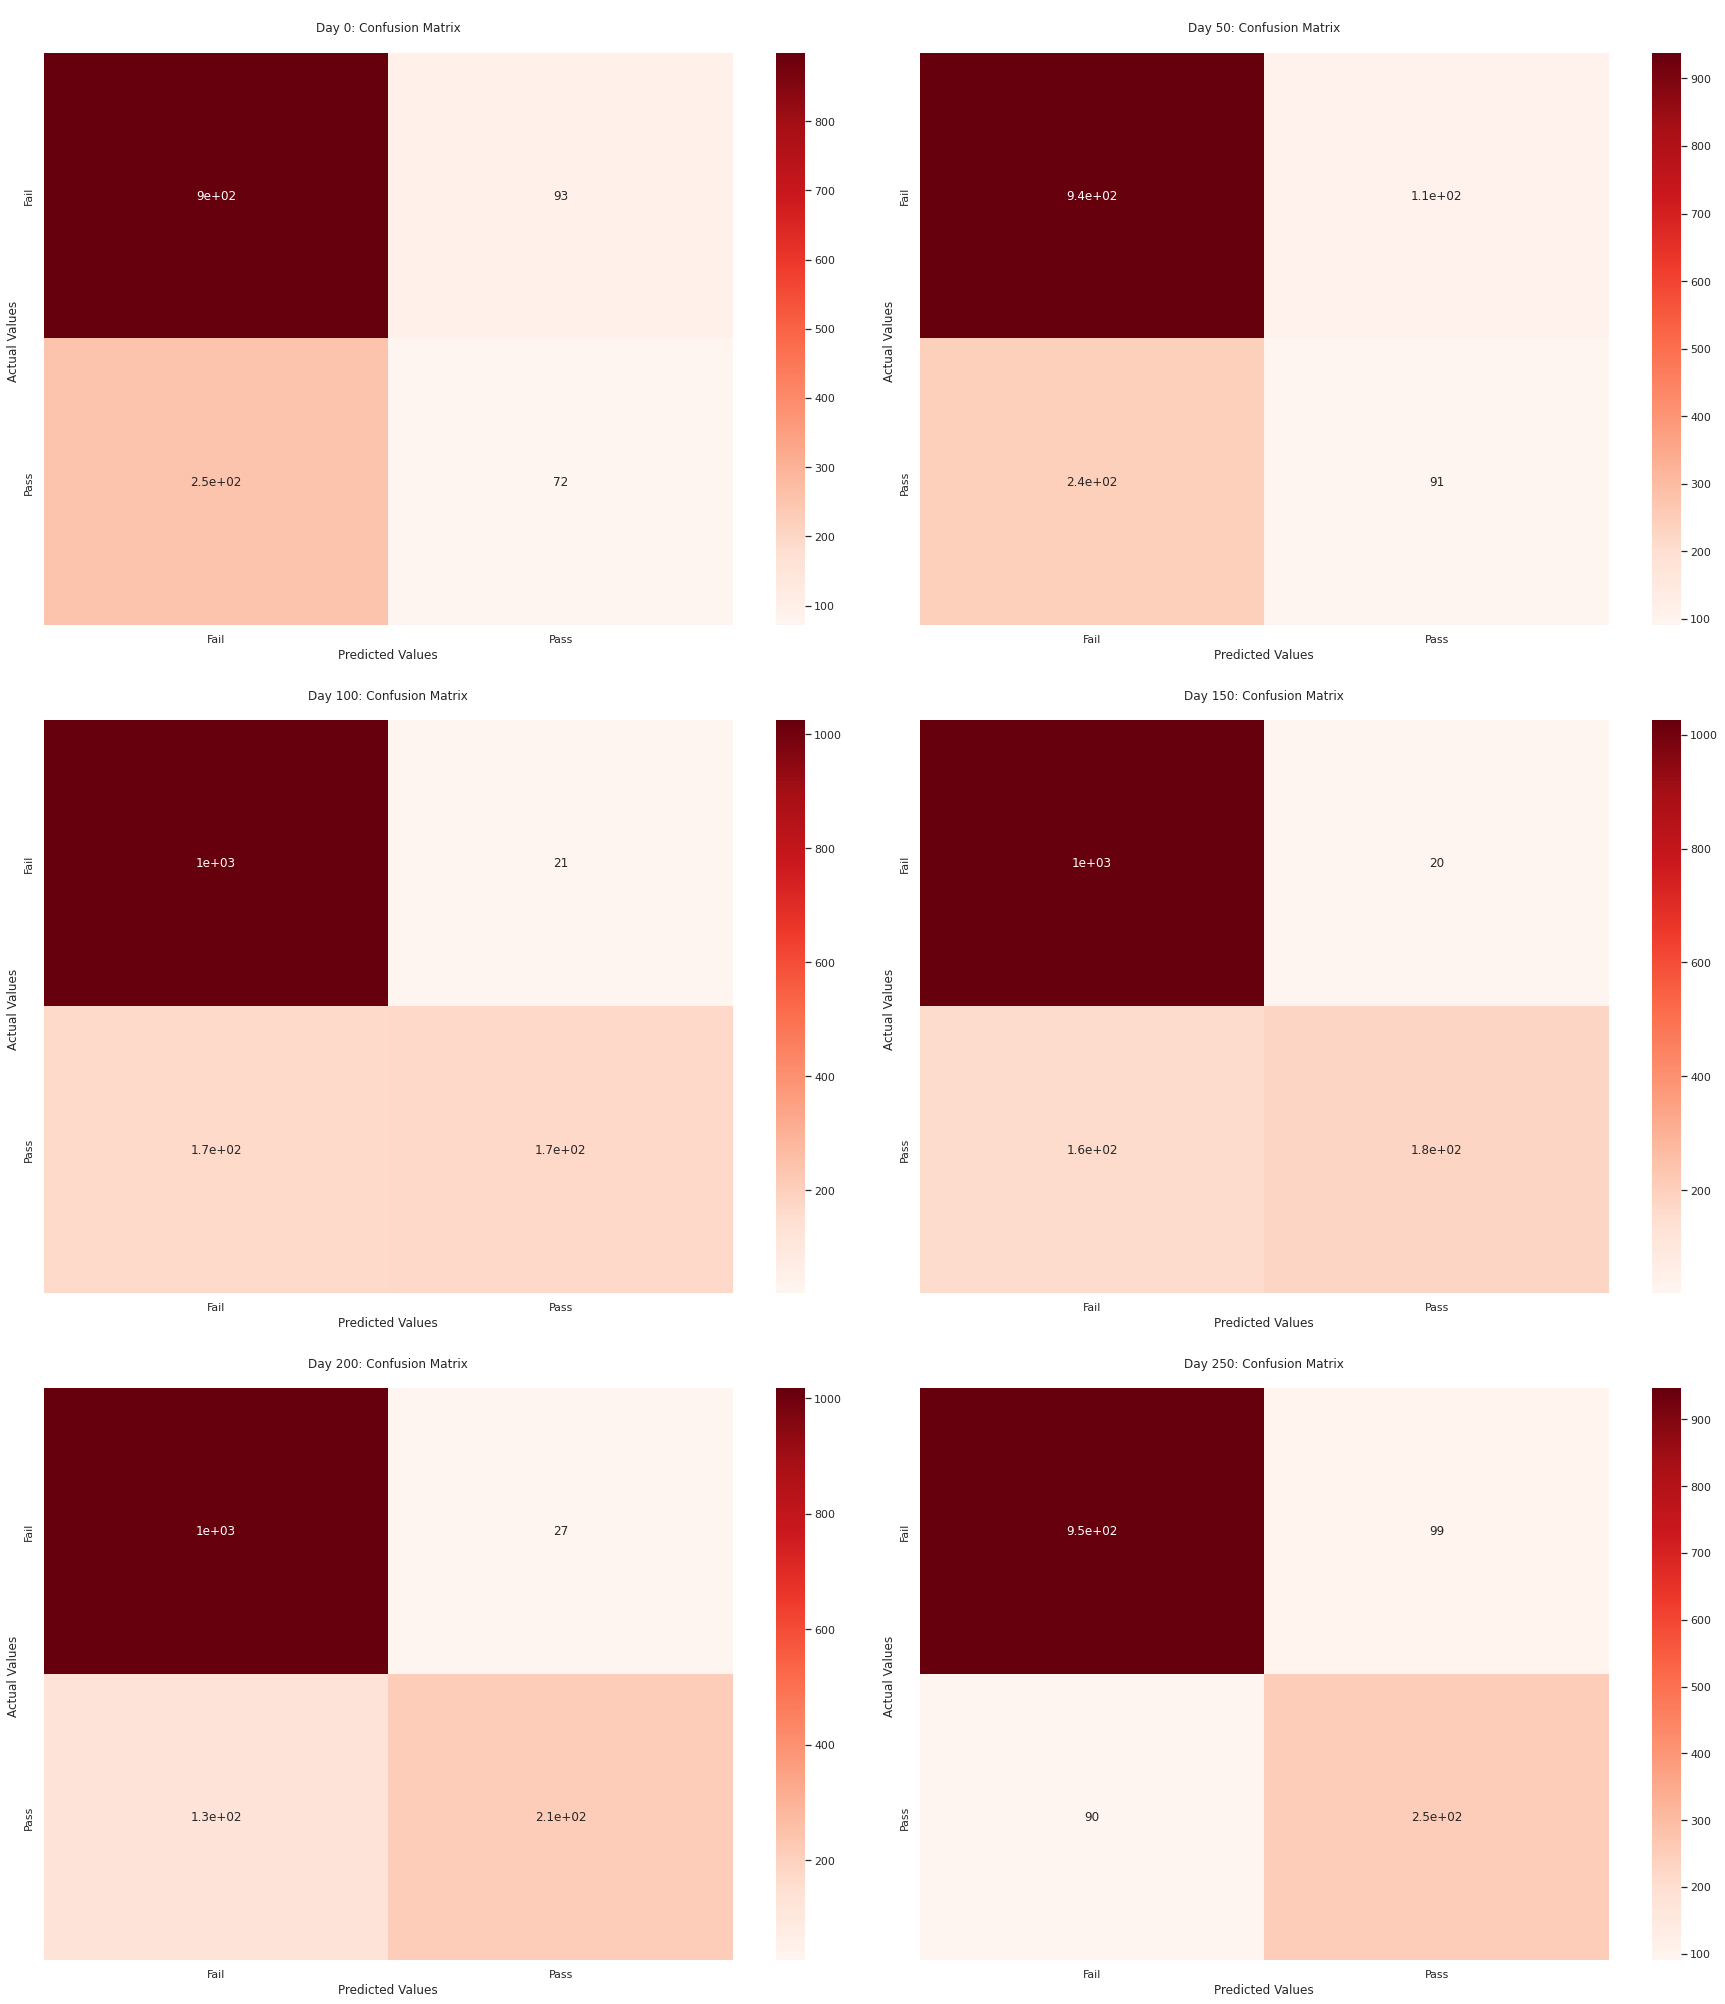

In [123]:
plot_confusion_matrix(all_results_rf)

##### AdaBoost

In [124]:
from sklearn.ensemble import AdaBoostClassifier

all_results_ab = []
all_results_predict_ab = []

pipeline = Pipeline([
    ('clf', AdaBoostClassifier(random_state=RANDOM_SEED)),
])

params = {
  'clf__learning_rate':(0.5,0.85,1,1.25,1.5,1.75)
}

for i in df.keys():
  print(f"Day {i}")
  grid_search = GridSearchCV(pipeline , param_grid=params , n_jobs=-1, verbose=1, scoring='f1_macro', cv=3,)
  print("Performing grid search...")
  print("pipeline:", [name for name, _ in pipeline.steps])
  print("parameters:")
  print(params)
  tuned_model = grid_search.fit(X_train[i], Y_train[i])

  print("Best score: %0.3f" % grid_search.best_score_)
  print("Best parameters set:")
  best_parameters = grid_search.best_estimator_.get_params()
  for param_name in sorted(params.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

  predictions = tuned_model.predict(X_test[i])


  acc, f1, prec, recall, conf = evaluation_summary(predictions, Y_test[i])
  print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
  all_results_ab.append([acc, f1, prec, recall, conf])
  all_results_predict_ab.append(predictions)
  print("\n")

Day 0
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__learning_rate': (0.5, 0.85, 1, 1.25, 1.5, 1.75)}
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best score: 0.613
Best parameters set:
	clf__learning_rate: 1
Accuracy: 0.7071320182094082, F1 Score: 0.38141025641025644, Precision: 0.39932885906040266, Recall: 0.36503067484662577


Day 50
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__learning_rate': (0.5, 0.85, 1, 1.25, 1.5, 1.75)}
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best score: 0.637
Best parameters set:
	clf__learning_rate: 0.5
Accuracy: 0.7440174039158811, F1 Score: 0.4027072758037225, Precision: 0.46484375, Recall: 0.35522388059701493


Day 100
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__learning_rate': (0.5, 0.85, 1, 1.25, 1.5, 1.75)}
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best score: 0.827
Best parameters set:
	clf__learning_rate: 1
Accuracy: 0.8641618497109826, F1 Score:

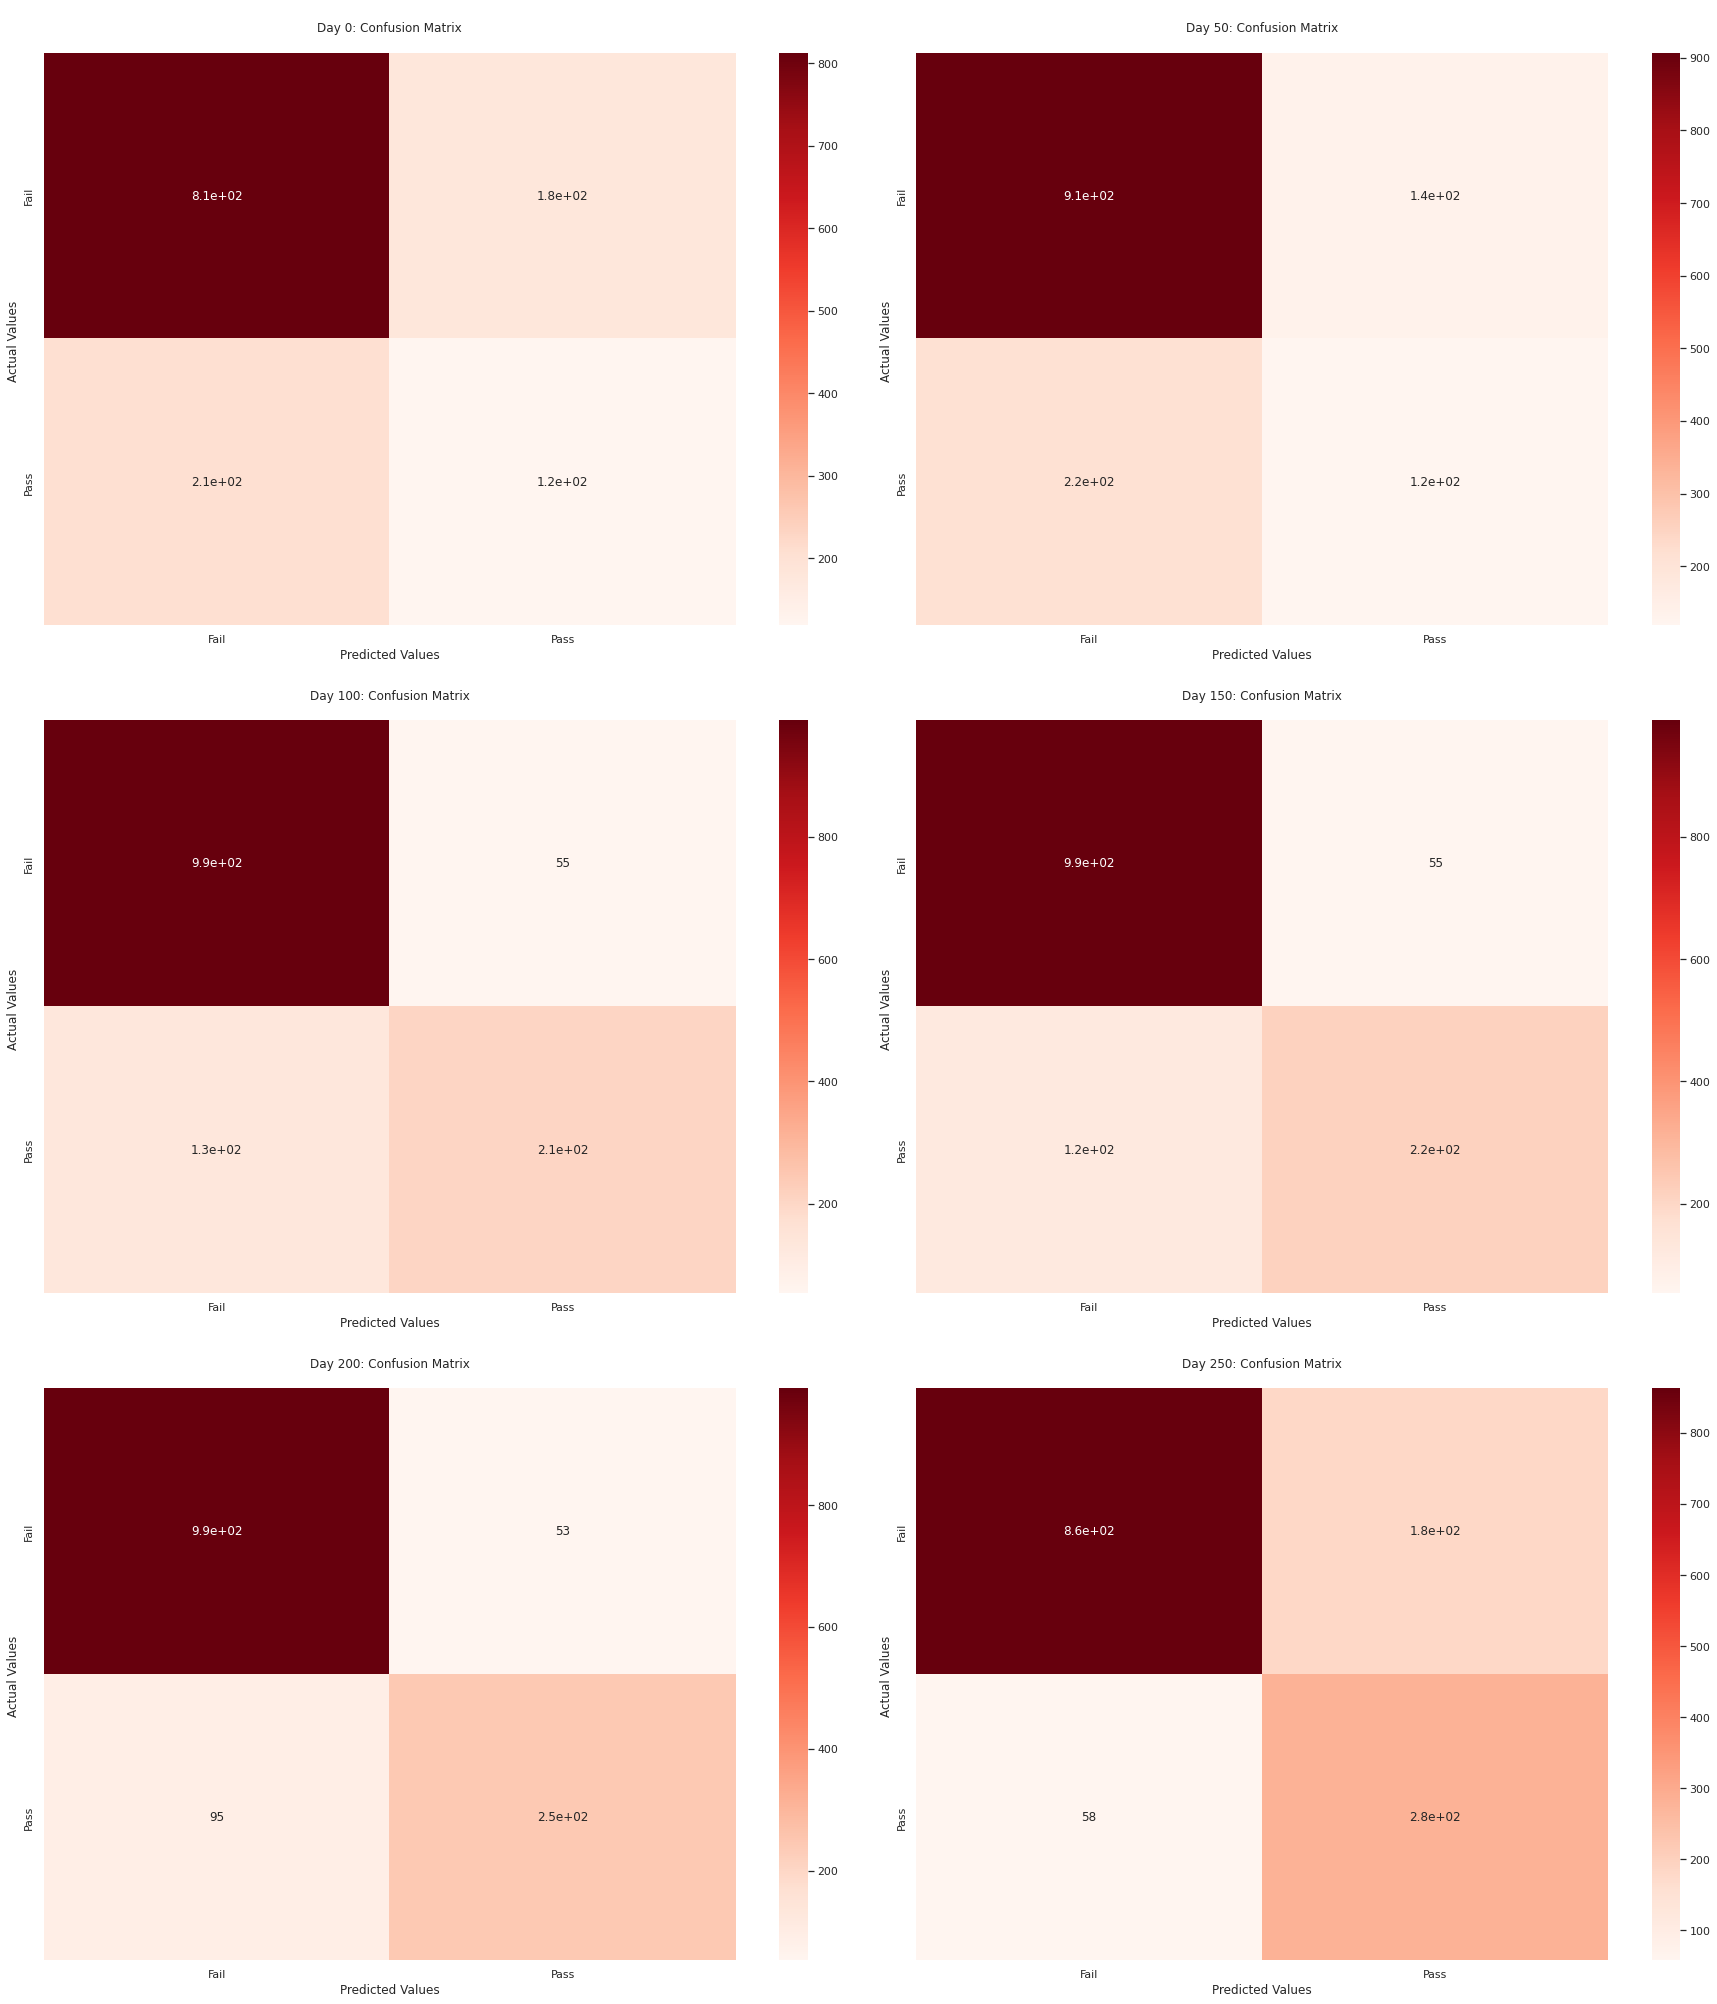

In [125]:
plot_confusion_matrix(all_results_ab)

##### Plot results overview

In [126]:
all_classifier_results = [all_results_du, all_results_nb, all_results_lr, all_results_lrw, all_results_rf, all_results_ab]
all_classifier_labels = ["Dummy Classifier", "Naive Bayes", "Logistic Regression", "Logistic Regression Weighted", "Random Forest", "AdaBoost"]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-o

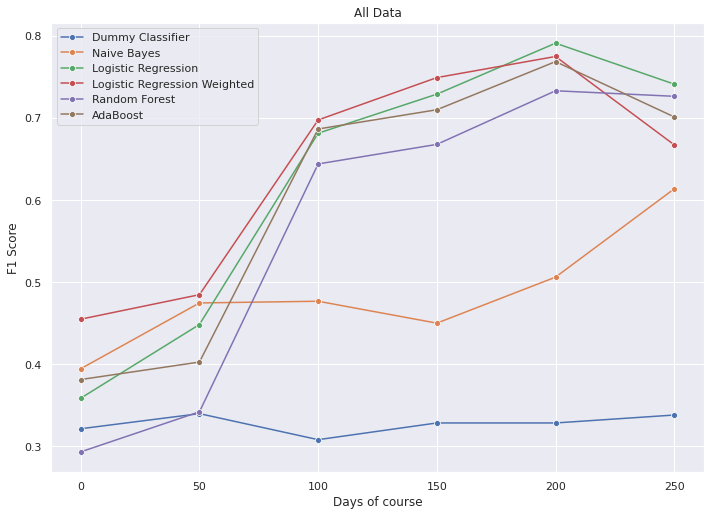

In [127]:
plot_days_compare(deadline_list,all_classifier_results,all_classifier_labels, "All Data")

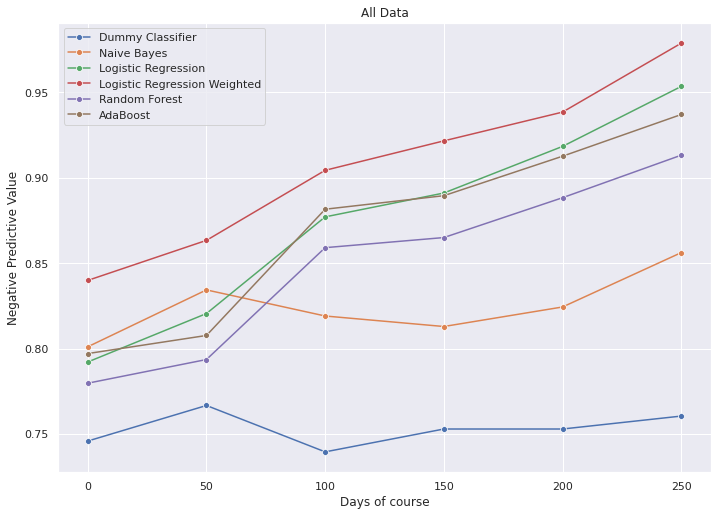

In [128]:
plot_days_compare_npv(deadline_list,all_classifier_results,all_classifier_labels, "All Data")

#### Three classifiers

In [129]:
confusion_matrix_combine_three = []
keys= list(df)

for i in range(len(df.keys())):
  print(i)

  test_results = pd.DataFrame(Y_test[keys[i]]).reset_index().to_numpy()[:,1]

  confusion_matrix_combine_three.append(np.zeros([2,2]))

  for j in range(len(all_results_predict_lr[i])):
    sum_predict = all_results_predict_lr[i][j] + all_results_predict_rf[i][j] + all_results_predict_ab[i][j]
    if sum_predict <= 1:
      prediction = 0
    else:
      prediction = 1

    if prediction == 0 and test_results[j] == 0:
      confusion_matrix_combine_three[i][0,0] += 1
    elif prediction == 0 and test_results[j] == 1:
      confusion_matrix_combine_three[i][1,0] += 1
    elif prediction == 1 and test_results[j] == 0:
      confusion_matrix_combine_three[i][0,1] += 1
    else:
      confusion_matrix_combine_three[i][1,1] += 1


0
1
2
3
4
5


In [130]:
for i in range(len(confusion_matrix_combine_three)):
  print(confusion_matrix_combine_three[i])

[[872. 120.]
 [232.  94.]]
[[938. 106.]
 [223. 112.]]
[[1015.   30.]
 [ 145.  194.]]
[[1015.   30.]
 [ 138.  203.]]
[[1006.   39.]
 [ 101.  240.]]
[[919. 127.]
 [ 59. 282.]]


#### Combine Classifier Results

In [131]:
confusion_matrix_combine = []
performance_weight = [0,0,0,0.0,0.5,0.5]
keys= list(df)


for i in range(len(df.keys())):
  print(i)

  test_results = pd.DataFrame(Y_test[keys[i]]).reset_index().to_numpy()[:,1]

  confusion_matrix_combine.append(np.zeros([2,2]))
  for j in range(len(all_results_predict_proba_lr[i])):
    all_result = all_results_predict_proba_lr[i][j] * (1-performance_weight[i])

    if performance_weight[i] != 0:
      performance_result = performance_predict_proba_nb[i-1][j] * (performance_weight[i])
    else:
      performance_result = 0
    
    final_result = all_result + performance_result
    
    if final_result[0]>0.55:
      prediction = 0
    else:
      prediction = 1

    if prediction == 0 and test_results[j] == 0:
      confusion_matrix_combine[i][0,0] += 1
    elif prediction == 0 and test_results[j] == 1:
      confusion_matrix_combine[i][1,0] += 1
    elif prediction == 1 and test_results[j] == 0:
      confusion_matrix_combine[i][0,1] += 1
    else:
      confusion_matrix_combine[i][1,1] += 1


0
1
2
3
4
5


In [132]:
for i in range(len(confusion_matrix_combine)):
  print(confusion_matrix_combine[i])

[[810. 182.]
 [202. 124.]]
[[865. 179.]
 [166. 169.]]
[[989.  56.]
 [129. 210.]]
[[997.  48.]
 [112. 229.]]
[[984.  61.]
 [ 79. 262.]]
[[835. 211.]
 [ 30. 311.]]
